In [1]:
#méthode de gradient boosting avec surement du stacking pour le forecasting

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [59]:
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option("plotting.backend", "pandas_bokeh")

Loading BokehJS ...

In [60]:
uber = pd.read_csv('../uber_data.csv', parse_dates = True)

In [61]:
uber

pickup_dt        borough  pickups  spd   vsb  temp  dewp  \
0      2015-01-01 01:00:00          Bronx      152  5.0  10.0  30.0   7.0   
1      2015-01-01 01:00:00       Brooklyn     1519  5.0  10.0  30.0   7.0   
2      2015-01-01 01:00:00            EWR        0  5.0  10.0  30.0   7.0   
3      2015-01-01 01:00:00      Manhattan     5258  5.0  10.0  30.0   7.0   
4      2015-01-01 01:00:00         Queens      405  5.0  10.0  30.0   7.0   
...                    ...            ...      ...  ...   ...   ...   ...   
29096  2015-06-30 23:00:00            EWR        0  7.0  10.0  75.0  65.0   
29097  2015-06-30 23:00:00      Manhattan     3828  7.0  10.0  75.0  65.0   
29098  2015-06-30 23:00:00         Queens      580  7.0  10.0  75.0  65.0   
29099  2015-06-30 23:00:00  Staten Island        0  7.0  10.0  75.0  65.0   
29100  2015-06-30 23:00:00            NaN        3  7.0  10.0  75.0  65.0   

          slp  pcp01  pcp06  pcp24   sd hday  
0      1023.5    0.0    0.0    0.0  0.0    Y  
1      1023.5    0.0    0.0    0.0  0.0    Y  
2      1023.5    0.0    0.0    0.0  0.0    Y  
3      1023.5    0.0    0.0    0.0  0.0    Y  
4      1023.5    0.0    0.0    0.0  0.0    Y  
...       ...    ...    ...    ...  ...  ...  
29096  1011.8    0.0    0.0    0.0  0.0    N  
29097  1011.8    0.0    0.0    0.0  0.0    N  
29098  1011.8    0.0    0.0    0.0  0.0    N  
29099  1011.8    0.0    0.0    0.0  0.0    N  
29100  1011.8    0.0    0.0    0.0  0.0    N  

[29101 rows x 13 columns]

In [62]:
uber_man = uber[uber['borough'] == 'Queens']

In [63]:
uber_man = uber_man.drop('borough', axis=1)

uber_man['pickup_dt'] = uber_man['pickup_dt'].astype(str) 

uber_man = uber_man.set_index('pickup_dt')

uber_man = pd.get_dummies(uber_man)

In [64]:
uber_man.tail()

pickups  spd   vsb  temp  dewp     slp  pcp01  pcp06  \
pickup_dt                                                                   
2015-06-30 19:00:00      417  5.0  10.0  80.0  58.0  1012.5    0.0    0.0   
2015-06-30 20:00:00      438  8.0  10.0  80.0  58.0  1012.4    0.0    0.0   
2015-06-30 21:00:00      483  7.0  10.0  76.0  61.0  1012.4    0.0    0.0   
2015-06-30 22:00:00      556  5.0  10.0  76.0  64.0  1011.9    0.0    0.0   
2015-06-30 23:00:00      580  7.0  10.0  75.0  65.0  1011.8    0.0    0.0   

                     pcp24   sd  hday_N  hday_Y  
pickup_dt                                        
2015-06-30 19:00:00    0.0  0.0       1       0  
2015-06-30 20:00:00    0.0  0.0       1       0  
2015-06-30 21:00:00    0.0  0.0       1       0  
2015-06-30 22:00:00    0.0  0.0       1       0  
2015-06-30 23:00:00    0.0  0.0       1       0

Ajout d'une lag feature sur la serie
il s'agit d'horizon en heure donc on peut faire des lags sur les heures précédentes jusqu'à -4h par exemple
ensuite sur le jour précédent à la même heure
la semaine précédente
et enfin le mois

In [65]:
#lag features
for i in [1,2,3,4,24,7*24]:
    uber_man[f'lag_{i}'] = uber_man.pickups.shift(i)

In [66]:
def smape_perso(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [67]:
import lightgbm as lgb

In [68]:
uber_man.head()

pickups  spd   vsb  temp  dewp     slp  pcp01  pcp06  \
pickup_dt                                                                   
2015-01-01 01:00:00      405  5.0  10.0  30.0   7.0  1023.5    0.0    0.0   
2015-01-01 02:00:00      331  3.0  10.0  30.0   6.0  1023.0    0.0    0.0   
2015-01-01 03:00:00      440  5.0  10.0  30.0   8.0  1022.3    0.0    0.0   
2015-01-01 04:00:00      344  5.0  10.0  29.0   9.0  1022.0    0.0    0.0   
2015-01-01 05:00:00      241  5.0  10.0  28.0   9.0  1021.8    0.0    0.0   

                     pcp24   sd  hday_N  hday_Y  lag_1  lag_2  lag_3  lag_4  \
pickup_dt                                                                     
2015-01-01 01:00:00    0.0  0.0       0       1    NaN    NaN    NaN    NaN   
2015-01-01 02:00:00    0.0  0.0       0       1  405.0    NaN    NaN    NaN   
2015-01-01 03:00:00    0.0  0.0       0       1  331.0  405.0    NaN    NaN   
2015-01-01 04:00:00    0.0  0.0       0       1  440.0  331.0  405.0    NaN   
2015-01-01 05:00:00    0.0  0.0       0       1  344.0  440.0  331.0  405.0   

                     lag_24  lag_168  
pickup_dt                             
2015-01-01 01:00:00     NaN      NaN  
2015-01-01 02:00:00     NaN      NaN  
2015-01-01 03:00:00     NaN      NaN  
2015-01-01 04:00:00     NaN      NaN  
2015-01-01 05:00:00     NaN      NaN

In [69]:
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import temporal_train_test_split

#uber_mancv = uber_man.reset_index(drop=True)

X = uber_man.drop('pickups', axis=1)
y = uber_man['pickups']




tscv = TimeSeriesSplit(n_splits = 3)

    
    
    
train, test = temporal_train_test_split(uber_man, test_size = 720)

X_train = train.drop('pickups', axis=1)
y_train = train['pickups']
X_test = test.drop('pickups',axis=1)
y_test = test['pickups']

In [70]:
len(X_test)

720

In [71]:
from sklearn.model_selection import RandomizedSearchCV

rs_params = {
    'learning_rate': [0.01,0.03,0.01],
    'max_depth': [2,4,6,8,10,12],
    'num_leaves': [10,20,40,60,100,200],
    'metric': ['mape'],
    'num_iterations': [500],
    'objective':['poisson','tweedie','mape','regression']
}

rs_cv = RandomizedSearchCV(estimator=lgb.LGBMRegressor(), param_distributions=rs_params,
                           cv = tscv, n_iter=100,verbose=1)




In [ ]:
#alors la le set de validation n'est pas bon il ne devrait pas etre fait avec le X_test et y_test
rs_cv.fit(X_train, y_train,verbose=1, early_stopping_rounds= 100,eval_set = (X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[1]	valid_0's mape: 0.557736
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.555537
[3]	valid_0's mape: 0.553348
[4]	valid_0's mape: 0.55117
[5]	valid_0's mape: 0.549005
[6]	valid_0's mape: 0.546858
[7]	valid_0's mape: 0.544724
[8]	valid_0's mape: 0.542602
[9]	valid_0's mape: 0.540491
[10]	valid_0's mape: 0.538376
[11]	valid_0's mape: 0.536332
[12]	valid_0's mape: 0.534299
[13]	valid_0's mape: 0.532275
[14]	valid_0's mape: 0.53027
[15]	valid_0's mape: 0.528284
[16]	valid_0's mape: 0.526295
[17]	valid_0's mape: 0.524319
[18]	valid_0's mape: 0.52235
[19]	valid_0's mape: 0.520391
[20]	valid_0's mape: 0.518441
[21]	valid_0's mape: 0.516503
[22]	valid_0's mape: 0.514574
[23]	valid_0's mape: 0.512696
[24]	valid_0's mape: 0.510785
[25]	valid_0's mape: 0.508887
[26]	valid_0's mape: 0.507045
[27]	valid_0's mape: 0.505221
[28]	valid_0's mape: 0.50337
[29]	valid_0's mape: 0.501508
[30]	valid_0's map

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[37]	valid_0's mape: 0.487237
[38]	valid_0's mape: 0.485523
[39]	valid_0's mape: 0.483755
[40]	valid_0's mape: 0.482056
[41]	valid_0's mape: 0.480323
[42]	valid_0's mape: 0.478634
[43]	valid_0's mape: 0.476916
[44]	valid_0's mape: 0.475235
[45]	valid_0's mape: 0.473555
[46]	valid_0's mape: 0.471917
[47]	valid_0's mape: 0.470252
[48]	valid_0's mape: 0.468633
[49]	valid_0's mape: 0.466965
[50]	valid_0's mape: 0.465359
[51]	valid_0's mape: 0.463723
[52]	valid_0's mape: 0.462131
[53]	valid_0's mape: 0.46049
[54]	valid_0's mape: 0.458917
[55]	valid_0's mape: 0.457331
[56]	valid_0's mape: 0.455705
[57]	valid_0's mape: 0.454139
[58]	valid_0's mape: 0.452567
[59]	valid_0's mape: 0.450891
[60]	valid_0's mape: 0.449349
[61]	valid_0's mape: 0.447688
[62]	valid_0's mape: 0.446153
[63]	valid_0's mape: 0.444519
[64]	valid_0's mape: 0.443006
[65]	valid_0's mape: 0.441403
[66]	valid_0's mape: 0.439904
[67]	valid_0's mape: 0.438301
[68]	valid_0's mape: 0.436768
[69]	valid_0's mape: 0.435184
[70]	valid_

[483]	valid_0's mape: 0.199232
[484]	valid_0's mape: 0.199139
[485]	valid_0's mape: 0.19906
[486]	valid_0's mape: 0.199012
[487]	valid_0's mape: 0.198905
[488]	valid_0's mape: 0.198811
[489]	valid_0's mape: 0.198701
[490]	valid_0's mape: 0.198659
[491]	valid_0's mape: 0.198586
[492]	valid_0's mape: 0.198541
[493]	valid_0's mape: 0.198453
[494]	valid_0's mape: 0.198346
[495]	valid_0's mape: 0.198253
[496]	valid_0's mape: 0.198214
[497]	valid_0's mape: 0.198173
[498]	valid_0's mape: 0.198104
[499]	valid_0's mape: 0.198014
[500]	valid_0's mape: 0.197908
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.197908
[1]	valid_0's mape: 0.550016
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.547807
[3]	valid_0's mape: 0.545598
[4]	valid_0's mape: 0.543409
[5]	valid_0's mape: 0.541255
[6]	valid_0's mape: 0.539099
[7]	valid_0's mape: 0.536947
[8]	valid_0's mape: 0.534832
[9]	valid_0's mape: 0.532742
[10]	valid_0's mape: 0.530667
[11]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[111]	valid_0's mape: 0.36713
[112]	valid_0's mape: 0.365884
[113]	valid_0's mape: 0.36465
[114]	valid_0's mape: 0.363381
[115]	valid_0's mape: 0.362121
[116]	valid_0's mape: 0.360902
[117]	valid_0's mape: 0.35965
[118]	valid_0's mape: 0.358427
[119]	valid_0's mape: 0.357252
[120]	valid_0's mape: 0.356038
[121]	valid_0's mape: 0.354844
[122]	valid_0's mape: 0.35364
[123]	valid_0's mape: 0.352481
[124]	valid_0's mape: 0.351261
[125]	valid_0's mape: 0.350096
[126]	valid_0's mape: 0.348918
[127]	valid_0's mape: 0.347718
[128]	valid_0's mape: 0.346564
[129]	valid_0's mape: 0.34537
[130]	valid_0's mape: 0.344226
[131]	valid_0's mape: 0.343085
[132]	valid_0's mape: 0.34196
[133]	valid_0's mape: 0.340814
[134]	valid_0's mape: 0.339698
[135]	valid_0's mape: 0.338591
[136]	valid_0's mape: 0.337491
[137]	valid_0's mape: 0.336347
[138]	valid_0's mape: 0.335189
[139]	valid_0's mape: 0.334079
[140]	valid_0's mape: 0.332963
[141]	valid_0's mape: 0.331905
[142]	valid_0's mape: 0.33082
[143]	valid_0's

[460]	valid_0's mape: 0.181816
[461]	valid_0's mape: 0.181723
[462]	valid_0's mape: 0.181627
[463]	valid_0's mape: 0.181517
[464]	valid_0's mape: 0.181377
[465]	valid_0's mape: 0.181255
[466]	valid_0's mape: 0.181168
[467]	valid_0's mape: 0.181084
[468]	valid_0's mape: 0.180949
[469]	valid_0's mape: 0.180795
[470]	valid_0's mape: 0.180645
[471]	valid_0's mape: 0.180564
[472]	valid_0's mape: 0.180415
[473]	valid_0's mape: 0.180342
[474]	valid_0's mape: 0.180211
[475]	valid_0's mape: 0.180065
[476]	valid_0's mape: 0.179952
[477]	valid_0's mape: 0.179885
[478]	valid_0's mape: 0.179808
[479]	valid_0's mape: 0.179666
[480]	valid_0's mape: 0.179538
[481]	valid_0's mape: 0.17944
[482]	valid_0's mape: 0.17933
[483]	valid_0's mape: 0.179255
[484]	valid_0's mape: 0.179159
[485]	valid_0's mape: 0.179003
[486]	valid_0's mape: 0.178881
[487]	valid_0's mape: 0.178787
[488]	valid_0's mape: 0.178702
[489]	valid_0's mape: 0.178583
[490]	valid_0's mape: 0.178508
[491]	valid_0's mape: 0.178375
[492]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[55]	valid_0's mape: 0.439418
[56]	valid_0's mape: 0.437698
[57]	valid_0's mape: 0.435966
[58]	valid_0's mape: 0.434261
[59]	valid_0's mape: 0.432582
[60]	valid_0's mape: 0.430902
[61]	valid_0's mape: 0.429239
[62]	valid_0's mape: 0.427569
[63]	valid_0's mape: 0.425923
[64]	valid_0's mape: 0.424282
[65]	valid_0's mape: 0.422648
[66]	valid_0's mape: 0.421028
[67]	valid_0's mape: 0.419396
[68]	valid_0's mape: 0.417804
[69]	valid_0's mape: 0.416224
[70]	valid_0's mape: 0.414641
[71]	valid_0's mape: 0.413046
[72]	valid_0's mape: 0.411507
[73]	valid_0's mape: 0.409949
[74]	valid_0's mape: 0.408436
[75]	valid_0's mape: 0.406854
[76]	valid_0's mape: 0.405322
[77]	valid_0's mape: 0.403796
[78]	valid_0's mape: 0.402235
[79]	valid_0's mape: 0.400719
[80]	valid_0's mape: 0.399112
[81]	valid_0's mape: 0.397617
[82]	valid_0's mape: 0.396026
[83]	valid_0's mape: 0.394506
[84]	valid_0's mape: 0.393021
[85]	valid_0's mape: 0.391538
[86]	valid_0's mape: 0.390024
[87]	valid_0's mape: 0.388545
[88]	valid

[411]	valid_0's mape: 0.164767
[412]	valid_0's mape: 0.164622
[413]	valid_0's mape: 0.164413
[414]	valid_0's mape: 0.164249
[415]	valid_0's mape: 0.164072
[416]	valid_0's mape: 0.163871
[417]	valid_0's mape: 0.163634
[418]	valid_0's mape: 0.163491
[419]	valid_0's mape: 0.163252
[420]	valid_0's mape: 0.163086
[421]	valid_0's mape: 0.16293
[422]	valid_0's mape: 0.162805
[423]	valid_0's mape: 0.162585
[424]	valid_0's mape: 0.162348
[425]	valid_0's mape: 0.162119
[426]	valid_0's mape: 0.161956
[427]	valid_0's mape: 0.161838
[428]	valid_0's mape: 0.161712
[429]	valid_0's mape: 0.161545
[430]	valid_0's mape: 0.161355
[431]	valid_0's mape: 0.161176
[432]	valid_0's mape: 0.161062
[433]	valid_0's mape: 0.160933
[434]	valid_0's mape: 0.16073
[435]	valid_0's mape: 0.16055
[436]	valid_0's mape: 0.160438
[437]	valid_0's mape: 0.160315
[438]	valid_0's mape: 0.160154
[439]	valid_0's mape: 0.159926
[440]	valid_0's mape: 0.159815
[441]	valid_0's mape: 0.159643
[442]	valid_0's mape: 0.159493
[443]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[27]	valid_0's mape: 0.504752
[28]	valid_0's mape: 0.502904
[29]	valid_0's mape: 0.501054
[30]	valid_0's mape: 0.499225
[31]	valid_0's mape: 0.497403
[32]	valid_0's mape: 0.495546
[33]	valid_0's mape: 0.493754
[34]	valid_0's mape: 0.491966
[35]	valid_0's mape: 0.490077
[36]	valid_0's mape: 0.488274
[37]	valid_0's mape: 0.486538
[38]	valid_0's mape: 0.484676
[39]	valid_0's mape: 0.482906
[40]	valid_0's mape: 0.481078
[41]	valid_0's mape: 0.479359
[42]	valid_0's mape: 0.477599
[43]	valid_0's mape: 0.475769
[44]	valid_0's mape: 0.47407
[45]	valid_0's mape: 0.472274
[46]	valid_0's mape: 0.470562
[47]	valid_0's mape: 0.468844
[48]	valid_0's mape: 0.467088
[49]	valid_0's mape: 0.465384
[50]	valid_0's mape: 0.463705
[51]	valid_0's mape: 0.461971
[52]	valid_0's mape: 0.460289
[53]	valid_0's mape: 0.458605
[54]	valid_0's mape: 0.456829
[55]	valid_0's mape: 0.455121
[56]	valid_0's mape: 0.453417
[57]	valid_0's mape: 0.451727
[58]	valid_0's mape: 0.450014
[59]	valid_0's mape: 0.448347
[60]	valid_

[373]	valid_0's mape: 0.202905
[374]	valid_0's mape: 0.202681
[375]	valid_0's mape: 0.202407
[376]	valid_0's mape: 0.202134
[377]	valid_0's mape: 0.201852
[378]	valid_0's mape: 0.201642
[379]	valid_0's mape: 0.201354
[380]	valid_0's mape: 0.201149
[381]	valid_0's mape: 0.200863
[382]	valid_0's mape: 0.200606
[383]	valid_0's mape: 0.200395
[384]	valid_0's mape: 0.200126
[385]	valid_0's mape: 0.199845
[386]	valid_0's mape: 0.199649
[387]	valid_0's mape: 0.199386
[388]	valid_0's mape: 0.199206
[389]	valid_0's mape: 0.198952
[390]	valid_0's mape: 0.198713
[391]	valid_0's mape: 0.198534
[392]	valid_0's mape: 0.198289
[393]	valid_0's mape: 0.198107
[394]	valid_0's mape: 0.197894
[395]	valid_0's mape: 0.197673
[396]	valid_0's mape: 0.197502
[397]	valid_0's mape: 0.197334
[398]	valid_0's mape: 0.197094
[399]	valid_0's mape: 0.196922
[400]	valid_0's mape: 0.196755
[401]	valid_0's mape: 0.196576
[402]	valid_0's mape: 0.196407
[403]	valid_0's mape: 0.196237
[404]	valid_0's mape: 0.196064
[405]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.5498
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.547343
[3]	valid_0's mape: 0.544933
[4]	valid_0's mape: 0.542496
[5]	valid_0's mape: 0.540123
[6]	valid_0's mape: 0.53775
[7]	valid_0's mape: 0.535379
[8]	valid_0's mape: 0.533058
[9]	valid_0's mape: 0.530722
[10]	valid_0's mape: 0.528497
[11]	valid_0's mape: 0.526294
[12]	valid_0's mape: 0.524009
[13]	valid_0's mape: 0.521757
[14]	valid_0's mape: 0.519491
[15]	valid_0's mape: 0.517329
[16]	valid_0's mape: 0.515078
[17]	valid_0's mape: 0.512956
[18]	valid_0's mape: 0.510846
[19]	valid_0's mape: 0.508639
[20]	valid_0's mape: 0.506467
[21]	valid_0's mape: 0.504277
[22]	valid_0's mape: 0.502215
[23]	valid_0's mape: 0.500039
[24]	valid_0's mape: 0.498002
[25]	valid_0's mape: 0.495886
[26]	valid_0's mape: 0.493755
[27]	valid_0's mape: 0.491752
[28]	valid_0's mape: 0.489618
[29]	valid_0's mape: 0.487634
[30]	valid_0's mape: 0.485531
[31]	valid_0's mape: 0.483517
[32]	valid_0's mape:

[272]	valid_0's mape: 0.223514
[273]	valid_0's mape: 0.22306
[274]	valid_0's mape: 0.222608
[275]	valid_0's mape: 0.222164
[276]	valid_0's mape: 0.221745
[277]	valid_0's mape: 0.221306
[278]	valid_0's mape: 0.220798
[279]	valid_0's mape: 0.220416
[280]	valid_0's mape: 0.220002
[281]	valid_0's mape: 0.219507
[282]	valid_0's mape: 0.219078
[283]	valid_0's mape: 0.218674
[284]	valid_0's mape: 0.218286
[285]	valid_0's mape: 0.217825
[286]	valid_0's mape: 0.217422
[287]	valid_0's mape: 0.217036
[288]	valid_0's mape: 0.216658
[289]	valid_0's mape: 0.216178
[290]	valid_0's mape: 0.215772
[291]	valid_0's mape: 0.2154
[292]	valid_0's mape: 0.214961
[293]	valid_0's mape: 0.214571
[294]	valid_0's mape: 0.214151
[295]	valid_0's mape: 0.213763
[296]	valid_0's mape: 0.213389
[297]	valid_0's mape: 0.212974
[298]	valid_0's mape: 0.212535
[299]	valid_0's mape: 0.212058
[300]	valid_0's mape: 0.211717
[301]	valid_0's mape: 0.211248
[302]	valid_0's mape: 0.210824
[303]	valid_0's mape: 0.210477
[304]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.548198
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.545714
[3]	valid_0's mape: 0.543279
[4]	valid_0's mape: 0.54085
[5]	valid_0's mape: 0.53842
[6]	valid_0's mape: 0.536027
[7]	valid_0's mape: 0.533585
[8]	valid_0's mape: 0.531164
[9]	valid_0's mape: 0.528728
[10]	valid_0's mape: 0.526329
[11]	valid_0's mape: 0.523929
[12]	valid_0's mape: 0.521545
[13]	valid_0's mape: 0.519181
[14]	valid_0's mape: 0.516841
[15]	valid_0's mape: 0.514506
[16]	valid_0's mape: 0.512185
[17]	valid_0's mape: 0.509867
[18]	valid_0's mape: 0.507576
[19]	valid_0's mape: 0.505285
[20]	valid_0's mape: 0.503009
[21]	valid_0's mape: 0.500736
[22]	valid_0's mape: 0.49845
[23]	valid_0's mape: 0.496181
[24]	valid_0's mape: 0.49392
[25]	valid_0's mape: 0.491662
[26]	valid_0's mape: 0.489425
[27]	valid_0's mape: 0.487199
[28]	valid_0's mape: 0.484976
[29]	valid_0's mape: 0.482766
[30]	valid_0's mape: 0.480563
[31]	valid_0's mape: 0.478384
[32]	valid_0's mape: 

[305]	valid_0's mape: 0.181798
[306]	valid_0's mape: 0.181443
[307]	valid_0's mape: 0.181058
[308]	valid_0's mape: 0.180687
[309]	valid_0's mape: 0.180313
[310]	valid_0's mape: 0.179985
[311]	valid_0's mape: 0.179636
[312]	valid_0's mape: 0.179313
[313]	valid_0's mape: 0.178953
[314]	valid_0's mape: 0.178643
[315]	valid_0's mape: 0.178317
[316]	valid_0's mape: 0.177946
[317]	valid_0's mape: 0.177595
[318]	valid_0's mape: 0.177265
[319]	valid_0's mape: 0.176917
[320]	valid_0's mape: 0.176583
[321]	valid_0's mape: 0.176248
[322]	valid_0's mape: 0.17591
[323]	valid_0's mape: 0.17559
[324]	valid_0's mape: 0.175223
[325]	valid_0's mape: 0.174926
[326]	valid_0's mape: 0.174583
[327]	valid_0's mape: 0.174266
[328]	valid_0's mape: 0.173909
[329]	valid_0's mape: 0.173569
[330]	valid_0's mape: 0.173234
[331]	valid_0's mape: 0.172938
[332]	valid_0's mape: 0.172589
[333]	valid_0's mape: 0.172294
[334]	valid_0's mape: 0.171957
[335]	valid_0's mape: 0.171616
[336]	valid_0's mape: 0.171322
[337]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[30]	valid_0's mape: 0.513879
[31]	valid_0's mape: 0.504678
[32]	valid_0's mape: 0.496829
[33]	valid_0's mape: 0.489255
[34]	valid_0's mape: 0.484895
[35]	valid_0's mape: 0.480711
[36]	valid_0's mape: 0.473737
[37]	valid_0's mape: 0.466973
[38]	valid_0's mape: 0.460413
[39]	valid_0's mape: 0.454185
[40]	valid_0's mape: 0.448165
[41]	valid_0's mape: 0.44237
[42]	valid_0's mape: 0.436821
[43]	valid_0's mape: 0.431461
[44]	valid_0's mape: 0.425944
[45]	valid_0's mape: 0.423061
[46]	valid_0's mape: 0.420491
[47]	valid_0's mape: 0.418051
[48]	valid_0's mape: 0.415765
[49]	valid_0's mape: 0.413467
[50]	valid_0's mape: 0.411407
[51]	valid_0's mape: 0.409181
[52]	valid_0's mape: 0.407004
[53]	valid_0's mape: 0.405069
[54]	valid_0's mape: 0.403215
[55]	valid_0's mape: 0.400841
[56]	valid_0's mape: 0.398901
[57]	valid_0's mape: 0.397065
[58]	valid_0's mape: 0.395328
[59]	valid_0's mape: 0.393792
[60]	valid_0's mape: 0.390917
[61]	valid_0's mape: 0.387764
[62]	valid_0's mape: 0.384866
[63]	valid_

[343]	valid_0's mape: 0.276485
[344]	valid_0's mape: 0.276429
[345]	valid_0's mape: 0.276459
[346]	valid_0's mape: 0.276448
[347]	valid_0's mape: 0.276469
[348]	valid_0's mape: 0.276468
[349]	valid_0's mape: 0.276452
[350]	valid_0's mape: 0.276169
[351]	valid_0's mape: 0.276127
[352]	valid_0's mape: 0.276083
[353]	valid_0's mape: 0.27605
[354]	valid_0's mape: 0.275018
[355]	valid_0's mape: 0.275015
[356]	valid_0's mape: 0.274503
[357]	valid_0's mape: 0.27446
[358]	valid_0's mape: 0.273746
[359]	valid_0's mape: 0.273761
[360]	valid_0's mape: 0.273774
[361]	valid_0's mape: 0.273762
[362]	valid_0's mape: 0.273738
[363]	valid_0's mape: 0.273638
[364]	valid_0's mape: 0.273508
[365]	valid_0's mape: 0.273581
[366]	valid_0's mape: 0.273646
[367]	valid_0's mape: 0.273524
[368]	valid_0's mape: 0.273392
[369]	valid_0's mape: 0.273395
[370]	valid_0's mape: 0.273391
[371]	valid_0's mape: 0.273389
[372]	valid_0's mape: 0.27339
[373]	valid_0's mape: 0.273393
[374]	valid_0's mape: 0.273382
[375]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[32]	valid_0's mape: 0.444312
[33]	valid_0's mape: 0.437092
[34]	valid_0's mape: 0.430786
[35]	valid_0's mape: 0.42459
[36]	valid_0's mape: 0.418695
[37]	valid_0's mape: 0.412157
[38]	valid_0's mape: 0.406687
[39]	valid_0's mape: 0.400927
[40]	valid_0's mape: 0.395901
[41]	valid_0's mape: 0.391622
[42]	valid_0's mape: 0.386377
[43]	valid_0's mape: 0.381612
[44]	valid_0's mape: 0.377059
[45]	valid_0's mape: 0.372707
[46]	valid_0's mape: 0.368565
[47]	valid_0's mape: 0.364411
[48]	valid_0's mape: 0.36052
[49]	valid_0's mape: 0.356955
[50]	valid_0's mape: 0.353356
[51]	valid_0's mape: 0.349787
[52]	valid_0's mape: 0.347805
[53]	valid_0's mape: 0.34449
[54]	valid_0's mape: 0.341012
[55]	valid_0's mape: 0.338044
[56]	valid_0's mape: 0.335006
[57]	valid_0's mape: 0.332084
[58]	valid_0's mape: 0.329547
[59]	valid_0's mape: 0.326781
[60]	valid_0's mape: 0.324128
[61]	valid_0's mape: 0.321614
[62]	valid_0's mape: 0.319437
[63]	valid_0's mape: 0.317089
[64]	valid_0's mape: 0.314806
[65]	valid_0'

[343]	valid_0's mape: 0.18339
[344]	valid_0's mape: 0.183445
[345]	valid_0's mape: 0.183437
[346]	valid_0's mape: 0.18349
[347]	valid_0's mape: 0.183484
[348]	valid_0's mape: 0.183478
[349]	valid_0's mape: 0.183477
[350]	valid_0's mape: 0.183497
[351]	valid_0's mape: 0.183518
[352]	valid_0's mape: 0.183528
[353]	valid_0's mape: 0.183528
[354]	valid_0's mape: 0.183533
[355]	valid_0's mape: 0.18354
[356]	valid_0's mape: 0.18353
[357]	valid_0's mape: 0.183528
[358]	valid_0's mape: 0.183565
[359]	valid_0's mape: 0.183476
[360]	valid_0's mape: 0.183353
[361]	valid_0's mape: 0.183358
[362]	valid_0's mape: 0.183376
[363]	valid_0's mape: 0.183396
[364]	valid_0's mape: 0.183413
[365]	valid_0's mape: 0.183426
[366]	valid_0's mape: 0.183205
[367]	valid_0's mape: 0.183195
[368]	valid_0's mape: 0.183207
[369]	valid_0's mape: 0.183208
[370]	valid_0's mape: 0.183209
[371]	valid_0's mape: 0.183206
[372]	valid_0's mape: 0.183199
[373]	valid_0's mape: 0.183253
[374]	valid_0's mape: 0.183119
[375]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[52]	valid_0's mape: 0.32997
[53]	valid_0's mape: 0.326142
[54]	valid_0's mape: 0.322032
[55]	valid_0's mape: 0.318153
[56]	valid_0's mape: 0.314084
[57]	valid_0's mape: 0.310875
[58]	valid_0's mape: 0.307066
[59]	valid_0's mape: 0.303317
[60]	valid_0's mape: 0.299642
[61]	valid_0's mape: 0.298063
[62]	valid_0's mape: 0.295446
[63]	valid_0's mape: 0.29344
[64]	valid_0's mape: 0.290988
[65]	valid_0's mape: 0.288747
[66]	valid_0's mape: 0.286613
[67]	valid_0's mape: 0.283512
[68]	valid_0's mape: 0.280527
[69]	valid_0's mape: 0.278591
[70]	valid_0's mape: 0.276776
[71]	valid_0's mape: 0.274461
[72]	valid_0's mape: 0.272194
[73]	valid_0's mape: 0.270469
[74]	valid_0's mape: 0.268403
[75]	valid_0's mape: 0.265817
[76]	valid_0's mape: 0.263271
[77]	valid_0's mape: 0.260978
[78]	valid_0's mape: 0.259545
[79]	valid_0's mape: 0.25754
[80]	valid_0's mape: 0.256208
[81]	valid_0's mape: 0.254085
[82]	valid_0's mape: 0.2528
[83]	valid_0's mape: 0.251165
[84]	valid_0's mape: 0.249181
[85]	valid_0's 

[321]	valid_0's mape: 0.165398
[322]	valid_0's mape: 0.164959
[323]	valid_0's mape: 0.164959
[324]	valid_0's mape: 0.164937
[325]	valid_0's mape: 0.16473
[326]	valid_0's mape: 0.164557
[327]	valid_0's mape: 0.164488
[328]	valid_0's mape: 0.164466
[329]	valid_0's mape: 0.164471
[330]	valid_0's mape: 0.164463
[331]	valid_0's mape: 0.164411
[332]	valid_0's mape: 0.164422
[333]	valid_0's mape: 0.16435
[334]	valid_0's mape: 0.164412
[335]	valid_0's mape: 0.164379
[336]	valid_0's mape: 0.164343
[337]	valid_0's mape: 0.164315
[338]	valid_0's mape: 0.164301
[339]	valid_0's mape: 0.164029
[340]	valid_0's mape: 0.164019
[341]	valid_0's mape: 0.164028
[342]	valid_0's mape: 0.164017
[343]	valid_0's mape: 0.163987
[344]	valid_0's mape: 0.16396
[345]	valid_0's mape: 0.163972
[346]	valid_0's mape: 0.163944
[347]	valid_0's mape: 0.163976
[348]	valid_0's mape: 0.163951
[349]	valid_0's mape: 0.163883
[350]	valid_0's mape: 0.163614
[351]	valid_0's mape: 0.163666
[352]	valid_0's mape: 0.16366
[353]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.555885
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.551788
[3]	valid_0's mape: 0.547748
[4]	valid_0's mape: 0.54376
[5]	valid_0's mape: 0.53989
[6]	valid_0's mape: 0.535996
[7]	valid_0's mape: 0.53215
[8]	valid_0's mape: 0.528307
[9]	valid_0's mape: 0.524543
[10]	valid_0's mape: 0.520834
[11]	valid_0's mape: 0.517145
[12]	valid_0's mape: 0.513545
[13]	valid_0's mape: 0.509978
[14]	valid_0's mape: 0.506404
[15]	valid_0's mape: 0.502891
[16]	valid_0's mape: 0.499365
[17]	valid_0's mape: 0.495927
[18]	valid_0's mape: 0.492538
[19]	valid_0's mape: 0.489207
[20]	valid_0's mape: 0.485849
[21]	valid_0's mape: 0.482578
[22]	valid_0's mape: 0.479264
[23]	valid_0's mape: 0.476073
[24]	valid_0's mape: 0.472964
[25]	valid_0's mape: 0.46977
[26]	valid_0's mape: 0.466671
[27]	valid_0's mape: 0.46358
[28]	valid_0's mape: 0.460489
[29]	valid_0's mape: 0.457403
[30]	valid_0's mape: 0.454366
[31]	valid_0's mape: 0.451357
[32]	valid_0's mape: 0

[472]	valid_0's mape: 0.189069
[473]	valid_0's mape: 0.189074
[474]	valid_0's mape: 0.188947
[475]	valid_0's mape: 0.18895
[476]	valid_0's mape: 0.188965
[477]	valid_0's mape: 0.18895
[478]	valid_0's mape: 0.188957
[479]	valid_0's mape: 0.188972
[480]	valid_0's mape: 0.188755
[481]	valid_0's mape: 0.188761
[482]	valid_0's mape: 0.188742
[483]	valid_0's mape: 0.188749
[484]	valid_0's mape: 0.18854
[485]	valid_0's mape: 0.188528
[486]	valid_0's mape: 0.188516
[487]	valid_0's mape: 0.188495
[488]	valid_0's mape: 0.188501
[489]	valid_0's mape: 0.188508
[490]	valid_0's mape: 0.188554
[491]	valid_0's mape: 0.188543
[492]	valid_0's mape: 0.188546
[493]	valid_0's mape: 0.188594
[494]	valid_0's mape: 0.188392
[495]	valid_0's mape: 0.188408
[496]	valid_0's mape: 0.188413
[497]	valid_0's mape: 0.188298
[498]	valid_0's mape: 0.188277
[499]	valid_0's mape: 0.188081
[500]	valid_0's mape: 0.18807
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.18807
[1]	valid_0's mape: 0.54752

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[85]	valid_0's mape: 0.298698
[86]	valid_0's mape: 0.296837
[87]	valid_0's mape: 0.29504
[88]	valid_0's mape: 0.293235
[89]	valid_0's mape: 0.291507
[90]	valid_0's mape: 0.289844
[91]	valid_0's mape: 0.287978
[92]	valid_0's mape: 0.286364
[93]	valid_0's mape: 0.284541
[94]	valid_0's mape: 0.282946
[95]	valid_0's mape: 0.281374
[96]	valid_0's mape: 0.279619
[97]	valid_0's mape: 0.278134
[98]	valid_0's mape: 0.276626
[99]	valid_0's mape: 0.27496
[100]	valid_0's mape: 0.273514
[101]	valid_0's mape: 0.272095
[102]	valid_0's mape: 0.270455
[103]	valid_0's mape: 0.269016
[104]	valid_0's mape: 0.267641
[105]	valid_0's mape: 0.266112
[106]	valid_0's mape: 0.264856
[107]	valid_0's mape: 0.263516
[108]	valid_0's mape: 0.262094
[109]	valid_0's mape: 0.260613
[110]	valid_0's mape: 0.259128
[111]	valid_0's mape: 0.257882
[112]	valid_0's mape: 0.256411
[113]	valid_0's mape: 0.254957
[114]	valid_0's mape: 0.253648
[115]	valid_0's mape: 0.252429
[116]	valid_0's mape: 0.251031
[117]	valid_0's mape: 0.2

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.545848
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.541025
[3]	valid_0's mape: 0.536252
[4]	valid_0's mape: 0.531578
[5]	valid_0's mape: 0.527061
[6]	valid_0's mape: 0.522504
[7]	valid_0's mape: 0.518064
[8]	valid_0's mape: 0.513595
[9]	valid_0's mape: 0.50928
[10]	valid_0's mape: 0.50487
[11]	valid_0's mape: 0.50065
[12]	valid_0's mape: 0.496523
[13]	valid_0's mape: 0.492155
[14]	valid_0's mape: 0.487827
[15]	valid_0's mape: 0.483825
[16]	valid_0's mape: 0.479602
[17]	valid_0's mape: 0.475201
[18]	valid_0's mape: 0.471085
[19]	valid_0's mape: 0.466808
[20]	valid_0's mape: 0.462848
[21]	valid_0's mape: 0.45907
[22]	valid_0's mape: 0.455007
[23]	valid_0's mape: 0.451217
[24]	valid_0's mape: 0.447273
[25]	valid_0's mape: 0.443578
[26]	valid_0's mape: 0.440079
[27]	valid_0's mape: 0.436211
[28]	valid_0's mape: 0.432554
[29]	valid_0's mape: 0.428996
[30]	valid_0's mape: 0.425462
[31]	valid_0's mape: 0.422112
[32]	valid_0's mape: 

[339]	valid_0's mape: 0.140011
[340]	valid_0's mape: 0.140003
[341]	valid_0's mape: 0.139934
[342]	valid_0's mape: 0.139862
[343]	valid_0's mape: 0.139809
[344]	valid_0's mape: 0.139773
[345]	valid_0's mape: 0.139695
[346]	valid_0's mape: 0.139655
[347]	valid_0's mape: 0.139592
[348]	valid_0's mape: 0.139536
[349]	valid_0's mape: 0.139505
[350]	valid_0's mape: 0.139498
[351]	valid_0's mape: 0.139448
[352]	valid_0's mape: 0.13937
[353]	valid_0's mape: 0.139348
[354]	valid_0's mape: 0.139306
[355]	valid_0's mape: 0.139245
[356]	valid_0's mape: 0.139198
[357]	valid_0's mape: 0.139178
[358]	valid_0's mape: 0.13911
[359]	valid_0's mape: 0.139083
[360]	valid_0's mape: 0.139035
[361]	valid_0's mape: 0.138946
[362]	valid_0's mape: 0.13889
[363]	valid_0's mape: 0.138842
[364]	valid_0's mape: 0.138771
[365]	valid_0's mape: 0.13876
[366]	valid_0's mape: 0.138745
[367]	valid_0's mape: 0.138709
[368]	valid_0's mape: 0.138644
[369]	valid_0's mape: 0.1386
[370]	valid_0's mape: 0.138541
[371]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.50337
[29]	valid_0's mape: 0.501508
[30]	valid_0's mape: 0.499717
[31]	valid_0's mape: 0.497932
[32]	valid_0's mape: 0.496093
[33]	valid_0's mape: 0.49432
[34]	valid_0's mape: 0.49253
[35]	valid_0's mape: 0.490788
[36]	valid_0's mape: 0.488999
[37]	valid_0's mape: 0.487237
[38]	valid_0's mape: 0.485523
[39]	valid_0's mape: 0.483755
[40]	valid_0's mape: 0.482056
[41]	valid_0's mape: 0.480323
[42]	valid_0's mape: 0.478634
[43]	valid_0's mape: 0.476916
[44]	valid_0's mape: 0.475235
[45]	valid_0's mape: 0.473555
[46]	valid_0's mape: 0.471917
[47]	valid_0's mape: 0.470252
[48]	valid_0's mape: 0.468633
[49]	valid_0's mape: 0.466965
[50]	valid_0's mape: 0.465359
[51]	valid_0's mape: 0.463723
[52]	valid_0's mape: 0.462131
[53]	valid_0's mape: 0.46049
[54]	valid_0's mape: 0.458917
[55]	valid_0's mape: 0.457331
[56]	valid_0's mape: 0.455705
[57]	valid_0's mape: 0.454139
[58]	valid_0's mape: 0.452567
[59]	valid_0's mape: 0.450891
[60]	valid_0's mape: 0.449349
[61]	valid_0's

[493]	valid_0's mape: 0.198453
[494]	valid_0's mape: 0.198346
[495]	valid_0's mape: 0.198253
[496]	valid_0's mape: 0.198214
[497]	valid_0's mape: 0.198173
[498]	valid_0's mape: 0.198104
[499]	valid_0's mape: 0.198014
[500]	valid_0's mape: 0.197908
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.197908
[1]	valid_0's mape: 0.550016
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.547807
[3]	valid_0's mape: 0.545598
[4]	valid_0's mape: 0.543409
[5]	valid_0's mape: 0.541255
[6]	valid_0's mape: 0.539099
[7]	valid_0's mape: 0.536947
[8]	valid_0's mape: 0.534832
[9]	valid_0's mape: 0.532742
[10]	valid_0's mape: 0.530667
[11]	valid_0's mape: 0.528547
[12]	valid_0's mape: 0.526496
[13]	valid_0's mape: 0.524437
[14]	valid_0's mape: 0.522401
[15]	valid_0's mape: 0.520345
[16]	valid_0's mape: 0.518333
[17]	valid_0's mape: 0.516348
[18]	valid_0's mape: 0.514352
[19]	valid_0's mape: 0.512384
[20]	valid_0's mape: 0.510434
[21]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[127]	valid_0's mape: 0.347718
[128]	valid_0's mape: 0.346564
[129]	valid_0's mape: 0.34537
[130]	valid_0's mape: 0.344226
[131]	valid_0's mape: 0.343085
[132]	valid_0's mape: 0.34196
[133]	valid_0's mape: 0.340814
[134]	valid_0's mape: 0.339698
[135]	valid_0's mape: 0.338591
[136]	valid_0's mape: 0.337491
[137]	valid_0's mape: 0.336347
[138]	valid_0's mape: 0.335189
[139]	valid_0's mape: 0.334079
[140]	valid_0's mape: 0.332963
[141]	valid_0's mape: 0.331905
[142]	valid_0's mape: 0.33082
[143]	valid_0's mape: 0.329704
[144]	valid_0's mape: 0.328604
[145]	valid_0's mape: 0.327547
[146]	valid_0's mape: 0.326492
[147]	valid_0's mape: 0.325411
[148]	valid_0's mape: 0.324334
[149]	valid_0's mape: 0.323275
[150]	valid_0's mape: 0.322282
[151]	valid_0's mape: 0.321274
[152]	valid_0's mape: 0.32017
[153]	valid_0's mape: 0.319175
[154]	valid_0's mape: 0.318113
[155]	valid_0's mape: 0.317099
[156]	valid_0's mape: 0.316106
[157]	valid_0's mape: 0.315022
[158]	valid_0's mape: 0.313999
[159]	valid_

[494]	valid_0's mape: 0.178051
[495]	valid_0's mape: 0.177985
[496]	valid_0's mape: 0.17789
[497]	valid_0's mape: 0.177764
[498]	valid_0's mape: 0.177648
[499]	valid_0's mape: 0.177558
[500]	valid_0's mape: 0.177414
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.177414
[1]	valid_0's mape: 0.548328
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.545998
[3]	valid_0's mape: 0.543654
[4]	valid_0's mape: 0.541353
[5]	valid_0's mape: 0.539054
[6]	valid_0's mape: 0.536747
[7]	valid_0's mape: 0.534488
[8]	valid_0's mape: 0.532211
[9]	valid_0's mape: 0.529978
[10]	valid_0's mape: 0.527757
[11]	valid_0's mape: 0.525532
[12]	valid_0's mape: 0.5233
[13]	valid_0's mape: 0.521132
[14]	valid_0's mape: 0.518975
[15]	valid_0's mape: 0.516836
[16]	valid_0's mape: 0.5147
[17]	valid_0's mape: 0.512583
[18]	valid_0's mape: 0.510468
[19]	valid_0's mape: 0.508371
[20]	valid_0's mape: 0.506281
[21]	valid_0's mape: 0.504208
[22]	valid_0's mape: 0.502

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[135]	valid_0's mape: 0.325071
[136]	valid_0's mape: 0.323885
[137]	valid_0's mape: 0.322708
[138]	valid_0's mape: 0.321547
[139]	valid_0's mape: 0.320384
[140]	valid_0's mape: 0.319234
[141]	valid_0's mape: 0.318081
[142]	valid_0's mape: 0.316967
[143]	valid_0's mape: 0.315835
[144]	valid_0's mape: 0.314736
[145]	valid_0's mape: 0.313554
[146]	valid_0's mape: 0.31238
[147]	valid_0's mape: 0.31121
[148]	valid_0's mape: 0.310006
[149]	valid_0's mape: 0.308847
[150]	valid_0's mape: 0.307701
[151]	valid_0's mape: 0.306616
[152]	valid_0's mape: 0.305483
[153]	valid_0's mape: 0.304359
[154]	valid_0's mape: 0.303292
[155]	valid_0's mape: 0.302172
[156]	valid_0's mape: 0.301158
[157]	valid_0's mape: 0.300055
[158]	valid_0's mape: 0.298932
[159]	valid_0's mape: 0.297923
[160]	valid_0's mape: 0.296837
[161]	valid_0's mape: 0.295761
[162]	valid_0's mape: 0.294779
[163]	valid_0's mape: 0.293708
[164]	valid_0's mape: 0.292647
[165]	valid_0's mape: 0.291674
[166]	valid_0's mape: 0.290611
[167]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.555885
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.551788
[3]	valid_0's mape: 0.547748
[4]	valid_0's mape: 0.54376
[5]	valid_0's mape: 0.53989
[6]	valid_0's mape: 0.535996
[7]	valid_0's mape: 0.53215
[8]	valid_0's mape: 0.528307
[9]	valid_0's mape: 0.524543
[10]	valid_0's mape: 0.520834
[11]	valid_0's mape: 0.517145
[12]	valid_0's mape: 0.513545
[13]	valid_0's mape: 0.509978
[14]	valid_0's mape: 0.506404
[15]	valid_0's mape: 0.502891
[16]	valid_0's mape: 0.499365
[17]	valid_0's mape: 0.495927
[18]	valid_0's mape: 0.492538
[19]	valid_0's mape: 0.489207
[20]	valid_0's mape: 0.485849
[21]	valid_0's mape: 0.482578
[22]	valid_0's mape: 0.479264
[23]	valid_0's mape: 0.476073
[24]	valid_0's mape: 0.472964
[25]	valid_0's mape: 0.46977
[26]	valid_0's mape: 0.466671
[27]	valid_0's mape: 0.46358
[28]	valid_0's mape: 0.460489
[29]	valid_0's mape: 0.457403
[30]	valid_0's mape: 0.454366
[31]	valid_0's mape: 0.451357
[32]	valid_0's mape: 0

[425]	valid_0's mape: 0.19035
[426]	valid_0's mape: 0.19036
[427]	valid_0's mape: 0.190357
[428]	valid_0's mape: 0.190334
[429]	valid_0's mape: 0.190191
[430]	valid_0's mape: 0.18993
[431]	valid_0's mape: 0.18987
[432]	valid_0's mape: 0.18988
[433]	valid_0's mape: 0.189874
[434]	valid_0's mape: 0.189734
[435]	valid_0's mape: 0.18974
[436]	valid_0's mape: 0.189669
[437]	valid_0's mape: 0.189675
[438]	valid_0's mape: 0.189677
[439]	valid_0's mape: 0.18962
[440]	valid_0's mape: 0.189629
[441]	valid_0's mape: 0.189491
[442]	valid_0's mape: 0.189494
[443]	valid_0's mape: 0.189426
[444]	valid_0's mape: 0.189431
[445]	valid_0's mape: 0.189297
[446]	valid_0's mape: 0.189302
[447]	valid_0's mape: 0.189307
[448]	valid_0's mape: 0.189253
[449]	valid_0's mape: 0.189122
[450]	valid_0's mape: 0.189132
[451]	valid_0's mape: 0.189157
[452]	valid_0's mape: 0.189152
[453]	valid_0's mape: 0.189159
[454]	valid_0's mape: 0.18913
[455]	valid_0's mape: 0.189136
[456]	valid_0's mape: 0.189142
[457]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.547524
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.542644
[3]	valid_0's mape: 0.538019
[4]	valid_0's mape: 0.533268
[5]	valid_0's mape: 0.528758
[6]	valid_0's mape: 0.524162
[7]	valid_0's mape: 0.519675
[8]	valid_0's mape: 0.515369
[9]	valid_0's mape: 0.511002
[10]	valid_0's mape: 0.506786
[11]	valid_0's mape: 0.502459
[12]	valid_0's mape: 0.498413
[13]	valid_0's mape: 0.494277
[14]	valid_0's mape: 0.49039
[15]	valid_0's mape: 0.486308
[16]	valid_0's mape: 0.482501
[17]	valid_0's mape: 0.478683
[18]	valid_0's mape: 0.47479
[19]	valid_0's mape: 0.471263
[20]	valid_0's mape: 0.467668
[21]	valid_0's mape: 0.463907
[22]	valid_0's mape: 0.460408
[23]	valid_0's mape: 0.456899
[24]	valid_0's mape: 0.453347
[25]	valid_0's mape: 0.449885
[26]	valid_0's mape: 0.446514
[27]	valid_0's mape: 0.443026
[28]	valid_0's mape: 0.43977
[29]	valid_0's mape: 0.436303
[30]	valid_0's mape: 0.433105
[31]	valid_0's mape: 0.429905
[32]	valid_0's mape:

[402]	valid_0's mape: 0.167381
[403]	valid_0's mape: 0.16737
[404]	valid_0's mape: 0.16743
[405]	valid_0's mape: 0.16743
[406]	valid_0's mape: 0.167364
[407]	valid_0's mape: 0.167368
[408]	valid_0's mape: 0.167297
[409]	valid_0's mape: 0.167357
[410]	valid_0's mape: 0.167353
[411]	valid_0's mape: 0.167254
[412]	valid_0's mape: 0.167236
[413]	valid_0's mape: 0.167175
[414]	valid_0's mape: 0.167071
[415]	valid_0's mape: 0.16707
[416]	valid_0's mape: 0.167074
[417]	valid_0's mape: 0.167134
[418]	valid_0's mape: 0.16713
[419]	valid_0's mape: 0.167073
[420]	valid_0's mape: 0.167055
[421]	valid_0's mape: 0.16699
[422]	valid_0's mape: 0.166962
[423]	valid_0's mape: 0.16696
[424]	valid_0's mape: 0.166906
[425]	valid_0's mape: 0.166801
[426]	valid_0's mape: 0.166801
[427]	valid_0's mape: 0.166724
[428]	valid_0's mape: 0.166782
[429]	valid_0's mape: 0.166756
[430]	valid_0's mape: 0.166768
[431]	valid_0's mape: 0.166751
[432]	valid_0's mape: 0.166743
[433]	valid_0's mape: 0.166755
[434]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[77]	valid_0's mape: 0.296713
[78]	valid_0's mape: 0.294641
[79]	valid_0's mape: 0.292662
[80]	valid_0's mape: 0.290685
[81]	valid_0's mape: 0.288807
[82]	valid_0's mape: 0.286932
[83]	valid_0's mape: 0.284855
[84]	valid_0's mape: 0.282981
[85]	valid_0's mape: 0.281066
[86]	valid_0's mape: 0.279246
[87]	valid_0's mape: 0.277476
[88]	valid_0's mape: 0.275505
[89]	valid_0's mape: 0.273758
[90]	valid_0's mape: 0.271843
[91]	valid_0's mape: 0.270145
[92]	valid_0's mape: 0.26831
[93]	valid_0's mape: 0.266651
[94]	valid_0's mape: 0.264834
[95]	valid_0's mape: 0.263205
[96]	valid_0's mape: 0.261523
[97]	valid_0's mape: 0.259846
[98]	valid_0's mape: 0.258136
[99]	valid_0's mape: 0.256451
[100]	valid_0's mape: 0.254743
[101]	valid_0's mape: 0.253086
[102]	valid_0's mape: 0.251569
[103]	valid_0's mape: 0.249871
[104]	valid_0's mape: 0.248227
[105]	valid_0's mape: 0.246689
[106]	valid_0's mape: 0.245036
[107]	valid_0's mape: 0.243612
[108]	valid_0's mape: 0.242059
[109]	valid_0's mape: 0.2406
[11

[376]	valid_0's mape: 0.138313
[377]	valid_0's mape: 0.13828
[378]	valid_0's mape: 0.138261
[379]	valid_0's mape: 0.138267
[380]	valid_0's mape: 0.138202
[381]	valid_0's mape: 0.138143
[382]	valid_0's mape: 0.138117
[383]	valid_0's mape: 0.138059
[384]	valid_0's mape: 0.138051
[385]	valid_0's mape: 0.138049
[386]	valid_0's mape: 0.138028
[387]	valid_0's mape: 0.137988
[388]	valid_0's mape: 0.137977
[389]	valid_0's mape: 0.137917
[390]	valid_0's mape: 0.137865
[391]	valid_0's mape: 0.137845
[392]	valid_0's mape: 0.137836
[393]	valid_0's mape: 0.137848
[394]	valid_0's mape: 0.137797
[395]	valid_0's mape: 0.137766
[396]	valid_0's mape: 0.137782
[397]	valid_0's mape: 0.137759
[398]	valid_0's mape: 0.13773
[399]	valid_0's mape: 0.137744
[400]	valid_0's mape: 0.137721
[401]	valid_0's mape: 0.137724
[402]	valid_0's mape: 0.137701
[403]	valid_0's mape: 0.137668
[404]	valid_0's mape: 0.137638
[405]	valid_0's mape: 0.137617
[406]	valid_0's mape: 0.137606
[407]	valid_0's mape: 0.137584
[408]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[30]	valid_0's mape: 0.492742
[31]	valid_0's mape: 0.483395
[32]	valid_0's mape: 0.474924
[33]	valid_0's mape: 0.466664
[34]	valid_0's mape: 0.46229
[35]	valid_0's mape: 0.458077
[36]	valid_0's mape: 0.450375
[37]	valid_0's mape: 0.442928
[38]	valid_0's mape: 0.435725
[39]	valid_0's mape: 0.429649
[40]	valid_0's mape: 0.423725
[41]	valid_0's mape: 0.417979
[42]	valid_0's mape: 0.412406
[43]	valid_0's mape: 0.407072
[44]	valid_0's mape: 0.401897
[45]	valid_0's mape: 0.399179
[46]	valid_0's mape: 0.396181
[47]	valid_0's mape: 0.393566
[48]	valid_0's mape: 0.391103
[49]	valid_0's mape: 0.388769
[50]	valid_0's mape: 0.386483
[51]	valid_0's mape: 0.38433
[52]	valid_0's mape: 0.382249
[53]	valid_0's mape: 0.379568
[54]	valid_0's mape: 0.377319
[55]	valid_0's mape: 0.375417
[56]	valid_0's mape: 0.373578
[57]	valid_0's mape: 0.371809
[58]	valid_0's mape: 0.37018
[59]	valid_0's mape: 0.368648
[60]	valid_0's mape: 0.366992
[61]	valid_0's mape: 0.365336
[62]	valid_0's mape: 0.363754
[63]	valid_0'

[410]	valid_0's mape: 0.273238
[411]	valid_0's mape: 0.273239
[412]	valid_0's mape: 0.27324
[413]	valid_0's mape: 0.273216
[414]	valid_0's mape: 0.27322
[415]	valid_0's mape: 0.27322
[416]	valid_0's mape: 0.273229
[417]	valid_0's mape: 0.273204
[418]	valid_0's mape: 0.273206
[419]	valid_0's mape: 0.273207
[420]	valid_0's mape: 0.273198
[421]	valid_0's mape: 0.272852
[422]	valid_0's mape: 0.272472
[423]	valid_0's mape: 0.272473
[424]	valid_0's mape: 0.272482
[425]	valid_0's mape: 0.272509
[426]	valid_0's mape: 0.272514
[427]	valid_0's mape: 0.272521
[428]	valid_0's mape: 0.272033
[429]	valid_0's mape: 0.271783
[430]	valid_0's mape: 0.27178
[431]	valid_0's mape: 0.271778
[432]	valid_0's mape: 0.2718
[433]	valid_0's mape: 0.2718
[434]	valid_0's mape: 0.271708
[435]	valid_0's mape: 0.271722
[436]	valid_0's mape: 0.271723
[437]	valid_0's mape: 0.271729
[438]	valid_0's mape: 0.271754
[439]	valid_0's mape: 0.271751
[440]	valid_0's mape: 0.27175
[441]	valid_0's mape: 0.271754
[442]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[76]	valid_0's mape: 0.248127
[77]	valid_0's mape: 0.245947
[78]	valid_0's mape: 0.244897
[79]	valid_0's mape: 0.2432
[80]	valid_0's mape: 0.241875
[81]	valid_0's mape: 0.240263
[82]	valid_0's mape: 0.238821
[83]	valid_0's mape: 0.237664
[84]	valid_0's mape: 0.235755
[85]	valid_0's mape: 0.23399
[86]	valid_0's mape: 0.232925
[87]	valid_0's mape: 0.231584
[88]	valid_0's mape: 0.23081
[89]	valid_0's mape: 0.23014
[90]	valid_0's mape: 0.228985
[91]	valid_0's mape: 0.228444
[92]	valid_0's mape: 0.227456
[93]	valid_0's mape: 0.226628
[94]	valid_0's mape: 0.225949
[95]	valid_0's mape: 0.225049
[96]	valid_0's mape: 0.224487
[97]	valid_0's mape: 0.223663
[98]	valid_0's mape: 0.222874
[99]	valid_0's mape: 0.222351
[100]	valid_0's mape: 0.221884
[101]	valid_0's mape: 0.221307
[102]	valid_0's mape: 0.220525
[103]	valid_0's mape: 0.219991
[104]	valid_0's mape: 0.219439
[105]	valid_0's mape: 0.21821
[106]	valid_0's mape: 0.217402
[107]	valid_0's mape: 0.217098
[108]	valid_0's mape: 0.216803
[109]	v

[435]	valid_0's mape: 0.182896
[436]	valid_0's mape: 0.182897
[437]	valid_0's mape: 0.18293
[438]	valid_0's mape: 0.182935
[439]	valid_0's mape: 0.18295
[440]	valid_0's mape: 0.18296
[441]	valid_0's mape: 0.182967
[442]	valid_0's mape: 0.182974
[443]	valid_0's mape: 0.182728
[444]	valid_0's mape: 0.18275
[445]	valid_0's mape: 0.182749
[446]	valid_0's mape: 0.182759
[447]	valid_0's mape: 0.182769
[448]	valid_0's mape: 0.182769
[449]	valid_0's mape: 0.182769
[450]	valid_0's mape: 0.182792
[451]	valid_0's mape: 0.182805
[452]	valid_0's mape: 0.182816
[453]	valid_0's mape: 0.182824
[454]	valid_0's mape: 0.182827
[455]	valid_0's mape: 0.18283
[456]	valid_0's mape: 0.182833
[457]	valid_0's mape: 0.182836
[458]	valid_0's mape: 0.182842
[459]	valid_0's mape: 0.182835
[460]	valid_0's mape: 0.182842
[461]	valid_0's mape: 0.182888
[462]	valid_0's mape: 0.182935
[463]	valid_0's mape: 0.182973
[464]	valid_0's mape: 0.183006
[465]	valid_0's mape: 0.183038
[466]	valid_0's mape: 0.18307
[467]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.451021
[25]	valid_0's mape: 0.442303
[26]	valid_0's mape: 0.432868
[27]	valid_0's mape: 0.424413
[28]	valid_0's mape: 0.41644
[29]	valid_0's mape: 0.409832
[30]	valid_0's mape: 0.402931
[31]	valid_0's mape: 0.396845
[32]	valid_0's mape: 0.390581
[33]	valid_0's mape: 0.384432
[34]	valid_0's mape: 0.378301
[35]	valid_0's mape: 0.37167
[36]	valid_0's mape: 0.366423
[37]	valid_0's mape: 0.36102
[38]	valid_0's mape: 0.354853
[39]	valid_0's mape: 0.349176
[40]	valid_0's mape: 0.344749
[41]	valid_0's mape: 0.340566
[42]	valid_0's mape: 0.335704
[43]	valid_0's mape: 0.331106
[44]	valid_0's mape: 0.327164
[45]	valid_0's mape: 0.322087
[46]	valid_0's mape: 0.31729
[47]	valid_0's mape: 0.313236
[48]	valid_0's mape: 0.307716
[49]	valid_0's mape: 0.303347
[50]	valid_0's mape: 0.299237
[51]	valid_0's mape: 0.295313
[52]	valid_0's mape: 0.292071
[53]	valid_0's mape: 0.288918
[54]	valid_0's mape: 0.284373
[55]	valid_0's mape: 0.280014
[56]	valid_0's mape: 0.276002
[57]	valid_0's

[323]	valid_0's mape: 0.157467
[324]	valid_0's mape: 0.157486
[325]	valid_0's mape: 0.157514
[326]	valid_0's mape: 0.157267
[327]	valid_0's mape: 0.157263
[328]	valid_0's mape: 0.157264
[329]	valid_0's mape: 0.157274
[330]	valid_0's mape: 0.157257
[331]	valid_0's mape: 0.157256
[332]	valid_0's mape: 0.157259
[333]	valid_0's mape: 0.157287
[334]	valid_0's mape: 0.157281
[335]	valid_0's mape: 0.157276
[336]	valid_0's mape: 0.157272
[337]	valid_0's mape: 0.15727
[338]	valid_0's mape: 0.157271
[339]	valid_0's mape: 0.157319
[340]	valid_0's mape: 0.157314
[341]	valid_0's mape: 0.157312
[342]	valid_0's mape: 0.157306
[343]	valid_0's mape: 0.157303
[344]	valid_0's mape: 0.157301
[345]	valid_0's mape: 0.157298
[346]	valid_0's mape: 0.157295
[347]	valid_0's mape: 0.15763
[348]	valid_0's mape: 0.157625
[349]	valid_0's mape: 0.157623
[350]	valid_0's mape: 0.157622
[351]	valid_0's mape: 0.157619
[352]	valid_0's mape: 0.157617
[353]	valid_0's mape: 0.157651
[354]	valid_0's mape: 0.157669
[355]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[68]	valid_0's mape: 0.438053
[69]	valid_0's mape: 0.436528
[70]	valid_0's mape: 0.435065
[71]	valid_0's mape: 0.433617
[72]	valid_0's mape: 0.43206
[73]	valid_0's mape: 0.43065
[74]	valid_0's mape: 0.429113
[75]	valid_0's mape: 0.427599
[76]	valid_0's mape: 0.426195
[77]	valid_0's mape: 0.4247
[78]	valid_0's mape: 0.423329
[79]	valid_0's mape: 0.421837
[80]	valid_0's mape: 0.420476
[81]	valid_0's mape: 0.419003
[82]	valid_0's mape: 0.417665
[83]	valid_0's mape: 0.416205
[84]	valid_0's mape: 0.414883
[85]	valid_0's mape: 0.41345
[86]	valid_0's mape: 0.412136
[87]	valid_0's mape: 0.410718
[88]	valid_0's mape: 0.409429
[89]	valid_0's mape: 0.408018
[90]	valid_0's mape: 0.406639
[91]	valid_0's mape: 0.405259
[92]	valid_0's mape: 0.40399
[93]	valid_0's mape: 0.402629
[94]	valid_0's mape: 0.401396
[95]	valid_0's mape: 0.400134
[96]	valid_0's mape: 0.398795
[97]	valid_0's mape: 0.397583
[98]	valid_0's mape: 0.396259
[99]	valid_0's mape: 0.395038
[100]	valid_0's mape: 0.393732
[101]	valid_0's

[466]	valid_0's mape: 0.21031
[467]	valid_0's mape: 0.210123
[468]	valid_0's mape: 0.209991
[469]	valid_0's mape: 0.209894
[470]	valid_0's mape: 0.209815
[471]	valid_0's mape: 0.209626
[472]	valid_0's mape: 0.209504
[473]	valid_0's mape: 0.209438
[474]	valid_0's mape: 0.209356
[475]	valid_0's mape: 0.20926
[476]	valid_0's mape: 0.209151
[477]	valid_0's mape: 0.209073
[478]	valid_0's mape: 0.208949
[479]	valid_0's mape: 0.208868
[480]	valid_0's mape: 0.208774
[481]	valid_0's mape: 0.208691
[482]	valid_0's mape: 0.208629
[483]	valid_0's mape: 0.208534
[484]	valid_0's mape: 0.208434
[485]	valid_0's mape: 0.208339
[486]	valid_0's mape: 0.208189
[487]	valid_0's mape: 0.208113
[488]	valid_0's mape: 0.207957
[489]	valid_0's mape: 0.207786
[490]	valid_0's mape: 0.207712
[491]	valid_0's mape: 0.207638
[492]	valid_0's mape: 0.207564
[493]	valid_0's mape: 0.207438
[494]	valid_0's mape: 0.207311
[495]	valid_0's mape: 0.207233
[496]	valid_0's mape: 0.20712
[497]	valid_0's mape: 0.207068
[498]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[81]	valid_0's mape: 0.413129
[82]	valid_0's mape: 0.41166
[83]	valid_0's mape: 0.410228
[84]	valid_0's mape: 0.408774
[85]	valid_0's mape: 0.407444
[86]	valid_0's mape: 0.406042
[87]	valid_0's mape: 0.404657
[88]	valid_0's mape: 0.403249
[89]	valid_0's mape: 0.401899
[90]	valid_0's mape: 0.400527
[91]	valid_0's mape: 0.399092
[92]	valid_0's mape: 0.397771
[93]	valid_0's mape: 0.396388
[94]	valid_0's mape: 0.394975
[95]	valid_0's mape: 0.3936
[96]	valid_0's mape: 0.392236
[97]	valid_0's mape: 0.390938
[98]	valid_0's mape: 0.389616
[99]	valid_0's mape: 0.388324
[100]	valid_0's mape: 0.387005
[101]	valid_0's mape: 0.385645
[102]	valid_0's mape: 0.384388
[103]	valid_0's mape: 0.383103
[104]	valid_0's mape: 0.381803
[105]	valid_0's mape: 0.380508
[106]	valid_0's mape: 0.379271
[107]	valid_0's mape: 0.378006
[108]	valid_0's mape: 0.37675
[109]	valid_0's mape: 0.375522
[110]	valid_0's mape: 0.374267
[111]	valid_0's mape: 0.373007
[112]	valid_0's mape: 0.371785
[113]	valid_0's mape: 0.370611


[467]	valid_0's mape: 0.188072
[468]	valid_0's mape: 0.187948
[469]	valid_0's mape: 0.187824
[470]	valid_0's mape: 0.187699
[471]	valid_0's mape: 0.187583
[472]	valid_0's mape: 0.18741
[473]	valid_0's mape: 0.187269
[474]	valid_0's mape: 0.187139
[475]	valid_0's mape: 0.187012
[476]	valid_0's mape: 0.1869
[477]	valid_0's mape: 0.186761
[478]	valid_0's mape: 0.186646
[479]	valid_0's mape: 0.186494
[480]	valid_0's mape: 0.186359
[481]	valid_0's mape: 0.186252
[482]	valid_0's mape: 0.186075
[483]	valid_0's mape: 0.185945
[484]	valid_0's mape: 0.18577
[485]	valid_0's mape: 0.185718
[486]	valid_0's mape: 0.185601
[487]	valid_0's mape: 0.185443
[488]	valid_0's mape: 0.185324
[489]	valid_0's mape: 0.185218
[490]	valid_0's mape: 0.185099
[491]	valid_0's mape: 0.184977
[492]	valid_0's mape: 0.184874
[493]	valid_0's mape: 0.184756
[494]	valid_0's mape: 0.184616
[495]	valid_0's mape: 0.184499
[496]	valid_0's mape: 0.184389
[497]	valid_0's mape: 0.184281
[498]	valid_0's mape: 0.184168
[499]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[107]	valid_0's mape: 0.363383
[108]	valid_0's mape: 0.362033
[109]	valid_0's mape: 0.36076
[110]	valid_0's mape: 0.359478
[111]	valid_0's mape: 0.358194
[112]	valid_0's mape: 0.356904
[113]	valid_0's mape: 0.355648
[114]	valid_0's mape: 0.354413
[115]	valid_0's mape: 0.353185
[116]	valid_0's mape: 0.351944
[117]	valid_0's mape: 0.350731
[118]	valid_0's mape: 0.349464
[119]	valid_0's mape: 0.348264
[120]	valid_0's mape: 0.347027
[121]	valid_0's mape: 0.345721
[122]	valid_0's mape: 0.344458
[123]	valid_0's mape: 0.343213
[124]	valid_0's mape: 0.341968
[125]	valid_0's mape: 0.340731
[126]	valid_0's mape: 0.339516
[127]	valid_0's mape: 0.338348
[128]	valid_0's mape: 0.337147
[129]	valid_0's mape: 0.335999
[130]	valid_0's mape: 0.334814
[131]	valid_0's mape: 0.333632
[132]	valid_0's mape: 0.3325
[133]	valid_0's mape: 0.33126
[134]	valid_0's mape: 0.330133
[135]	valid_0's mape: 0.328974
[136]	valid_0's mape: 0.327798
[137]	valid_0's mape: 0.326658
[138]	valid_0's mape: 0.325495
[139]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.547185
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.534843
[3]	valid_0's mape: 0.522895
[4]	valid_0's mape: 0.511401
[5]	valid_0's mape: 0.500262
[6]	valid_0's mape: 0.489532
[7]	valid_0's mape: 0.478626
[8]	valid_0's mape: 0.468492
[9]	valid_0's mape: 0.458487
[10]	valid_0's mape: 0.448776
[11]	valid_0's mape: 0.439412
[12]	valid_0's mape: 0.430234
[13]	valid_0's mape: 0.421686
[14]	valid_0's mape: 0.413058
[15]	valid_0's mape: 0.404427
[16]	valid_0's mape: 0.396306
[17]	valid_0's mape: 0.388636
[18]	valid_0's mape: 0.380857
[19]	valid_0's mape: 0.373446
[20]	valid_0's mape: 0.366193
[21]	valid_0's mape: 0.359316
[22]	valid_0's mape: 0.352961
[23]	valid_0's mape: 0.346268
[24]	valid_0's mape: 0.339903
[25]	valid_0's mape: 0.333813
[26]	valid_0's mape: 0.328078
[27]	valid_0's mape: 0.32246
[28]	valid_0's mape: 0.317132
[29]	valid_0's mape: 0.311914
[30]	valid_0's mape: 0.306966
[31]	valid_0's mape: 0.302039
[32]	valid_0's map

[295]	valid_0's mape: 0.172184
[296]	valid_0's mape: 0.172183
[297]	valid_0's mape: 0.17221
[298]	valid_0's mape: 0.172232
[299]	valid_0's mape: 0.17226
[300]	valid_0's mape: 0.172336
[301]	valid_0's mape: 0.172377
[302]	valid_0's mape: 0.172389
[303]	valid_0's mape: 0.172258
[304]	valid_0's mape: 0.172247
[305]	valid_0's mape: 0.172295
[306]	valid_0's mape: 0.172344
[307]	valid_0's mape: 0.172269
[308]	valid_0's mape: 0.172309
[309]	valid_0's mape: 0.172211
[310]	valid_0's mape: 0.172309
[311]	valid_0's mape: 0.172328
[312]	valid_0's mape: 0.172339
[313]	valid_0's mape: 0.172407
[314]	valid_0's mape: 0.172448
[315]	valid_0's mape: 0.172511
[316]	valid_0's mape: 0.172361
[317]	valid_0's mape: 0.172268
[318]	valid_0's mape: 0.172267
[319]	valid_0's mape: 0.172248
[320]	valid_0's mape: 0.172245
[321]	valid_0's mape: 0.171981
[322]	valid_0's mape: 0.171901
[323]	valid_0's mape: 0.171943
[324]	valid_0's mape: 0.171926
[325]	valid_0's mape: 0.171978
[326]	valid_0's mape: 0.172024
[327]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[12]	valid_0's mape: 0.403136
[13]	valid_0's mape: 0.393748
[14]	valid_0's mape: 0.384419
[15]	valid_0's mape: 0.37543
[16]	valid_0's mape: 0.366491
[17]	valid_0's mape: 0.357763
[18]	valid_0's mape: 0.35004
[19]	valid_0's mape: 0.341925
[20]	valid_0's mape: 0.334617
[21]	valid_0's mape: 0.32728
[22]	valid_0's mape: 0.320287
[23]	valid_0's mape: 0.313594
[24]	valid_0's mape: 0.307069
[25]	valid_0's mape: 0.300591
[26]	valid_0's mape: 0.294421
[27]	valid_0's mape: 0.288442
[28]	valid_0's mape: 0.282657
[29]	valid_0's mape: 0.277028
[30]	valid_0's mape: 0.271926
[31]	valid_0's mape: 0.266815
[32]	valid_0's mape: 0.261953
[33]	valid_0's mape: 0.257162
[34]	valid_0's mape: 0.253193
[35]	valid_0's mape: 0.248688
[36]	valid_0's mape: 0.244616
[37]	valid_0's mape: 0.240501
[38]	valid_0's mape: 0.23719
[39]	valid_0's mape: 0.233782
[40]	valid_0's mape: 0.23009
[41]	valid_0's mape: 0.227229
[42]	valid_0's mape: 0.224323
[43]	valid_0's mape: 0.221036
[44]	valid_0's mape: 0.218499
[45]	valid_0's 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.534994
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.519842
[3]	valid_0's mape: 0.50533
[4]	valid_0's mape: 0.491507
[5]	valid_0's mape: 0.477956
[6]	valid_0's mape: 0.465148
[7]	valid_0's mape: 0.45177
[8]	valid_0's mape: 0.438831
[9]	valid_0's mape: 0.42689
[10]	valid_0's mape: 0.415244
[11]	valid_0's mape: 0.404428
[12]	valid_0's mape: 0.393367
[13]	valid_0's mape: 0.382748
[14]	valid_0's mape: 0.372742
[15]	valid_0's mape: 0.363424
[16]	valid_0's mape: 0.354408
[17]	valid_0's mape: 0.345538
[18]	valid_0's mape: 0.336772
[19]	valid_0's mape: 0.328138
[20]	valid_0's mape: 0.319926
[21]	valid_0's mape: 0.312011
[22]	valid_0's mape: 0.304446
[23]	valid_0's mape: 0.297078
[24]	valid_0's mape: 0.290025
[25]	valid_0's mape: 0.283313
[26]	valid_0's mape: 0.276516
[27]	valid_0's mape: 0.270429
[28]	valid_0's mape: 0.264399
[29]	valid_0's mape: 0.258715
[30]	valid_0's mape: 0.253126
[31]	valid_0's mape: 0.247861
[32]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.556055
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.552209
[3]	valid_0's mape: 0.548417
[4]	valid_0's mape: 0.54467
[5]	valid_0's mape: 0.54097
[6]	valid_0's mape: 0.537247
[7]	valid_0's mape: 0.533531
[8]	valid_0's mape: 0.529843
[9]	valid_0's mape: 0.526372
[10]	valid_0's mape: 0.522834
[11]	valid_0's mape: 0.519289
[12]	valid_0's mape: 0.515765
[13]	valid_0's mape: 0.512255
[14]	valid_0's mape: 0.508899
[15]	valid_0's mape: 0.505469
[16]	valid_0's mape: 0.502269
[17]	valid_0's mape: 0.498877
[18]	valid_0's mape: 0.495586
[19]	valid_0's mape: 0.492476
[20]	valid_0's mape: 0.489182
[21]	valid_0's mape: 0.486126
[22]	valid_0's mape: 0.482898
[23]	valid_0's mape: 0.47974
[24]	valid_0's mape: 0.47672
[25]	valid_0's mape: 0.473641
[26]	valid_0's mape: 0.470549
[27]	valid_0's mape: 0.467726
[28]	valid_0's mape: 0.464713
[29]	valid_0's mape: 0.461781
[30]	valid_0's mape: 0.459085
[31]	valid_0's mape: 0.456224
[32]	valid_0's mape: 

[333]	valid_0's mape: 0.200379
[334]	valid_0's mape: 0.200337
[335]	valid_0's mape: 0.200182
[336]	valid_0's mape: 0.200124
[337]	valid_0's mape: 0.199801
[338]	valid_0's mape: 0.1998
[339]	valid_0's mape: 0.19971
[340]	valid_0's mape: 0.199632
[341]	valid_0's mape: 0.199552
[342]	valid_0's mape: 0.199289
[343]	valid_0's mape: 0.199193
[344]	valid_0's mape: 0.19889
[345]	valid_0's mape: 0.198793
[346]	valid_0's mape: 0.198817
[347]	valid_0's mape: 0.19874
[348]	valid_0's mape: 0.198443
[349]	valid_0's mape: 0.198334
[350]	valid_0's mape: 0.198113
[351]	valid_0's mape: 0.198041
[352]	valid_0's mape: 0.19797
[353]	valid_0's mape: 0.197743
[354]	valid_0's mape: 0.197689
[355]	valid_0's mape: 0.197473
[356]	valid_0's mape: 0.197403
[357]	valid_0's mape: 0.197199
[358]	valid_0's mape: 0.196959
[359]	valid_0's mape: 0.196959
[360]	valid_0's mape: 0.196842
[361]	valid_0's mape: 0.196606
[362]	valid_0's mape: 0.196605
[363]	valid_0's mape: 0.196606
[364]	valid_0's mape: 0.196608
[365]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.547672
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.54294
[3]	valid_0's mape: 0.538454
[4]	valid_0's mape: 0.533848
[5]	valid_0's mape: 0.529502
[6]	valid_0's mape: 0.525239
[7]	valid_0's mape: 0.520923
[8]	valid_0's mape: 0.516769
[9]	valid_0's mape: 0.512489
[10]	valid_0's mape: 0.508521
[11]	valid_0's mape: 0.504333
[12]	valid_0's mape: 0.500459
[13]	valid_0's mape: 0.496503
[14]	valid_0's mape: 0.492692
[15]	valid_0's mape: 0.48884
[16]	valid_0's mape: 0.485159
[17]	valid_0's mape: 0.481557
[18]	valid_0's mape: 0.477966
[19]	valid_0's mape: 0.474231
[20]	valid_0's mape: 0.470626
[21]	valid_0's mape: 0.467289
[22]	valid_0's mape: 0.463941
[23]	valid_0's mape: 0.460636
[24]	valid_0's mape: 0.457325
[25]	valid_0's mape: 0.45417
[26]	valid_0's mape: 0.45077
[27]	valid_0's mape: 0.447573
[28]	valid_0's mape: 0.444296
[29]	valid_0's mape: 0.44119
[30]	valid_0's mape: 0.438119
[31]	valid_0's mape: 0.435024
[32]	valid_0's mape: 0

[422]	valid_0's mape: 0.169111
[423]	valid_0's mape: 0.168993
[424]	valid_0's mape: 0.168961
[425]	valid_0's mape: 0.168894
[426]	valid_0's mape: 0.168839
[427]	valid_0's mape: 0.168967
[428]	valid_0's mape: 0.168934
[429]	valid_0's mape: 0.168827
[430]	valid_0's mape: 0.168795
[431]	valid_0's mape: 0.168923
[432]	valid_0's mape: 0.168861
[433]	valid_0's mape: 0.168874
[434]	valid_0's mape: 0.168767
[435]	valid_0's mape: 0.168744
[436]	valid_0's mape: 0.168713
[437]	valid_0's mape: 0.168652
[438]	valid_0's mape: 0.168608
[439]	valid_0's mape: 0.168503
[440]	valid_0's mape: 0.168478
[441]	valid_0's mape: 0.168434
[442]	valid_0's mape: 0.168395
[443]	valid_0's mape: 0.168353
[444]	valid_0's mape: 0.168273
[445]	valid_0's mape: 0.168233
[446]	valid_0's mape: 0.168192
[447]	valid_0's mape: 0.168107
[448]	valid_0's mape: 0.168077
[449]	valid_0's mape: 0.167999
[450]	valid_0's mape: 0.167959
[451]	valid_0's mape: 0.167921
[452]	valid_0's mape: 0.167882
[453]	valid_0's mape: 0.167774
[454]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's mape: 0.532278
[5]	valid_0's mape: 0.527694
[6]	valid_0's mape: 0.523158
[7]	valid_0's mape: 0.518692
[8]	valid_0's mape: 0.514269
[9]	valid_0's mape: 0.509891
[10]	valid_0's mape: 0.505563
[11]	valid_0's mape: 0.501336
[12]	valid_0's mape: 0.496863
[13]	valid_0's mape: 0.492462
[14]	valid_0's mape: 0.488128
[15]	valid_0's mape: 0.483849
[16]	valid_0's mape: 0.479518
[17]	valid_0's mape: 0.475805
[18]	valid_0's mape: 0.471729
[19]	valid_0's mape: 0.467542
[20]	valid_0's mape: 0.463673
[21]	valid_0's mape: 0.459598
[22]	valid_0's mape: 0.45578
[23]	valid_0's mape: 0.452001
[24]	valid_0's mape: 0.448049
[25]	valid_0's mape: 0.44427
[26]	valid_0's mape: 0.440761
[27]	valid_0's mape: 0.437038
[28]	valid_0's mape: 0.433465
[29]	valid_0's mape: 0.429754
[30]	valid_0's mape: 0.426328
[31]	valid_0's mape: 0.422858
[32]	valid_0's mape: 0.419425
[33]	valid_0's mape: 0.416138
[34]	valid_0's mape: 0.412815
[35]	valid_0's mape: 0.409443
[36]	valid_0's mape: 0.406186
[37]	valid_0's map

[419]	valid_0's mape: 0.140613
[420]	valid_0's mape: 0.140525
[421]	valid_0's mape: 0.140476
[422]	valid_0's mape: 0.14041
[423]	valid_0's mape: 0.140451
[424]	valid_0's mape: 0.14036
[425]	valid_0's mape: 0.140273
[426]	valid_0's mape: 0.140236
[427]	valid_0's mape: 0.140188
[428]	valid_0's mape: 0.140123
[429]	valid_0's mape: 0.140083
[430]	valid_0's mape: 0.14002
[431]	valid_0's mape: 0.139933
[432]	valid_0's mape: 0.139974
[433]	valid_0's mape: 0.139932
[434]	valid_0's mape: 0.139887
[435]	valid_0's mape: 0.139851
[436]	valid_0's mape: 0.139807
[437]	valid_0's mape: 0.139794
[438]	valid_0's mape: 0.139745
[439]	valid_0's mape: 0.139759
[440]	valid_0's mape: 0.139741
[441]	valid_0's mape: 0.139738
[442]	valid_0's mape: 0.13971
[443]	valid_0's mape: 0.139666
[444]	valid_0's mape: 0.139619
[445]	valid_0's mape: 0.139573
[446]	valid_0's mape: 0.13949
[447]	valid_0's mape: 0.139488
[448]	valid_0's mape: 0.139461
[449]	valid_0's mape: 0.139441
[450]	valid_0's mape: 0.139398
[451]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.558285
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.556659
[3]	valid_0's mape: 0.555012
[4]	valid_0's mape: 0.553381
[5]	valid_0's mape: 0.551797
[6]	valid_0's mape: 0.550191
[7]	valid_0's mape: 0.548593
[8]	valid_0's mape: 0.547002
[9]	valid_0's mape: 0.545428
[10]	valid_0's mape: 0.543939
[11]	valid_0's mape: 0.542463
[12]	valid_0's mape: 0.540952
[13]	valid_0's mape: 0.539492
[14]	valid_0's mape: 0.538044
[15]	valid_0's mape: 0.536577
[16]	valid_0's mape: 0.535157
[17]	valid_0's mape: 0.533705
[18]	valid_0's mape: 0.532284
[19]	valid_0's mape: 0.530885
[20]	valid_0's mape: 0.529453
[21]	valid_0's mape: 0.528053
[22]	valid_0's mape: 0.526635
[23]	valid_0's mape: 0.525262
[24]	valid_0's mape: 0.523896
[25]	valid_0's mape: 0.522486
[26]	valid_0's mape: 0.521137
[27]	valid_0's mape: 0.519871
[28]	valid_0's mape: 0.518648
[29]	valid_0's mape: 0.517266
[30]	valid_0's mape: 0.516055
[31]	valid_0's mape: 0.51481
[32]	valid_0's map

[466]	valid_0's mape: 0.273209
[467]	valid_0's mape: 0.273074
[468]	valid_0's mape: 0.272752
[469]	valid_0's mape: 0.272626
[470]	valid_0's mape: 0.272433
[471]	valid_0's mape: 0.272255
[472]	valid_0's mape: 0.272073
[473]	valid_0's mape: 0.271928
[474]	valid_0's mape: 0.271708
[475]	valid_0's mape: 0.271564
[476]	valid_0's mape: 0.271374
[477]	valid_0's mape: 0.271109
[478]	valid_0's mape: 0.270938
[479]	valid_0's mape: 0.27072
[480]	valid_0's mape: 0.270326
[481]	valid_0's mape: 0.270183
[482]	valid_0's mape: 0.270006
[483]	valid_0's mape: 0.269885
[484]	valid_0's mape: 0.269671
[485]	valid_0's mape: 0.2695
[486]	valid_0's mape: 0.269315
[487]	valid_0's mape: 0.269058
[488]	valid_0's mape: 0.268846
[489]	valid_0's mape: 0.268708
[490]	valid_0's mape: 0.268322
[491]	valid_0's mape: 0.268156
[492]	valid_0's mape: 0.26803
[493]	valid_0's mape: 0.267821
[494]	valid_0's mape: 0.267685
[495]	valid_0's mape: 0.267506
[496]	valid_0's mape: 0.267364
[497]	valid_0's mape: 0.266971
[498]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[254]	valid_0's mape: 0.299179
[255]	valid_0's mape: 0.298484
[256]	valid_0's mape: 0.297992
[257]	valid_0's mape: 0.297552
[258]	valid_0's mape: 0.297077
[259]	valid_0's mape: 0.296391
[260]	valid_0's mape: 0.295885
[261]	valid_0's mape: 0.295415
[262]	valid_0's mape: 0.294843
[263]	valid_0's mape: 0.294234
[264]	valid_0's mape: 0.293771
[265]	valid_0's mape: 0.293097
[266]	valid_0's mape: 0.292604
[267]	valid_0's mape: 0.292148
[268]	valid_0's mape: 0.29159
[269]	valid_0's mape: 0.291068
[270]	valid_0's mape: 0.290618
[271]	valid_0's mape: 0.289959
[272]	valid_0's mape: 0.289545
[273]	valid_0's mape: 0.289101
[274]	valid_0's mape: 0.28851
[275]	valid_0's mape: 0.288016
[276]	valid_0's mape: 0.28737
[277]	valid_0's mape: 0.286937
[278]	valid_0's mape: 0.286404
[279]	valid_0's mape: 0.285881
[280]	valid_0's mape: 0.285417
[281]	valid_0's mape: 0.2849
[282]	valid_0's mape: 0.284421
[283]	valid_0's mape: 0.283852
[284]	valid_0's mape: 0.283258
[285]	valid_0's mape: 0.282809
[286]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[107]	valid_0's mape: 0.39336
[108]	valid_0's mape: 0.392334
[109]	valid_0's mape: 0.391177
[110]	valid_0's mape: 0.390089
[111]	valid_0's mape: 0.38908
[112]	valid_0's mape: 0.387896
[113]	valid_0's mape: 0.386827
[114]	valid_0's mape: 0.385706
[115]	valid_0's mape: 0.384726
[116]	valid_0's mape: 0.38368
[117]	valid_0's mape: 0.38252
[118]	valid_0's mape: 0.381553
[119]	valid_0's mape: 0.380458
[120]	valid_0's mape: 0.379417
[121]	valid_0's mape: 0.378273
[122]	valid_0's mape: 0.377328
[123]	valid_0's mape: 0.376313
[124]	valid_0's mape: 0.375377
[125]	valid_0's mape: 0.374259
[126]	valid_0's mape: 0.373208
[127]	valid_0's mape: 0.372188
[128]	valid_0's mape: 0.371273
[129]	valid_0's mape: 0.370167
[130]	valid_0's mape: 0.369187
[131]	valid_0's mape: 0.368278
[132]	valid_0's mape: 0.367252
[133]	valid_0's mape: 0.366159
[134]	valid_0's mape: 0.365266
[135]	valid_0's mape: 0.364281
[136]	valid_0's mape: 0.363266
[137]	valid_0's mape: 0.36219
[138]	valid_0's mape: 0.361313
[139]	valid_0

[440]	valid_0's mape: 0.212374
[441]	valid_0's mape: 0.212073
[442]	valid_0's mape: 0.211838
[443]	valid_0's mape: 0.211646
[444]	valid_0's mape: 0.21147
[445]	valid_0's mape: 0.211225
[446]	valid_0's mape: 0.210992
[447]	valid_0's mape: 0.2108
[448]	valid_0's mape: 0.210648
[449]	valid_0's mape: 0.210357
[450]	valid_0's mape: 0.210163
[451]	valid_0's mape: 0.209936
[452]	valid_0's mape: 0.209747
[453]	valid_0's mape: 0.209555
[454]	valid_0's mape: 0.209384
[455]	valid_0's mape: 0.209201
[456]	valid_0's mape: 0.208977
[457]	valid_0's mape: 0.208681
[458]	valid_0's mape: 0.208496
[459]	valid_0's mape: 0.208308
[460]	valid_0's mape: 0.208087
[461]	valid_0's mape: 0.207903
[462]	valid_0's mape: 0.207732
[463]	valid_0's mape: 0.20741
[464]	valid_0's mape: 0.207212
[465]	valid_0's mape: 0.207047
[466]	valid_0's mape: 0.206817
[467]	valid_0's mape: 0.206634
[468]	valid_0's mape: 0.206421
[469]	valid_0's mape: 0.206246
[470]	valid_0's mape: 0.206079
[471]	valid_0's mape: 0.205884
[472]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's mape: 0.543094
[5]	valid_0's mape: 0.539006
[6]	valid_0's mape: 0.534958
[7]	valid_0's mape: 0.53096
[8]	valid_0's mape: 0.527008
[9]	valid_0's mape: 0.523088
[10]	valid_0's mape: 0.519229
[11]	valid_0's mape: 0.515425
[12]	valid_0's mape: 0.511635
[13]	valid_0's mape: 0.507925
[14]	valid_0's mape: 0.5042
[15]	valid_0's mape: 0.500556
[16]	valid_0's mape: 0.496952
[17]	valid_0's mape: 0.493376
[18]	valid_0's mape: 0.489835
[19]	valid_0's mape: 0.486355
[20]	valid_0's mape: 0.482894
[21]	valid_0's mape: 0.479482
[22]	valid_0's mape: 0.476102
[23]	valid_0's mape: 0.472769
[24]	valid_0's mape: 0.469325
[25]	valid_0's mape: 0.466074
[26]	valid_0's mape: 0.462832
[27]	valid_0's mape: 0.459508
[28]	valid_0's mape: 0.456231
[29]	valid_0's mape: 0.452985
[30]	valid_0's mape: 0.449731
[31]	valid_0's mape: 0.446463
[32]	valid_0's mape: 0.443317
[33]	valid_0's mape: 0.440332
[34]	valid_0's mape: 0.437327
[35]	valid_0's mape: 0.434185
[36]	valid_0's mape: 0.431247
[37]	valid_0's mape

[374]	valid_0's mape: 0.178975
[375]	valid_0's mape: 0.178944
[376]	valid_0's mape: 0.178908
[377]	valid_0's mape: 0.178828
[378]	valid_0's mape: 0.178849
[379]	valid_0's mape: 0.17887
[380]	valid_0's mape: 0.178902
[381]	valid_0's mape: 0.178745
[382]	valid_0's mape: 0.178765
[383]	valid_0's mape: 0.178683
[384]	valid_0's mape: 0.178703
[385]	valid_0's mape: 0.178727
[386]	valid_0's mape: 0.178748
[387]	valid_0's mape: 0.178667
[388]	valid_0's mape: 0.178688
[389]	valid_0's mape: 0.178711
[390]	valid_0's mape: 0.178754
[391]	valid_0's mape: 0.178675
[392]	valid_0's mape: 0.178698
[393]	valid_0's mape: 0.178735
[394]	valid_0's mape: 0.178646
[395]	valid_0's mape: 0.178675
[396]	valid_0's mape: 0.178686
[397]	valid_0's mape: 0.178717
[398]	valid_0's mape: 0.178729
[399]	valid_0's mape: 0.178759
[400]	valid_0's mape: 0.178794
[401]	valid_0's mape: 0.178825
[402]	valid_0's mape: 0.178837
[403]	valid_0's mape: 0.178868
[404]	valid_0's mape: 0.178885
[405]	valid_0's mape: 0.178809
[406]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.547236
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.542263
[3]	valid_0's mape: 0.537263
[4]	valid_0's mape: 0.532302
[5]	valid_0's mape: 0.527459
[6]	valid_0's mape: 0.522604
[7]	valid_0's mape: 0.517897
[8]	valid_0's mape: 0.513174
[9]	valid_0's mape: 0.508582
[10]	valid_0's mape: 0.503968
[11]	valid_0's mape: 0.499445
[12]	valid_0's mape: 0.495104
[13]	valid_0's mape: 0.490715
[14]	valid_0's mape: 0.486473
[15]	valid_0's mape: 0.482287
[16]	valid_0's mape: 0.478133
[17]	valid_0's mape: 0.474043
[18]	valid_0's mape: 0.469991
[19]	valid_0's mape: 0.466049
[20]	valid_0's mape: 0.46203
[21]	valid_0's mape: 0.458111
[22]	valid_0's mape: 0.454192
[23]	valid_0's mape: 0.450268
[24]	valid_0's mape: 0.446496
[25]	valid_0's mape: 0.442748
[26]	valid_0's mape: 0.438957
[27]	valid_0's mape: 0.435269
[28]	valid_0's mape: 0.431654
[29]	valid_0's mape: 0.427988
[30]	valid_0's mape: 0.424371
[31]	valid_0's mape: 0.420859
[32]	valid_0's map

[290]	valid_0's mape: 0.164631
[291]	valid_0's mape: 0.164473
[292]	valid_0's mape: 0.164459
[293]	valid_0's mape: 0.164282
[294]	valid_0's mape: 0.164108
[295]	valid_0's mape: 0.16392
[296]	valid_0's mape: 0.163866
[297]	valid_0's mape: 0.163841
[298]	valid_0's mape: 0.163778
[299]	valid_0's mape: 0.16374
[300]	valid_0's mape: 0.163623
[301]	valid_0's mape: 0.163476
[302]	valid_0's mape: 0.163351
[303]	valid_0's mape: 0.163296
[304]	valid_0's mape: 0.16322
[305]	valid_0's mape: 0.163093
[306]	valid_0's mape: 0.162995
[307]	valid_0's mape: 0.162855
[308]	valid_0's mape: 0.162816
[309]	valid_0's mape: 0.162718
[310]	valid_0's mape: 0.162618
[311]	valid_0's mape: 0.162541
[312]	valid_0's mape: 0.162461
[313]	valid_0's mape: 0.162321
[314]	valid_0's mape: 0.162305
[315]	valid_0's mape: 0.162294
[316]	valid_0's mape: 0.162256
[317]	valid_0's mape: 0.162175
[318]	valid_0's mape: 0.1621
[319]	valid_0's mape: 0.162074
[320]	valid_0's mape: 0.16208
[321]	valid_0's mape: 0.162054
[322]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[14]	valid_0's mape: 0.483461
[15]	valid_0's mape: 0.479048
[16]	valid_0's mape: 0.474668
[17]	valid_0's mape: 0.470449
[18]	valid_0's mape: 0.466075
[19]	valid_0's mape: 0.461606
[20]	valid_0's mape: 0.45722
[21]	valid_0's mape: 0.452886
[22]	valid_0's mape: 0.448637
[23]	valid_0's mape: 0.44436
[24]	valid_0's mape: 0.440483
[25]	valid_0's mape: 0.436294
[26]	valid_0's mape: 0.432181
[27]	valid_0's mape: 0.428171
[28]	valid_0's mape: 0.424252
[29]	valid_0's mape: 0.420393
[30]	valid_0's mape: 0.416618
[31]	valid_0's mape: 0.41299
[32]	valid_0's mape: 0.409237
[33]	valid_0's mape: 0.405544
[34]	valid_0's mape: 0.401856
[35]	valid_0's mape: 0.398283
[36]	valid_0's mape: 0.394826
[37]	valid_0's mape: 0.391295
[38]	valid_0's mape: 0.387758
[39]	valid_0's mape: 0.384348
[40]	valid_0's mape: 0.380931
[41]	valid_0's mape: 0.377657
[42]	valid_0's mape: 0.374473
[43]	valid_0's mape: 0.371179
[44]	valid_0's mape: 0.36793
[45]	valid_0's mape: 0.364819
[46]	valid_0's mape: 0.361654
[47]	valid_0's

[363]	valid_0's mape: 0.134996
[364]	valid_0's mape: 0.134997
[365]	valid_0's mape: 0.134977
[366]	valid_0's mape: 0.134967
[367]	valid_0's mape: 0.134958
[368]	valid_0's mape: 0.134928
[369]	valid_0's mape: 0.134988
[370]	valid_0's mape: 0.134987
[371]	valid_0's mape: 0.134983
[372]	valid_0's mape: 0.135039
[373]	valid_0's mape: 0.135042
[374]	valid_0's mape: 0.135052
[375]	valid_0's mape: 0.135032
[376]	valid_0's mape: 0.135086
[377]	valid_0's mape: 0.135105
[378]	valid_0's mape: 0.13516
[379]	valid_0's mape: 0.135169
[380]	valid_0's mape: 0.135183
[381]	valid_0's mape: 0.135186
[382]	valid_0's mape: 0.135211
[383]	valid_0's mape: 0.135271
[384]	valid_0's mape: 0.13529
[385]	valid_0's mape: 0.135316
[386]	valid_0's mape: 0.135301
[387]	valid_0's mape: 0.135314
[388]	valid_0's mape: 0.135309
[389]	valid_0's mape: 0.135345
[390]	valid_0's mape: 0.135374
[391]	valid_0's mape: 0.135373
[392]	valid_0's mape: 0.135428
[393]	valid_0's mape: 0.135433
[394]	valid_0's mape: 0.135422
[395]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[41]	valid_0's mape: 0.41039
[42]	valid_0's mape: 0.407472
[43]	valid_0's mape: 0.404425
[44]	valid_0's mape: 0.401596
[45]	valid_0's mape: 0.398623
[46]	valid_0's mape: 0.395854
[47]	valid_0's mape: 0.392964
[48]	valid_0's mape: 0.390263
[49]	valid_0's mape: 0.387435
[50]	valid_0's mape: 0.384766
[51]	valid_0's mape: 0.381983
[52]	valid_0's mape: 0.37939
[53]	valid_0's mape: 0.376696
[54]	valid_0's mape: 0.374126
[55]	valid_0's mape: 0.371624
[56]	valid_0's mape: 0.368987
[57]	valid_0's mape: 0.36651
[58]	valid_0's mape: 0.364027
[59]	valid_0's mape: 0.361666
[60]	valid_0's mape: 0.359228
[61]	valid_0's mape: 0.356899
[62]	valid_0's mape: 0.354483
[63]	valid_0's mape: 0.352163
[64]	valid_0's mape: 0.349931
[65]	valid_0's mape: 0.347661
[66]	valid_0's mape: 0.34542
[67]	valid_0's mape: 0.343176
[68]	valid_0's mape: 0.341011
[69]	valid_0's mape: 0.338779
[70]	valid_0's mape: 0.336718
[71]	valid_0's mape: 0.334597
[72]	valid_0's mape: 0.332477
[73]	valid_0's mape: 0.330509
[74]	valid_0's

[336]	valid_0's mape: 0.177834
[337]	valid_0's mape: 0.177742
[338]	valid_0's mape: 0.177669
[339]	valid_0's mape: 0.177634
[340]	valid_0's mape: 0.177524
[341]	valid_0's mape: 0.177448
[342]	valid_0's mape: 0.177374
[343]	valid_0's mape: 0.177298
[344]	valid_0's mape: 0.177223
[345]	valid_0's mape: 0.177197
[346]	valid_0's mape: 0.177116
[347]	valid_0's mape: 0.177045
[348]	valid_0's mape: 0.177019
[349]	valid_0's mape: 0.176943
[350]	valid_0's mape: 0.176864
[351]	valid_0's mape: 0.176795
[352]	valid_0's mape: 0.176762
[353]	valid_0's mape: 0.176658
[354]	valid_0's mape: 0.176633
[355]	valid_0's mape: 0.176614
[356]	valid_0's mape: 0.176564
[357]	valid_0's mape: 0.176465
[358]	valid_0's mape: 0.176442
[359]	valid_0's mape: 0.176424
[360]	valid_0's mape: 0.176356
[361]	valid_0's mape: 0.176336
[362]	valid_0's mape: 0.176263
[363]	valid_0's mape: 0.17625
[364]	valid_0's mape: 0.176191
[365]	valid_0's mape: 0.176175
[366]	valid_0's mape: 0.176131
[367]	valid_0's mape: 0.176117
[368]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[45]	valid_0's mape: 0.380168
[46]	valid_0's mape: 0.377088
[47]	valid_0's mape: 0.374276
[48]	valid_0's mape: 0.371485
[49]	valid_0's mape: 0.368668
[50]	valid_0's mape: 0.365822
[51]	valid_0's mape: 0.362977
[52]	valid_0's mape: 0.360416
[53]	valid_0's mape: 0.357784
[54]	valid_0's mape: 0.35516
[55]	valid_0's mape: 0.352456
[56]	valid_0's mape: 0.349882
[57]	valid_0's mape: 0.347261
[58]	valid_0's mape: 0.344798
[59]	valid_0's mape: 0.342302
[60]	valid_0's mape: 0.339859
[61]	valid_0's mape: 0.337325
[62]	valid_0's mape: 0.334903
[63]	valid_0's mape: 0.332544
[64]	valid_0's mape: 0.330201
[65]	valid_0's mape: 0.327787
[66]	valid_0's mape: 0.325489
[67]	valid_0's mape: 0.323217
[68]	valid_0's mape: 0.32101
[69]	valid_0's mape: 0.318737
[70]	valid_0's mape: 0.316578
[71]	valid_0's mape: 0.31441
[72]	valid_0's mape: 0.312178
[73]	valid_0's mape: 0.309999
[74]	valid_0's mape: 0.307905
[75]	valid_0's mape: 0.305896
[76]	valid_0's mape: 0.303802
[77]	valid_0's mape: 0.301853
[78]	valid_0'

[351]	valid_0's mape: 0.161646
[352]	valid_0's mape: 0.161588
[353]	valid_0's mape: 0.161556
[354]	valid_0's mape: 0.161505
[355]	valid_0's mape: 0.16149
[356]	valid_0's mape: 0.161443
[357]	valid_0's mape: 0.161404
[358]	valid_0's mape: 0.161388
[359]	valid_0's mape: 0.161336
[360]	valid_0's mape: 0.161369
[361]	valid_0's mape: 0.161339
[362]	valid_0's mape: 0.161315
[363]	valid_0's mape: 0.16129
[364]	valid_0's mape: 0.161283
[365]	valid_0's mape: 0.161261
[366]	valid_0's mape: 0.161206
[367]	valid_0's mape: 0.161249
[368]	valid_0's mape: 0.161225
[369]	valid_0's mape: 0.161227
[370]	valid_0's mape: 0.161173
[371]	valid_0's mape: 0.161153
[372]	valid_0's mape: 0.161171
[373]	valid_0's mape: 0.161179
[374]	valid_0's mape: 0.161175
[375]	valid_0's mape: 0.161137
[376]	valid_0's mape: 0.161096
[377]	valid_0's mape: 0.161068
[378]	valid_0's mape: 0.161075
[379]	valid_0's mape: 0.161042
[380]	valid_0's mape: 0.161058
[381]	valid_0's mape: 0.161099
[382]	valid_0's mape: 0.161089
[383]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.545732
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.540761
[3]	valid_0's mape: 0.535966
[4]	valid_0's mape: 0.531068
[5]	valid_0's mape: 0.526329
[6]	valid_0's mape: 0.521537
[7]	valid_0's mape: 0.516828
[8]	valid_0's mape: 0.512082
[9]	valid_0's mape: 0.507631
[10]	valid_0's mape: 0.502977
[11]	valid_0's mape: 0.498488
[12]	valid_0's mape: 0.49399
[13]	valid_0's mape: 0.489427
[14]	valid_0's mape: 0.48506
[15]	valid_0's mape: 0.480637
[16]	valid_0's mape: 0.476314
[17]	valid_0's mape: 0.471996
[18]	valid_0's mape: 0.467845
[19]	valid_0's mape: 0.46354
[20]	valid_0's mape: 0.459361
[21]	valid_0's mape: 0.455231
[22]	valid_0's mape: 0.451129
[23]	valid_0's mape: 0.447095
[24]	valid_0's mape: 0.443116
[25]	valid_0's mape: 0.439208
[26]	valid_0's mape: 0.435369
[27]	valid_0's mape: 0.431509
[28]	valid_0's mape: 0.427707
[29]	valid_0's mape: 0.424032
[30]	valid_0's mape: 0.420275
[31]	valid_0's mape: 0.416574
[32]	valid_0's mape:

[273]	valid_0's mape: 0.1411
[274]	valid_0's mape: 0.140993
[275]	valid_0's mape: 0.140952
[276]	valid_0's mape: 0.140879
[277]	valid_0's mape: 0.140804
[278]	valid_0's mape: 0.140773
[279]	valid_0's mape: 0.140734
[280]	valid_0's mape: 0.140712
[281]	valid_0's mape: 0.140619
[282]	valid_0's mape: 0.140533
[283]	valid_0's mape: 0.140497
[284]	valid_0's mape: 0.140439
[285]	valid_0's mape: 0.140347
[286]	valid_0's mape: 0.140283
[287]	valid_0's mape: 0.140224
[288]	valid_0's mape: 0.140198
[289]	valid_0's mape: 0.140175
[290]	valid_0's mape: 0.140129
[291]	valid_0's mape: 0.14007
[292]	valid_0's mape: 0.139995
[293]	valid_0's mape: 0.139963
[294]	valid_0's mape: 0.139942
[295]	valid_0's mape: 0.139936
[296]	valid_0's mape: 0.139849
[297]	valid_0's mape: 0.139822
[298]	valid_0's mape: 0.139757
[299]	valid_0's mape: 0.139774
[300]	valid_0's mape: 0.139733
[301]	valid_0's mape: 0.139761
[302]	valid_0's mape: 0.139714
[303]	valid_0's mape: 0.139686
[304]	valid_0's mape: 0.139734
[305]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.991276
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.982639
[3]	valid_0's mape: 0.974088
[4]	valid_0's mape: 0.965623
[5]	valid_0's mape: 0.957243
[6]	valid_0's mape: 0.948946
[7]	valid_0's mape: 0.940733
[8]	valid_0's mape: 0.932601
[9]	valid_0's mape: 0.924551
[10]	valid_0's mape: 0.916581
[11]	valid_0's mape: 0.908691
[12]	valid_0's mape: 0.90088
[13]	valid_0's mape: 0.893147
[14]	valid_0's mape: 0.885492
[15]	valid_0's mape: 0.877912
[16]	valid_0's mape: 0.870409
[17]	valid_0's mape: 0.862981
[18]	valid_0's mape: 0.856051
[19]	valid_0's mape: 0.849191
[20]	valid_0's mape: 0.842399
[21]	valid_0's mape: 0.835675
[22]	valid_0's mape: 0.829019
[23]	valid_0's mape: 0.822429
[24]	valid_0's mape: 0.815904
[25]	valid_0's mape: 0.809445
[26]	valid_0's mape: 0.803051
[27]	valid_0's mape: 0.796721
[28]	valid_0's mape: 0.790454
[29]	valid_0's mape: 0.784249
[30]	valid_0's mape: 0.778107
[31]	valid_0's mape: 0.772026
[32]	valid_0's map

[355]	valid_0's mape: 0.327777
[356]	valid_0's mape: 0.327663
[357]	valid_0's mape: 0.32755
[358]	valid_0's mape: 0.327423
[359]	valid_0's mape: 0.327308
[360]	valid_0's mape: 0.326982
[361]	valid_0's mape: 0.32666
[362]	valid_0's mape: 0.326301
[363]	valid_0's mape: 0.325945
[364]	valid_0's mape: 0.325858
[365]	valid_0's mape: 0.325772
[366]	valid_0's mape: 0.325713
[367]	valid_0's mape: 0.325648
[368]	valid_0's mape: 0.325584
[369]	valid_0's mape: 0.325522
[370]	valid_0's mape: 0.325439
[371]	valid_0's mape: 0.325356
[372]	valid_0's mape: 0.325274
[373]	valid_0's mape: 0.325193
[374]	valid_0's mape: 0.325112
[375]	valid_0's mape: 0.325033
[376]	valid_0's mape: 0.324913
[377]	valid_0's mape: 0.324855
[378]	valid_0's mape: 0.324737
[379]	valid_0's mape: 0.324621
[380]	valid_0's mape: 0.324507
[381]	valid_0's mape: 0.324393
[382]	valid_0's mape: 0.324281
[383]	valid_0's mape: 0.32417
[384]	valid_0's mape: 0.32406
[385]	valid_0's mape: 0.323951
[386]	valid_0's mape: 0.323845
[387]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.767613
[17]	valid_0's mape: 0.760872
[18]	valid_0's mape: 0.754197
[19]	valid_0's mape: 0.748107
[20]	valid_0's mape: 0.742077
[21]	valid_0's mape: 0.736133
[22]	valid_0's mape: 0.729729
[23]	valid_0's mape: 0.723915
[24]	valid_0's mape: 0.717633
[25]	valid_0's mape: 0.711928
[26]	valid_0's mape: 0.705878
[27]	valid_0's mape: 0.700284
[28]	valid_0's mape: 0.694299
[29]	valid_0's mape: 0.688811
[30]	valid_0's mape: 0.683589
[31]	valid_0's mape: 0.677884
[32]	valid_0's mape: 0.672674
[33]	valid_0's mape: 0.667516
[34]	valid_0's mape: 0.662447
[35]	valid_0's mape: 0.657014
[36]	valid_0's mape: 0.652155
[37]	valid_0's mape: 0.646913
[38]	valid_0's mape: 0.641486
[39]	valid_0's mape: 0.636857
[40]	valid_0's mape: 0.632292
[41]	valid_0's mape: 0.627047
[42]	valid_0's mape: 0.62257
[43]	valid_0's mape: 0.618138
[44]	valid_0's mape: 0.613046
[45]	valid_0's mape: 0.608978
[46]	valid_0's mape: 0.60495
[47]	valid_0's mape: 0.60075
[48]	valid_0's mape: 0.596583
[49]	valid_0'

[308]	valid_0's mape: 0.247909
[309]	valid_0's mape: 0.247633
[310]	valid_0's mape: 0.247376
[311]	valid_0's mape: 0.247121
[312]	valid_0's mape: 0.246855
[313]	valid_0's mape: 0.246794
[314]	valid_0's mape: 0.246622
[315]	valid_0's mape: 0.246415
[316]	valid_0's mape: 0.246159
[317]	valid_0's mape: 0.245529
[318]	valid_0's mape: 0.245118
[319]	valid_0's mape: 0.244716
[320]	valid_0's mape: 0.244657
[321]	valid_0's mape: 0.244432
[322]	valid_0's mape: 0.244373
[323]	valid_0's mape: 0.243978
[324]	valid_0's mape: 0.243973
[325]	valid_0's mape: 0.243911
[326]	valid_0's mape: 0.24354
[327]	valid_0's mape: 0.243311
[328]	valid_0's mape: 0.243087
[329]	valid_0's mape: 0.24273
[330]	valid_0's mape: 0.242295
[331]	valid_0's mape: 0.241831
[332]	valid_0's mape: 0.241619
[333]	valid_0's mape: 0.24141
[334]	valid_0's mape: 0.241274
[335]	valid_0's mape: 0.2409
[336]	valid_0's mape: 0.240695
[337]	valid_0's mape: 0.240297
[338]	valid_0's mape: 0.239666
[339]	valid_0's mape: 0.239611
[340]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[56]	valid_0's mape: 0.536904
[57]	valid_0's mape: 0.533483
[58]	valid_0's mape: 0.530007
[59]	valid_0's mape: 0.526566
[60]	valid_0's mape: 0.523164
[61]	valid_0's mape: 0.519797
[62]	valid_0's mape: 0.516346
[63]	valid_0's mape: 0.513322
[64]	valid_0's mape: 0.510329
[65]	valid_0's mape: 0.507368
[66]	valid_0's mape: 0.503849
[67]	valid_0's mape: 0.500952
[68]	valid_0's mape: 0.497704
[69]	valid_0's mape: 0.494574
[70]	valid_0's mape: 0.491528
[71]	valid_0's mape: 0.488387
[72]	valid_0's mape: 0.485178
[73]	valid_0's mape: 0.482971
[74]	valid_0's mape: 0.479839
[75]	valid_0's mape: 0.476732
[76]	valid_0's mape: 0.473762
[77]	valid_0's mape: 0.470822
[78]	valid_0's mape: 0.467871
[79]	valid_0's mape: 0.464954
[80]	valid_0's mape: 0.462167
[81]	valid_0's mape: 0.459291
[82]	valid_0's mape: 0.456446
[83]	valid_0's mape: 0.453809
[84]	valid_0's mape: 0.451104
[85]	valid_0's mape: 0.448307
[86]	valid_0's mape: 0.445598
[87]	valid_0's mape: 0.442904
[88]	valid_0's mape: 0.440268
[89]	valid

[413]	valid_0's mape: 0.1868
[414]	valid_0's mape: 0.186797
[415]	valid_0's mape: 0.186775
[416]	valid_0's mape: 0.186759
[417]	valid_0's mape: 0.186736
[418]	valid_0's mape: 0.186735
[419]	valid_0's mape: 0.186261
[420]	valid_0's mape: 0.186257
[421]	valid_0's mape: 0.185739
[422]	valid_0's mape: 0.185312
[423]	valid_0's mape: 0.185267
[424]	valid_0's mape: 0.184999
[425]	valid_0's mape: 0.184959
[426]	valid_0's mape: 0.184918
[427]	valid_0's mape: 0.184878
[428]	valid_0's mape: 0.184874
[429]	valid_0's mape: 0.184425
[430]	valid_0's mape: 0.183985
[431]	valid_0's mape: 0.183855
[432]	valid_0's mape: 0.183761
[433]	valid_0's mape: 0.183747
[434]	valid_0's mape: 0.183484
[435]	valid_0's mape: 0.183399
[436]	valid_0's mape: 0.183334
[437]	valid_0's mape: 0.183269
[438]	valid_0's mape: 0.182948
[439]	valid_0's mape: 0.182924
[440]	valid_0's mape: 0.182479
[441]	valid_0's mape: 0.182227
[442]	valid_0's mape: 0.182166
[443]	valid_0's mape: 0.181895
[444]	valid_0's mape: 0.181884
[445]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[25]	valid_0's mape: 0.408034
[26]	valid_0's mape: 0.404101
[27]	valid_0's mape: 0.400206
[28]	valid_0's mape: 0.394853
[29]	valid_0's mape: 0.390323
[30]	valid_0's mape: 0.386753
[31]	valid_0's mape: 0.38252
[32]	valid_0's mape: 0.378044
[33]	valid_0's mape: 0.374929
[34]	valid_0's mape: 0.372133
[35]	valid_0's mape: 0.367438
[36]	valid_0's mape: 0.364868
[37]	valid_0's mape: 0.360385
[38]	valid_0's mape: 0.357265
[39]	valid_0's mape: 0.352689
[40]	valid_0's mape: 0.350362
[41]	valid_0's mape: 0.348005
[42]	valid_0's mape: 0.344345
[43]	valid_0's mape: 0.342003
[44]	valid_0's mape: 0.337873
[45]	valid_0's mape: 0.335847
[46]	valid_0's mape: 0.333484
[47]	valid_0's mape: 0.330809
[48]	valid_0's mape: 0.328742
[49]	valid_0's mape: 0.325779
[50]	valid_0's mape: 0.322381
[51]	valid_0's mape: 0.32065
[52]	valid_0's mape: 0.318399
[53]	valid_0's mape: 0.316597
[54]	valid_0's mape: 0.313456
[55]	valid_0's mape: 0.311877
[56]	valid_0's mape: 0.310507
[57]	valid_0's mape: 0.308836
[58]	valid_0

[393]	valid_0's mape: 0.180199
[394]	valid_0's mape: 0.180106
[395]	valid_0's mape: 0.180105
[396]	valid_0's mape: 0.180074
[397]	valid_0's mape: 0.180117
[398]	valid_0's mape: 0.18015
[399]	valid_0's mape: 0.180327
[400]	valid_0's mape: 0.180164
[401]	valid_0's mape: 0.18012
[402]	valid_0's mape: 0.179616
[403]	valid_0's mape: 0.179559
[404]	valid_0's mape: 0.179626
[405]	valid_0's mape: 0.179522
[406]	valid_0's mape: 0.179512
[407]	valid_0's mape: 0.179453
[408]	valid_0's mape: 0.179442
[409]	valid_0's mape: 0.179176
[410]	valid_0's mape: 0.179175
[411]	valid_0's mape: 0.179196
[412]	valid_0's mape: 0.179142
[413]	valid_0's mape: 0.179133
[414]	valid_0's mape: 0.179094
[415]	valid_0's mape: 0.179115
[416]	valid_0's mape: 0.178672
[417]	valid_0's mape: 0.178586
[418]	valid_0's mape: 0.178606
[419]	valid_0's mape: 0.178597
[420]	valid_0's mape: 0.178596
[421]	valid_0's mape: 0.178601
[422]	valid_0's mape: 0.178814
[423]	valid_0's mape: 0.178675
[424]	valid_0's mape: 0.178729
[425]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[218]	valid_0's mape: 0.170978
[219]	valid_0's mape: 0.171023
[220]	valid_0's mape: 0.171034
[221]	valid_0's mape: 0.17083
[222]	valid_0's mape: 0.170553
[223]	valid_0's mape: 0.170662
[224]	valid_0's mape: 0.170532
[225]	valid_0's mape: 0.170702
[226]	valid_0's mape: 0.17022
[227]	valid_0's mape: 0.170228
[228]	valid_0's mape: 0.170273
[229]	valid_0's mape: 0.170025
[230]	valid_0's mape: 0.170003
[231]	valid_0's mape: 0.170013
[232]	valid_0's mape: 0.169768
[233]	valid_0's mape: 0.16983
[234]	valid_0's mape: 0.169387
[235]	valid_0's mape: 0.169366
[236]	valid_0's mape: 0.169465
[237]	valid_0's mape: 0.169412
[238]	valid_0's mape: 0.16942
[239]	valid_0's mape: 0.169416
[240]	valid_0's mape: 0.169459
[241]	valid_0's mape: 0.16923
[242]	valid_0's mape: 0.168883
[243]	valid_0's mape: 0.168862
[244]	valid_0's mape: 0.168977
[245]	valid_0's mape: 0.168583
[246]	valid_0's mape: 0.168489
[247]	valid_0's mape: 0.168496
[248]	valid_0's mape: 0.168559
[249]	valid_0's mape: 0.168544
[250]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.526195
[3]	valid_0's mape: 0.513741
[4]	valid_0's mape: 0.502762
[5]	valid_0's mape: 0.491425
[6]	valid_0's mape: 0.48088
[7]	valid_0's mape: 0.471303
[8]	valid_0's mape: 0.461261
[9]	valid_0's mape: 0.451739
[10]	valid_0's mape: 0.442446
[11]	valid_0's mape: 0.434054
[12]	valid_0's mape: 0.425449
[13]	valid_0's mape: 0.417094
[14]	valid_0's mape: 0.410911
[15]	valid_0's mape: 0.402725
[16]	valid_0's mape: 0.39513
[17]	valid_0's mape: 0.388477
[18]	valid_0's mape: 0.381364
[19]	valid_0's mape: 0.374043
[20]	valid_0's mape: 0.368006
[21]	valid_0's mape: 0.362364
[22]	valid_0's mape: 0.356875
[23]	valid_0's mape: 0.350835
[24]	valid_0's mape: 0.346006
[25]	valid_0's mape: 0.340733
[26]	valid_0's mape: 0.334796
[27]	valid_0's mape: 0.330109
[28]	valid_0's mape: 0.325295
[29]	valid_0's mape: 0.319936
[30]	valid_0's mape: 0.315536
[31]	valid_0's mape: 0.310414
[32]	valid_0's mape: 0.306498
[33]	valid_0's mape: 0.301586
[34]	valid_0's mape: 0.297809
[35]	valid_0's mape:

[355]	valid_0's mape: 0.14046
[356]	valid_0's mape: 0.140362
[357]	valid_0's mape: 0.140368
[358]	valid_0's mape: 0.140368
[359]	valid_0's mape: 0.140439
[360]	valid_0's mape: 0.140359
[361]	valid_0's mape: 0.140353
[362]	valid_0's mape: 0.140236
[363]	valid_0's mape: 0.140185
[364]	valid_0's mape: 0.140182
[365]	valid_0's mape: 0.140225
[366]	valid_0's mape: 0.140223
[367]	valid_0's mape: 0.140232
[368]	valid_0's mape: 0.140173
[369]	valid_0's mape: 0.140214
[370]	valid_0's mape: 0.140449
[371]	valid_0's mape: 0.140456
[372]	valid_0's mape: 0.140457
[373]	valid_0's mape: 0.140372
[374]	valid_0's mape: 0.140373
[375]	valid_0's mape: 0.140379
[376]	valid_0's mape: 0.140391
[377]	valid_0's mape: 0.140394
[378]	valid_0's mape: 0.14035
[379]	valid_0's mape: 0.140414
[380]	valid_0's mape: 0.140346
[381]	valid_0's mape: 0.140294
[382]	valid_0's mape: 0.1403
[383]	valid_0's mape: 0.140253
[384]	valid_0's mape: 0.140263
[385]	valid_0's mape: 0.140265
[386]	valid_0's mape: 0.140276
[387]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[70]	valid_0's mape: 0.276079
[71]	valid_0's mape: 0.274085
[72]	valid_0's mape: 0.272173
[73]	valid_0's mape: 0.270253
[74]	valid_0's mape: 0.268352
[75]	valid_0's mape: 0.266101
[76]	valid_0's mape: 0.264346
[77]	valid_0's mape: 0.262575
[78]	valid_0's mape: 0.260831
[79]	valid_0's mape: 0.259204
[80]	valid_0's mape: 0.257146
[81]	valid_0's mape: 0.255568
[82]	valid_0's mape: 0.253955
[83]	valid_0's mape: 0.252283
[84]	valid_0's mape: 0.250729
[85]	valid_0's mape: 0.249244
[86]	valid_0's mape: 0.247978
[87]	valid_0's mape: 0.246545
[88]	valid_0's mape: 0.245196
[89]	valid_0's mape: 0.243959
[90]	valid_0's mape: 0.242777
[91]	valid_0's mape: 0.241426
[92]	valid_0's mape: 0.240031
[93]	valid_0's mape: 0.238737
[94]	valid_0's mape: 0.237614
[95]	valid_0's mape: 0.236325
[96]	valid_0's mape: 0.235258
[97]	valid_0's mape: 0.233966
[98]	valid_0's mape: 0.232783
[99]	valid_0's mape: 0.231368
[100]	valid_0's mape: 0.230571
[101]	valid_0's mape: 0.229466
[102]	valid_0's mape: 0.22829
[103]	va

[339]	valid_0's mape: 0.176617
[340]	valid_0's mape: 0.176504
[341]	valid_0's mape: 0.17634
[342]	valid_0's mape: 0.176323
[343]	valid_0's mape: 0.176364
[344]	valid_0's mape: 0.176311
[345]	valid_0's mape: 0.176293
[346]	valid_0's mape: 0.17624
[347]	valid_0's mape: 0.176162
[348]	valid_0's mape: 0.176132
[349]	valid_0's mape: 0.176079
[350]	valid_0's mape: 0.175925
[351]	valid_0's mape: 0.175921
[352]	valid_0's mape: 0.17587
[353]	valid_0's mape: 0.175852
[354]	valid_0's mape: 0.175906
[355]	valid_0's mape: 0.175898
[356]	valid_0's mape: 0.175847
[357]	valid_0's mape: 0.175833
[358]	valid_0's mape: 0.175829
[359]	valid_0's mape: 0.175812
[360]	valid_0's mape: 0.175878
[361]	valid_0's mape: 0.175849
[362]	valid_0's mape: 0.17589
[363]	valid_0's mape: 0.17584
[364]	valid_0's mape: 0.175809
[365]	valid_0's mape: 0.175834
[366]	valid_0's mape: 0.175756
[367]	valid_0's mape: 0.17577
[368]	valid_0's mape: 0.175703
[369]	valid_0's mape: 0.175766
[370]	valid_0's mape: 0.175746
[371]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[55]	valid_0's mape: 0.298715
[56]	valid_0's mape: 0.295848
[57]	valid_0's mape: 0.293189
[58]	valid_0's mape: 0.290417
[59]	valid_0's mape: 0.287929
[60]	valid_0's mape: 0.285344
[61]	valid_0's mape: 0.28266
[62]	valid_0's mape: 0.280167
[63]	valid_0's mape: 0.277658
[64]	valid_0's mape: 0.275225
[65]	valid_0's mape: 0.272829
[66]	valid_0's mape: 0.270237
[67]	valid_0's mape: 0.267928
[68]	valid_0's mape: 0.2658
[69]	valid_0's mape: 0.263704
[70]	valid_0's mape: 0.261523
[71]	valid_0's mape: 0.25945
[72]	valid_0's mape: 0.257372
[73]	valid_0's mape: 0.255407
[74]	valid_0's mape: 0.253359
[75]	valid_0's mape: 0.251457
[76]	valid_0's mape: 0.249504
[77]	valid_0's mape: 0.247689
[78]	valid_0's mape: 0.2459
[79]	valid_0's mape: 0.24406
[80]	valid_0's mape: 0.24227
[81]	valid_0's mape: 0.240547
[82]	valid_0's mape: 0.238884
[83]	valid_0's mape: 0.237254
[84]	valid_0's mape: 0.235683
[85]	valid_0's mape: 0.234123
[86]	valid_0's mape: 0.232626
[87]	valid_0's mape: 0.231088
[88]	valid_0's map

[461]	valid_0's mape: 0.155703
[462]	valid_0's mape: 0.155689
[463]	valid_0's mape: 0.155686
[464]	valid_0's mape: 0.155685
[465]	valid_0's mape: 0.155618
[466]	valid_0's mape: 0.155664
[467]	valid_0's mape: 0.155659
[468]	valid_0's mape: 0.155733
[469]	valid_0's mape: 0.155753
[470]	valid_0's mape: 0.155752
[471]	valid_0's mape: 0.155793
[472]	valid_0's mape: 0.155723
[473]	valid_0's mape: 0.15571
[474]	valid_0's mape: 0.15571
[475]	valid_0's mape: 0.155739
[476]	valid_0's mape: 0.155779
[477]	valid_0's mape: 0.155731
[478]	valid_0's mape: 0.155668
Early stopping, best iteration is:
[378]	valid_0's mape: 0.15479
[1]	valid_0's mape: 0.543468
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.536275
[3]	valid_0's mape: 0.529296
[4]	valid_0's mape: 0.522032
[5]	valid_0's mape: 0.515134
[6]	valid_0's mape: 0.508429
[7]	valid_0's mape: 0.501745
[8]	valid_0's mape: 0.495267
[9]	valid_0's mape: 0.48878
[10]	valid_0's mape: 0.482375
[11]	valid_0's mape: 0.4761

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[66]	valid_0's mape: 0.251454
[67]	valid_0's mape: 0.248876
[68]	valid_0's mape: 0.246455
[69]	valid_0's mape: 0.244035
[70]	valid_0's mape: 0.241749
[71]	valid_0's mape: 0.239348
[72]	valid_0's mape: 0.237058
[73]	valid_0's mape: 0.235018
[74]	valid_0's mape: 0.23288
[75]	valid_0's mape: 0.230965
[76]	valid_0's mape: 0.22899
[77]	valid_0's mape: 0.227128
[78]	valid_0's mape: 0.22517
[79]	valid_0's mape: 0.223361
[80]	valid_0's mape: 0.221532
[81]	valid_0's mape: 0.219631
[82]	valid_0's mape: 0.217839
[83]	valid_0's mape: 0.216099
[84]	valid_0's mape: 0.214319
[85]	valid_0's mape: 0.21253
[86]	valid_0's mape: 0.210817
[87]	valid_0's mape: 0.209193
[88]	valid_0's mape: 0.207705
[89]	valid_0's mape: 0.206204
[90]	valid_0's mape: 0.204718
[91]	valid_0's mape: 0.203289
[92]	valid_0's mape: 0.201736
[93]	valid_0's mape: 0.200274
[94]	valid_0's mape: 0.198971
[95]	valid_0's mape: 0.197545
[96]	valid_0's mape: 0.196187
[97]	valid_0's mape: 0.194824
[98]	valid_0's mape: 0.193483
[99]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's mape: 0.234809
[51]	valid_0's mape: 0.232289
[52]	valid_0's mape: 0.230219
[53]	valid_0's mape: 0.228112
[54]	valid_0's mape: 0.226257
[55]	valid_0's mape: 0.223971
[56]	valid_0's mape: 0.221915
[57]	valid_0's mape: 0.219884
[58]	valid_0's mape: 0.218008
[59]	valid_0's mape: 0.216564
[60]	valid_0's mape: 0.215029
[61]	valid_0's mape: 0.213605
[62]	valid_0's mape: 0.212478
[63]	valid_0's mape: 0.210715
[64]	valid_0's mape: 0.209367
[65]	valid_0's mape: 0.208004
[66]	valid_0's mape: 0.206902
[67]	valid_0's mape: 0.205364
[68]	valid_0's mape: 0.204374
[69]	valid_0's mape: 0.203001
[70]	valid_0's mape: 0.202036
[71]	valid_0's mape: 0.200953
[72]	valid_0's mape: 0.200131
[73]	valid_0's mape: 0.199096
[74]	valid_0's mape: 0.198049
[75]	valid_0's mape: 0.197149
[76]	valid_0's mape: 0.196676
[77]	valid_0's mape: 0.195848
[78]	valid_0's mape: 0.194743
[79]	valid_0's mape: 0.194082
[80]	valid_0's mape: 0.193411
[81]	valid_0's mape: 0.192888
[82]	valid_0's mape: 0.191848
[83]	valid

[332]	valid_0's mape: 0.169185
[333]	valid_0's mape: 0.169183
[334]	valid_0's mape: 0.169169
[335]	valid_0's mape: 0.169179
[336]	valid_0's mape: 0.169204
[337]	valid_0's mape: 0.1692
[338]	valid_0's mape: 0.169264
[339]	valid_0's mape: 0.169283
[340]	valid_0's mape: 0.169327
[341]	valid_0's mape: 0.16939
[342]	valid_0's mape: 0.169391
[343]	valid_0's mape: 0.169325
[344]	valid_0's mape: 0.169339
[345]	valid_0's mape: 0.169304
[346]	valid_0's mape: 0.16923
[347]	valid_0's mape: 0.169215
[348]	valid_0's mape: 0.169149
[349]	valid_0's mape: 0.169224
[350]	valid_0's mape: 0.169206
[351]	valid_0's mape: 0.169242
[352]	valid_0's mape: 0.16921
[353]	valid_0's mape: 0.169225
[354]	valid_0's mape: 0.169215
[355]	valid_0's mape: 0.169039
[356]	valid_0's mape: 0.169028
[357]	valid_0's mape: 0.168941
[358]	valid_0's mape: 0.168942
[359]	valid_0's mape: 0.168953
[360]	valid_0's mape: 0.16897
[361]	valid_0's mape: 0.168866
[362]	valid_0's mape: 0.168857
[363]	valid_0's mape: 0.168922
[364]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.21346
[47]	valid_0's mape: 0.210991
[48]	valid_0's mape: 0.208773
[49]	valid_0's mape: 0.206377
[50]	valid_0's mape: 0.204371
[51]	valid_0's mape: 0.202346
[52]	valid_0's mape: 0.200514
[53]	valid_0's mape: 0.198812
[54]	valid_0's mape: 0.197397
[55]	valid_0's mape: 0.196089
[56]	valid_0's mape: 0.194461
[57]	valid_0's mape: 0.19331
[58]	valid_0's mape: 0.191702
[59]	valid_0's mape: 0.190299
[60]	valid_0's mape: 0.188904
[61]	valid_0's mape: 0.18764
[62]	valid_0's mape: 0.186662
[63]	valid_0's mape: 0.185518
[64]	valid_0's mape: 0.184532
[65]	valid_0's mape: 0.183389
[66]	valid_0's mape: 0.182422
[67]	valid_0's mape: 0.181492
[68]	valid_0's mape: 0.180623
[69]	valid_0's mape: 0.179643
[70]	valid_0's mape: 0.17872
[71]	valid_0's mape: 0.177655
[72]	valid_0's mape: 0.176701
[73]	valid_0's mape: 0.175894
[74]	valid_0's mape: 0.174947
[75]	valid_0's mape: 0.174395
[76]	valid_0's mape: 0.173695
[77]	valid_0's mape: 0.173027
[78]	valid_0's mape: 0.172384
[79]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.534956
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.519311
[3]	valid_0's mape: 0.504596
[4]	valid_0's mape: 0.48983
[5]	valid_0's mape: 0.476193
[6]	valid_0's mape: 0.462769
[7]	valid_0's mape: 0.449846
[8]	valid_0's mape: 0.437137
[9]	valid_0's mape: 0.424736
[10]	valid_0's mape: 0.412637
[11]	valid_0's mape: 0.401149
[12]	valid_0's mape: 0.390013
[13]	valid_0's mape: 0.379358
[14]	valid_0's mape: 0.369194
[15]	valid_0's mape: 0.359419
[16]	valid_0's mape: 0.349861
[17]	valid_0's mape: 0.340805
[18]	valid_0's mape: 0.331909
[19]	valid_0's mape: 0.323475
[20]	valid_0's mape: 0.315268
[21]	valid_0's mape: 0.307158
[22]	valid_0's mape: 0.299422
[23]	valid_0's mape: 0.292103
[24]	valid_0's mape: 0.285009
[25]	valid_0's mape: 0.278099
[26]	valid_0's mape: 0.271563
[27]	valid_0's mape: 0.26524
[28]	valid_0's mape: 0.259122
[29]	valid_0's mape: 0.253257
[30]	valid_0's mape: 0.247949
[31]	valid_0's mape: 0.242653
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990974
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.982037
[3]	valid_0's mape: 0.97319
[4]	valid_0's mape: 0.964432
[5]	valid_0's mape: 0.955761
[6]	valid_0's mape: 0.947177
[7]	valid_0's mape: 0.938679
[8]	valid_0's mape: 0.930266
[9]	valid_0's mape: 0.921937
[10]	valid_0's mape: 0.913691
[11]	valid_0's mape: 0.905527
[12]	valid_0's mape: 0.897446
[13]	valid_0's mape: 0.889445
[14]	valid_0's mape: 0.881524
[15]	valid_0's mape: 0.873682
[16]	valid_0's mape: 0.865919
[17]	valid_0's mape: 0.858233
[18]	valid_0's mape: 0.851019
[19]	valid_0's mape: 0.843877
[20]	valid_0's mape: 0.836806
[21]	valid_0's mape: 0.829806
[22]	valid_0's mape: 0.822876
[23]	valid_0's mape: 0.816015
[24]	valid_0's mape: 0.809223
[25]	valid_0's mape: 0.802498
[26]	valid_0's mape: 0.795841
[27]	valid_0's mape: 0.789251
[28]	valid_0's mape: 0.782726
[29]	valid_0's mape: 0.776267
[30]	valid_0's mape: 0.769872
[31]	valid_0's mape: 0.763542
[32]	valid_0's map

[392]	valid_0's mape: 0.301278
[393]	valid_0's mape: 0.301192
[394]	valid_0's mape: 0.301154
[395]	valid_0's mape: 0.301069
[396]	valid_0's mape: 0.300995
[397]	valid_0's mape: 0.300922
[398]	valid_0's mape: 0.300849
[399]	valid_0's mape: 0.300738
[400]	valid_0's mape: 0.300624
[401]	valid_0's mape: 0.30053
[402]	valid_0's mape: 0.300432
[403]	valid_0's mape: 0.300308
[404]	valid_0's mape: 0.30007
[405]	valid_0's mape: 0.299912
[406]	valid_0's mape: 0.299813
[407]	valid_0's mape: 0.299691
[408]	valid_0's mape: 0.299548
[409]	valid_0's mape: 0.299532
[410]	valid_0's mape: 0.299391
[411]	valid_0's mape: 0.299272
[412]	valid_0's mape: 0.299227
[413]	valid_0's mape: 0.299137
[414]	valid_0's mape: 0.299096
[415]	valid_0's mape: 0.298988
[416]	valid_0's mape: 0.2989
[417]	valid_0's mape: 0.29875
[418]	valid_0's mape: 0.298655
[419]	valid_0's mape: 0.298585
[420]	valid_0's mape: 0.298093
[421]	valid_0's mape: 0.29795
[422]	valid_0's mape: 0.297808
[423]	valid_0's mape: 0.297669
[424]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's mape: 0.829246
[8]	valid_0's mape: 0.821728
[9]	valid_0's mape: 0.814284
[10]	valid_0's mape: 0.806915
[11]	valid_0's mape: 0.799508
[12]	valid_0's mape: 0.792344
[13]	valid_0's mape: 0.785116
[14]	valid_0's mape: 0.77796
[15]	valid_0's mape: 0.770875
[16]	valid_0's mape: 0.763861
[17]	valid_0's mape: 0.756917
[18]	valid_0's mape: 0.750043
[19]	valid_0's mape: 0.743237
[20]	valid_0's mape: 0.736403
[21]	valid_0's mape: 0.729638
[22]	valid_0's mape: 0.723001
[23]	valid_0's mape: 0.71637
[24]	valid_0's mape: 0.710021
[25]	valid_0's mape: 0.703462
[26]	valid_0's mape: 0.696929
[27]	valid_0's mape: 0.690515
[28]	valid_0's mape: 0.684182
[29]	valid_0's mape: 0.677913
[30]	valid_0's mape: 0.671806
[31]	valid_0's mape: 0.665826
[32]	valid_0's mape: 0.659973
[33]	valid_0's mape: 0.65421
[34]	valid_0's mape: 0.648527
[35]	valid_0's mape: 0.64291
[36]	valid_0's mape: 0.637333
[37]	valid_0's mape: 0.631829
[38]	valid_0's mape: 0.626351
[39]	valid_0's mape: 0.621049
[40]	valid_0's ma

[350]	valid_0's mape: 0.210293
[351]	valid_0's mape: 0.210232
[352]	valid_0's mape: 0.210184
[353]	valid_0's mape: 0.209828
[354]	valid_0's mape: 0.209481
[355]	valid_0's mape: 0.209315
[356]	valid_0's mape: 0.209008
[357]	valid_0's mape: 0.208782
[358]	valid_0's mape: 0.208544
[359]	valid_0's mape: 0.208264
[360]	valid_0's mape: 0.20789
[361]	valid_0's mape: 0.207799
[362]	valid_0's mape: 0.207574
[363]	valid_0's mape: 0.207351
[364]	valid_0's mape: 0.207365
[365]	valid_0's mape: 0.207145
[366]	valid_0's mape: 0.207063
[367]	valid_0's mape: 0.20699
[368]	valid_0's mape: 0.206783
[369]	valid_0's mape: 0.206733
[370]	valid_0's mape: 0.2068
[371]	valid_0's mape: 0.20675
[372]	valid_0's mape: 0.206593
[373]	valid_0's mape: 0.206498
[374]	valid_0's mape: 0.206395
[375]	valid_0's mape: 0.206051
[376]	valid_0's mape: 0.205948
[377]	valid_0's mape: 0.205718
[378]	valid_0's mape: 0.205616
[379]	valid_0's mape: 0.205516
[380]	valid_0's mape: 0.205534
[381]	valid_0's mape: 0.205247
[382]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.805249
[3]	valid_0's mape: 0.797613
[4]	valid_0's mape: 0.790053
[5]	valid_0's mape: 0.782568
[6]	valid_0's mape: 0.775079
[7]	valid_0's mape: 0.767695
[8]	valid_0's mape: 0.760424
[9]	valid_0's mape: 0.753075
[10]	valid_0's mape: 0.745945
[11]	valid_0's mape: 0.738886
[12]	valid_0's mape: 0.731898
[13]	valid_0's mape: 0.72498
[14]	valid_0's mape: 0.718224
[15]	valid_0's mape: 0.711657
[16]	valid_0's mape: 0.705157
[17]	valid_0's mape: 0.698723
[18]	valid_0's mape: 0.692353
[19]	valid_0's mape: 0.686047
[20]	valid_0's mape: 0.679805
[21]	valid_0's mape: 0.673623
[22]	valid_0's mape: 0.667503
[23]	valid_0's mape: 0.661476
[24]	valid_0's mape: 0.65565
[25]	valid_0's mape: 0.649973
[26]	valid_0's mape: 0.644351
[27]	valid_0's mape: 0.638825
[28]	valid_0's mape: 0.633411
[29]	valid_0's mape: 0.628069
[30]	valid_0's mape: 0.622393
[31]	valid_0's mape: 0.617225
[32]	valid_0's mape: 0.612047
[33]	valid_0's mape: 0.606975
[34]	valid_0's mape: 0.601695
[35]	valid_0's mape:

[325]	valid_0's mape: 0.185633
[326]	valid_0's mape: 0.185123
[327]	valid_0's mape: 0.184831
[328]	valid_0's mape: 0.184441
[329]	valid_0's mape: 0.184131
[330]	valid_0's mape: 0.184072
[331]	valid_0's mape: 0.184018
[332]	valid_0's mape: 0.183879
[333]	valid_0's mape: 0.18358
[334]	valid_0's mape: 0.183054
[335]	valid_0's mape: 0.18276
[336]	valid_0's mape: 0.182448
[337]	valid_0's mape: 0.182362
[338]	valid_0's mape: 0.182258
[339]	valid_0's mape: 0.182104
[340]	valid_0's mape: 0.182012
[341]	valid_0's mape: 0.18171
[342]	valid_0's mape: 0.181688
[343]	valid_0's mape: 0.181383
[344]	valid_0's mape: 0.181316
[345]	valid_0's mape: 0.181292
[346]	valid_0's mape: 0.181231
[347]	valid_0's mape: 0.180977
[348]	valid_0's mape: 0.180907
[349]	valid_0's mape: 0.180829
[350]	valid_0's mape: 0.180755
[351]	valid_0's mape: 0.180497
[352]	valid_0's mape: 0.180219
[353]	valid_0's mape: 0.179953
[354]	valid_0's mape: 0.179857
[355]	valid_0's mape: 0.179611
[356]	valid_0's mape: 0.179551
[357]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.557736
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.555537
[3]	valid_0's mape: 0.553348
[4]	valid_0's mape: 0.55117
[5]	valid_0's mape: 0.549005
[6]	valid_0's mape: 0.546858
[7]	valid_0's mape: 0.544724
[8]	valid_0's mape: 0.542602
[9]	valid_0's mape: 0.540491
[10]	valid_0's mape: 0.538376
[11]	valid_0's mape: 0.536332
[12]	valid_0's mape: 0.534299
[13]	valid_0's mape: 0.532275
[14]	valid_0's mape: 0.53027
[15]	valid_0's mape: 0.528284
[16]	valid_0's mape: 0.526295
[17]	valid_0's mape: 0.524319
[18]	valid_0's mape: 0.52235
[19]	valid_0's mape: 0.520391
[20]	valid_0's mape: 0.518441
[21]	valid_0's mape: 0.516503
[22]	valid_0's mape: 0.514574
[23]	valid_0's mape: 0.512696
[24]	valid_0's mape: 0.510785
[25]	valid_0's mape: 0.508887
[26]	valid_0's mape: 0.507045
[27]	valid_0's mape: 0.505221
[28]	valid_0's mape: 0.50337
[29]	valid_0's mape: 0.501508
[30]	valid_0's mape: 0.499717
[31]	valid_0's mape: 0.497932
[32]	valid_0's mape: 

[455]	valid_0's mape: 0.201676
[456]	valid_0's mape: 0.20161
[457]	valid_0's mape: 0.201485
[458]	valid_0's mape: 0.201376
[459]	valid_0's mape: 0.201301
[460]	valid_0's mape: 0.201206
[461]	valid_0's mape: 0.201145
[462]	valid_0's mape: 0.201082
[463]	valid_0's mape: 0.20096
[464]	valid_0's mape: 0.20089
[465]	valid_0's mape: 0.200829
[466]	valid_0's mape: 0.20076
[467]	valid_0's mape: 0.20064
[468]	valid_0's mape: 0.200525
[469]	valid_0's mape: 0.200407
[470]	valid_0's mape: 0.200302
[471]	valid_0's mape: 0.200244
[472]	valid_0's mape: 0.200152
[473]	valid_0's mape: 0.200106
[474]	valid_0's mape: 0.199995
[475]	valid_0's mape: 0.199895
[476]	valid_0's mape: 0.199808
[477]	valid_0's mape: 0.199756
[478]	valid_0's mape: 0.19964
[479]	valid_0's mape: 0.199588
[480]	valid_0's mape: 0.199477
[481]	valid_0's mape: 0.199386
[482]	valid_0's mape: 0.199283
[483]	valid_0's mape: 0.199232
[484]	valid_0's mape: 0.199139
[485]	valid_0's mape: 0.19906
[486]	valid_0's mape: 0.199012
[487]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[123]	valid_0's mape: 0.352481
[124]	valid_0's mape: 0.351261
[125]	valid_0's mape: 0.350096
[126]	valid_0's mape: 0.348918
[127]	valid_0's mape: 0.347718
[128]	valid_0's mape: 0.346564
[129]	valid_0's mape: 0.34537
[130]	valid_0's mape: 0.344226
[131]	valid_0's mape: 0.343085
[132]	valid_0's mape: 0.34196
[133]	valid_0's mape: 0.340814
[134]	valid_0's mape: 0.339698
[135]	valid_0's mape: 0.338591
[136]	valid_0's mape: 0.337491
[137]	valid_0's mape: 0.336347
[138]	valid_0's mape: 0.335189
[139]	valid_0's mape: 0.334079
[140]	valid_0's mape: 0.332963
[141]	valid_0's mape: 0.331905
[142]	valid_0's mape: 0.33082
[143]	valid_0's mape: 0.329704
[144]	valid_0's mape: 0.328604
[145]	valid_0's mape: 0.327547
[146]	valid_0's mape: 0.326492
[147]	valid_0's mape: 0.325411
[148]	valid_0's mape: 0.324334
[149]	valid_0's mape: 0.323275
[150]	valid_0's mape: 0.322282
[151]	valid_0's mape: 0.321274
[152]	valid_0's mape: 0.32017
[153]	valid_0's mape: 0.319175
[154]	valid_0's mape: 0.318113
[155]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.548328
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.545998
[3]	valid_0's mape: 0.543654
[4]	valid_0's mape: 0.541353
[5]	valid_0's mape: 0.539054
[6]	valid_0's mape: 0.536747
[7]	valid_0's mape: 0.534488
[8]	valid_0's mape: 0.532211
[9]	valid_0's mape: 0.529978
[10]	valid_0's mape: 0.527757
[11]	valid_0's mape: 0.525532
[12]	valid_0's mape: 0.5233
[13]	valid_0's mape: 0.521132
[14]	valid_0's mape: 0.518975
[15]	valid_0's mape: 0.516836
[16]	valid_0's mape: 0.5147
[17]	valid_0's mape: 0.512583
[18]	valid_0's mape: 0.510468
[19]	valid_0's mape: 0.508371
[20]	valid_0's mape: 0.506281
[21]	valid_0's mape: 0.504208
[22]	valid_0's mape: 0.50214
[23]	valid_0's mape: 0.500088
[24]	valid_0's mape: 0.49804
[25]	valid_0's mape: 0.496002
[26]	valid_0's mape: 0.493969
[27]	valid_0's mape: 0.49195
[28]	valid_0's mape: 0.489946
[29]	valid_0's mape: 0.487928
[30]	valid_0's mape: 0.485935
[31]	valid_0's mape: 0.483967
[32]	valid_0's mape: 0.4

[394]	valid_0's mape: 0.168515
[395]	valid_0's mape: 0.168236
[396]	valid_0's mape: 0.168048
[397]	valid_0's mape: 0.167836
[398]	valid_0's mape: 0.167608
[399]	valid_0's mape: 0.167368
[400]	valid_0's mape: 0.167191
[401]	valid_0's mape: 0.166996
[402]	valid_0's mape: 0.16673
[403]	valid_0's mape: 0.166467
[404]	valid_0's mape: 0.166276
[405]	valid_0's mape: 0.16609
[406]	valid_0's mape: 0.165861
[407]	valid_0's mape: 0.165622
[408]	valid_0's mape: 0.16545
[409]	valid_0's mape: 0.165265
[410]	valid_0's mape: 0.165009
[411]	valid_0's mape: 0.164767
[412]	valid_0's mape: 0.164622
[413]	valid_0's mape: 0.164413
[414]	valid_0's mape: 0.164249
[415]	valid_0's mape: 0.164072
[416]	valid_0's mape: 0.163871
[417]	valid_0's mape: 0.163634
[418]	valid_0's mape: 0.163491
[419]	valid_0's mape: 0.163252
[420]	valid_0's mape: 0.163086
[421]	valid_0's mape: 0.16293
[422]	valid_0's mape: 0.162805
[423]	valid_0's mape: 0.162585
[424]	valid_0's mape: 0.162348
[425]	valid_0's mape: 0.162119
[426]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[38]	valid_0's mape: 0.720971
[39]	valid_0's mape: 0.715189
[40]	valid_0's mape: 0.709486
[41]	valid_0's mape: 0.703892
[42]	valid_0's mape: 0.698393
[43]	valid_0's mape: 0.692948
[44]	valid_0's mape: 0.687559
[45]	valid_0's mape: 0.682247
[46]	valid_0's mape: 0.677013
[47]	valid_0's mape: 0.671855
[48]	valid_0's mape: 0.666765
[49]	valid_0's mape: 0.661725
[50]	valid_0's mape: 0.656736
[51]	valid_0's mape: 0.651797
[52]	valid_0's mape: 0.646907
[53]	valid_0's mape: 0.642106
[54]	valid_0's mape: 0.637311
[55]	valid_0's mape: 0.632564
[56]	valid_0's mape: 0.627864
[57]	valid_0's mape: 0.623211
[58]	valid_0's mape: 0.618605
[59]	valid_0's mape: 0.614045
[60]	valid_0's mape: 0.60953
[61]	valid_0's mape: 0.60509
[62]	valid_0's mape: 0.600698
[63]	valid_0's mape: 0.596394
[64]	valid_0's mape: 0.592153
[65]	valid_0's mape: 0.587954
[66]	valid_0's mape: 0.583834
[67]	valid_0's mape: 0.579767
[68]	valid_0's mape: 0.57576
[69]	valid_0's mape: 0.571813
[70]	valid_0's mape: 0.567807
[71]	valid_0'

[320]	valid_0's mape: 0.312316
[321]	valid_0's mape: 0.312071
[322]	valid_0's mape: 0.311759
[323]	valid_0's mape: 0.311496
[324]	valid_0's mape: 0.311299
[325]	valid_0's mape: 0.311105
[326]	valid_0's mape: 0.310943
[327]	valid_0's mape: 0.310606
[328]	valid_0's mape: 0.310463
[329]	valid_0's mape: 0.310281
[330]	valid_0's mape: 0.310036
[331]	valid_0's mape: 0.309794
[332]	valid_0's mape: 0.309554
[333]	valid_0's mape: 0.309322
[334]	valid_0's mape: 0.30915
[335]	valid_0's mape: 0.308922
[336]	valid_0's mape: 0.308833
[337]	valid_0's mape: 0.308611
[338]	valid_0's mape: 0.308391
[339]	valid_0's mape: 0.308173
[340]	valid_0's mape: 0.307958
[341]	valid_0's mape: 0.307804
[342]	valid_0's mape: 0.307618
[343]	valid_0's mape: 0.307408
[344]	valid_0's mape: 0.307201
[345]	valid_0's mape: 0.306986
[346]	valid_0's mape: 0.306838
[347]	valid_0's mape: 0.306692
[348]	valid_0's mape: 0.306585
[349]	valid_0's mape: 0.306444
[350]	valid_0's mape: 0.306301
[351]	valid_0's mape: 0.306111
[352]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[82]	valid_0's mape: 0.443446
[83]	valid_0's mape: 0.440066
[84]	valid_0's mape: 0.437257
[85]	valid_0's mape: 0.433963
[86]	valid_0's mape: 0.430721
[87]	valid_0's mape: 0.427944
[88]	valid_0's mape: 0.42536
[89]	valid_0's mape: 0.422803
[90]	valid_0's mape: 0.420271
[91]	valid_0's mape: 0.41807
[92]	valid_0's mape: 0.415579
[93]	valid_0's mape: 0.412981
[94]	valid_0's mape: 0.410569
[95]	valid_0's mape: 0.407816
[96]	valid_0's mape: 0.405342
[97]	valid_0's mape: 0.402869
[98]	valid_0's mape: 0.400667
[99]	valid_0's mape: 0.398596
[100]	valid_0's mape: 0.396545
[101]	valid_0's mape: 0.394411
[102]	valid_0's mape: 0.392401
[103]	valid_0's mape: 0.389883
[104]	valid_0's mape: 0.387785
[105]	valid_0's mape: 0.385711
[106]	valid_0's mape: 0.383797
[107]	valid_0's mape: 0.381805
[108]	valid_0's mape: 0.379538
[109]	valid_0's mape: 0.377578
[110]	valid_0's mape: 0.375637
[111]	valid_0's mape: 0.373716
[112]	valid_0's mape: 0.372056
[113]	valid_0's mape: 0.369801
[114]	valid_0's mape: 0.3679

[470]	valid_0's mape: 0.194977
[471]	valid_0's mape: 0.194976
[472]	valid_0's mape: 0.194976
[473]	valid_0's mape: 0.194971
[474]	valid_0's mape: 0.194971
[475]	valid_0's mape: 0.194971
[476]	valid_0's mape: 0.194971
[477]	valid_0's mape: 0.194819
[478]	valid_0's mape: 0.194818
[479]	valid_0's mape: 0.194664
[480]	valid_0's mape: 0.194663
[481]	valid_0's mape: 0.194663
[482]	valid_0's mape: 0.194516
[483]	valid_0's mape: 0.194517
[484]	valid_0's mape: 0.194369
[485]	valid_0's mape: 0.19437
[486]	valid_0's mape: 0.194254
[487]	valid_0's mape: 0.194132
[488]	valid_0's mape: 0.194132
[489]	valid_0's mape: 0.193986
[490]	valid_0's mape: 0.193982
[491]	valid_0's mape: 0.193888
[492]	valid_0's mape: 0.193703
[493]	valid_0's mape: 0.193723
[494]	valid_0's mape: 0.193718
[495]	valid_0's mape: 0.19362
[496]	valid_0's mape: 0.193613
[497]	valid_0's mape: 0.19348
[498]	valid_0's mape: 0.193472
[499]	valid_0's mape: 0.19334
[500]	valid_0's mape: 0.19321
Did not meet early stopping. Best iteration 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[49]	valid_0's mape: 0.535395
[50]	valid_0's mape: 0.530994
[51]	valid_0's mape: 0.526581
[52]	valid_0's mape: 0.522738
[53]	valid_0's mape: 0.518525
[54]	valid_0's mape: 0.514741
[55]	valid_0's mape: 0.511613
[56]	valid_0's mape: 0.508449
[57]	valid_0's mape: 0.504589
[58]	valid_0's mape: 0.501286
[59]	valid_0's mape: 0.497524
[60]	valid_0's mape: 0.4938
[61]	valid_0's mape: 0.490026
[62]	valid_0's mape: 0.487185
[63]	valid_0's mape: 0.48385
[64]	valid_0's mape: 0.48102
[65]	valid_0's mape: 0.477343
[66]	valid_0's mape: 0.473703
[67]	valid_0's mape: 0.470287
[68]	valid_0's mape: 0.466884
[69]	valid_0's mape: 0.463247
[70]	valid_0's mape: 0.459612
[71]	valid_0's mape: 0.45673
[72]	valid_0's mape: 0.453168
[73]	valid_0's mape: 0.449637
[74]	valid_0's mape: 0.44655
[75]	valid_0's mape: 0.443905
[76]	valid_0's mape: 0.441291
[77]	valid_0's mape: 0.437905
[78]	valid_0's mape: 0.434724
[79]	valid_0's mape: 0.431953
[80]	valid_0's mape: 0.429512
[81]	valid_0's mape: 0.426251
[82]	valid_0's m

[384]	valid_0's mape: 0.176238
[385]	valid_0's mape: 0.176191
[386]	valid_0's mape: 0.176092
[387]	valid_0's mape: 0.17599
[388]	valid_0's mape: 0.175628
[389]	valid_0's mape: 0.175592
[390]	valid_0's mape: 0.17555
[391]	valid_0's mape: 0.175506
[392]	valid_0's mape: 0.175459
[393]	valid_0's mape: 0.175224
[394]	valid_0's mape: 0.17522
[395]	valid_0's mape: 0.175183
[396]	valid_0's mape: 0.175091
[397]	valid_0's mape: 0.174904
[398]	valid_0's mape: 0.174893
[399]	valid_0's mape: 0.174826
[400]	valid_0's mape: 0.174717
[401]	valid_0's mape: 0.174675
[402]	valid_0's mape: 0.174298
[403]	valid_0's mape: 0.174194
[404]	valid_0's mape: 0.173827
[405]	valid_0's mape: 0.17364
[406]	valid_0's mape: 0.173528
[407]	valid_0's mape: 0.173496
[408]	valid_0's mape: 0.173466
[409]	valid_0's mape: 0.173398
[410]	valid_0's mape: 0.173083
[411]	valid_0's mape: 0.172884
[412]	valid_0's mape: 0.172799
[413]	valid_0's mape: 0.172749
[414]	valid_0's mape: 0.172765
[415]	valid_0's mape: 0.172692
[416]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[133]	valid_0's mape: 0.259735
[134]	valid_0's mape: 0.258647
[135]	valid_0's mape: 0.257699
[136]	valid_0's mape: 0.256696
[137]	valid_0's mape: 0.255705
[138]	valid_0's mape: 0.254654
[139]	valid_0's mape: 0.253557
[140]	valid_0's mape: 0.252601
[141]	valid_0's mape: 0.251625
[142]	valid_0's mape: 0.250773
[143]	valid_0's mape: 0.249784
[144]	valid_0's mape: 0.248954
[145]	valid_0's mape: 0.247903
[146]	valid_0's mape: 0.247022
[147]	valid_0's mape: 0.246113
[148]	valid_0's mape: 0.245314
[149]	valid_0's mape: 0.244697
[150]	valid_0's mape: 0.243656
[151]	valid_0's mape: 0.243066
[152]	valid_0's mape: 0.242309
[153]	valid_0's mape: 0.241552
[154]	valid_0's mape: 0.240532
[155]	valid_0's mape: 0.239809
[156]	valid_0's mape: 0.239042
[157]	valid_0's mape: 0.238215
[158]	valid_0's mape: 0.237522
[159]	valid_0's mape: 0.236733
[160]	valid_0's mape: 0.236214
[161]	valid_0's mape: 0.235543
[162]	valid_0's mape: 0.234784
[163]	valid_0's mape: 0.234128
[164]	valid_0's mape: 0.233478
[165]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.43977
[29]	valid_0's mape: 0.436303
[30]	valid_0's mape: 0.433105
[31]	valid_0's mape: 0.429905
[32]	valid_0's mape: 0.426726
[33]	valid_0's mape: 0.423514
[34]	valid_0's mape: 0.420416
[35]	valid_0's mape: 0.417312
[36]	valid_0's mape: 0.41424
[37]	valid_0's mape: 0.411176
[38]	valid_0's mape: 0.408215
[39]	valid_0's mape: 0.405317
[40]	valid_0's mape: 0.402385
[41]	valid_0's mape: 0.399516
[42]	valid_0's mape: 0.396707
[43]	valid_0's mape: 0.393864
[44]	valid_0's mape: 0.3911
[45]	valid_0's mape: 0.388334
[46]	valid_0's mape: 0.385653
[47]	valid_0's mape: 0.383008
[48]	valid_0's mape: 0.38033
[49]	valid_0's mape: 0.377658
[50]	valid_0's mape: 0.375045
[51]	valid_0's mape: 0.37242
[52]	valid_0's mape: 0.369817
[53]	valid_0's mape: 0.367171
[54]	valid_0's mape: 0.364579
[55]	valid_0's mape: 0.36204
[56]	valid_0's mape: 0.359587
[57]	valid_0's mape: 0.357292
[58]	valid_0's mape: 0.355084
[59]	valid_0's mape: 0.35265
[60]	valid_0's mape: 0.350378
[61]	valid_0's map

[331]	valid_0's mape: 0.169028
[332]	valid_0's mape: 0.168942
[333]	valid_0's mape: 0.168874
[334]	valid_0's mape: 0.168806
[335]	valid_0's mape: 0.168749
[336]	valid_0's mape: 0.168682
[337]	valid_0's mape: 0.168644
[338]	valid_0's mape: 0.168574
[339]	valid_0's mape: 0.168539
[340]	valid_0's mape: 0.168465
[341]	valid_0's mape: 0.168351
[342]	valid_0's mape: 0.168318
[343]	valid_0's mape: 0.168292
[344]	valid_0's mape: 0.16826
[345]	valid_0's mape: 0.168197
[346]	valid_0's mape: 0.168158
[347]	valid_0's mape: 0.168124
[348]	valid_0's mape: 0.168083
[349]	valid_0's mape: 0.168051
[350]	valid_0's mape: 0.168022
[351]	valid_0's mape: 0.167985
[352]	valid_0's mape: 0.167954
[353]	valid_0's mape: 0.167972
[354]	valid_0's mape: 0.167938
[355]	valid_0's mape: 0.167916
[356]	valid_0's mape: 0.16789
[357]	valid_0's mape: 0.167855
[358]	valid_0's mape: 0.167771
[359]	valid_0's mape: 0.167768
[360]	valid_0's mape: 0.167704
[361]	valid_0's mape: 0.16767
[362]	valid_0's mape: 0.167668
[363]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[6]	valid_0's mape: 0.522504
[7]	valid_0's mape: 0.518064
[8]	valid_0's mape: 0.513595
[9]	valid_0's mape: 0.50928
[10]	valid_0's mape: 0.50487
[11]	valid_0's mape: 0.50065
[12]	valid_0's mape: 0.496523
[13]	valid_0's mape: 0.492155
[14]	valid_0's mape: 0.487827
[15]	valid_0's mape: 0.483825
[16]	valid_0's mape: 0.479602
[17]	valid_0's mape: 0.475201
[18]	valid_0's mape: 0.471085
[19]	valid_0's mape: 0.466808
[20]	valid_0's mape: 0.462848
[21]	valid_0's mape: 0.45907
[22]	valid_0's mape: 0.455007
[23]	valid_0's mape: 0.451217
[24]	valid_0's mape: 0.447273
[25]	valid_0's mape: 0.443578
[26]	valid_0's mape: 0.440079
[27]	valid_0's mape: 0.436211
[28]	valid_0's mape: 0.432554
[29]	valid_0's mape: 0.428996
[30]	valid_0's mape: 0.425462
[31]	valid_0's mape: 0.422112
[32]	valid_0's mape: 0.418491
[33]	valid_0's mape: 0.415093
[34]	valid_0's mape: 0.411705
[35]	valid_0's mape: 0.40825
[36]	valid_0's mape: 0.405078
[37]	valid_0's mape: 0.401795
[38]	valid_0's mape: 0.398529
[39]	valid_0's mape

[361]	valid_0's mape: 0.138946
[362]	valid_0's mape: 0.13889
[363]	valid_0's mape: 0.138842
[364]	valid_0's mape: 0.138771
[365]	valid_0's mape: 0.13876
[366]	valid_0's mape: 0.138745
[367]	valid_0's mape: 0.138709
[368]	valid_0's mape: 0.138644
[369]	valid_0's mape: 0.1386
[370]	valid_0's mape: 0.138541
[371]	valid_0's mape: 0.138529
[372]	valid_0's mape: 0.138494
[373]	valid_0's mape: 0.138411
[374]	valid_0's mape: 0.138409
[375]	valid_0's mape: 0.138359
[376]	valid_0's mape: 0.138313
[377]	valid_0's mape: 0.13828
[378]	valid_0's mape: 0.138261
[379]	valid_0's mape: 0.138267
[380]	valid_0's mape: 0.138202
[381]	valid_0's mape: 0.138143
[382]	valid_0's mape: 0.138117
[383]	valid_0's mape: 0.138059
[384]	valid_0's mape: 0.138051
[385]	valid_0's mape: 0.138049
[386]	valid_0's mape: 0.138028
[387]	valid_0's mape: 0.137988
[388]	valid_0's mape: 0.137977
[389]	valid_0's mape: 0.137917
[390]	valid_0's mape: 0.137865
[391]	valid_0's mape: 0.137845
[392]	valid_0's mape: 0.137836
[393]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[24]	valid_0's mape: 0.510418
[25]	valid_0's mape: 0.508534
[26]	valid_0's mape: 0.506651
[27]	valid_0's mape: 0.504752
[28]	valid_0's mape: 0.502904
[29]	valid_0's mape: 0.501054
[30]	valid_0's mape: 0.499225
[31]	valid_0's mape: 0.497403
[32]	valid_0's mape: 0.495546
[33]	valid_0's mape: 0.493754
[34]	valid_0's mape: 0.491966
[35]	valid_0's mape: 0.490077
[36]	valid_0's mape: 0.488274
[37]	valid_0's mape: 0.486538
[38]	valid_0's mape: 0.484676
[39]	valid_0's mape: 0.482906
[40]	valid_0's mape: 0.481078
[41]	valid_0's mape: 0.479359
[42]	valid_0's mape: 0.477599
[43]	valid_0's mape: 0.475769
[44]	valid_0's mape: 0.47407
[45]	valid_0's mape: 0.472274
[46]	valid_0's mape: 0.470562
[47]	valid_0's mape: 0.468844
[48]	valid_0's mape: 0.467088
[49]	valid_0's mape: 0.465384
[50]	valid_0's mape: 0.463705
[51]	valid_0's mape: 0.461971
[52]	valid_0's mape: 0.460289
[53]	valid_0's mape: 0.458605
[54]	valid_0's mape: 0.456829
[55]	valid_0's mape: 0.455121
[56]	valid_0's mape: 0.453417
[57]	valid_

[410]	valid_0's mape: 0.195495
[411]	valid_0's mape: 0.195294
[412]	valid_0's mape: 0.195117
[413]	valid_0's mape: 0.194932
[414]	valid_0's mape: 0.194754
[415]	valid_0's mape: 0.194567
[416]	valid_0's mape: 0.1944
[417]	valid_0's mape: 0.194208
[418]	valid_0's mape: 0.194051
[419]	valid_0's mape: 0.193929
[420]	valid_0's mape: 0.19375
[421]	valid_0's mape: 0.193714
[422]	valid_0's mape: 0.193599
[423]	valid_0's mape: 0.19357
[424]	valid_0's mape: 0.193452
[425]	valid_0's mape: 0.19328
[426]	valid_0's mape: 0.193144
[427]	valid_0's mape: 0.193004
[428]	valid_0's mape: 0.192814
[429]	valid_0's mape: 0.192682
[430]	valid_0's mape: 0.192645
[431]	valid_0's mape: 0.192503
[432]	valid_0's mape: 0.192365
[433]	valid_0's mape: 0.192239
[434]	valid_0's mape: 0.192101
[435]	valid_0's mape: 0.191965
[436]	valid_0's mape: 0.191915
[437]	valid_0's mape: 0.191788
[438]	valid_0's mape: 0.191689
[439]	valid_0's mape: 0.191543
[440]	valid_0's mape: 0.191494
[441]	valid_0's mape: 0.191416
[442]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.5498
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.547342
[3]	valid_0's mape: 0.544938
[4]	valid_0's mape: 0.542506
[5]	valid_0's mape: 0.540133
[6]	valid_0's mape: 0.537766
[7]	valid_0's mape: 0.535393
[8]	valid_0's mape: 0.533065
[9]	valid_0's mape: 0.530726
[10]	valid_0's mape: 0.5285
[11]	valid_0's mape: 0.526291
[12]	valid_0's mape: 0.524
[13]	valid_0's mape: 0.521824
[14]	valid_0's mape: 0.519552
[15]	valid_0's mape: 0.517328
[16]	valid_0's mape: 0.515077
[17]	valid_0's mape: 0.512962
[18]	valid_0's mape: 0.510831
[19]	valid_0's mape: 0.508623
[20]	valid_0's mape: 0.506517
[21]	valid_0's mape: 0.504329
[22]	valid_0's mape: 0.502183
[23]	valid_0's mape: 0.500005
[24]	valid_0's mape: 0.497953
[25]	valid_0's mape: 0.495844
[26]	valid_0's mape: 0.493713
[27]	valid_0's mape: 0.491702
[28]	valid_0's mape: 0.489568
[29]	valid_0's mape: 0.487571
[30]	valid_0's mape: 0.485467
[31]	valid_0's mape: 0.483406
[32]	valid_0's mape: 0.4

[342]	valid_0's mape: 0.195485
[343]	valid_0's mape: 0.195174
[344]	valid_0's mape: 0.194861
[345]	valid_0's mape: 0.194616
[346]	valid_0's mape: 0.194312
[347]	valid_0's mape: 0.194057
[348]	valid_0's mape: 0.193762
[349]	valid_0's mape: 0.193469
[350]	valid_0's mape: 0.193213
[351]	valid_0's mape: 0.192939
[352]	valid_0's mape: 0.192662
[353]	valid_0's mape: 0.192428
[354]	valid_0's mape: 0.192156
[355]	valid_0's mape: 0.191891
[356]	valid_0's mape: 0.191663
[357]	valid_0's mape: 0.191385
[358]	valid_0's mape: 0.191127
[359]	valid_0's mape: 0.190855
[360]	valid_0's mape: 0.190629
[361]	valid_0's mape: 0.190369
[362]	valid_0's mape: 0.190148
[363]	valid_0's mape: 0.189886
[364]	valid_0's mape: 0.189633
[365]	valid_0's mape: 0.189383
[366]	valid_0's mape: 0.189164
[367]	valid_0's mape: 0.188913
[368]	valid_0's mape: 0.188701
[369]	valid_0's mape: 0.188436
[370]	valid_0's mape: 0.188158
[371]	valid_0's mape: 0.187902
[372]	valid_0's mape: 0.187642
[373]	valid_0's mape: 0.187417
[374]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.548198
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.545712
[3]	valid_0's mape: 0.543283
[4]	valid_0's mape: 0.540854
[5]	valid_0's mape: 0.538425
[6]	valid_0's mape: 0.536038
[7]	valid_0's mape: 0.533598
[8]	valid_0's mape: 0.531209
[9]	valid_0's mape: 0.528772
[10]	valid_0's mape: 0.526373
[11]	valid_0's mape: 0.523973
[12]	valid_0's mape: 0.521589
[13]	valid_0's mape: 0.519225
[14]	valid_0's mape: 0.516878
[15]	valid_0's mape: 0.514549
[16]	valid_0's mape: 0.512219
[17]	valid_0's mape: 0.509909
[18]	valid_0's mape: 0.507606
[19]	valid_0's mape: 0.505315
[20]	valid_0's mape: 0.503045
[21]	valid_0's mape: 0.500769
[22]	valid_0's mape: 0.498492
[23]	valid_0's mape: 0.49621
[24]	valid_0's mape: 0.493949
[25]	valid_0's mape: 0.49169
[26]	valid_0's mape: 0.489446
[27]	valid_0's mape: 0.487229
[28]	valid_0's mape: 0.485009
[29]	valid_0's mape: 0.482805
[30]	valid_0's mape: 0.480601
[31]	valid_0's mape: 0.478423
[32]	valid_0's mape

[272]	valid_0's mape: 0.196676
[273]	valid_0's mape: 0.196188
[274]	valid_0's mape: 0.195711
[275]	valid_0's mape: 0.195257
[276]	valid_0's mape: 0.194785
[277]	valid_0's mape: 0.194326
[278]	valid_0's mape: 0.193853
[279]	valid_0's mape: 0.19341
[280]	valid_0's mape: 0.192973
[281]	valid_0's mape: 0.19251
[282]	valid_0's mape: 0.19206
[283]	valid_0's mape: 0.191597
[284]	valid_0's mape: 0.191173
[285]	valid_0's mape: 0.190719
[286]	valid_0's mape: 0.190296
[287]	valid_0's mape: 0.189863
[288]	valid_0's mape: 0.189412
[289]	valid_0's mape: 0.18896
[290]	valid_0's mape: 0.188545
[291]	valid_0's mape: 0.188102
[292]	valid_0's mape: 0.187702
[293]	valid_0's mape: 0.187333
[294]	valid_0's mape: 0.186898
[295]	valid_0's mape: 0.186504
[296]	valid_0's mape: 0.186064
[297]	valid_0's mape: 0.185663
[298]	valid_0's mape: 0.185283
[299]	valid_0's mape: 0.184938
[300]	valid_0's mape: 0.184528
[301]	valid_0's mape: 0.184138
[302]	valid_0's mape: 0.183794
[303]	valid_0's mape: 0.183398
[304]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.555482
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.55108
[3]	valid_0's mape: 0.546715
[4]	valid_0's mape: 0.542412
[5]	valid_0's mape: 0.538136
[6]	valid_0's mape: 0.533929
[7]	valid_0's mape: 0.529751
[8]	valid_0's mape: 0.525633
[9]	valid_0's mape: 0.52154
[10]	valid_0's mape: 0.517535
[11]	valid_0's mape: 0.513528
[12]	valid_0's mape: 0.50957
[13]	valid_0's mape: 0.505658
[14]	valid_0's mape: 0.501798
[15]	valid_0's mape: 0.497959
[16]	valid_0's mape: 0.494207
[17]	valid_0's mape: 0.490476
[18]	valid_0's mape: 0.486761
[19]	valid_0's mape: 0.483134
[20]	valid_0's mape: 0.479512
[21]	valid_0's mape: 0.47594
[22]	valid_0's mape: 0.472305
[23]	valid_0's mape: 0.468727
[24]	valid_0's mape: 0.465217
[25]	valid_0's mape: 0.461715
[26]	valid_0's mape: 0.458243
[27]	valid_0's mape: 0.454874
[28]	valid_0's mape: 0.451451
[29]	valid_0's mape: 0.448094
[30]	valid_0's mape: 0.444829
[31]	valid_0's mape: 0.44159
[32]	valid_0's mape: 0

[318]	valid_0's mape: 0.178918
[319]	valid_0's mape: 0.178845
[320]	valid_0's mape: 0.178746
[321]	valid_0's mape: 0.178691
[322]	valid_0's mape: 0.178671
[323]	valid_0's mape: 0.178604
[324]	valid_0's mape: 0.17855
[325]	valid_0's mape: 0.178485
[326]	valid_0's mape: 0.17842
[327]	valid_0's mape: 0.17832
[328]	valid_0's mape: 0.178273
[329]	valid_0's mape: 0.178257
[330]	valid_0's mape: 0.178195
[331]	valid_0's mape: 0.178135
[332]	valid_0's mape: 0.178123
[333]	valid_0's mape: 0.178048
[334]	valid_0's mape: 0.177946
[335]	valid_0's mape: 0.177874
[336]	valid_0's mape: 0.177834
[337]	valid_0's mape: 0.177742
[338]	valid_0's mape: 0.177669
[339]	valid_0's mape: 0.177634
[340]	valid_0's mape: 0.177524
[341]	valid_0's mape: 0.177448
[342]	valid_0's mape: 0.177374
[343]	valid_0's mape: 0.177298
[344]	valid_0's mape: 0.177223
[345]	valid_0's mape: 0.177197
[346]	valid_0's mape: 0.177116
[347]	valid_0's mape: 0.177045
[348]	valid_0's mape: 0.177019
[349]	valid_0's mape: 0.176943
[350]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[55]	valid_0's mape: 0.352129
[56]	valid_0's mape: 0.349509
[57]	valid_0's mape: 0.346991
[58]	valid_0's mape: 0.344518
[59]	valid_0's mape: 0.341934
[60]	valid_0's mape: 0.339344
[61]	valid_0's mape: 0.336802
[62]	valid_0's mape: 0.334397
[63]	valid_0's mape: 0.332139
[64]	valid_0's mape: 0.329815
[65]	valid_0's mape: 0.327503
[66]	valid_0's mape: 0.32514
[67]	valid_0's mape: 0.322781
[68]	valid_0's mape: 0.320481
[69]	valid_0's mape: 0.318168
[70]	valid_0's mape: 0.316015
[71]	valid_0's mape: 0.313786
[72]	valid_0's mape: 0.311661
[73]	valid_0's mape: 0.309587
[74]	valid_0's mape: 0.307416
[75]	valid_0's mape: 0.305361
[76]	valid_0's mape: 0.303321
[77]	valid_0's mape: 0.301394
[78]	valid_0's mape: 0.299392
[79]	valid_0's mape: 0.297308
[80]	valid_0's mape: 0.295483
[81]	valid_0's mape: 0.293585
[82]	valid_0's mape: 0.291554
[83]	valid_0's mape: 0.289835
[84]	valid_0's mape: 0.287966
[85]	valid_0's mape: 0.286086
[86]	valid_0's mape: 0.284262
[87]	valid_0's mape: 0.282327
[88]	valid_

[382]	valid_0's mape: 0.162746
[383]	valid_0's mape: 0.162733
[384]	valid_0's mape: 0.162681
[385]	valid_0's mape: 0.162676
[386]	valid_0's mape: 0.162621
[387]	valid_0's mape: 0.162582
[388]	valid_0's mape: 0.162564
[389]	valid_0's mape: 0.162562
[390]	valid_0's mape: 0.162574
[391]	valid_0's mape: 0.162595
[392]	valid_0's mape: 0.162559
[393]	valid_0's mape: 0.162516
[394]	valid_0's mape: 0.162497
[395]	valid_0's mape: 0.162512
[396]	valid_0's mape: 0.162533
[397]	valid_0's mape: 0.162541
[398]	valid_0's mape: 0.162484
[399]	valid_0's mape: 0.162483
[400]	valid_0's mape: 0.162488
[401]	valid_0's mape: 0.162476
[402]	valid_0's mape: 0.162423
[403]	valid_0's mape: 0.162421
[404]	valid_0's mape: 0.162425
[405]	valid_0's mape: 0.162423
[406]	valid_0's mape: 0.162417
[407]	valid_0's mape: 0.162426
[408]	valid_0's mape: 0.162393
[409]	valid_0's mape: 0.162355
[410]	valid_0's mape: 0.162383
[411]	valid_0's mape: 0.162352
[412]	valid_0's mape: 0.162319
[413]	valid_0's mape: 0.162293
[414]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.545701
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.540707
[3]	valid_0's mape: 0.535886
[4]	valid_0's mape: 0.530985
[5]	valid_0's mape: 0.526144
[6]	valid_0's mape: 0.521383
[7]	valid_0's mape: 0.516548
[8]	valid_0's mape: 0.511809
[9]	valid_0's mape: 0.507242
[10]	valid_0's mape: 0.502565
[11]	valid_0's mape: 0.498028
[12]	valid_0's mape: 0.493457
[13]	valid_0's mape: 0.489055
[14]	valid_0's mape: 0.484599
[15]	valid_0's mape: 0.480262
[16]	valid_0's mape: 0.47593
[17]	valid_0's mape: 0.471692
[18]	valid_0's mape: 0.467455
[19]	valid_0's mape: 0.46323
[20]	valid_0's mape: 0.459062
[21]	valid_0's mape: 0.454914
[22]	valid_0's mape: 0.450859
[23]	valid_0's mape: 0.446896
[24]	valid_0's mape: 0.442879
[25]	valid_0's mape: 0.438965
[26]	valid_0's mape: 0.435091
[27]	valid_0's mape: 0.431181
[28]	valid_0's mape: 0.427347
[29]	valid_0's mape: 0.423604
[30]	valid_0's mape: 0.419829
[31]	valid_0's mape: 0.416141
[32]	valid_0's mape

[295]	valid_0's mape: 0.138226
[296]	valid_0's mape: 0.138218
[297]	valid_0's mape: 0.138218
[298]	valid_0's mape: 0.138174
[299]	valid_0's mape: 0.138138
[300]	valid_0's mape: 0.138107
[301]	valid_0's mape: 0.138053
[302]	valid_0's mape: 0.138013
[303]	valid_0's mape: 0.137987
[304]	valid_0's mape: 0.138042
[305]	valid_0's mape: 0.138106
[306]	valid_0's mape: 0.138067
[307]	valid_0's mape: 0.138115
[308]	valid_0's mape: 0.138063
[309]	valid_0's mape: 0.138008
[310]	valid_0's mape: 0.137979
[311]	valid_0's mape: 0.137946
[312]	valid_0's mape: 0.138002
[313]	valid_0's mape: 0.137944
[314]	valid_0's mape: 0.137898
[315]	valid_0's mape: 0.137849
[316]	valid_0's mape: 0.13783
[317]	valid_0's mape: 0.137782
[318]	valid_0's mape: 0.137758
[319]	valid_0's mape: 0.137736
[320]	valid_0's mape: 0.137708
[321]	valid_0's mape: 0.13766
[322]	valid_0's mape: 0.137639
[323]	valid_0's mape: 0.13761
[324]	valid_0's mape: 0.137659
[325]	valid_0's mape: 0.137634
[326]	valid_0's mape: 0.137588
[327]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[28]	valid_0's mape: 0.456038
[29]	valid_0's mape: 0.452789
[30]	valid_0's mape: 0.449614
[31]	valid_0's mape: 0.446557
[32]	valid_0's mape: 0.443426
[33]	valid_0's mape: 0.440399
[34]	valid_0's mape: 0.437252
[35]	valid_0's mape: 0.434305
[36]	valid_0's mape: 0.431374
[37]	valid_0's mape: 0.42845
[38]	valid_0's mape: 0.42551
[39]	valid_0's mape: 0.422681
[40]	valid_0's mape: 0.419805
[41]	valid_0's mape: 0.416842
[42]	valid_0's mape: 0.414086
[43]	valid_0's mape: 0.411303
[44]	valid_0's mape: 0.408435
[45]	valid_0's mape: 0.405683
[46]	valid_0's mape: 0.402999
[47]	valid_0's mape: 0.400269
[48]	valid_0's mape: 0.397607
[49]	valid_0's mape: 0.394985
[50]	valid_0's mape: 0.392344
[51]	valid_0's mape: 0.389825
[52]	valid_0's mape: 0.387251
[53]	valid_0's mape: 0.384711
[54]	valid_0's mape: 0.382134
[55]	valid_0's mape: 0.379598
[56]	valid_0's mape: 0.377178
[57]	valid_0's mape: 0.374728
[58]	valid_0's mape: 0.3723
[59]	valid_0's mape: 0.370058
[60]	valid_0's mape: 0.367689
[61]	valid_0's

[394]	valid_0's mape: 0.180039
[395]	valid_0's mape: 0.180014
[396]	valid_0's mape: 0.179979
[397]	valid_0's mape: 0.179947
[398]	valid_0's mape: 0.179914
[399]	valid_0's mape: 0.179789
[400]	valid_0's mape: 0.179674
[401]	valid_0's mape: 0.179647
[402]	valid_0's mape: 0.179539
[403]	valid_0's mape: 0.179508
[404]	valid_0's mape: 0.179477
[405]	valid_0's mape: 0.179347
[406]	valid_0's mape: 0.179231
[407]	valid_0's mape: 0.179205
[408]	valid_0's mape: 0.179236
[409]	valid_0's mape: 0.179109
[410]	valid_0's mape: 0.179005
[411]	valid_0's mape: 0.178948
[412]	valid_0's mape: 0.178837
[413]	valid_0's mape: 0.178777
[414]	valid_0's mape: 0.178812
[415]	valid_0's mape: 0.178849
[416]	valid_0's mape: 0.178876
[417]	valid_0's mape: 0.178833
[418]	valid_0's mape: 0.178743
[419]	valid_0's mape: 0.17877
[420]	valid_0's mape: 0.178707
[421]	valid_0's mape: 0.17867
[422]	valid_0's mape: 0.178577
[423]	valid_0's mape: 0.178605
[424]	valid_0's mape: 0.178508
[425]	valid_0's mape: 0.178497
[426]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.547212
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.542215
[3]	valid_0's mape: 0.53723
[4]	valid_0's mape: 0.532252
[5]	valid_0's mape: 0.527428
[6]	valid_0's mape: 0.522539
[7]	valid_0's mape: 0.517945
[8]	valid_0's mape: 0.513285
[9]	valid_0's mape: 0.508689
[10]	valid_0's mape: 0.504062
[11]	valid_0's mape: 0.499536
[12]	valid_0's mape: 0.495138
[13]	valid_0's mape: 0.490815
[14]	valid_0's mape: 0.48653
[15]	valid_0's mape: 0.482284
[16]	valid_0's mape: 0.478173
[17]	valid_0's mape: 0.474027
[18]	valid_0's mape: 0.470007
[19]	valid_0's mape: 0.466076
[20]	valid_0's mape: 0.462126
[21]	valid_0's mape: 0.45819
[22]	valid_0's mape: 0.454276
[23]	valid_0's mape: 0.450552
[24]	valid_0's mape: 0.44663
[25]	valid_0's mape: 0.4429
[26]	valid_0's mape: 0.439186
[27]	valid_0's mape: 0.435428
[28]	valid_0's mape: 0.431862
[29]	valid_0's mape: 0.428294
[30]	valid_0's mape: 0.42471
[31]	valid_0's mape: 0.42124
[32]	valid_0's mape: 0.41

[295]	valid_0's mape: 0.167864
[296]	valid_0's mape: 0.167703
[297]	valid_0's mape: 0.16763
[298]	valid_0's mape: 0.167558
[299]	valid_0's mape: 0.167487
[300]	valid_0's mape: 0.16736
[301]	valid_0's mape: 0.167308
[302]	valid_0's mape: 0.167258
[303]	valid_0's mape: 0.167135
[304]	valid_0's mape: 0.167075
[305]	valid_0's mape: 0.167013
[306]	valid_0's mape: 0.166897
[307]	valid_0's mape: 0.166783
[308]	valid_0's mape: 0.166711
[309]	valid_0's mape: 0.166607
[310]	valid_0's mape: 0.166602
[311]	valid_0's mape: 0.166554
[312]	valid_0's mape: 0.16655
[313]	valid_0's mape: 0.166565
[314]	valid_0's mape: 0.166541
[315]	valid_0's mape: 0.16654
[316]	valid_0's mape: 0.166551
[317]	valid_0's mape: 0.166567
[318]	valid_0's mape: 0.166581
[319]	valid_0's mape: 0.166584
[320]	valid_0's mape: 0.166607
[321]	valid_0's mape: 0.166611
[322]	valid_0's mape: 0.166599
[323]	valid_0's mape: 0.166626
[324]	valid_0's mape: 0.166613
[325]	valid_0's mape: 0.166637
[326]	valid_0's mape: 0.166609
[327]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.500151
[11]	valid_0's mape: 0.495397
[12]	valid_0's mape: 0.490714
[13]	valid_0's mape: 0.48613
[14]	valid_0's mape: 0.481622
[15]	valid_0's mape: 0.477253
[16]	valid_0's mape: 0.47281
[17]	valid_0's mape: 0.468434
[18]	valid_0's mape: 0.464199
[19]	valid_0's mape: 0.459815
[20]	valid_0's mape: 0.455517
[21]	valid_0's mape: 0.451244
[22]	valid_0's mape: 0.447043
[23]	valid_0's mape: 0.44287
[24]	valid_0's mape: 0.438639
[25]	valid_0's mape: 0.434492
[26]	valid_0's mape: 0.430662
[27]	valid_0's mape: 0.426558
[28]	valid_0's mape: 0.422517
[29]	valid_0's mape: 0.418573
[30]	valid_0's mape: 0.414663
[31]	valid_0's mape: 0.410851
[32]	valid_0's mape: 0.407022
[33]	valid_0's mape: 0.403441
[34]	valid_0's mape: 0.399728
[35]	valid_0's mape: 0.396106
[36]	valid_0's mape: 0.392585
[37]	valid_0's mape: 0.389146
[38]	valid_0's mape: 0.385597
[39]	valid_0's mape: 0.382265
[40]	valid_0's mape: 0.37894
[41]	valid_0's mape: 0.375607
[42]	valid_0's mape: 0.372261
[43]	valid_0's

[284]	valid_0's mape: 0.137965
[285]	valid_0's mape: 0.137877
[286]	valid_0's mape: 0.137806
[287]	valid_0's mape: 0.137725
[288]	valid_0's mape: 0.137643
[289]	valid_0's mape: 0.137565
[290]	valid_0's mape: 0.137512
[291]	valid_0's mape: 0.137427
[292]	valid_0's mape: 0.137389
[293]	valid_0's mape: 0.137357
[294]	valid_0's mape: 0.137317
[295]	valid_0's mape: 0.137252
[296]	valid_0's mape: 0.137188
[297]	valid_0's mape: 0.137136
[298]	valid_0's mape: 0.13707
[299]	valid_0's mape: 0.137017
[300]	valid_0's mape: 0.136928
[301]	valid_0's mape: 0.136915
[302]	valid_0's mape: 0.136866
[303]	valid_0's mape: 0.136769
[304]	valid_0's mape: 0.136692
[305]	valid_0's mape: 0.136628
[306]	valid_0's mape: 0.136545
[307]	valid_0's mape: 0.136508
[308]	valid_0's mape: 0.136465
[309]	valid_0's mape: 0.136399
[310]	valid_0's mape: 0.136377
[311]	valid_0's mape: 0.136306
[312]	valid_0's mape: 0.136263
[313]	valid_0's mape: 0.136197
[314]	valid_0's mape: 0.136155
[315]	valid_0's mape: 0.136094
[316]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[65]	valid_0's mape: 0.296189
[66]	valid_0's mape: 0.295164
[67]	valid_0's mape: 0.293906
[68]	valid_0's mape: 0.292627
[69]	valid_0's mape: 0.291163
[70]	valid_0's mape: 0.289895
[71]	valid_0's mape: 0.288254
[72]	valid_0's mape: 0.287356
[73]	valid_0's mape: 0.286382
[74]	valid_0's mape: 0.284119
[75]	valid_0's mape: 0.283064
[76]	valid_0's mape: 0.28157
[77]	valid_0's mape: 0.280461
[78]	valid_0's mape: 0.279232
[79]	valid_0's mape: 0.278406
[80]	valid_0's mape: 0.276455
[81]	valid_0's mape: 0.275437
[82]	valid_0's mape: 0.274475
[83]	valid_0's mape: 0.273099
[84]	valid_0's mape: 0.272421
[85]	valid_0's mape: 0.270963
[86]	valid_0's mape: 0.270263
[87]	valid_0's mape: 0.269698
[88]	valid_0's mape: 0.267393
[89]	valid_0's mape: 0.266349
[90]	valid_0's mape: 0.265505
[91]	valid_0's mape: 0.264267
[92]	valid_0's mape: 0.263343
[93]	valid_0's mape: 0.262555
[94]	valid_0's mape: 0.26138
[95]	valid_0's mape: 0.260909
[96]	valid_0's mape: 0.25936
[97]	valid_0's mape: 0.258417
[98]	valid_0'

[358]	valid_0's mape: 0.182111
[359]	valid_0's mape: 0.182098
[360]	valid_0's mape: 0.182014
[361]	valid_0's mape: 0.181891
[362]	valid_0's mape: 0.181969
[363]	valid_0's mape: 0.181396
[364]	valid_0's mape: 0.18136
[365]	valid_0's mape: 0.18122
[366]	valid_0's mape: 0.181251
[367]	valid_0's mape: 0.181251
[368]	valid_0's mape: 0.181253
[369]	valid_0's mape: 0.181239
[370]	valid_0's mape: 0.181465
[371]	valid_0's mape: 0.181278
[372]	valid_0's mape: 0.181268
[373]	valid_0's mape: 0.181194
[374]	valid_0's mape: 0.181181
[375]	valid_0's mape: 0.180652
[376]	valid_0's mape: 0.180606
[377]	valid_0's mape: 0.180535
[378]	valid_0's mape: 0.180526
[379]	valid_0's mape: 0.180506
[380]	valid_0's mape: 0.180505
[381]	valid_0's mape: 0.180506
[382]	valid_0's mape: 0.180396
[383]	valid_0's mape: 0.180265
[384]	valid_0's mape: 0.180287
[385]	valid_0's mape: 0.180332
[386]	valid_0's mape: 0.180371
[387]	valid_0's mape: 0.180261
[388]	valid_0's mape: 0.180218
[389]	valid_0's mape: 0.180048
[390]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[185]	valid_0's mape: 0.177108
[186]	valid_0's mape: 0.176708
[187]	valid_0's mape: 0.176715
[188]	valid_0's mape: 0.176406
[189]	valid_0's mape: 0.17644
[190]	valid_0's mape: 0.175904
[191]	valid_0's mape: 0.175938
[192]	valid_0's mape: 0.175229
[193]	valid_0's mape: 0.175282
[194]	valid_0's mape: 0.17529
[195]	valid_0's mape: 0.175035
[196]	valid_0's mape: 0.175129
[197]	valid_0's mape: 0.174781
[198]	valid_0's mape: 0.174463
[199]	valid_0's mape: 0.174499
[200]	valid_0's mape: 0.173974
[201]	valid_0's mape: 0.173975
[202]	valid_0's mape: 0.174067
[203]	valid_0's mape: 0.173424
[204]	valid_0's mape: 0.173322
[205]	valid_0's mape: 0.17338
[206]	valid_0's mape: 0.173078
[207]	valid_0's mape: 0.172768
[208]	valid_0's mape: 0.172833
[209]	valid_0's mape: 0.172843
[210]	valid_0's mape: 0.172276
[211]	valid_0's mape: 0.172384
[212]	valid_0's mape: 0.17191
[213]	valid_0's mape: 0.171974
[214]	valid_0's mape: 0.171679
[215]	valid_0's mape: 0.171458
[216]	valid_0's mape: 0.17157
[217]	valid_

[480]	valid_0's mape: 0.158621
[481]	valid_0's mape: 0.158674
[482]	valid_0's mape: 0.158626
[483]	valid_0's mape: 0.15863
[484]	valid_0's mape: 0.15863
[485]	valid_0's mape: 0.158638
[486]	valid_0's mape: 0.158543
[487]	valid_0's mape: 0.158539
[488]	valid_0's mape: 0.1586
[489]	valid_0's mape: 0.158552
[490]	valid_0's mape: 0.158552
[491]	valid_0's mape: 0.158342
[492]	valid_0's mape: 0.158355
[493]	valid_0's mape: 0.158375
[494]	valid_0's mape: 0.158363
[495]	valid_0's mape: 0.158411
[496]	valid_0's mape: 0.158412
[497]	valid_0's mape: 0.158414
[498]	valid_0's mape: 0.158364
[499]	valid_0's mape: 0.158366
[500]	valid_0's mape: 0.158345
Did not meet early stopping. Best iteration is:
[491]	valid_0's mape: 0.158342
[1]	valid_0's mape: 0.538117
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.526195
[3]	valid_0's mape: 0.513741
[4]	valid_0's mape: 0.502762
[5]	valid_0's mape: 0.491425
[6]	valid_0's mape: 0.48088
[7]	valid_0's mape: 0.471303
[8]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[287]	valid_0's mape: 0.142581
[288]	valid_0's mape: 0.142589
[289]	valid_0's mape: 0.142619
[290]	valid_0's mape: 0.14252
[291]	valid_0's mape: 0.142432
[292]	valid_0's mape: 0.142458
[293]	valid_0's mape: 0.142472
[294]	valid_0's mape: 0.142299
[295]	valid_0's mape: 0.142307
[296]	valid_0's mape: 0.142138
[297]	valid_0's mape: 0.142138
[298]	valid_0's mape: 0.142106
[299]	valid_0's mape: 0.142022
[300]	valid_0's mape: 0.142023
[301]	valid_0's mape: 0.142035
[302]	valid_0's mape: 0.14183
[303]	valid_0's mape: 0.141837
[304]	valid_0's mape: 0.141765
[305]	valid_0's mape: 0.141592
[306]	valid_0's mape: 0.141658
[307]	valid_0's mape: 0.141556
[308]	valid_0's mape: 0.14138
[309]	valid_0's mape: 0.141409
[310]	valid_0's mape: 0.14142
[311]	valid_0's mape: 0.141129
[312]	valid_0's mape: 0.141169
[313]	valid_0's mape: 0.141176
[314]	valid_0's mape: 0.141175
[315]	valid_0's mape: 0.141096
[316]	valid_0's mape: 0.141094
[317]	valid_0's mape: 0.140997
[318]	valid_0's mape: 0.141013
[319]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[13]	valid_0's mape: 0.507925
[14]	valid_0's mape: 0.5042
[15]	valid_0's mape: 0.500556
[16]	valid_0's mape: 0.496952
[17]	valid_0's mape: 0.493376
[18]	valid_0's mape: 0.489835
[19]	valid_0's mape: 0.486355
[20]	valid_0's mape: 0.482894
[21]	valid_0's mape: 0.479482
[22]	valid_0's mape: 0.476102
[23]	valid_0's mape: 0.472769
[24]	valid_0's mape: 0.469325
[25]	valid_0's mape: 0.466074
[26]	valid_0's mape: 0.462832
[27]	valid_0's mape: 0.459508
[28]	valid_0's mape: 0.456231
[29]	valid_0's mape: 0.452985
[30]	valid_0's mape: 0.449731
[31]	valid_0's mape: 0.446463
[32]	valid_0's mape: 0.443317
[33]	valid_0's mape: 0.440332
[34]	valid_0's mape: 0.437327
[35]	valid_0's mape: 0.434185
[36]	valid_0's mape: 0.431247
[37]	valid_0's mape: 0.428377
[38]	valid_0's mape: 0.425388
[39]	valid_0's mape: 0.422511
[40]	valid_0's mape: 0.419655
[41]	valid_0's mape: 0.416888
[42]	valid_0's mape: 0.413989
[43]	valid_0's mape: 0.411215
[44]	valid_0's mape: 0.40844
[45]	valid_0's mape: 0.405775
[46]	valid_0'

[367]	valid_0's mape: 0.17946
[368]	valid_0's mape: 0.17949
[369]	valid_0's mape: 0.179328
[370]	valid_0's mape: 0.179244
[371]	valid_0's mape: 0.179188
[372]	valid_0's mape: 0.179218
[373]	valid_0's mape: 0.179059
[374]	valid_0's mape: 0.178975
[375]	valid_0's mape: 0.178944
[376]	valid_0's mape: 0.178908
[377]	valid_0's mape: 0.178828
[378]	valid_0's mape: 0.178849
[379]	valid_0's mape: 0.17887
[380]	valid_0's mape: 0.178902
[381]	valid_0's mape: 0.178745
[382]	valid_0's mape: 0.178765
[383]	valid_0's mape: 0.178683
[384]	valid_0's mape: 0.178703
[385]	valid_0's mape: 0.178727
[386]	valid_0's mape: 0.178748
[387]	valid_0's mape: 0.178667
[388]	valid_0's mape: 0.178688
[389]	valid_0's mape: 0.178711
[390]	valid_0's mape: 0.178754
[391]	valid_0's mape: 0.178675
[392]	valid_0's mape: 0.178698
[393]	valid_0's mape: 0.178735
[394]	valid_0's mape: 0.178646
[395]	valid_0's mape: 0.178675
[396]	valid_0's mape: 0.178686
[397]	valid_0's mape: 0.178717
[398]	valid_0's mape: 0.178729
[399]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.547151
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.542094
[3]	valid_0's mape: 0.537044
[4]	valid_0's mape: 0.532009
[5]	valid_0's mape: 0.527154
[6]	valid_0's mape: 0.522293
[7]	valid_0's mape: 0.51757
[8]	valid_0's mape: 0.512899
[9]	valid_0's mape: 0.508413
[10]	valid_0's mape: 0.503873
[11]	valid_0's mape: 0.49939
[12]	valid_0's mape: 0.494924
[13]	valid_0's mape: 0.490588
[14]	valid_0's mape: 0.486239
[15]	valid_0's mape: 0.482061
[16]	valid_0's mape: 0.477877
[17]	valid_0's mape: 0.473806
[18]	valid_0's mape: 0.469739
[19]	valid_0's mape: 0.4658
[20]	valid_0's mape: 0.46189
[21]	valid_0's mape: 0.457948
[22]	valid_0's mape: 0.454071
[23]	valid_0's mape: 0.450192
[24]	valid_0's mape: 0.446344
[25]	valid_0's mape: 0.442654
[26]	valid_0's mape: 0.438931
[27]	valid_0's mape: 0.435203
[28]	valid_0's mape: 0.431604
[29]	valid_0's mape: 0.428019
[30]	valid_0's mape: 0.424425
[31]	valid_0's mape: 0.420976
[32]	valid_0's mape: 0

[309]	valid_0's mape: 0.166062
[310]	valid_0's mape: 0.165924
[311]	valid_0's mape: 0.165917
[312]	valid_0's mape: 0.165812
[313]	valid_0's mape: 0.165784
[314]	valid_0's mape: 0.165687
[315]	valid_0's mape: 0.165589
[316]	valid_0's mape: 0.165566
[317]	valid_0's mape: 0.165465
[318]	valid_0's mape: 0.165429
[319]	valid_0's mape: 0.165415
[320]	valid_0's mape: 0.165389
[321]	valid_0's mape: 0.165357
[322]	valid_0's mape: 0.165399
[323]	valid_0's mape: 0.165368
[324]	valid_0's mape: 0.165378
[325]	valid_0's mape: 0.165427
[326]	valid_0's mape: 0.165413
[327]	valid_0's mape: 0.165454
[328]	valid_0's mape: 0.165396
[329]	valid_0's mape: 0.165361
[330]	valid_0's mape: 0.165304
[331]	valid_0's mape: 0.165282
[332]	valid_0's mape: 0.165294
[333]	valid_0's mape: 0.165206
[334]	valid_0's mape: 0.165172
[335]	valid_0's mape: 0.165128
[336]	valid_0's mape: 0.165047
[337]	valid_0's mape: 0.164973
[338]	valid_0's mape: 0.164962
[339]	valid_0's mape: 0.164887
[340]	valid_0's mape: 0.164901
[341]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.545477
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.540351
[3]	valid_0's mape: 0.535253
[4]	valid_0's mape: 0.530095
[5]	valid_0's mape: 0.525127
[6]	valid_0's mape: 0.520245
[7]	valid_0's mape: 0.515236
[8]	valid_0's mape: 0.510312
[9]	valid_0's mape: 0.505607
[10]	valid_0's mape: 0.500767
[11]	valid_0's mape: 0.496035
[12]	valid_0's mape: 0.491447
[13]	valid_0's mape: 0.48686
[14]	valid_0's mape: 0.482254
[15]	valid_0's mape: 0.477868
[16]	valid_0's mape: 0.473427
[17]	valid_0's mape: 0.469008
[18]	valid_0's mape: 0.464789
[19]	valid_0's mape: 0.460491
[20]	valid_0's mape: 0.456287
[21]	valid_0's mape: 0.451956
[22]	valid_0's mape: 0.447649
[23]	valid_0's mape: 0.443408
[24]	valid_0's mape: 0.439189
[25]	valid_0's mape: 0.434987
[26]	valid_0's mape: 0.430879
[27]	valid_0's mape: 0.427077
[28]	valid_0's mape: 0.423013
[29]	valid_0's mape: 0.419021
[30]	valid_0's mape: 0.415116
[31]	valid_0's mape: 0.411256
[32]	valid_0's map

[324]	valid_0's mape: 0.13532
[325]	valid_0's mape: 0.135298
[326]	valid_0's mape: 0.135241
[327]	valid_0's mape: 0.135234
[328]	valid_0's mape: 0.135231
[329]	valid_0's mape: 0.135225
[330]	valid_0's mape: 0.135195
[331]	valid_0's mape: 0.135168
[332]	valid_0's mape: 0.135124
[333]	valid_0's mape: 0.135073
[334]	valid_0's mape: 0.135025
[335]	valid_0's mape: 0.134964
[336]	valid_0's mape: 0.134955
[337]	valid_0's mape: 0.13491
[338]	valid_0's mape: 0.1349
[339]	valid_0's mape: 0.134879
[340]	valid_0's mape: 0.134874
[341]	valid_0's mape: 0.134846
[342]	valid_0's mape: 0.134839
[343]	valid_0's mape: 0.134854
[344]	valid_0's mape: 0.13485
[345]	valid_0's mape: 0.134828
[346]	valid_0's mape: 0.134836
[347]	valid_0's mape: 0.134853
[348]	valid_0's mape: 0.134881
[349]	valid_0's mape: 0.134887
[350]	valid_0's mape: 0.134883
[351]	valid_0's mape: 0.134869
[352]	valid_0's mape: 0.134856
[353]	valid_0's mape: 0.134853
[354]	valid_0's mape: 0.134845
[355]	valid_0's mape: 0.134868
[356]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.99239
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.984857
[3]	valid_0's mape: 0.977398
[4]	valid_0's mape: 0.970015
[5]	valid_0's mape: 0.962705
[6]	valid_0's mape: 0.955468
[7]	valid_0's mape: 0.948304
[8]	valid_0's mape: 0.941211
[9]	valid_0's mape: 0.934189
[10]	valid_0's mape: 0.927238
[11]	valid_0's mape: 0.920356
[12]	valid_0's mape: 0.913542
[13]	valid_0's mape: 0.906797
[14]	valid_0's mape: 0.90012
[15]	valid_0's mape: 0.893509
[16]	valid_0's mape: 0.886964
[17]	valid_0's mape: 0.880485
[18]	valid_0's mape: 0.874467
[19]	valid_0's mape: 0.868509
[20]	valid_0's mape: 0.862611
[21]	valid_0's mape: 0.856772
[22]	valid_0's mape: 0.850991
[23]	valid_0's mape: 0.845268
[24]	valid_0's mape: 0.839602
[25]	valid_0's mape: 0.833993
[26]	valid_0's mape: 0.82844
[27]	valid_0's mape: 0.822942
[28]	valid_0's mape: 0.8175
[29]	valid_0's mape: 0.812118
[30]	valid_0's mape: 0.806865
[31]	valid_0's mape: 0.801664
[32]	valid_0's mape: 0

[484]	valid_0's mape: 0.376955
[485]	valid_0's mape: 0.376953
[486]	valid_0's mape: 0.37695
[487]	valid_0's mape: 0.37693
[488]	valid_0's mape: 0.376911
[489]	valid_0's mape: 0.376908
[490]	valid_0's mape: 0.376906
[491]	valid_0's mape: 0.376904
[492]	valid_0's mape: 0.376885
[493]	valid_0's mape: 0.376882
[494]	valid_0's mape: 0.37688
[495]	valid_0's mape: 0.376878
[496]	valid_0's mape: 0.376859
[497]	valid_0's mape: 0.376857
[498]	valid_0's mape: 0.376855
[499]	valid_0's mape: 0.376836
[500]	valid_0's mape: 0.376834
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.376834
[1]	valid_0's mape: 0.877941
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.871917
[3]	valid_0's mape: 0.866062
[4]	valid_0's mape: 0.860265
[5]	valid_0's mape: 0.854527
[6]	valid_0's mape: 0.848846
[7]	valid_0's mape: 0.843271
[8]	valid_0's mape: 0.838227
[9]	valid_0's mape: 0.833233
[10]	valid_0's mape: 0.828289
[11]	valid_0's mape: 0.822961
[12]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[138]	valid_0's mape: 0.443384
[139]	valid_0's mape: 0.441949
[140]	valid_0's mape: 0.440524
[141]	valid_0's mape: 0.439113
[142]	valid_0's mape: 0.438314
[143]	valid_0's mape: 0.436934
[144]	valid_0's mape: 0.435578
[145]	valid_0's mape: 0.434243
[146]	valid_0's mape: 0.432929
[147]	valid_0's mape: 0.431638
[148]	valid_0's mape: 0.430377
[149]	valid_0's mape: 0.429135
[150]	valid_0's mape: 0.427909
[151]	valid_0's mape: 0.426702
[152]	valid_0's mape: 0.425499
[153]	valid_0's mape: 0.4246
[154]	valid_0's mape: 0.423417
[155]	valid_0's mape: 0.422243
[156]	valid_0's mape: 0.421096
[157]	valid_0's mape: 0.420235
[158]	valid_0's mape: 0.419099
[159]	valid_0's mape: 0.417988
[160]	valid_0's mape: 0.416898
[161]	valid_0's mape: 0.415163
[162]	valid_0's mape: 0.414115
[163]	valid_0's mape: 0.413077
[164]	valid_0's mape: 0.412056
[165]	valid_0's mape: 0.41104
[166]	valid_0's mape: 0.409908
[167]	valid_0's mape: 0.408583
[168]	valid_0's mape: 0.407272
[169]	valid_0's mape: 0.405971
[170]	valid

[452]	valid_0's mape: 0.24031
[453]	valid_0's mape: 0.240283
[454]	valid_0's mape: 0.240259
[455]	valid_0's mape: 0.240002
[456]	valid_0's mape: 0.239331
[457]	valid_0's mape: 0.239316
[458]	valid_0's mape: 0.238657
[459]	valid_0's mape: 0.238543
[460]	valid_0's mape: 0.238519
[461]	valid_0's mape: 0.238495
[462]	valid_0's mape: 0.237992
[463]	valid_0's mape: 0.237967
[464]	valid_0's mape: 0.2379
[465]	valid_0's mape: 0.237876
[466]	valid_0's mape: 0.237876
[467]	valid_0's mape: 0.237224
[468]	valid_0's mape: 0.237159
[469]	valid_0's mape: 0.236919
[470]	valid_0's mape: 0.23668
[471]	valid_0's mape: 0.23618
[472]	valid_0's mape: 0.236164
[473]	valid_0's mape: 0.236107
[474]	valid_0's mape: 0.236091
[475]	valid_0's mape: 0.236072
[476]	valid_0's mape: 0.235606
[477]	valid_0's mape: 0.235377
[478]	valid_0's mape: 0.235358
[479]	valid_0's mape: 0.235338
[480]	valid_0's mape: 0.234856
[481]	valid_0's mape: 0.234838
[482]	valid_0's mape: 0.234819
[483]	valid_0's mape: 0.234765
[484]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[72]	valid_0's mape: 0.532583
[73]	valid_0's mape: 0.529632
[74]	valid_0's mape: 0.526692
[75]	valid_0's mape: 0.523802
[76]	valid_0's mape: 0.520948
[77]	valid_0's mape: 0.518124
[78]	valid_0's mape: 0.515356
[79]	valid_0's mape: 0.512579
[80]	valid_0's mape: 0.509825
[81]	valid_0's mape: 0.507097
[82]	valid_0's mape: 0.504397
[83]	valid_0's mape: 0.50159
[84]	valid_0's mape: 0.498788
[85]	valid_0's mape: 0.496661
[86]	valid_0's mape: 0.494535
[87]	valid_0's mape: 0.491839
[88]	valid_0's mape: 0.489189
[89]	valid_0's mape: 0.487479
[90]	valid_0's mape: 0.485786
[91]	valid_0's mape: 0.483203
[92]	valid_0's mape: 0.480637
[93]	valid_0's mape: 0.47892
[94]	valid_0's mape: 0.476385
[95]	valid_0's mape: 0.473879
[96]	valid_0's mape: 0.471823
[97]	valid_0's mape: 0.469398
[98]	valid_0's mape: 0.467454
[99]	valid_0's mape: 0.465506
[100]	valid_0's mape: 0.463123
[101]	valid_0's mape: 0.460765
[102]	valid_0's mape: 0.458481
[103]	valid_0's mape: 0.456221
[104]	valid_0's mape: 0.45391
[105]	va

[361]	valid_0's mape: 0.217921
[362]	valid_0's mape: 0.217388
[363]	valid_0's mape: 0.21734
[364]	valid_0's mape: 0.216727
[365]	valid_0's mape: 0.216714
[366]	valid_0's mape: 0.216701
[367]	valid_0's mape: 0.216242
[368]	valid_0's mape: 0.216186
[369]	valid_0's mape: 0.216172
[370]	valid_0's mape: 0.215719
[371]	valid_0's mape: 0.215423
[372]	valid_0's mape: 0.215412
[373]	valid_0's mape: 0.214907
[374]	valid_0's mape: 0.214514
[375]	valid_0's mape: 0.214503
[376]	valid_0's mape: 0.214456
[377]	valid_0's mape: 0.214262
[378]	valid_0's mape: 0.214251
[379]	valid_0's mape: 0.213709
[380]	valid_0's mape: 0.21352
[381]	valid_0's mape: 0.21351
[382]	valid_0's mape: 0.212939
[383]	valid_0's mape: 0.212484
[384]	valid_0's mape: 0.212474
[385]	valid_0's mape: 0.211909
[386]	valid_0's mape: 0.21147
[387]	valid_0's mape: 0.211458
[388]	valid_0's mape: 0.211428
[389]	valid_0's mape: 0.211415
[390]	valid_0's mape: 0.211386
[391]	valid_0's mape: 0.211294
[392]	valid_0's mape: 0.210747
[393]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[181]	valid_0's mape: 0.219695
[182]	valid_0's mape: 0.219241
[183]	valid_0's mape: 0.218791
[184]	valid_0's mape: 0.21824
[185]	valid_0's mape: 0.217878
[186]	valid_0's mape: 0.217429
[187]	valid_0's mape: 0.216997
[188]	valid_0's mape: 0.216644
[189]	valid_0's mape: 0.216248
[190]	valid_0's mape: 0.21592
[191]	valid_0's mape: 0.215513
[192]	valid_0's mape: 0.215028
[193]	valid_0's mape: 0.214718
[194]	valid_0's mape: 0.214209
[195]	valid_0's mape: 0.213827
[196]	valid_0's mape: 0.213543
[197]	valid_0's mape: 0.213061
[198]	valid_0's mape: 0.212608
[199]	valid_0's mape: 0.212322
[200]	valid_0's mape: 0.211901
[201]	valid_0's mape: 0.211737
[202]	valid_0's mape: 0.211328
[203]	valid_0's mape: 0.210907
[204]	valid_0's mape: 0.210534
[205]	valid_0's mape: 0.210184
[206]	valid_0's mape: 0.210019
[207]	valid_0's mape: 0.209591
[208]	valid_0's mape: 0.209187
[209]	valid_0's mape: 0.208821
[210]	valid_0's mape: 0.208496
[211]	valid_0's mape: 0.208329
[212]	valid_0's mape: 0.208016
[213]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	valid_0's mape: 0.38704
[51]	valid_0's mape: 0.384428
[52]	valid_0's mape: 0.381866
[53]	valid_0's mape: 0.37937
[54]	valid_0's mape: 0.376701
[55]	valid_0's mape: 0.374265
[56]	valid_0's mape: 0.371755
[57]	valid_0's mape: 0.369137
[58]	valid_0's mape: 0.366759
[59]	valid_0's mape: 0.364195
[60]	valid_0's mape: 0.361792
[61]	valid_0's mape: 0.359464
[62]	valid_0's mape: 0.356943
[63]	valid_0's mape: 0.354656
[64]	valid_0's mape: 0.352228
[65]	valid_0's mape: 0.349902
[66]	valid_0's mape: 0.347765
[67]	valid_0's mape: 0.345492
[68]	valid_0's mape: 0.343318
[69]	valid_0's mape: 0.341112
[70]	valid_0's mape: 0.339056
[71]	valid_0's mape: 0.336886
[72]	valid_0's mape: 0.334735
[73]	valid_0's mape: 0.332708
[74]	valid_0's mape: 0.330582
[75]	valid_0's mape: 0.328499
[76]	valid_0's mape: 0.326552
[77]	valid_0's mape: 0.324535
[78]	valid_0's mape: 0.322587
[79]	valid_0's mape: 0.320624
[80]	valid_0's mape: 0.318644
[81]	valid_0's mape: 0.316919
[82]	valid_0's mape: 0.315035
[83]	valid_0

[412]	valid_0's mape: 0.163385
[413]	valid_0's mape: 0.163384
[414]	valid_0's mape: 0.163337
[415]	valid_0's mape: 0.16329
[416]	valid_0's mape: 0.163288
[417]	valid_0's mape: 0.163334
[418]	valid_0's mape: 0.163332
[419]	valid_0's mape: 0.163294
[420]	valid_0's mape: 0.163299
[421]	valid_0's mape: 0.16332
[422]	valid_0's mape: 0.163256
[423]	valid_0's mape: 0.163273
[424]	valid_0's mape: 0.163271
[425]	valid_0's mape: 0.163214
[426]	valid_0's mape: 0.163212
[427]	valid_0's mape: 0.163161
[428]	valid_0's mape: 0.163107
[429]	valid_0's mape: 0.16306
[430]	valid_0's mape: 0.16308
[431]	valid_0's mape: 0.163067
[432]	valid_0's mape: 0.163022
[433]	valid_0's mape: 0.162971
[434]	valid_0's mape: 0.162917
[435]	valid_0's mape: 0.162867
[436]	valid_0's mape: 0.162815
[437]	valid_0's mape: 0.16277
[438]	valid_0's mape: 0.16279
[439]	valid_0's mape: 0.162741
[440]	valid_0's mape: 0.162703
[441]	valid_0's mape: 0.162653
[442]	valid_0's mape: 0.162602
[443]	valid_0's mape: 0.162555
[444]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[69]	valid_0's mape: 0.325982
[70]	valid_0's mape: 0.323766
[71]	valid_0's mape: 0.321578
[72]	valid_0's mape: 0.319418
[73]	valid_0's mape: 0.31728
[74]	valid_0's mape: 0.31529
[75]	valid_0's mape: 0.313154
[76]	valid_0's mape: 0.311119
[77]	valid_0's mape: 0.309048
[78]	valid_0's mape: 0.307153
[79]	valid_0's mape: 0.305019
[80]	valid_0's mape: 0.303046
[81]	valid_0's mape: 0.300971
[82]	valid_0's mape: 0.299041
[83]	valid_0's mape: 0.297168
[84]	valid_0's mape: 0.295175
[85]	valid_0's mape: 0.293303
[86]	valid_0's mape: 0.291468
[87]	valid_0's mape: 0.289607
[88]	valid_0's mape: 0.287658
[89]	valid_0's mape: 0.285942
[90]	valid_0's mape: 0.284118
[91]	valid_0's mape: 0.282369
[92]	valid_0's mape: 0.280658
[93]	valid_0's mape: 0.278797
[94]	valid_0's mape: 0.276983
[95]	valid_0's mape: 0.275264
[96]	valid_0's mape: 0.273489
[97]	valid_0's mape: 0.271724
[98]	valid_0's mape: 0.269964
[99]	valid_0's mape: 0.268279
[100]	valid_0's mape: 0.266732
[101]	valid_0's mape: 0.265146
[102]	vali

[446]	valid_0's mape: 0.137019
[447]	valid_0's mape: 0.136998
[448]	valid_0's mape: 0.137001
[449]	valid_0's mape: 0.136999
[450]	valid_0's mape: 0.137004
[451]	valid_0's mape: 0.136962
[452]	valid_0's mape: 0.136962
[453]	valid_0's mape: 0.136951
[454]	valid_0's mape: 0.136963
[455]	valid_0's mape: 0.136962
[456]	valid_0's mape: 0.136973
[457]	valid_0's mape: 0.136931
[458]	valid_0's mape: 0.136939
[459]	valid_0's mape: 0.136949
[460]	valid_0's mape: 0.136948
[461]	valid_0's mape: 0.136933
[462]	valid_0's mape: 0.137033
[463]	valid_0's mape: 0.137038
[464]	valid_0's mape: 0.137031
[465]	valid_0's mape: 0.137024
[466]	valid_0's mape: 0.137023
[467]	valid_0's mape: 0.137027
[468]	valid_0's mape: 0.136985
[469]	valid_0's mape: 0.136996
[470]	valid_0's mape: 0.136995
[471]	valid_0's mape: 0.137098
[472]	valid_0's mape: 0.137104
[473]	valid_0's mape: 0.13715
[474]	valid_0's mape: 0.137145
[475]	valid_0's mape: 0.137157
[476]	valid_0's mape: 0.137132
[477]	valid_0's mape: 0.137239
[478]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[126]	valid_0's mape: 0.252011
[127]	valid_0's mape: 0.250914
[128]	valid_0's mape: 0.249901
[129]	valid_0's mape: 0.249002
[130]	valid_0's mape: 0.247725
[131]	valid_0's mape: 0.246688
[132]	valid_0's mape: 0.245733
[133]	valid_0's mape: 0.244691
[134]	valid_0's mape: 0.243509
[135]	valid_0's mape: 0.242611
[136]	valid_0's mape: 0.241631
[137]	valid_0's mape: 0.240656
[138]	valid_0's mape: 0.239541
[139]	valid_0's mape: 0.238627
[140]	valid_0's mape: 0.237791
[141]	valid_0's mape: 0.236838
[142]	valid_0's mape: 0.236002
[143]	valid_0's mape: 0.235254
[144]	valid_0's mape: 0.234176
[145]	valid_0's mape: 0.233365
[146]	valid_0's mape: 0.232583
[147]	valid_0's mape: 0.231821
[148]	valid_0's mape: 0.231096
[149]	valid_0's mape: 0.230346
[150]	valid_0's mape: 0.229639
[151]	valid_0's mape: 0.228933
[152]	valid_0's mape: 0.227964
[153]	valid_0's mape: 0.227251
[154]	valid_0's mape: 0.22659
[155]	valid_0's mape: 0.225907
[156]	valid_0's mape: 0.225293
[157]	valid_0's mape: 0.224394
[158]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[13]	valid_0's mape: 0.498289
[14]	valid_0's mape: 0.494394
[15]	valid_0's mape: 0.490648
[16]	valid_0's mape: 0.486833
[17]	valid_0's mape: 0.483067
[18]	valid_0's mape: 0.479452
[19]	valid_0's mape: 0.475766
[20]	valid_0's mape: 0.472246
[21]	valid_0's mape: 0.468753
[22]	valid_0's mape: 0.465323
[23]	valid_0's mape: 0.461795
[24]	valid_0's mape: 0.458433
[25]	valid_0's mape: 0.455016
[26]	valid_0's mape: 0.451704
[27]	valid_0's mape: 0.448305
[28]	valid_0's mape: 0.445053
[29]	valid_0's mape: 0.441721
[30]	valid_0's mape: 0.43856
[31]	valid_0's mape: 0.43536
[32]	valid_0's mape: 0.432178
[33]	valid_0's mape: 0.429113
[34]	valid_0's mape: 0.425954
[35]	valid_0's mape: 0.422984
[36]	valid_0's mape: 0.420114
[37]	valid_0's mape: 0.417182
[38]	valid_0's mape: 0.414207
[39]	valid_0's mape: 0.411325
[40]	valid_0's mape: 0.408443
[41]	valid_0's mape: 0.405577
[42]	valid_0's mape: 0.402575
[43]	valid_0's mape: 0.399721
[44]	valid_0's mape: 0.396871
[45]	valid_0's mape: 0.393984
[46]	valid_0

[425]	valid_0's mape: 0.159433
[426]	valid_0's mape: 0.159375
[427]	valid_0's mape: 0.159301
[428]	valid_0's mape: 0.159291
[429]	valid_0's mape: 0.159234
[430]	valid_0's mape: 0.159177
[431]	valid_0's mape: 0.159162
[432]	valid_0's mape: 0.159117
[433]	valid_0's mape: 0.159115
[434]	valid_0's mape: 0.159082
[435]	valid_0's mape: 0.159039
[436]	valid_0's mape: 0.158981
[437]	valid_0's mape: 0.158913
[438]	valid_0's mape: 0.158873
[439]	valid_0's mape: 0.158875
[440]	valid_0's mape: 0.158887
[441]	valid_0's mape: 0.158849
[442]	valid_0's mape: 0.158832
[443]	valid_0's mape: 0.158845
[444]	valid_0's mape: 0.15882
[445]	valid_0's mape: 0.15877
[446]	valid_0's mape: 0.158688
[447]	valid_0's mape: 0.158748
[448]	valid_0's mape: 0.158689
[449]	valid_0's mape: 0.158609
[450]	valid_0's mape: 0.158625
[451]	valid_0's mape: 0.158618
[452]	valid_0's mape: 0.158634
[453]	valid_0's mape: 0.158625
[454]	valid_0's mape: 0.158641
[455]	valid_0's mape: 0.15855
[456]	valid_0's mape: 0.158516
[457]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[94]	valid_0's mape: 0.265857
[95]	valid_0's mape: 0.263966
[96]	valid_0's mape: 0.262308
[97]	valid_0's mape: 0.260607
[98]	valid_0's mape: 0.258834
[99]	valid_0's mape: 0.257307
[100]	valid_0's mape: 0.255647
[101]	valid_0's mape: 0.254
[102]	valid_0's mape: 0.252417
[103]	valid_0's mape: 0.250878
[104]	valid_0's mape: 0.249232
[105]	valid_0's mape: 0.247811
[106]	valid_0's mape: 0.246185
[107]	valid_0's mape: 0.244707
[108]	valid_0's mape: 0.243292
[109]	valid_0's mape: 0.241884
[110]	valid_0's mape: 0.240422
[111]	valid_0's mape: 0.238981
[112]	valid_0's mape: 0.2376
[113]	valid_0's mape: 0.23618
[114]	valid_0's mape: 0.234852
[115]	valid_0's mape: 0.233438
[116]	valid_0's mape: 0.232075
[117]	valid_0's mape: 0.230738
[118]	valid_0's mape: 0.229469
[119]	valid_0's mape: 0.22807
[120]	valid_0's mape: 0.226833
[121]	valid_0's mape: 0.225516
[122]	valid_0's mape: 0.224259
[123]	valid_0's mape: 0.223072
[124]	valid_0's mape: 0.221801
[125]	valid_0's mape: 0.220544
[126]	valid_0's mape:

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[39]	valid_0's mape: 0.421917
[40]	valid_0's mape: 0.418851
[41]	valid_0's mape: 0.415945
[42]	valid_0's mape: 0.413461
[43]	valid_0's mape: 0.410644
[44]	valid_0's mape: 0.407867
[45]	valid_0's mape: 0.404953
[46]	valid_0's mape: 0.402232
[47]	valid_0's mape: 0.399551
[48]	valid_0's mape: 0.397064
[49]	valid_0's mape: 0.394593
[50]	valid_0's mape: 0.392013
[51]	valid_0's mape: 0.389635
[52]	valid_0's mape: 0.387116
[53]	valid_0's mape: 0.384862
[54]	valid_0's mape: 0.382386
[55]	valid_0's mape: 0.3801
[56]	valid_0's mape: 0.377643
[57]	valid_0's mape: 0.375327
[58]	valid_0's mape: 0.37303
[59]	valid_0's mape: 0.370692
[60]	valid_0's mape: 0.368358
[61]	valid_0's mape: 0.366048
[62]	valid_0's mape: 0.363812
[63]	valid_0's mape: 0.36184
[64]	valid_0's mape: 0.359662
[65]	valid_0's mape: 0.357555
[66]	valid_0's mape: 0.355437
[67]	valid_0's mape: 0.353578
[68]	valid_0's mape: 0.351386
[69]	valid_0's mape: 0.349359
[70]	valid_0's mape: 0.347231
[71]	valid_0's mape: 0.345276
[72]	valid_0's

[456]	valid_0's mape: 0.180063
[457]	valid_0's mape: 0.18001
[458]	valid_0's mape: 0.179942
[459]	valid_0's mape: 0.179945
[460]	valid_0's mape: 0.17987
[461]	valid_0's mape: 0.179801
[462]	valid_0's mape: 0.179812
[463]	valid_0's mape: 0.17978
[464]	valid_0's mape: 0.17972
[465]	valid_0's mape: 0.179729
[466]	valid_0's mape: 0.17974
[467]	valid_0's mape: 0.17965
[468]	valid_0's mape: 0.179645
[469]	valid_0's mape: 0.179588
[470]	valid_0's mape: 0.179532
[471]	valid_0's mape: 0.179543
[472]	valid_0's mape: 0.179576
[473]	valid_0's mape: 0.179506
[474]	valid_0's mape: 0.179516
[475]	valid_0's mape: 0.179451
[476]	valid_0's mape: 0.179419
[477]	valid_0's mape: 0.179368
[478]	valid_0's mape: 0.179378
[479]	valid_0's mape: 0.179383
[480]	valid_0's mape: 0.179334
[481]	valid_0's mape: 0.179341
[482]	valid_0's mape: 0.179279
[483]	valid_0's mape: 0.179208
[484]	valid_0's mape: 0.179218
[485]	valid_0's mape: 0.179227
[486]	valid_0's mape: 0.179179
[487]	valid_0's mape: 0.179133
[488]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[127]	valid_0's mape: 0.247489
[128]	valid_0's mape: 0.246299
[129]	valid_0's mape: 0.245243
[130]	valid_0's mape: 0.244147
[131]	valid_0's mape: 0.243103
[132]	valid_0's mape: 0.241991
[133]	valid_0's mape: 0.241053
[134]	valid_0's mape: 0.239961
[135]	valid_0's mape: 0.238913
[136]	valid_0's mape: 0.237867
[137]	valid_0's mape: 0.236868
[138]	valid_0's mape: 0.235873
[139]	valid_0's mape: 0.235035
[140]	valid_0's mape: 0.234181
[141]	valid_0's mape: 0.233231
[142]	valid_0's mape: 0.232257
[143]	valid_0's mape: 0.231301
[144]	valid_0's mape: 0.230349
[145]	valid_0's mape: 0.229432
[146]	valid_0's mape: 0.228537
[147]	valid_0's mape: 0.22756
[148]	valid_0's mape: 0.226691
[149]	valid_0's mape: 0.225794
[150]	valid_0's mape: 0.224974
[151]	valid_0's mape: 0.224129
[152]	valid_0's mape: 0.223344
[153]	valid_0's mape: 0.222479
[154]	valid_0's mape: 0.221635
[155]	valid_0's mape: 0.220851
[156]	valid_0's mape: 0.220118
[157]	valid_0's mape: 0.219322
[158]	valid_0's mape: 0.218583
[159]	val

[496]	valid_0's mape: 0.161534
[497]	valid_0's mape: 0.161482
[498]	valid_0's mape: 0.16149
[499]	valid_0's mape: 0.161512
[500]	valid_0's mape: 0.161461
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.161461
[1]	valid_0's mape: 0.546022
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.541492
[3]	valid_0's mape: 0.53709
[4]	valid_0's mape: 0.532623
[5]	valid_0's mape: 0.528344
[6]	valid_0's mape: 0.524082
[7]	valid_0's mape: 0.519815
[8]	valid_0's mape: 0.515661
[9]	valid_0's mape: 0.511382
[10]	valid_0's mape: 0.507364
[11]	valid_0's mape: 0.503167
[12]	valid_0's mape: 0.499006
[13]	valid_0's mape: 0.494935
[14]	valid_0's mape: 0.491032
[15]	valid_0's mape: 0.487016
[16]	valid_0's mape: 0.483038
[17]	valid_0's mape: 0.479118
[18]	valid_0's mape: 0.475233
[19]	valid_0's mape: 0.471596
[20]	valid_0's mape: 0.46779
[21]	valid_0's mape: 0.464005
[22]	valid_0's mape: 0.460305
[23]	valid_0's mape: 0.456703
[24]	valid_0's mape: 0.453

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[145]	valid_0's mape: 0.210305
[146]	valid_0's mape: 0.209342
[147]	valid_0's mape: 0.208336
[148]	valid_0's mape: 0.207418
[149]	valid_0's mape: 0.20649
[150]	valid_0's mape: 0.205512
[151]	valid_0's mape: 0.20471
[152]	valid_0's mape: 0.203811
[153]	valid_0's mape: 0.202879
[154]	valid_0's mape: 0.20193
[155]	valid_0's mape: 0.201065
[156]	valid_0's mape: 0.200234
[157]	valid_0's mape: 0.199352
[158]	valid_0's mape: 0.198614
[159]	valid_0's mape: 0.197776
[160]	valid_0's mape: 0.196928
[161]	valid_0's mape: 0.196172
[162]	valid_0's mape: 0.195465
[163]	valid_0's mape: 0.194683
[164]	valid_0's mape: 0.193917
[165]	valid_0's mape: 0.193271
[166]	valid_0's mape: 0.192599
[167]	valid_0's mape: 0.191813
[168]	valid_0's mape: 0.191019
[169]	valid_0's mape: 0.190392
[170]	valid_0's mape: 0.189652
[171]	valid_0's mape: 0.188887
[172]	valid_0's mape: 0.188161
[173]	valid_0's mape: 0.187451
[174]	valid_0's mape: 0.186754
[175]	valid_0's mape: 0.186144
[176]	valid_0's mape: 0.185437
[177]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.991276
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.982639
[3]	valid_0's mape: 0.974088
[4]	valid_0's mape: 0.965623
[5]	valid_0's mape: 0.957243
[6]	valid_0's mape: 0.948946
[7]	valid_0's mape: 0.940733
[8]	valid_0's mape: 0.932601
[9]	valid_0's mape: 0.924551
[10]	valid_0's mape: 0.916581
[11]	valid_0's mape: 0.908691
[12]	valid_0's mape: 0.90088
[13]	valid_0's mape: 0.893147
[14]	valid_0's mape: 0.885492
[15]	valid_0's mape: 0.877912
[16]	valid_0's mape: 0.870409
[17]	valid_0's mape: 0.862981
[18]	valid_0's mape: 0.856051
[19]	valid_0's mape: 0.849191
[20]	valid_0's mape: 0.842399
[21]	valid_0's mape: 0.835675
[22]	valid_0's mape: 0.829019
[23]	valid_0's mape: 0.822429
[24]	valid_0's mape: 0.815904
[25]	valid_0's mape: 0.809445
[26]	valid_0's mape: 0.803051
[27]	valid_0's mape: 0.796721
[28]	valid_0's mape: 0.790454
[29]	valid_0's mape: 0.784249
[30]	valid_0's mape: 0.778107
[31]	valid_0's mape: 0.772026
[32]	valid_0's map

[341]	valid_0's mape: 0.330122
[342]	valid_0's mape: 0.329755
[343]	valid_0's mape: 0.32939
[344]	valid_0's mape: 0.329265
[345]	valid_0's mape: 0.32918
[346]	valid_0's mape: 0.329114
[347]	valid_0's mape: 0.328879
[348]	valid_0's mape: 0.328813
[349]	valid_0's mape: 0.328749
[350]	valid_0's mape: 0.328606
[351]	valid_0's mape: 0.328491
[352]	valid_0's mape: 0.328373
[353]	valid_0's mape: 0.328027
[354]	valid_0's mape: 0.327911
[355]	valid_0's mape: 0.327777
[356]	valid_0's mape: 0.327663
[357]	valid_0's mape: 0.32755
[358]	valid_0's mape: 0.327423
[359]	valid_0's mape: 0.327308
[360]	valid_0's mape: 0.326982
[361]	valid_0's mape: 0.32666
[362]	valid_0's mape: 0.326301
[363]	valid_0's mape: 0.325945
[364]	valid_0's mape: 0.325858
[365]	valid_0's mape: 0.325772
[366]	valid_0's mape: 0.325713
[367]	valid_0's mape: 0.325648
[368]	valid_0's mape: 0.325584
[369]	valid_0's mape: 0.325522
[370]	valid_0's mape: 0.325439
[371]	valid_0's mape: 0.325356
[372]	valid_0's mape: 0.325274
[373]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.868478
[3]	valid_0's mape: 0.860886
[4]	valid_0's mape: 0.853371
[5]	valid_0's mape: 0.84593
[6]	valid_0's mape: 0.838564
[7]	valid_0's mape: 0.831218
[8]	valid_0's mape: 0.823834
[9]	valid_0's mape: 0.816524
[10]	valid_0's mape: 0.809288
[11]	valid_0's mape: 0.802123
[12]	valid_0's mape: 0.795107
[13]	valid_0's mape: 0.78825
[14]	valid_0's mape: 0.781302
[15]	valid_0's mape: 0.774423
[16]	valid_0's mape: 0.767613
[17]	valid_0's mape: 0.760872
[18]	valid_0's mape: 0.754197
[19]	valid_0's mape: 0.748107
[20]	valid_0's mape: 0.742077
[21]	valid_0's mape: 0.736133
[22]	valid_0's mape: 0.729729
[23]	valid_0's mape: 0.723915
[24]	valid_0's mape: 0.717633
[25]	valid_0's mape: 0.711928
[26]	valid_0's mape: 0.705878
[27]	valid_0's mape: 0.700284
[28]	valid_0's mape: 0.694299
[29]	valid_0's mape: 0.688811
[30]	valid_0's mape: 0.683589
[31]	valid_0's mape: 0.677884
[32]	valid_0's mape: 0.672674
[33]	valid_0's mape: 0.667516
[34]	valid_0's mape: 0.662447
[35]	valid_0's mape:

[296]	valid_0's mape: 0.252449
[297]	valid_0's mape: 0.251746
[298]	valid_0's mape: 0.250999
[299]	valid_0's mape: 0.250956
[300]	valid_0's mape: 0.250945
[301]	valid_0's mape: 0.250839
[302]	valid_0's mape: 0.25056
[303]	valid_0's mape: 0.249822
[304]	valid_0's mape: 0.24927
[305]	valid_0's mape: 0.248976
[306]	valid_0's mape: 0.248709
[307]	valid_0's mape: 0.248444
[308]	valid_0's mape: 0.247909
[309]	valid_0's mape: 0.247633
[310]	valid_0's mape: 0.247376
[311]	valid_0's mape: 0.247121
[312]	valid_0's mape: 0.246855
[313]	valid_0's mape: 0.246794
[314]	valid_0's mape: 0.246622
[315]	valid_0's mape: 0.246415
[316]	valid_0's mape: 0.246159
[317]	valid_0's mape: 0.245529
[318]	valid_0's mape: 0.245118
[319]	valid_0's mape: 0.244716
[320]	valid_0's mape: 0.244657
[321]	valid_0's mape: 0.244432
[322]	valid_0's mape: 0.244373
[323]	valid_0's mape: 0.243978
[324]	valid_0's mape: 0.243973
[325]	valid_0's mape: 0.243911
[326]	valid_0's mape: 0.24354
[327]	valid_0's mape: 0.243311
[328]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[39]	valid_0's mape: 0.601143
[40]	valid_0's mape: 0.596945
[41]	valid_0's mape: 0.592747
[42]	valid_0's mape: 0.588633
[43]	valid_0's mape: 0.584979
[44]	valid_0's mape: 0.580691
[45]	valid_0's mape: 0.576933
[46]	valid_0's mape: 0.573215
[47]	valid_0's mape: 0.569536
[48]	valid_0's mape: 0.566163
[49]	valid_0's mape: 0.562107
[50]	valid_0's mape: 0.558239
[51]	valid_0's mape: 0.555183
[52]	valid_0's mape: 0.551414
[53]	valid_0's mape: 0.547792
[54]	valid_0's mape: 0.544139
[55]	valid_0's mape: 0.540476
[56]	valid_0's mape: 0.536904
[57]	valid_0's mape: 0.533483
[58]	valid_0's mape: 0.530007
[59]	valid_0's mape: 0.526566
[60]	valid_0's mape: 0.523164
[61]	valid_0's mape: 0.519797
[62]	valid_0's mape: 0.516346
[63]	valid_0's mape: 0.513322
[64]	valid_0's mape: 0.510329
[65]	valid_0's mape: 0.507368
[66]	valid_0's mape: 0.503849
[67]	valid_0's mape: 0.500952
[68]	valid_0's mape: 0.497704
[69]	valid_0's mape: 0.494574
[70]	valid_0's mape: 0.491528
[71]	valid_0's mape: 0.488387
[72]	valid

[390]	valid_0's mape: 0.189898
[391]	valid_0's mape: 0.189889
[392]	valid_0's mape: 0.189821
[393]	valid_0's mape: 0.189793
[394]	valid_0's mape: 0.189789
[395]	valid_0's mape: 0.189774
[396]	valid_0's mape: 0.189767
[397]	valid_0's mape: 0.189332
[398]	valid_0's mape: 0.189319
[399]	valid_0's mape: 0.18884
[400]	valid_0's mape: 0.188812
[401]	valid_0's mape: 0.188802
[402]	valid_0's mape: 0.188775
[403]	valid_0's mape: 0.188773
[404]	valid_0's mape: 0.188733
[405]	valid_0's mape: 0.188231
[406]	valid_0's mape: 0.187757
[407]	valid_0's mape: 0.187751
[408]	valid_0's mape: 0.187745
[409]	valid_0's mape: 0.187733
[410]	valid_0's mape: 0.187677
[411]	valid_0's mape: 0.187676
[412]	valid_0's mape: 0.187268
[413]	valid_0's mape: 0.1868
[414]	valid_0's mape: 0.186797
[415]	valid_0's mape: 0.186775
[416]	valid_0's mape: 0.186759
[417]	valid_0's mape: 0.186736
[418]	valid_0's mape: 0.186735
[419]	valid_0's mape: 0.186261
[420]	valid_0's mape: 0.186257
[421]	valid_0's mape: 0.185739
[422]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[162]	valid_0's mape: 0.207828
[163]	valid_0's mape: 0.207556
[164]	valid_0's mape: 0.207179
[165]	valid_0's mape: 0.206963
[166]	valid_0's mape: 0.206551
[167]	valid_0's mape: 0.20628
[168]	valid_0's mape: 0.205982
[169]	valid_0's mape: 0.205544
[170]	valid_0's mape: 0.20541
[171]	valid_0's mape: 0.20499
[172]	valid_0's mape: 0.204728
[173]	valid_0's mape: 0.204411
[174]	valid_0's mape: 0.204131
[175]	valid_0's mape: 0.203778
[176]	valid_0's mape: 0.203485
[177]	valid_0's mape: 0.203105
[178]	valid_0's mape: 0.202911
[179]	valid_0's mape: 0.202673
[180]	valid_0's mape: 0.202478
[181]	valid_0's mape: 0.20228
[182]	valid_0's mape: 0.202011
[183]	valid_0's mape: 0.201901
[184]	valid_0's mape: 0.201676
[185]	valid_0's mape: 0.201604
[186]	valid_0's mape: 0.201467
[187]	valid_0's mape: 0.201294
[188]	valid_0's mape: 0.201225
[189]	valid_0's mape: 0.201169
[190]	valid_0's mape: 0.200959
[191]	valid_0's mape: 0.20074
[192]	valid_0's mape: 0.200488
[193]	valid_0's mape: 0.200414
[194]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[59]	valid_0's mape: 0.303229
[60]	valid_0's mape: 0.30059
[61]	valid_0's mape: 0.298109
[62]	valid_0's mape: 0.295709
[63]	valid_0's mape: 0.293323
[64]	valid_0's mape: 0.290834
[65]	valid_0's mape: 0.288416
[66]	valid_0's mape: 0.286038
[67]	valid_0's mape: 0.283835
[68]	valid_0's mape: 0.281562
[69]	valid_0's mape: 0.279437
[70]	valid_0's mape: 0.277312
[71]	valid_0's mape: 0.275205
[72]	valid_0's mape: 0.273185
[73]	valid_0's mape: 0.271107
[74]	valid_0's mape: 0.26912
[75]	valid_0's mape: 0.26713
[76]	valid_0's mape: 0.26521
[77]	valid_0's mape: 0.263263
[78]	valid_0's mape: 0.261355
[79]	valid_0's mape: 0.259543
[80]	valid_0's mape: 0.257598
[81]	valid_0's mape: 0.255824
[82]	valid_0's mape: 0.254199
[83]	valid_0's mape: 0.252665
[84]	valid_0's mape: 0.251138
[85]	valid_0's mape: 0.249663
[86]	valid_0's mape: 0.248175
[87]	valid_0's mape: 0.246436
[88]	valid_0's mape: 0.244985
[89]	valid_0's mape: 0.243631
[90]	valid_0's mape: 0.242241
[91]	valid_0's mape: 0.240793
[92]	valid_0's

[436]	valid_0's mape: 0.161279
[437]	valid_0's mape: 0.161348
[438]	valid_0's mape: 0.161282
[439]	valid_0's mape: 0.161316
[440]	valid_0's mape: 0.161231
[441]	valid_0's mape: 0.16125
[442]	valid_0's mape: 0.161101
[443]	valid_0's mape: 0.161172
[444]	valid_0's mape: 0.161116
[445]	valid_0's mape: 0.160996
[446]	valid_0's mape: 0.161064
[447]	valid_0's mape: 0.160981
[448]	valid_0's mape: 0.160993
[449]	valid_0's mape: 0.161108
[450]	valid_0's mape: 0.161029
[451]	valid_0's mape: 0.160962
[452]	valid_0's mape: 0.160931
[453]	valid_0's mape: 0.161045
[454]	valid_0's mape: 0.160964
[455]	valid_0's mape: 0.160818
[456]	valid_0's mape: 0.1608
[457]	valid_0's mape: 0.160867
[458]	valid_0's mape: 0.160789
[459]	valid_0's mape: 0.1608
[460]	valid_0's mape: 0.160668
[461]	valid_0's mape: 0.160766
[462]	valid_0's mape: 0.160774
[463]	valid_0's mape: 0.160702
[464]	valid_0's mape: 0.160588
[465]	valid_0's mape: 0.160579
[466]	valid_0's mape: 0.160576
[467]	valid_0's mape: 0.160675
[468]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[98]	valid_0's mape: 0.209938
[99]	valid_0's mape: 0.208792
[100]	valid_0's mape: 0.20757
[101]	valid_0's mape: 0.206335
[102]	valid_0's mape: 0.205186
[103]	valid_0's mape: 0.204038
[104]	valid_0's mape: 0.202871
[105]	valid_0's mape: 0.201715
[106]	valid_0's mape: 0.200609
[107]	valid_0's mape: 0.199296
[108]	valid_0's mape: 0.198257
[109]	valid_0's mape: 0.197143
[110]	valid_0's mape: 0.19612
[111]	valid_0's mape: 0.195185
[112]	valid_0's mape: 0.194141
[113]	valid_0's mape: 0.193169
[114]	valid_0's mape: 0.192112
[115]	valid_0's mape: 0.191098
[116]	valid_0's mape: 0.190087
[117]	valid_0's mape: 0.189173
[118]	valid_0's mape: 0.188055
[119]	valid_0's mape: 0.186972
[120]	valid_0's mape: 0.186121
[121]	valid_0's mape: 0.185247
[122]	valid_0's mape: 0.184435
[123]	valid_0's mape: 0.183581
[124]	valid_0's mape: 0.182656
[125]	valid_0's mape: 0.181729
[126]	valid_0's mape: 0.180841
[127]	valid_0's mape: 0.180315
[128]	valid_0's mape: 0.179444
[129]	valid_0's mape: 0.178737
[130]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[12]	valid_0's mape: 0.509737
[13]	valid_0's mape: 0.50581
[14]	valid_0's mape: 0.502013
[15]	valid_0's mape: 0.498183
[16]	valid_0's mape: 0.494532
[17]	valid_0's mape: 0.490823
[18]	valid_0's mape: 0.487116
[19]	valid_0's mape: 0.483475
[20]	valid_0's mape: 0.479854
[21]	valid_0's mape: 0.476269
[22]	valid_0's mape: 0.472683
[23]	valid_0's mape: 0.469226
[24]	valid_0's mape: 0.465756
[25]	valid_0's mape: 0.462413
[26]	valid_0's mape: 0.458947
[27]	valid_0's mape: 0.455523
[28]	valid_0's mape: 0.452126
[29]	valid_0's mape: 0.448726
[30]	valid_0's mape: 0.445483
[31]	valid_0's mape: 0.442277
[32]	valid_0's mape: 0.439047
[33]	valid_0's mape: 0.435878
[34]	valid_0's mape: 0.432772
[35]	valid_0's mape: 0.429604
[36]	valid_0's mape: 0.42632
[37]	valid_0's mape: 0.423266
[38]	valid_0's mape: 0.420148
[39]	valid_0's mape: 0.417067
[40]	valid_0's mape: 0.414093
[41]	valid_0's mape: 0.411188
[42]	valid_0's mape: 0.408226
[43]	valid_0's mape: 0.405321
[44]	valid_0's mape: 0.402409
[45]	valid_0

[474]	valid_0's mape: 0.176028
[475]	valid_0's mape: 0.175949
[476]	valid_0's mape: 0.175962
[477]	valid_0's mape: 0.175968
[478]	valid_0's mape: 0.17592
[479]	valid_0's mape: 0.175958
[480]	valid_0's mape: 0.17588
[481]	valid_0's mape: 0.175867
[482]	valid_0's mape: 0.17588
[483]	valid_0's mape: 0.175802
[484]	valid_0's mape: 0.175749
[485]	valid_0's mape: 0.175768
[486]	valid_0's mape: 0.175789
[487]	valid_0's mape: 0.175742
[488]	valid_0's mape: 0.175665
[489]	valid_0's mape: 0.175607
[490]	valid_0's mape: 0.17556
[491]	valid_0's mape: 0.175592
[492]	valid_0's mape: 0.175605
[493]	valid_0's mape: 0.175648
[494]	valid_0's mape: 0.17564
[495]	valid_0's mape: 0.175594
[496]	valid_0's mape: 0.175519
[497]	valid_0's mape: 0.175492
[498]	valid_0's mape: 0.17552
[499]	valid_0's mape: 0.175445
[500]	valid_0's mape: 0.175457
Did not meet early stopping. Best iteration is:
[499]	valid_0's mape: 0.175445
[1]	valid_0's mape: 0.547734
Training until validation scores don't improve for 100 rounds

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[136]	valid_0's mape: 0.229583
[137]	valid_0's mape: 0.228529
[138]	valid_0's mape: 0.227443
[139]	valid_0's mape: 0.226363
[140]	valid_0's mape: 0.225483
[141]	valid_0's mape: 0.224496
[142]	valid_0's mape: 0.223628
[143]	valid_0's mape: 0.22272
[144]	valid_0's mape: 0.222019
[145]	valid_0's mape: 0.221036
[146]	valid_0's mape: 0.220145
[147]	valid_0's mape: 0.219315
[148]	valid_0's mape: 0.218651
[149]	valid_0's mape: 0.217815
[150]	valid_0's mape: 0.217077
[151]	valid_0's mape: 0.216199
[152]	valid_0's mape: 0.21532
[153]	valid_0's mape: 0.214625
[154]	valid_0's mape: 0.213764
[155]	valid_0's mape: 0.213087
[156]	valid_0's mape: 0.212178
[157]	valid_0's mape: 0.211497
[158]	valid_0's mape: 0.210757
[159]	valid_0's mape: 0.210063
[160]	valid_0's mape: 0.209193
[161]	valid_0's mape: 0.208499
[162]	valid_0's mape: 0.20773
[163]	valid_0's mape: 0.207014
[164]	valid_0's mape: 0.206225
[165]	valid_0's mape: 0.205555
[166]	valid_0's mape: 0.204915
[167]	valid_0's mape: 0.204295
[168]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.471841
[19]	valid_0's mape: 0.467725
[20]	valid_0's mape: 0.463954
[21]	valid_0's mape: 0.459991
[22]	valid_0's mape: 0.456071
[23]	valid_0's mape: 0.452184
[24]	valid_0's mape: 0.448597
[25]	valid_0's mape: 0.444736
[26]	valid_0's mape: 0.441172
[27]	valid_0's mape: 0.437374
[28]	valid_0's mape: 0.433628
[29]	valid_0's mape: 0.43017
[30]	valid_0's mape: 0.426444
[31]	valid_0's mape: 0.422882
[32]	valid_0's mape: 0.419588
[33]	valid_0's mape: 0.41609
[34]	valid_0's mape: 0.412814
[35]	valid_0's mape: 0.409445
[36]	valid_0's mape: 0.406284
[37]	valid_0's mape: 0.40292
[38]	valid_0's mape: 0.39979
[39]	valid_0's mape: 0.39641
[40]	valid_0's mape: 0.393297
[41]	valid_0's mape: 0.390133
[42]	valid_0's mape: 0.38706
[43]	valid_0's mape: 0.383954
[44]	valid_0's mape: 0.380849
[45]	valid_0's mape: 0.377885
[46]	valid_0's mape: 0.3748
[47]	valid_0's mape: 0.371902
[48]	valid_0's mape: 0.368917
[49]	valid_0's mape: 0.3662
[50]	valid_0's mape: 0.363281
[51]	valid_0's mape:

[394]	valid_0's mape: 0.137279
[395]	valid_0's mape: 0.137247
[396]	valid_0's mape: 0.137223
[397]	valid_0's mape: 0.137192
[398]	valid_0's mape: 0.137172
[399]	valid_0's mape: 0.137138
[400]	valid_0's mape: 0.137106
[401]	valid_0's mape: 0.137066
[402]	valid_0's mape: 0.137045
[403]	valid_0's mape: 0.137013
[404]	valid_0's mape: 0.137001
[405]	valid_0's mape: 0.136946
[406]	valid_0's mape: 0.136925
[407]	valid_0's mape: 0.136887
[408]	valid_0's mape: 0.136867
[409]	valid_0's mape: 0.136848
[410]	valid_0's mape: 0.136822
[411]	valid_0's mape: 0.136771
[412]	valid_0's mape: 0.136755
[413]	valid_0's mape: 0.136743
[414]	valid_0's mape: 0.136722
[415]	valid_0's mape: 0.136702
[416]	valid_0's mape: 0.13667
[417]	valid_0's mape: 0.136626
[418]	valid_0's mape: 0.136608
[419]	valid_0's mape: 0.136591
[420]	valid_0's mape: 0.136579
[421]	valid_0's mape: 0.136575
[422]	valid_0's mape: 0.136554
[423]	valid_0's mape: 0.136548
[424]	valid_0's mape: 0.13652
[425]	valid_0's mape: 0.136507
[426]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[36]	valid_0's mape: 0.528095
[37]	valid_0's mape: 0.523382
[38]	valid_0's mape: 0.516595
[39]	valid_0's mape: 0.510012
[40]	valid_0's mape: 0.503632
[41]	valid_0's mape: 0.498259
[42]	valid_0's mape: 0.492886
[43]	valid_0's mape: 0.487731
[44]	valid_0's mape: 0.484098
[45]	valid_0's mape: 0.482108
[46]	valid_0's mape: 0.479302
[47]	valid_0's mape: 0.477471
[48]	valid_0's mape: 0.475627
[49]	valid_0's mape: 0.473503
[50]	valid_0's mape: 0.471065
[51]	valid_0's mape: 0.468717
[52]	valid_0's mape: 0.466448
[53]	valid_0's mape: 0.464636
[54]	valid_0's mape: 0.462873
[55]	valid_0's mape: 0.460622
[56]	valid_0's mape: 0.45845
[57]	valid_0's mape: 0.456386
[58]	valid_0's mape: 0.454464
[59]	valid_0's mape: 0.452545
[60]	valid_0's mape: 0.450709
[61]	valid_0's mape: 0.449091
[62]	valid_0's mape: 0.447539
[63]	valid_0's mape: 0.446209
[64]	valid_0's mape: 0.445192
[65]	valid_0's mape: 0.443676
[66]	valid_0's mape: 0.442216
[67]	valid_0's mape: 0.440849
[68]	valid_0's mape: 0.439202
[69]	valid_

[435]	valid_0's mape: 0.332745
[436]	valid_0's mape: 0.332745
[437]	valid_0's mape: 0.332759
[438]	valid_0's mape: 0.332714
[439]	valid_0's mape: 0.332711
[440]	valid_0's mape: 0.332716
[441]	valid_0's mape: 0.33272
[442]	valid_0's mape: 0.332728
[443]	valid_0's mape: 0.332733
[444]	valid_0's mape: 0.332737
[445]	valid_0's mape: 0.332741
[446]	valid_0's mape: 0.332745
[447]	valid_0's mape: 0.332749
[448]	valid_0's mape: 0.332752
[449]	valid_0's mape: 0.332756
[450]	valid_0's mape: 0.332759
[451]	valid_0's mape: 0.332763
[452]	valid_0's mape: 0.332766
[453]	valid_0's mape: 0.332769
[454]	valid_0's mape: 0.332771
[455]	valid_0's mape: 0.332638
[456]	valid_0's mape: 0.332598
[457]	valid_0's mape: 0.332606
[458]	valid_0's mape: 0.332609
[459]	valid_0's mape: 0.332608
[460]	valid_0's mape: 0.332606
[461]	valid_0's mape: 0.332608
[462]	valid_0's mape: 0.332607
[463]	valid_0's mape: 0.332622
[464]	valid_0's mape: 0.332624
[465]	valid_0's mape: 0.332639
[466]	valid_0's mape: 0.332586
[467]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[73]	valid_0's mape: 0.360942
[74]	valid_0's mape: 0.357627
[75]	valid_0's mape: 0.354331
[76]	valid_0's mape: 0.352033
[77]	valid_0's mape: 0.348231
[78]	valid_0's mape: 0.344448
[79]	valid_0's mape: 0.341119
[80]	valid_0's mape: 0.338141
[81]	valid_0's mape: 0.336142
[82]	valid_0's mape: 0.333217
[83]	valid_0's mape: 0.330439
[84]	valid_0's mape: 0.327512
[85]	valid_0's mape: 0.324686
[86]	valid_0's mape: 0.321484
[87]	valid_0's mape: 0.318545
[88]	valid_0's mape: 0.315681
[89]	valid_0's mape: 0.312807
[90]	valid_0's mape: 0.309224
[91]	valid_0's mape: 0.306841
[92]	valid_0's mape: 0.304117
[93]	valid_0's mape: 0.301767
[94]	valid_0's mape: 0.29946
[95]	valid_0's mape: 0.297225
[96]	valid_0's mape: 0.294848
[97]	valid_0's mape: 0.294384
[98]	valid_0's mape: 0.292103
[99]	valid_0's mape: 0.289193
[100]	valid_0's mape: 0.286318
[101]	valid_0's mape: 0.283682
[102]	valid_0's mape: 0.281074
[103]	valid_0's mape: 0.278901
[104]	valid_0's mape: 0.276811
[105]	valid_0's mape: 0.275919
[106]

[460]	valid_0's mape: 0.198533
[461]	valid_0's mape: 0.198534
[462]	valid_0's mape: 0.198518
[463]	valid_0's mape: 0.198509
[464]	valid_0's mape: 0.198518
[465]	valid_0's mape: 0.198516
[466]	valid_0's mape: 0.198503
[467]	valid_0's mape: 0.198491
[468]	valid_0's mape: 0.198485
[469]	valid_0's mape: 0.198462
[470]	valid_0's mape: 0.198467
[471]	valid_0's mape: 0.198465
[472]	valid_0's mape: 0.198461
[473]	valid_0's mape: 0.198458
[474]	valid_0's mape: 0.198454
[475]	valid_0's mape: 0.19845
[476]	valid_0's mape: 0.198561
[477]	valid_0's mape: 0.198573
[478]	valid_0's mape: 0.198574
[479]	valid_0's mape: 0.198573
[480]	valid_0's mape: 0.198577
[481]	valid_0's mape: 0.198576
[482]	valid_0's mape: 0.198568
[483]	valid_0's mape: 0.198596
[484]	valid_0's mape: 0.198607
[485]	valid_0's mape: 0.199099
[486]	valid_0's mape: 0.199135
[487]	valid_0's mape: 0.199132
[488]	valid_0's mape: 0.199129
[489]	valid_0's mape: 0.199124
[490]	valid_0's mape: 0.198584
[491]	valid_0's mape: 0.198614
[492]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[64]	valid_0's mape: 0.362411
[65]	valid_0's mape: 0.358886
[66]	valid_0's mape: 0.355743
[67]	valid_0's mape: 0.352696
[68]	valid_0's mape: 0.348144
[69]	valid_0's mape: 0.344018
[70]	valid_0's mape: 0.34166
[71]	valid_0's mape: 0.337526
[72]	valid_0's mape: 0.333551
[73]	valid_0's mape: 0.329753
[74]	valid_0's mape: 0.327472
[75]	valid_0's mape: 0.324088
[76]	valid_0's mape: 0.32103
[77]	valid_0's mape: 0.318892
[78]	valid_0's mape: 0.315817
[79]	valid_0's mape: 0.312705
[80]	valid_0's mape: 0.309568
[81]	valid_0's mape: 0.30682
[82]	valid_0's mape: 0.303928
[83]	valid_0's mape: 0.301627
[84]	valid_0's mape: 0.298839
[85]	valid_0's mape: 0.29607
[86]	valid_0's mape: 0.293501
[87]	valid_0's mape: 0.290465
[88]	valid_0's mape: 0.288074
[89]	valid_0's mape: 0.285176
[90]	valid_0's mape: 0.282635
[91]	valid_0's mape: 0.280248
[92]	valid_0's mape: 0.277587
[93]	valid_0's mape: 0.275039
[94]	valid_0's mape: 0.272853
[95]	valid_0's mape: 0.270731
[96]	valid_0's mape: 0.268404
[97]	valid_0's

[423]	valid_0's mape: 0.184946
[424]	valid_0's mape: 0.183903
[425]	valid_0's mape: 0.183899
[426]	valid_0's mape: 0.1839
[427]	valid_0's mape: 0.183892
[428]	valid_0's mape: 0.183894
[429]	valid_0's mape: 0.183891
[430]	valid_0's mape: 0.183898
[431]	valid_0's mape: 0.183908
[432]	valid_0's mape: 0.184135
[433]	valid_0's mape: 0.18414
[434]	valid_0's mape: 0.18415
[435]	valid_0's mape: 0.184155
[436]	valid_0's mape: 0.184165
[437]	valid_0's mape: 0.184146
[438]	valid_0's mape: 0.184146
[439]	valid_0's mape: 0.184126
[440]	valid_0's mape: 0.183391
[441]	valid_0's mape: 0.183391
[442]	valid_0's mape: 0.182646
[443]	valid_0's mape: 0.181957
[444]	valid_0's mape: 0.181955
[445]	valid_0's mape: 0.181956
[446]	valid_0's mape: 0.181959
[447]	valid_0's mape: 0.181958
[448]	valid_0's mape: 0.181958
[449]	valid_0's mape: 0.181917
[450]	valid_0's mape: 0.181917
[451]	valid_0's mape: 0.181929
[452]	valid_0's mape: 0.181944
[453]	valid_0's mape: 0.181946
[454]	valid_0's mape: 0.181947
[455]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's mape: 0.719507
[41]	valid_0's mape: 0.714149
[42]	valid_0's mape: 0.708858
[43]	valid_0's mape: 0.703647
[44]	valid_0's mape: 0.698488
[45]	valid_0's mape: 0.693381
[46]	valid_0's mape: 0.68836
[47]	valid_0's mape: 0.683449
[48]	valid_0's mape: 0.678588
[49]	valid_0's mape: 0.673776
[50]	valid_0's mape: 0.669011
[51]	valid_0's mape: 0.664294
[52]	valid_0's mape: 0.659624
[53]	valid_0's mape: 0.655024
[54]	valid_0's mape: 0.650647
[55]	valid_0's mape: 0.646356
[56]	valid_0's mape: 0.642109
[57]	valid_0's mape: 0.637937
[58]	valid_0's mape: 0.633807
[59]	valid_0's mape: 0.629719
[60]	valid_0's mape: 0.625504
[61]	valid_0's mape: 0.621331
[62]	valid_0's mape: 0.6172
[63]	valid_0's mape: 0.613111
[64]	valid_0's mape: 0.609062
[65]	valid_0's mape: 0.605053
[66]	valid_0's mape: 0.601085
[67]	valid_0's mape: 0.597156
[68]	valid_0's mape: 0.593254
[69]	valid_0's mape: 0.589416
[70]	valid_0's mape: 0.585505
[71]	valid_0's mape: 0.581647
[72]	valid_0's mape: 0.577835
[73]	valid_0'

[357]	valid_0's mape: 0.320424
[358]	valid_0's mape: 0.320266
[359]	valid_0's mape: 0.320253
[360]	valid_0's mape: 0.320164
[361]	valid_0's mape: 0.319933
[362]	valid_0's mape: 0.319857
[363]	valid_0's mape: 0.319814
[364]	valid_0's mape: 0.319694
[365]	valid_0's mape: 0.319653
[366]	valid_0's mape: 0.319407
[367]	valid_0's mape: 0.319338
[368]	valid_0's mape: 0.31879
[369]	valid_0's mape: 0.31823
[370]	valid_0's mape: 0.318197
[371]	valid_0's mape: 0.318029
[372]	valid_0's mape: 0.317952
[373]	valid_0's mape: 0.317802
[374]	valid_0's mape: 0.31777
[375]	valid_0's mape: 0.317295
[376]	valid_0's mape: 0.316737
[377]	valid_0's mape: 0.316666
[378]	valid_0's mape: 0.316286
[379]	valid_0's mape: 0.316165
[380]	valid_0's mape: 0.315995
[381]	valid_0's mape: 0.31574
[382]	valid_0's mape: 0.315568
[383]	valid_0's mape: 0.31537
[384]	valid_0's mape: 0.315332
[385]	valid_0's mape: 0.315278
[386]	valid_0's mape: 0.314932
[387]	valid_0's mape: 0.314872
[388]	valid_0's mape: 0.314766
[389]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.876388
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.869299
[3]	valid_0's mape: 0.861918
[4]	valid_0's mape: 0.854542
[5]	valid_0's mape: 0.84724
[6]	valid_0's mape: 0.840012
[7]	valid_0's mape: 0.832801
[8]	valid_0's mape: 0.826131
[9]	valid_0's mape: 0.819527
[10]	valid_0's mape: 0.81299
[11]	valid_0's mape: 0.806403
[12]	valid_0's mape: 0.800068
[13]	valid_0's mape: 0.793611
[14]	valid_0's mape: 0.78722
[15]	valid_0's mape: 0.780892
[16]	valid_0's mape: 0.774628
[17]	valid_0's mape: 0.768426
[18]	valid_0's mape: 0.762286
[19]	valid_0's mape: 0.756208
[20]	valid_0's mape: 0.750155
[21]	valid_0's mape: 0.744164
[22]	valid_0's mape: 0.738328
[23]	valid_0's mape: 0.732456
[24]	valid_0's mape: 0.726776
[25]	valid_0's mape: 0.721087
[26]	valid_0's mape: 0.71488
[27]	valid_0's mape: 0.708736
[28]	valid_0's mape: 0.702652
[29]	valid_0's mape: 0.69663
[30]	valid_0's mape: 0.690694
[31]	valid_0's mape: 0.684945
[32]	valid_0's mape: 0

[368]	valid_0's mape: 0.228653
[369]	valid_0's mape: 0.228494
[370]	valid_0's mape: 0.228132
[371]	valid_0's mape: 0.227832
[372]	valid_0's mape: 0.227421
[373]	valid_0's mape: 0.227126
[374]	valid_0's mape: 0.226965
[375]	valid_0's mape: 0.226441
[376]	valid_0's mape: 0.226086
[377]	valid_0's mape: 0.226041
[378]	valid_0's mape: 0.225697
[379]	valid_0's mape: 0.225276
[380]	valid_0's mape: 0.225226
[381]	valid_0's mape: 0.224727
[382]	valid_0's mape: 0.224242
[383]	valid_0's mape: 0.223766
[384]	valid_0's mape: 0.223422
[385]	valid_0's mape: 0.223366
[386]	valid_0's mape: 0.222828
[387]	valid_0's mape: 0.22233
[388]	valid_0's mape: 0.222298
[389]	valid_0's mape: 0.222076
[390]	valid_0's mape: 0.221562
[391]	valid_0's mape: 0.221041
[392]	valid_0's mape: 0.22056
[393]	valid_0's mape: 0.220032
[394]	valid_0's mape: 0.220002
[395]	valid_0's mape: 0.219553
[396]	valid_0's mape: 0.219372
[397]	valid_0's mape: 0.218939
[398]	valid_0's mape: 0.218513
[399]	valid_0's mape: 0.218052
[400]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[68]	valid_0's mape: 0.491909
[69]	valid_0's mape: 0.489109
[70]	valid_0's mape: 0.486041
[71]	valid_0's mape: 0.482943
[72]	valid_0's mape: 0.480263
[73]	valid_0's mape: 0.477219
[74]	valid_0's mape: 0.474572
[75]	valid_0's mape: 0.471915
[76]	valid_0's mape: 0.468912
[77]	valid_0's mape: 0.465931
[78]	valid_0's mape: 0.46341
[79]	valid_0's mape: 0.460621
[80]	valid_0's mape: 0.457719
[81]	valid_0's mape: 0.454856
[82]	valid_0's mape: 0.452428
[83]	valid_0's mape: 0.449881
[84]	valid_0's mape: 0.447365
[85]	valid_0's mape: 0.444883
[86]	valid_0's mape: 0.442603
[87]	valid_0's mape: 0.440173
[88]	valid_0's mape: 0.437806
[89]	valid_0's mape: 0.435628
[90]	valid_0's mape: 0.433306
[91]	valid_0's mape: 0.431116
[92]	valid_0's mape: 0.428966
[93]	valid_0's mape: 0.426879
[94]	valid_0's mape: 0.424602
[95]	valid_0's mape: 0.422535
[96]	valid_0's mape: 0.420262
[97]	valid_0's mape: 0.418013
[98]	valid_0's mape: 0.415909
[99]	valid_0's mape: 0.414086
[100]	valid_0's mape: 0.412216
[101]	vali

[364]	valid_0's mape: 0.201284
[365]	valid_0's mape: 0.201235
[366]	valid_0's mape: 0.200651
[367]	valid_0's mape: 0.200247
[368]	valid_0's mape: 0.20013
[369]	valid_0's mape: 0.200101
[370]	valid_0's mape: 0.199538
[371]	valid_0's mape: 0.198995
[372]	valid_0's mape: 0.198535
[373]	valid_0's mape: 0.198407
[374]	valid_0's mape: 0.198147
[375]	valid_0's mape: 0.19759
[376]	valid_0's mape: 0.197038
[377]	valid_0's mape: 0.19649
[378]	valid_0's mape: 0.196268
[379]	valid_0's mape: 0.195981
[380]	valid_0's mape: 0.195587
[381]	valid_0's mape: 0.195547
[382]	valid_0's mape: 0.195281
[383]	valid_0's mape: 0.194851
[384]	valid_0's mape: 0.194437
[385]	valid_0's mape: 0.194021
[386]	valid_0's mape: 0.193938
[387]	valid_0's mape: 0.193859
[388]	valid_0's mape: 0.193642
[389]	valid_0's mape: 0.193417
[390]	valid_0's mape: 0.192992
[391]	valid_0's mape: 0.192572
[392]	valid_0's mape: 0.192137
[393]	valid_0's mape: 0.192105
[394]	valid_0's mape: 0.192074
[395]	valid_0's mape: 0.191994
[396]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[67]	valid_0's mape: 0.35231
[68]	valid_0's mape: 0.350293
[69]	valid_0's mape: 0.348097
[70]	valid_0's mape: 0.345938
[71]	valid_0's mape: 0.343856
[72]	valid_0's mape: 0.341767
[73]	valid_0's mape: 0.339788
[74]	valid_0's mape: 0.337753
[75]	valid_0's mape: 0.335824
[76]	valid_0's mape: 0.33384
[77]	valid_0's mape: 0.331893
[78]	valid_0's mape: 0.329987
[79]	valid_0's mape: 0.328126
[80]	valid_0's mape: 0.326209
[81]	valid_0's mape: 0.324345
[82]	valid_0's mape: 0.322513
[83]	valid_0's mape: 0.320763
[84]	valid_0's mape: 0.319044
[85]	valid_0's mape: 0.317324
[86]	valid_0's mape: 0.315657
[87]	valid_0's mape: 0.314003
[88]	valid_0's mape: 0.312322
[89]	valid_0's mape: 0.310707
[90]	valid_0's mape: 0.309059
[91]	valid_0's mape: 0.307488
[92]	valid_0's mape: 0.30586
[93]	valid_0's mape: 0.304216
[94]	valid_0's mape: 0.302687
[95]	valid_0's mape: 0.301164
[96]	valid_0's mape: 0.299699
[97]	valid_0's mape: 0.298106
[98]	valid_0's mape: 0.296649
[99]	valid_0's mape: 0.294958
[100]	valid_0

[393]	valid_0's mape: 0.178509
[394]	valid_0's mape: 0.178438
[395]	valid_0's mape: 0.178451
[396]	valid_0's mape: 0.178361
[397]	valid_0's mape: 0.178374
[398]	valid_0's mape: 0.178305
[399]	valid_0's mape: 0.178318
[400]	valid_0's mape: 0.17833
[401]	valid_0's mape: 0.178356
[402]	valid_0's mape: 0.178373
[403]	valid_0's mape: 0.178415
[404]	valid_0's mape: 0.178444
[405]	valid_0's mape: 0.178467
[406]	valid_0's mape: 0.178515
[407]	valid_0's mape: 0.178462
[408]	valid_0's mape: 0.17849
[409]	valid_0's mape: 0.178441
[410]	valid_0's mape: 0.178469
[411]	valid_0's mape: 0.178518
[412]	valid_0's mape: 0.178393
[413]	valid_0's mape: 0.178318
[414]	valid_0's mape: 0.178273
[415]	valid_0's mape: 0.178301
[416]	valid_0's mape: 0.178328
[417]	valid_0's mape: 0.178208
[418]	valid_0's mape: 0.178156
[419]	valid_0's mape: 0.178119
[420]	valid_0's mape: 0.178057
[421]	valid_0's mape: 0.178103
[422]	valid_0's mape: 0.177997
[423]	valid_0's mape: 0.178021
[424]	valid_0's mape: 0.177908
[425]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.547137
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.542067
[3]	valid_0's mape: 0.537015
[4]	valid_0's mape: 0.531973
[5]	valid_0's mape: 0.527136
[6]	valid_0's mape: 0.522285
[7]	valid_0's mape: 0.517536
[8]	valid_0's mape: 0.512857
[9]	valid_0's mape: 0.508245
[10]	valid_0's mape: 0.503675
[11]	valid_0's mape: 0.499197
[12]	valid_0's mape: 0.494774
[13]	valid_0's mape: 0.490423
[14]	valid_0's mape: 0.486141
[15]	valid_0's mape: 0.48193
[16]	valid_0's mape: 0.477843
[17]	valid_0's mape: 0.473745
[18]	valid_0's mape: 0.469714
[19]	valid_0's mape: 0.465692
[20]	valid_0's mape: 0.461808
[21]	valid_0's mape: 0.457827
[22]	valid_0's mape: 0.453908
[23]	valid_0's mape: 0.450088
[24]	valid_0's mape: 0.446174
[25]	valid_0's mape: 0.442465
[26]	valid_0's mape: 0.438746
[27]	valid_0's mape: 0.435003
[28]	valid_0's mape: 0.431411
[29]	valid_0's mape: 0.427833
[30]	valid_0's mape: 0.42421
[31]	valid_0's mape: 0.420761
[32]	valid_0's mape

[284]	valid_0's mape: 0.16662
[285]	valid_0's mape: 0.166484
[286]	valid_0's mape: 0.166432
[287]	valid_0's mape: 0.166356
[288]	valid_0's mape: 0.166363
[289]	valid_0's mape: 0.166278
[290]	valid_0's mape: 0.16616
[291]	valid_0's mape: 0.166086
[292]	valid_0's mape: 0.166022
[293]	valid_0's mape: 0.166036
[294]	valid_0's mape: 0.165977
[295]	valid_0's mape: 0.165884
[296]	valid_0's mape: 0.165836
[297]	valid_0's mape: 0.165824
[298]	valid_0's mape: 0.165728
[299]	valid_0's mape: 0.165635
[300]	valid_0's mape: 0.16556
[301]	valid_0's mape: 0.165518
[302]	valid_0's mape: 0.1654
[303]	valid_0's mape: 0.165313
[304]	valid_0's mape: 0.165346
[305]	valid_0's mape: 0.16531
[306]	valid_0's mape: 0.165216
[307]	valid_0's mape: 0.165178
[308]	valid_0's mape: 0.165099
[309]	valid_0's mape: 0.165031
[310]	valid_0's mape: 0.165024
[311]	valid_0's mape: 0.164915
[312]	valid_0's mape: 0.164851
[313]	valid_0's mape: 0.164857
[314]	valid_0's mape: 0.164835
[315]	valid_0's mape: 0.164781
[316]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.545439
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.540244
[3]	valid_0's mape: 0.535127
[4]	valid_0's mape: 0.530055
[5]	valid_0's mape: 0.524909
[6]	valid_0's mape: 0.51979
[7]	valid_0's mape: 0.51489
[8]	valid_0's mape: 0.509799
[9]	valid_0's mape: 0.504993
[10]	valid_0's mape: 0.500086
[11]	valid_0's mape: 0.495288
[12]	valid_0's mape: 0.490594
[13]	valid_0's mape: 0.48593
[14]	valid_0's mape: 0.481393
[15]	valid_0's mape: 0.476958
[16]	valid_0's mape: 0.472414
[17]	valid_0's mape: 0.467887
[18]	valid_0's mape: 0.463569
[19]	valid_0's mape: 0.459227
[20]	valid_0's mape: 0.454894
[21]	valid_0's mape: 0.450752
[22]	valid_0's mape: 0.446499
[23]	valid_0's mape: 0.442256
[24]	valid_0's mape: 0.438052
[25]	valid_0's mape: 0.433877
[26]	valid_0's mape: 0.429725
[27]	valid_0's mape: 0.425571
[28]	valid_0's mape: 0.421509
[29]	valid_0's mape: 0.417574
[30]	valid_0's mape: 0.413637
[31]	valid_0's mape: 0.409717
[32]	valid_0's mape:

[307]	valid_0's mape: 0.139891
[308]	valid_0's mape: 0.139852
[309]	valid_0's mape: 0.139841
[310]	valid_0's mape: 0.139784
[311]	valid_0's mape: 0.139772
[312]	valid_0's mape: 0.139732
[313]	valid_0's mape: 0.13967
[314]	valid_0's mape: 0.139641
[315]	valid_0's mape: 0.139626
[316]	valid_0's mape: 0.13958
[317]	valid_0's mape: 0.13952
[318]	valid_0's mape: 0.139459
[319]	valid_0's mape: 0.139428
[320]	valid_0's mape: 0.139398
[321]	valid_0's mape: 0.139325
[322]	valid_0's mape: 0.139267
[323]	valid_0's mape: 0.13923
[324]	valid_0's mape: 0.139203
[325]	valid_0's mape: 0.139178
[326]	valid_0's mape: 0.139092
[327]	valid_0's mape: 0.139057
[328]	valid_0's mape: 0.139038
[329]	valid_0's mape: 0.138959
[330]	valid_0's mape: 0.13891
[331]	valid_0's mape: 0.13888
[332]	valid_0's mape: 0.138829
[333]	valid_0's mape: 0.138789
[334]	valid_0's mape: 0.138735
[335]	valid_0's mape: 0.138729
[336]	valid_0's mape: 0.138648
[337]	valid_0's mape: 0.138603
[338]	valid_0's mape: 0.138572
[339]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[8]	valid_0's mape: 0.807117
[9]	valid_0's mape: 0.787002
[10]	valid_0's mape: 0.76749
[11]	valid_0's mape: 0.748564
[12]	valid_0's mape: 0.730206
[13]	valid_0's mape: 0.712488
[14]	valid_0's mape: 0.695644
[15]	valid_0's mape: 0.679434
[16]	valid_0's mape: 0.663926
[17]	valid_0's mape: 0.648889
[18]	valid_0's mape: 0.634404
[19]	valid_0's mape: 0.620236
[20]	valid_0's mape: 0.606508
[21]	valid_0's mape: 0.593361
[22]	valid_0's mape: 0.58074
[23]	valid_0's mape: 0.568698
[24]	valid_0's mape: 0.556711
[25]	valid_0's mape: 0.545083
[26]	valid_0's mape: 0.533831
[27]	valid_0's mape: 0.522871
[28]	valid_0's mape: 0.512297
[29]	valid_0's mape: 0.502288
[30]	valid_0's mape: 0.492538
[31]	valid_0's mape: 0.483147
[32]	valid_0's mape: 0.474477
[33]	valid_0's mape: 0.466029
[34]	valid_0's mape: 0.461725
[35]	valid_0's mape: 0.457595
[36]	valid_0's mape: 0.451034
[37]	valid_0's mape: 0.444699
[38]	valid_0's mape: 0.438569
[39]	valid_0's mape: 0.432193
[40]	valid_0's mape: 0.426335
[41]	valid_0's

[404]	valid_0's mape: 0.258774
[405]	valid_0's mape: 0.258823
[406]	valid_0's mape: 0.258819
[407]	valid_0's mape: 0.258872
[408]	valid_0's mape: 0.258866
[409]	valid_0's mape: 0.258931
[410]	valid_0's mape: 0.258962
[411]	valid_0's mape: 0.258098
[412]	valid_0's mape: 0.25808
[413]	valid_0's mape: 0.258083
[414]	valid_0's mape: 0.258101
[415]	valid_0's mape: 0.258095
[416]	valid_0's mape: 0.258089
[417]	valid_0's mape: 0.257788
[418]	valid_0's mape: 0.257481
[419]	valid_0's mape: 0.257203
[420]	valid_0's mape: 0.256823
[421]	valid_0's mape: 0.256567
[422]	valid_0's mape: 0.25577
[423]	valid_0's mape: 0.255778
[424]	valid_0's mape: 0.255669
[425]	valid_0's mape: 0.255718
[426]	valid_0's mape: 0.255724
[427]	valid_0's mape: 0.255446
[428]	valid_0's mape: 0.255443
[429]	valid_0's mape: 0.255367
[430]	valid_0's mape: 0.255377
[431]	valid_0's mape: 0.255122
[432]	valid_0's mape: 0.255097
[433]	valid_0's mape: 0.25501
[434]	valid_0's mape: 0.254834
[435]	valid_0's mape: 0.254658
[436]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's mape: 0.791035
[5]	valid_0's mape: 0.769477
[6]	valid_0's mape: 0.748319
[7]	valid_0's mape: 0.727507
[8]	valid_0's mape: 0.70725
[9]	valid_0's mape: 0.6876
[10]	valid_0's mape: 0.668941
[11]	valid_0's mape: 0.651069
[12]	valid_0's mape: 0.634112
[13]	valid_0's mape: 0.617617
[14]	valid_0's mape: 0.60161
[15]	valid_0's mape: 0.586133
[16]	valid_0's mape: 0.571464
[17]	valid_0's mape: 0.556796
[18]	valid_0's mape: 0.542455
[19]	valid_0's mape: 0.528471
[20]	valid_0's mape: 0.515237
[21]	valid_0's mape: 0.502024
[22]	valid_0's mape: 0.489751
[23]	valid_0's mape: 0.477755
[24]	valid_0's mape: 0.466237
[25]	valid_0's mape: 0.455693
[26]	valid_0's mape: 0.445051
[27]	valid_0's mape: 0.43521
[28]	valid_0's mape: 0.425391
[29]	valid_0's mape: 0.415877
[30]	valid_0's mape: 0.408777
[31]	valid_0's mape: 0.400277
[32]	valid_0's mape: 0.391593
[33]	valid_0's mape: 0.383467
[34]	valid_0's mape: 0.375603
[35]	valid_0's mape: 0.368157
[36]	valid_0's mape: 0.360571
[37]	valid_0's mape: 

[305]	valid_0's mape: 0.17801
[306]	valid_0's mape: 0.178017
[307]	valid_0's mape: 0.178023
[308]	valid_0's mape: 0.177945
[309]	valid_0's mape: 0.177836
[310]	valid_0's mape: 0.177816
[311]	valid_0's mape: 0.177902
[312]	valid_0's mape: 0.177906
[313]	valid_0's mape: 0.177918
[314]	valid_0's mape: 0.17791
[315]	valid_0's mape: 0.177904
Early stopping, best iteration is:
[215]	valid_0's mape: 0.177443
[1]	valid_0's mape: 0.797296
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.774532
[3]	valid_0's mape: 0.752205
[4]	valid_0's mape: 0.730302
[5]	valid_0's mape: 0.70942
[6]	valid_0's mape: 0.688875
[7]	valid_0's mape: 0.669108
[8]	valid_0's mape: 0.650113
[9]	valid_0's mape: 0.632568
[10]	valid_0's mape: 0.61558
[11]	valid_0's mape: 0.599273
[12]	valid_0's mape: 0.583086
[13]	valid_0's mape: 0.567366
[14]	valid_0's mape: 0.552131
[15]	valid_0's mape: 0.537738
[16]	valid_0's mape: 0.523817
[17]	valid_0's mape: 0.509767
[18]	valid_0's mape: 0.496581
[19]

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[58]	valid_0's mape: 0.228264
[59]	valid_0's mape: 0.225481
[60]	valid_0's mape: 0.223168
[61]	valid_0's mape: 0.220208
[62]	valid_0's mape: 0.217768
[63]	valid_0's mape: 0.215782
[64]	valid_0's mape: 0.213471
[65]	valid_0's mape: 0.211862
[66]	valid_0's mape: 0.209925
[67]	valid_0's mape: 0.208292
[68]	valid_0's mape: 0.206028
[69]	valid_0's mape: 0.203737
[70]	valid_0's mape: 0.201578
[71]	valid_0's mape: 0.199717
[72]	valid_0's mape: 0.198776
[73]	valid_0's mape: 0.197229
[74]	valid_0's mape: 0.195477
[75]	valid_0's mape: 0.194686
[76]	valid_0's mape: 0.1931
[77]	valid_0's mape: 0.191677
[78]	valid_0's mape: 0.190222
[79]	valid_0's mape: 0.188684
[80]	valid_0's mape: 0.188163
[81]	valid_0's mape: 0.186881
[82]	valid_0's mape: 0.185957
[83]	valid_0's mape: 0.184804
[84]	valid_0's mape: 0.183625
[85]	valid_0's mape: 0.182906
[86]	valid_0's mape: 0.182271
[87]	valid_0's mape: 0.181369
[88]	valid_0's mape: 0.18036
[89]	valid_0's mape: 0.179588
[90]	valid_0's mape: 0.179006
[91]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[48]	valid_0's mape: 0.397718
[49]	valid_0's mape: 0.395108
[50]	valid_0's mape: 0.392536
[51]	valid_0's mape: 0.389916
[52]	valid_0's mape: 0.387336
[53]	valid_0's mape: 0.384861
[54]	valid_0's mape: 0.382306
[55]	valid_0's mape: 0.379765
[56]	valid_0's mape: 0.377389
[57]	valid_0's mape: 0.374913
[58]	valid_0's mape: 0.372487
[59]	valid_0's mape: 0.370236
[60]	valid_0's mape: 0.36784
[61]	valid_0's mape: 0.365523
[62]	valid_0's mape: 0.363212
[63]	valid_0's mape: 0.36106
[64]	valid_0's mape: 0.358817
[65]	valid_0's mape: 0.35657
[66]	valid_0's mape: 0.354469
[67]	valid_0's mape: 0.35231
[68]	valid_0's mape: 0.350293
[69]	valid_0's mape: 0.348097
[70]	valid_0's mape: 0.345938
[71]	valid_0's mape: 0.343856
[72]	valid_0's mape: 0.341767
[73]	valid_0's mape: 0.339788
[74]	valid_0's mape: 0.337753
[75]	valid_0's mape: 0.335824
[76]	valid_0's mape: 0.33384
[77]	valid_0's mape: 0.331893
[78]	valid_0's mape: 0.329987
[79]	valid_0's mape: 0.328126
[80]	valid_0's mape: 0.326209
[81]	valid_0's 

[425]	valid_0's mape: 0.177848
[426]	valid_0's mape: 0.177882
[427]	valid_0's mape: 0.17777
[428]	valid_0's mape: 0.17771
[429]	valid_0's mape: 0.17761
[430]	valid_0's mape: 0.177565
[431]	valid_0's mape: 0.177523
[432]	valid_0's mape: 0.177464
[433]	valid_0's mape: 0.177408
[434]	valid_0's mape: 0.177304
[435]	valid_0's mape: 0.177242
[436]	valid_0's mape: 0.177201
[437]	valid_0's mape: 0.177146
[438]	valid_0's mape: 0.177105
[439]	valid_0's mape: 0.177045
[440]	valid_0's mape: 0.176993
[441]	valid_0's mape: 0.176892
[442]	valid_0's mape: 0.176833
[443]	valid_0's mape: 0.176793
[444]	valid_0's mape: 0.176727
[445]	valid_0's mape: 0.176672
[446]	valid_0's mape: 0.176609
[447]	valid_0's mape: 0.17652
[448]	valid_0's mape: 0.176457
[449]	valid_0's mape: 0.176397
[450]	valid_0's mape: 0.176314
[451]	valid_0's mape: 0.176261
[452]	valid_0's mape: 0.176193
[453]	valid_0's mape: 0.176186
[454]	valid_0's mape: 0.176139
[455]	valid_0's mape: 0.17616
[456]	valid_0's mape: 0.176138
[457]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.547137
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.542067
[3]	valid_0's mape: 0.537015
[4]	valid_0's mape: 0.531973
[5]	valid_0's mape: 0.527136
[6]	valid_0's mape: 0.522285
[7]	valid_0's mape: 0.517536
[8]	valid_0's mape: 0.512857
[9]	valid_0's mape: 0.508245
[10]	valid_0's mape: 0.503675
[11]	valid_0's mape: 0.499197
[12]	valid_0's mape: 0.494774
[13]	valid_0's mape: 0.490423
[14]	valid_0's mape: 0.486141
[15]	valid_0's mape: 0.48193
[16]	valid_0's mape: 0.477843
[17]	valid_0's mape: 0.473745
[18]	valid_0's mape: 0.469714
[19]	valid_0's mape: 0.465692
[20]	valid_0's mape: 0.461808
[21]	valid_0's mape: 0.457827
[22]	valid_0's mape: 0.453908
[23]	valid_0's mape: 0.450088
[24]	valid_0's mape: 0.446174
[25]	valid_0's mape: 0.442465
[26]	valid_0's mape: 0.438746
[27]	valid_0's mape: 0.435003
[28]	valid_0's mape: 0.431411
[29]	valid_0's mape: 0.427833
[30]	valid_0's mape: 0.42421
[31]	valid_0's mape: 0.420761
[32]	valid_0's mape

[294]	valid_0's mape: 0.165977
[295]	valid_0's mape: 0.165884
[296]	valid_0's mape: 0.165836
[297]	valid_0's mape: 0.165824
[298]	valid_0's mape: 0.165728
[299]	valid_0's mape: 0.165635
[300]	valid_0's mape: 0.16556
[301]	valid_0's mape: 0.165518
[302]	valid_0's mape: 0.1654
[303]	valid_0's mape: 0.165313
[304]	valid_0's mape: 0.165346
[305]	valid_0's mape: 0.16531
[306]	valid_0's mape: 0.165216
[307]	valid_0's mape: 0.165178
[308]	valid_0's mape: 0.165099
[309]	valid_0's mape: 0.165031
[310]	valid_0's mape: 0.165024
[311]	valid_0's mape: 0.164915
[312]	valid_0's mape: 0.164851
[313]	valid_0's mape: 0.164857
[314]	valid_0's mape: 0.164835
[315]	valid_0's mape: 0.164781
[316]	valid_0's mape: 0.164749
[317]	valid_0's mape: 0.164778
[318]	valid_0's mape: 0.164718
[319]	valid_0's mape: 0.164731
[320]	valid_0's mape: 0.16466
[321]	valid_0's mape: 0.164603
[322]	valid_0's mape: 0.164587
[323]	valid_0's mape: 0.164582
[324]	valid_0's mape: 0.164609
[325]	valid_0's mape: 0.164609
[326]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.545444
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.540264
[3]	valid_0's mape: 0.535155
[4]	valid_0's mape: 0.530102
[5]	valid_0's mape: 0.524911
[6]	valid_0's mape: 0.519803
[7]	valid_0's mape: 0.514817
[8]	valid_0's mape: 0.509732
[9]	valid_0's mape: 0.504929
[10]	valid_0's mape: 0.500033
[11]	valid_0's mape: 0.495152
[12]	valid_0's mape: 0.490503
[13]	valid_0's mape: 0.485863
[14]	valid_0's mape: 0.481319
[15]	valid_0's mape: 0.476881
[16]	valid_0's mape: 0.472364
[17]	valid_0's mape: 0.467859
[18]	valid_0's mape: 0.463525
[19]	valid_0's mape: 0.459198
[20]	valid_0's mape: 0.454838
[21]	valid_0's mape: 0.450626
[22]	valid_0's mape: 0.446421
[23]	valid_0's mape: 0.442211
[24]	valid_0's mape: 0.438011
[25]	valid_0's mape: 0.433847
[26]	valid_0's mape: 0.429697
[27]	valid_0's mape: 0.425536
[28]	valid_0's mape: 0.42145
[29]	valid_0's mape: 0.417461
[30]	valid_0's mape: 0.41353
[31]	valid_0's mape: 0.4096
[32]	valid_0's mape: 

[306]	valid_0's mape: 0.139316
[307]	valid_0's mape: 0.139277
[308]	valid_0's mape: 0.139204
[309]	valid_0's mape: 0.139152
[310]	valid_0's mape: 0.139093
[311]	valid_0's mape: 0.139037
[312]	valid_0's mape: 0.138984
[313]	valid_0's mape: 0.138894
[314]	valid_0's mape: 0.138848
[315]	valid_0's mape: 0.138785
[316]	valid_0's mape: 0.138736
[317]	valid_0's mape: 0.138687
[318]	valid_0's mape: 0.138655
[319]	valid_0's mape: 0.138606
[320]	valid_0's mape: 0.138535
[321]	valid_0's mape: 0.138497
[322]	valid_0's mape: 0.138452
[323]	valid_0's mape: 0.138416
[324]	valid_0's mape: 0.138384
[325]	valid_0's mape: 0.138324
[326]	valid_0's mape: 0.138256
[327]	valid_0's mape: 0.138228
[328]	valid_0's mape: 0.138196
[329]	valid_0's mape: 0.138127
[330]	valid_0's mape: 0.138081
[331]	valid_0's mape: 0.138036
[332]	valid_0's mape: 0.138002
[333]	valid_0's mape: 0.13797
[334]	valid_0's mape: 0.137947
[335]	valid_0's mape: 0.137915
[336]	valid_0's mape: 0.137887
[337]	valid_0's mape: 0.137868
[338]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.555473
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.551038
[3]	valid_0's mape: 0.546662
[4]	valid_0's mape: 0.54234
[5]	valid_0's mape: 0.538067
[6]	valid_0's mape: 0.53384
[7]	valid_0's mape: 0.529666
[8]	valid_0's mape: 0.525535
[9]	valid_0's mape: 0.521453
[10]	valid_0's mape: 0.517404
[11]	valid_0's mape: 0.513402
[12]	valid_0's mape: 0.509424
[13]	valid_0's mape: 0.505508
[14]	valid_0's mape: 0.501638
[15]	valid_0's mape: 0.497825
[16]	valid_0's mape: 0.494012
[17]	valid_0's mape: 0.49029
[18]	valid_0's mape: 0.486616
[19]	valid_0's mape: 0.482943
[20]	valid_0's mape: 0.479286
[21]	valid_0's mape: 0.475707
[22]	valid_0's mape: 0.472175
[23]	valid_0's mape: 0.4686
[24]	valid_0's mape: 0.465153
[25]	valid_0's mape: 0.461644
[26]	valid_0's mape: 0.458148
[27]	valid_0's mape: 0.454845
[28]	valid_0's mape: 0.451567
[29]	valid_0's mape: 0.448195
[30]	valid_0's mape: 0.44486
[31]	valid_0's mape: 0.441614
[32]	valid_0's mape: 0.

[330]	valid_0's mape: 0.179373
[331]	valid_0's mape: 0.179313
[332]	valid_0's mape: 0.179256
[333]	valid_0's mape: 0.179206
[334]	valid_0's mape: 0.179156
[335]	valid_0's mape: 0.17911
[336]	valid_0's mape: 0.179051
[337]	valid_0's mape: 0.179034
[338]	valid_0's mape: 0.178981
[339]	valid_0's mape: 0.1789
[340]	valid_0's mape: 0.17887
[341]	valid_0's mape: 0.178777
[342]	valid_0's mape: 0.178747
[343]	valid_0's mape: 0.178642
[344]	valid_0's mape: 0.178613
[345]	valid_0's mape: 0.178519
[346]	valid_0's mape: 0.178498
[347]	valid_0's mape: 0.17842
[348]	valid_0's mape: 0.178388
[349]	valid_0's mape: 0.17835
[350]	valid_0's mape: 0.178319
[351]	valid_0's mape: 0.178292
[352]	valid_0's mape: 0.178212
[353]	valid_0's mape: 0.178095
[354]	valid_0's mape: 0.177997
[355]	valid_0's mape: 0.177884
[356]	valid_0's mape: 0.177797
[357]	valid_0's mape: 0.17762
[358]	valid_0's mape: 0.177487
[359]	valid_0's mape: 0.177416
[360]	valid_0's mape: 0.177242
[361]	valid_0's mape: 0.177177
[362]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.547504
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.542817
[3]	valid_0's mape: 0.538199
[4]	valid_0's mape: 0.53361
[5]	valid_0's mape: 0.529124
[6]	valid_0's mape: 0.524691
[7]	valid_0's mape: 0.52027
[8]	valid_0's mape: 0.51589
[9]	valid_0's mape: 0.51163
[10]	valid_0's mape: 0.507356
[11]	valid_0's mape: 0.503103
[12]	valid_0's mape: 0.498978
[13]	valid_0's mape: 0.494968
[14]	valid_0's mape: 0.490844
[15]	valid_0's mape: 0.486935
[16]	valid_0's mape: 0.482931
[17]	valid_0's mape: 0.479085
[18]	valid_0's mape: 0.475136
[19]	valid_0's mape: 0.471366
[20]	valid_0's mape: 0.467507
[21]	valid_0's mape: 0.463738
[22]	valid_0's mape: 0.459998
[23]	valid_0's mape: 0.456284
[24]	valid_0's mape: 0.45271
[25]	valid_0's mape: 0.449163
[26]	valid_0's mape: 0.445545
[27]	valid_0's mape: 0.442095
[28]	valid_0's mape: 0.438582
[29]	valid_0's mape: 0.435185
[30]	valid_0's mape: 0.431798
[31]	valid_0's mape: 0.428457
[32]	valid_0's mape: 0

[394]	valid_0's mape: 0.161285
[395]	valid_0's mape: 0.161219
[396]	valid_0's mape: 0.161212
[397]	valid_0's mape: 0.161194
[398]	valid_0's mape: 0.161131
[399]	valid_0's mape: 0.161122
[400]	valid_0's mape: 0.161103
[401]	valid_0's mape: 0.161092
[402]	valid_0's mape: 0.161136
[403]	valid_0's mape: 0.161073
[404]	valid_0's mape: 0.161075
[405]	valid_0's mape: 0.161071
[406]	valid_0's mape: 0.161031
[407]	valid_0's mape: 0.161028
[408]	valid_0's mape: 0.161022
[409]	valid_0's mape: 0.161062
[410]	valid_0's mape: 0.160993
[411]	valid_0's mape: 0.160997
[412]	valid_0's mape: 0.160953
[413]	valid_0's mape: 0.160908
[414]	valid_0's mape: 0.160922
[415]	valid_0's mape: 0.160848
[416]	valid_0's mape: 0.160781
[417]	valid_0's mape: 0.160821
[418]	valid_0's mape: 0.16076
[419]	valid_0's mape: 0.160758
[420]	valid_0's mape: 0.160721
[421]	valid_0's mape: 0.160705
[422]	valid_0's mape: 0.160668
[423]	valid_0's mape: 0.160625
[424]	valid_0's mape: 0.160589
[425]	valid_0's mape: 0.160626
[426]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[6]	valid_0's mape: 0.521886
[7]	valid_0's mape: 0.51719
[8]	valid_0's mape: 0.512474
[9]	valid_0's mape: 0.508019
[10]	valid_0's mape: 0.503538
[11]	valid_0's mape: 0.498942
[12]	valid_0's mape: 0.494558
[13]	valid_0's mape: 0.490125
[14]	valid_0's mape: 0.485722
[15]	valid_0's mape: 0.481345
[16]	valid_0's mape: 0.477013
[17]	valid_0's mape: 0.47275
[18]	valid_0's mape: 0.468524
[19]	valid_0's mape: 0.464264
[20]	valid_0's mape: 0.460326
[21]	valid_0's mape: 0.456222
[22]	valid_0's mape: 0.45227
[23]	valid_0's mape: 0.448434
[24]	valid_0's mape: 0.44436
[25]	valid_0's mape: 0.440543
[26]	valid_0's mape: 0.436619
[27]	valid_0's mape: 0.432938
[28]	valid_0's mape: 0.429051
[29]	valid_0's mape: 0.425375
[30]	valid_0's mape: 0.42155
[31]	valid_0's mape: 0.417983
[32]	valid_0's mape: 0.414314
[33]	valid_0's mape: 0.410689
[34]	valid_0's mape: 0.407243
[35]	valid_0's mape: 0.40368
[36]	valid_0's mape: 0.400232
[37]	valid_0's mape: 0.396672
[38]	valid_0's mape: 0.393523
[39]	valid_0's mape:

[367]	valid_0's mape: 0.135834
[368]	valid_0's mape: 0.135903
[369]	valid_0's mape: 0.135893
[370]	valid_0's mape: 0.135851
[371]	valid_0's mape: 0.135896
[372]	valid_0's mape: 0.135859
[373]	valid_0's mape: 0.135929
[374]	valid_0's mape: 0.135995
[375]	valid_0's mape: 0.135964
[376]	valid_0's mape: 0.135935
[377]	valid_0's mape: 0.135907
[378]	valid_0's mape: 0.135879
[379]	valid_0's mape: 0.13585
[380]	valid_0's mape: 0.135941
[381]	valid_0's mape: 0.135914
[382]	valid_0's mape: 0.135892
[383]	valid_0's mape: 0.135899
[384]	valid_0's mape: 0.13588
[385]	valid_0's mape: 0.135858
[386]	valid_0's mape: 0.135848
[387]	valid_0's mape: 0.135824
[388]	valid_0's mape: 0.135802
[389]	valid_0's mape: 0.135794
[390]	valid_0's mape: 0.135772
[391]	valid_0's mape: 0.135779
[392]	valid_0's mape: 0.135856
[393]	valid_0's mape: 0.135869
[394]	valid_0's mape: 0.135867
[395]	valid_0's mape: 0.13586
[396]	valid_0's mape: 0.135873
[397]	valid_0's mape: 0.135868
[398]	valid_0's mape: 0.135872
[399]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[17]	valid_0's mape: 0.380775
[18]	valid_0's mape: 0.372976
[19]	valid_0's mape: 0.365043
[20]	valid_0's mape: 0.357615
[21]	valid_0's mape: 0.350391
[22]	valid_0's mape: 0.343992
[23]	valid_0's mape: 0.337217
[24]	valid_0's mape: 0.330888
[25]	valid_0's mape: 0.324521
[26]	valid_0's mape: 0.318851
[27]	valid_0's mape: 0.31338
[28]	valid_0's mape: 0.307821
[29]	valid_0's mape: 0.302714
[30]	valid_0's mape: 0.297563
[31]	valid_0's mape: 0.292986
[32]	valid_0's mape: 0.288309
[33]	valid_0's mape: 0.283317
[34]	valid_0's mape: 0.279167
[35]	valid_0's mape: 0.274559
[36]	valid_0's mape: 0.270522
[37]	valid_0's mape: 0.266396
[38]	valid_0's mape: 0.262772
[39]	valid_0's mape: 0.258642
[40]	valid_0's mape: 0.255245
[41]	valid_0's mape: 0.25124
[42]	valid_0's mape: 0.248209
[43]	valid_0's mape: 0.24468
[44]	valid_0's mape: 0.24153
[45]	valid_0's mape: 0.238764
[46]	valid_0's mape: 0.235437
[47]	valid_0's mape: 0.232891
[48]	valid_0's mape: 0.230223
[49]	valid_0's mape: 0.227802
[50]	valid_0's

[351]	valid_0's mape: 0.166345
[352]	valid_0's mape: 0.166348
[353]	valid_0's mape: 0.166344
[354]	valid_0's mape: 0.166399
[355]	valid_0's mape: 0.166362
[356]	valid_0's mape: 0.166341
[357]	valid_0's mape: 0.166395
[358]	valid_0's mape: 0.166396
[359]	valid_0's mape: 0.166383
[360]	valid_0's mape: 0.166378
[361]	valid_0's mape: 0.166361
[362]	valid_0's mape: 0.166463
[363]	valid_0's mape: 0.166474
[364]	valid_0's mape: 0.16654
[365]	valid_0's mape: 0.166552
[366]	valid_0's mape: 0.166543
[367]	valid_0's mape: 0.166519
[368]	valid_0's mape: 0.166548
[369]	valid_0's mape: 0.166402
[370]	valid_0's mape: 0.16639
[371]	valid_0's mape: 0.166424
[372]	valid_0's mape: 0.166283
[373]	valid_0's mape: 0.166296
[374]	valid_0's mape: 0.166289
[375]	valid_0's mape: 0.166159
[376]	valid_0's mape: 0.166123
[377]	valid_0's mape: 0.166215
[378]	valid_0's mape: 0.166185
[379]	valid_0's mape: 0.166146
[380]	valid_0's mape: 0.166147
[381]	valid_0's mape: 0.166118
[382]	valid_0's mape: 0.16625
[383]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.537384
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.523319
[3]	valid_0's mape: 0.509526
[4]	valid_0's mape: 0.496208
[5]	valid_0's mape: 0.483811
[6]	valid_0's mape: 0.472006
[7]	valid_0's mape: 0.459821
[8]	valid_0's mape: 0.448246
[9]	valid_0's mape: 0.437164
[10]	valid_0's mape: 0.42664
[11]	valid_0's mape: 0.416399
[12]	valid_0's mape: 0.406057
[13]	valid_0's mape: 0.396686
[14]	valid_0's mape: 0.387424
[15]	valid_0's mape: 0.37876
[16]	valid_0's mape: 0.369683
[17]	valid_0's mape: 0.361528
[18]	valid_0's mape: 0.35368
[19]	valid_0's mape: 0.345666
[20]	valid_0's mape: 0.338203
[21]	valid_0's mape: 0.330936
[22]	valid_0's mape: 0.323589
[23]	valid_0's mape: 0.316713
[24]	valid_0's mape: 0.31048
[25]	valid_0's mape: 0.304433
[26]	valid_0's mape: 0.29842
[27]	valid_0's mape: 0.292684
[28]	valid_0's mape: 0.28712
[29]	valid_0's mape: 0.281997
[30]	valid_0's mape: 0.276927
[31]	valid_0's mape: 0.271759
[32]	valid_0's mape: 0.

[371]	valid_0's mape: 0.158653
[372]	valid_0's mape: 0.158743
[373]	valid_0's mape: 0.158743
[374]	valid_0's mape: 0.15876
[375]	valid_0's mape: 0.158698
[376]	valid_0's mape: 0.158725
[377]	valid_0's mape: 0.158788
[378]	valid_0's mape: 0.158765
[379]	valid_0's mape: 0.158826
[380]	valid_0's mape: 0.158804
[381]	valid_0's mape: 0.158866
[382]	valid_0's mape: 0.158825
[383]	valid_0's mape: 0.158842
[384]	valid_0's mape: 0.158802
[385]	valid_0's mape: 0.158786
Early stopping, best iteration is:
[285]	valid_0's mape: 0.158108
[1]	valid_0's mape: 0.53561
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.521095
[3]	valid_0's mape: 0.506969
[4]	valid_0's mape: 0.493035
[5]	valid_0's mape: 0.479318
[6]	valid_0's mape: 0.466327
[7]	valid_0's mape: 0.453851
[8]	valid_0's mape: 0.441615
[9]	valid_0's mape: 0.429536
[10]	valid_0's mape: 0.418129
[11]	valid_0's mape: 0.406956
[12]	valid_0's mape: 0.396168
[13]	valid_0's mape: 0.385845
[14]	valid_0's mape: 0.37596

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's mape: 0.211295
[41]	valid_0's mape: 0.208236
[42]	valid_0's mape: 0.204439
[43]	valid_0's mape: 0.200849
[44]	valid_0's mape: 0.197604
[45]	valid_0's mape: 0.195053
[46]	valid_0's mape: 0.191962
[47]	valid_0's mape: 0.189235
[48]	valid_0's mape: 0.187218
[49]	valid_0's mape: 0.184645
[50]	valid_0's mape: 0.182707
[51]	valid_0's mape: 0.180422
[52]	valid_0's mape: 0.178237
[53]	valid_0's mape: 0.1764
[54]	valid_0's mape: 0.17413
[55]	valid_0's mape: 0.172095
[56]	valid_0's mape: 0.170443
[57]	valid_0's mape: 0.168586
[58]	valid_0's mape: 0.166827
[59]	valid_0's mape: 0.165087
[60]	valid_0's mape: 0.163545
[61]	valid_0's mape: 0.16212
[62]	valid_0's mape: 0.160539
[63]	valid_0's mape: 0.159156
[64]	valid_0's mape: 0.157849
[65]	valid_0's mape: 0.156673
[66]	valid_0's mape: 0.155824
[67]	valid_0's mape: 0.154831
[68]	valid_0's mape: 0.153895
[69]	valid_0's mape: 0.15303
[70]	valid_0's mape: 0.1521
[71]	valid_0's mape: 0.151495
[72]	valid_0's mape: 0.150565
[73]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[64]	valid_0's mape: 0.209367
[65]	valid_0's mape: 0.208004
[66]	valid_0's mape: 0.206902
[67]	valid_0's mape: 0.205364
[68]	valid_0's mape: 0.204374
[69]	valid_0's mape: 0.203001
[70]	valid_0's mape: 0.202036
[71]	valid_0's mape: 0.200953
[72]	valid_0's mape: 0.200131
[73]	valid_0's mape: 0.199096
[74]	valid_0's mape: 0.198049
[75]	valid_0's mape: 0.197154
[76]	valid_0's mape: 0.19668
[77]	valid_0's mape: 0.195543
[78]	valid_0's mape: 0.194825
[79]	valid_0's mape: 0.194092
[80]	valid_0's mape: 0.193091
[81]	valid_0's mape: 0.192065
[82]	valid_0's mape: 0.191743
[83]	valid_0's mape: 0.191057
[84]	valid_0's mape: 0.190993
[85]	valid_0's mape: 0.19025
[86]	valid_0's mape: 0.19004
[87]	valid_0's mape: 0.189175
[88]	valid_0's mape: 0.188482
[89]	valid_0's mape: 0.187915
[90]	valid_0's mape: 0.18709
[91]	valid_0's mape: 0.186435
[92]	valid_0's mape: 0.186044
[93]	valid_0's mape: 0.185637
[94]	valid_0's mape: 0.185315
[95]	valid_0's mape: 0.185087
[96]	valid_0's mape: 0.184783
[97]	valid_0's

[449]	valid_0's mape: 0.168432
[450]	valid_0's mape: 0.168344
[451]	valid_0's mape: 0.168324
[452]	valid_0's mape: 0.168325
[453]	valid_0's mape: 0.168319
[454]	valid_0's mape: 0.168267
[455]	valid_0's mape: 0.168281
[456]	valid_0's mape: 0.168265
[457]	valid_0's mape: 0.16825
[458]	valid_0's mape: 0.168205
[459]	valid_0's mape: 0.168184
[460]	valid_0's mape: 0.168189
[461]	valid_0's mape: 0.168216
[462]	valid_0's mape: 0.16821
[463]	valid_0's mape: 0.168182
[464]	valid_0's mape: 0.168135
[465]	valid_0's mape: 0.168198
[466]	valid_0's mape: 0.168162
[467]	valid_0's mape: 0.168164
[468]	valid_0's mape: 0.168136
[469]	valid_0's mape: 0.168144
[470]	valid_0's mape: 0.168099
[471]	valid_0's mape: 0.168101
[472]	valid_0's mape: 0.168143
[473]	valid_0's mape: 0.168096
[474]	valid_0's mape: 0.168128
[475]	valid_0's mape: 0.168043
[476]	valid_0's mape: 0.168005
[477]	valid_0's mape: 0.167998
[478]	valid_0's mape: 0.167936
[479]	valid_0's mape: 0.167948
[480]	valid_0's mape: 0.167952
[481]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[15]	valid_0's mape: 0.374627
[16]	valid_0's mape: 0.365772
[17]	valid_0's mape: 0.357196
[18]	valid_0's mape: 0.349601
[19]	valid_0's mape: 0.341821
[20]	valid_0's mape: 0.334618
[21]	valid_0's mape: 0.327433
[22]	valid_0's mape: 0.320611
[23]	valid_0's mape: 0.313826
[24]	valid_0's mape: 0.307153
[25]	valid_0's mape: 0.300836
[26]	valid_0's mape: 0.294473
[27]	valid_0's mape: 0.288487
[28]	valid_0's mape: 0.282723
[29]	valid_0's mape: 0.277462
[30]	valid_0's mape: 0.272397
[31]	valid_0's mape: 0.267559
[32]	valid_0's mape: 0.263002
[33]	valid_0's mape: 0.25829
[34]	valid_0's mape: 0.253599
[35]	valid_0's mape: 0.249148
[36]	valid_0's mape: 0.245184
[37]	valid_0's mape: 0.241087
[38]	valid_0's mape: 0.237317
[39]	valid_0's mape: 0.234143
[40]	valid_0's mape: 0.230951
[41]	valid_0's mape: 0.228354
[42]	valid_0's mape: 0.225301
[43]	valid_0's mape: 0.222079
[44]	valid_0's mape: 0.219567
[45]	valid_0's mape: 0.216666
[46]	valid_0's mape: 0.214038
[47]	valid_0's mape: 0.211437
[48]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[12]	valid_0's mape: 0.391552
[13]	valid_0's mape: 0.380954
[14]	valid_0's mape: 0.370606
[15]	valid_0's mape: 0.36089
[16]	valid_0's mape: 0.351625
[17]	valid_0's mape: 0.342545
[18]	valid_0's mape: 0.333655
[19]	valid_0's mape: 0.325339
[20]	valid_0's mape: 0.316698
[21]	valid_0's mape: 0.30867
[22]	valid_0's mape: 0.300879
[23]	valid_0's mape: 0.293538
[24]	valid_0's mape: 0.286643
[25]	valid_0's mape: 0.279875
[26]	valid_0's mape: 0.273434
[27]	valid_0's mape: 0.267012
[28]	valid_0's mape: 0.260948
[29]	valid_0's mape: 0.254981
[30]	valid_0's mape: 0.249461
[31]	valid_0's mape: 0.244049
[32]	valid_0's mape: 0.238856
[33]	valid_0's mape: 0.234154
[34]	valid_0's mape: 0.229338
[35]	valid_0's mape: 0.224997
[36]	valid_0's mape: 0.220675
[37]	valid_0's mape: 0.216382
[38]	valid_0's mape: 0.212568
[39]	valid_0's mape: 0.208554
[40]	valid_0's mape: 0.204713
[41]	valid_0's mape: 0.200824
[42]	valid_0's mape: 0.197495
[43]	valid_0's mape: 0.194504
[44]	valid_0's mape: 0.191259
[45]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.555504
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.551154
[3]	valid_0's mape: 0.546851
[4]	valid_0's mape: 0.542562
[5]	valid_0's mape: 0.538439
[6]	valid_0's mape: 0.534255
[7]	valid_0's mape: 0.530256
[8]	valid_0's mape: 0.526172
[9]	valid_0's mape: 0.522156
[10]	valid_0's mape: 0.518244
[11]	valid_0's mape: 0.514312
[12]	valid_0's mape: 0.510417
[13]	valid_0's mape: 0.506847
[14]	valid_0's mape: 0.503093
[15]	valid_0's mape: 0.499322
[16]	valid_0's mape: 0.495881
[17]	valid_0's mape: 0.492191
[18]	valid_0's mape: 0.48855
[19]	valid_0's mape: 0.485225
[20]	valid_0's mape: 0.481655
[21]	valid_0's mape: 0.4784
[22]	valid_0's mape: 0.474966
[23]	valid_0's mape: 0.471496
[24]	valid_0's mape: 0.468053
[25]	valid_0's mape: 0.464651
[26]	valid_0's mape: 0.461403
[27]	valid_0's mape: 0.458151
[28]	valid_0's mape: 0.45483
[29]	valid_0's mape: 0.451758
[30]	valid_0's mape: 0.448803
[31]	valid_0's mape: 0.445817
[32]	valid_0's mape: 

[441]	valid_0's mape: 0.18073
[442]	valid_0's mape: 0.180672
[443]	valid_0's mape: 0.18067
[444]	valid_0's mape: 0.180588
[445]	valid_0's mape: 0.180554
[446]	valid_0's mape: 0.180483
[447]	valid_0's mape: 0.180403
[448]	valid_0's mape: 0.180398
[449]	valid_0's mape: 0.180365
[450]	valid_0's mape: 0.18027
[451]	valid_0's mape: 0.180215
[452]	valid_0's mape: 0.180136
[453]	valid_0's mape: 0.180141
[454]	valid_0's mape: 0.180083
[455]	valid_0's mape: 0.180021
[456]	valid_0's mape: 0.18002
[457]	valid_0's mape: 0.179949
[458]	valid_0's mape: 0.179879
[459]	valid_0's mape: 0.179875
[460]	valid_0's mape: 0.179805
[461]	valid_0's mape: 0.179819
[462]	valid_0's mape: 0.179753
[463]	valid_0's mape: 0.17971
[464]	valid_0's mape: 0.179714
[465]	valid_0's mape: 0.179662
[466]	valid_0's mape: 0.179674
[467]	valid_0's mape: 0.179609
[468]	valid_0's mape: 0.179616
[469]	valid_0's mape: 0.179618
[470]	valid_0's mape: 0.179554
[471]	valid_0's mape: 0.179575
[472]	valid_0's mape: 0.179515
[473]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[74]	valid_0's mape: 0.330582
[75]	valid_0's mape: 0.328499
[76]	valid_0's mape: 0.326552
[77]	valid_0's mape: 0.324535
[78]	valid_0's mape: 0.322587
[79]	valid_0's mape: 0.320624
[80]	valid_0's mape: 0.318644
[81]	valid_0's mape: 0.316919
[82]	valid_0's mape: 0.315035
[83]	valid_0's mape: 0.313019
[84]	valid_0's mape: 0.311159
[85]	valid_0's mape: 0.309331
[86]	valid_0's mape: 0.307487
[87]	valid_0's mape: 0.305694
[88]	valid_0's mape: 0.303918
[89]	valid_0's mape: 0.302105
[90]	valid_0's mape: 0.30043
[91]	valid_0's mape: 0.298778
[92]	valid_0's mape: 0.297117
[93]	valid_0's mape: 0.29544
[94]	valid_0's mape: 0.293715
[95]	valid_0's mape: 0.292142
[96]	valid_0's mape: 0.290536
[97]	valid_0's mape: 0.288883
[98]	valid_0's mape: 0.287309
[99]	valid_0's mape: 0.285681
[100]	valid_0's mape: 0.284141
[101]	valid_0's mape: 0.282652
[102]	valid_0's mape: 0.28109
[103]	valid_0's mape: 0.279582
[104]	valid_0's mape: 0.27808
[105]	valid_0's mape: 0.276578
[106]	valid_0's mape: 0.275068
[107]	v

[461]	valid_0's mape: 0.162152
[462]	valid_0's mape: 0.162121
[463]	valid_0's mape: 0.162117
[464]	valid_0's mape: 0.162068
[465]	valid_0's mape: 0.162062
[466]	valid_0's mape: 0.16203
[467]	valid_0's mape: 0.162047
[468]	valid_0's mape: 0.162016
[469]	valid_0's mape: 0.162011
[470]	valid_0's mape: 0.162038
[471]	valid_0's mape: 0.161987
[472]	valid_0's mape: 0.161941
[473]	valid_0's mape: 0.161968
[474]	valid_0's mape: 0.161905
[475]	valid_0's mape: 0.161856
[476]	valid_0's mape: 0.16182
[477]	valid_0's mape: 0.161829
[478]	valid_0's mape: 0.161809
[479]	valid_0's mape: 0.161836
[480]	valid_0's mape: 0.1618
[481]	valid_0's mape: 0.161781
[482]	valid_0's mape: 0.161802
[483]	valid_0's mape: 0.161745
[484]	valid_0's mape: 0.161732
[485]	valid_0's mape: 0.161682
[486]	valid_0's mape: 0.161643
[487]	valid_0's mape: 0.161589
[488]	valid_0's mape: 0.161576
[489]	valid_0's mape: 0.161583
[490]	valid_0's mape: 0.161598
[491]	valid_0's mape: 0.161601
[492]	valid_0's mape: 0.161607
[493]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[114]	valid_0's mape: 0.245595
[115]	valid_0's mape: 0.244229
[116]	valid_0's mape: 0.24284
[117]	valid_0's mape: 0.241544
[118]	valid_0's mape: 0.240315
[119]	valid_0's mape: 0.238889
[120]	valid_0's mape: 0.23759
[121]	valid_0's mape: 0.236321
[122]	valid_0's mape: 0.235169
[123]	valid_0's mape: 0.233958
[124]	valid_0's mape: 0.232727
[125]	valid_0's mape: 0.231353
[126]	valid_0's mape: 0.230217
[127]	valid_0's mape: 0.228972
[128]	valid_0's mape: 0.227815
[129]	valid_0's mape: 0.226522
[130]	valid_0's mape: 0.225446
[131]	valid_0's mape: 0.22437
[132]	valid_0's mape: 0.223275
[133]	valid_0's mape: 0.222245
[134]	valid_0's mape: 0.221109
[135]	valid_0's mape: 0.220022
[136]	valid_0's mape: 0.219145
[137]	valid_0's mape: 0.218142
[138]	valid_0's mape: 0.217047
[139]	valid_0's mape: 0.216113
[140]	valid_0's mape: 0.215186
[141]	valid_0's mape: 0.214233
[142]	valid_0's mape: 0.213186
[143]	valid_0's mape: 0.212124
[144]	valid_0's mape: 0.21117
[145]	valid_0's mape: 0.210305
[146]	valid_

[488]	valid_0's mape: 0.137547
[489]	valid_0's mape: 0.137556
[490]	valid_0's mape: 0.137544
[491]	valid_0's mape: 0.137545
[492]	valid_0's mape: 0.137649
[493]	valid_0's mape: 0.137649
[494]	valid_0's mape: 0.137657
[495]	valid_0's mape: 0.137761
[496]	valid_0's mape: 0.137761
[497]	valid_0's mape: 0.137797
[498]	valid_0's mape: 0.137798
[499]	valid_0's mape: 0.137798
[500]	valid_0's mape: 0.137835
Did not meet early stopping. Best iteration is:
[471]	valid_0's mape: 0.13713
[1]	valid_0's mape: 0.555477
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.551066
[3]	valid_0's mape: 0.546695
[4]	valid_0's mape: 0.542382
[5]	valid_0's mape: 0.538113
[6]	valid_0's mape: 0.533873
[7]	valid_0's mape: 0.529707
[8]	valid_0's mape: 0.525564
[9]	valid_0's mape: 0.52149
[10]	valid_0's mape: 0.517437
[11]	valid_0's mape: 0.513454
[12]	valid_0's mape: 0.509492
[13]	valid_0's mape: 0.505617
[14]	valid_0's mape: 0.501762
[15]	valid_0's mape: 0.497913
[16]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[84]	valid_0's mape: 0.310311
[85]	valid_0's mape: 0.308499
[86]	valid_0's mape: 0.306804
[87]	valid_0's mape: 0.305023
[88]	valid_0's mape: 0.303408
[89]	valid_0's mape: 0.301694
[90]	valid_0's mape: 0.300096
[91]	valid_0's mape: 0.298295
[92]	valid_0's mape: 0.296594
[93]	valid_0's mape: 0.294985
[94]	valid_0's mape: 0.293227
[95]	valid_0's mape: 0.291582
[96]	valid_0's mape: 0.290144
[97]	valid_0's mape: 0.288605
[98]	valid_0's mape: 0.287176
[99]	valid_0's mape: 0.285703
[100]	valid_0's mape: 0.284077
[101]	valid_0's mape: 0.282504
[102]	valid_0's mape: 0.281074
[103]	valid_0's mape: 0.279486
[104]	valid_0's mape: 0.278173
[105]	valid_0's mape: 0.276648
[106]	valid_0's mape: 0.275383
[107]	valid_0's mape: 0.273853
[108]	valid_0's mape: 0.272513
[109]	valid_0's mape: 0.271043
[110]	valid_0's mape: 0.269834
[111]	valid_0's mape: 0.268374
[112]	valid_0's mape: 0.267085
[113]	valid_0's mape: 0.265897
[114]	valid_0's mape: 0.264741
[115]	valid_0's mape: 0.263375
[116]	valid_0's mape: 0.

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.547306
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.542408
[3]	valid_0's mape: 0.537639
[4]	valid_0's mape: 0.532877
[5]	valid_0's mape: 0.528154
[6]	valid_0's mape: 0.523604
[7]	valid_0's mape: 0.518968
[8]	valid_0's mape: 0.514512
[9]	valid_0's mape: 0.510015
[10]	valid_0's mape: 0.505578
[11]	valid_0's mape: 0.501387
[12]	valid_0's mape: 0.497243
[13]	valid_0's mape: 0.492892
[14]	valid_0's mape: 0.488648
[15]	valid_0's mape: 0.484643
[16]	valid_0's mape: 0.480368
[17]	valid_0's mape: 0.476186
[18]	valid_0's mape: 0.472383
[19]	valid_0's mape: 0.468623
[20]	valid_0's mape: 0.46466
[21]	valid_0's mape: 0.460769
[22]	valid_0's mape: 0.456957
[23]	valid_0's mape: 0.453294
[24]	valid_0's mape: 0.44963
[25]	valid_0's mape: 0.445822
[26]	valid_0's mape: 0.442369
[27]	valid_0's mape: 0.438745
[28]	valid_0's mape: 0.435246
[29]	valid_0's mape: 0.431577
[30]	valid_0's mape: 0.428118
[31]	valid_0's mape: 0.424715
[32]	valid_0's mape

[331]	valid_0's mape: 0.161484
[332]	valid_0's mape: 0.161469
[333]	valid_0's mape: 0.161489
[334]	valid_0's mape: 0.161492
[335]	valid_0's mape: 0.161468
[336]	valid_0's mape: 0.161475
[337]	valid_0's mape: 0.161463
[338]	valid_0's mape: 0.161459
[339]	valid_0's mape: 0.161442
[340]	valid_0's mape: 0.161436
[341]	valid_0's mape: 0.161427
[342]	valid_0's mape: 0.16142
[343]	valid_0's mape: 0.16143
[344]	valid_0's mape: 0.161425
[345]	valid_0's mape: 0.161408
[346]	valid_0's mape: 0.161428
[347]	valid_0's mape: 0.161436
[348]	valid_0's mape: 0.161436
[349]	valid_0's mape: 0.161452
[350]	valid_0's mape: 0.161453
[351]	valid_0's mape: 0.161457
[352]	valid_0's mape: 0.161473
[353]	valid_0's mape: 0.161464
[354]	valid_0's mape: 0.161451
[355]	valid_0's mape: 0.161464
[356]	valid_0's mape: 0.161489
[357]	valid_0's mape: 0.161524
[358]	valid_0's mape: 0.16156
[359]	valid_0's mape: 0.161587
[360]	valid_0's mape: 0.161623
[361]	valid_0's mape: 0.161652
[362]	valid_0's mape: 0.161667
[363]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[24]	valid_0's mape: 0.442171
[25]	valid_0's mape: 0.438177
[26]	valid_0's mape: 0.434266
[27]	valid_0's mape: 0.43037
[28]	valid_0's mape: 0.426528
[29]	valid_0's mape: 0.422733
[30]	valid_0's mape: 0.418945
[31]	valid_0's mape: 0.415228
[32]	valid_0's mape: 0.41155
[33]	valid_0's mape: 0.407857
[34]	valid_0's mape: 0.404295
[35]	valid_0's mape: 0.400731
[36]	valid_0's mape: 0.397229
[37]	valid_0's mape: 0.393681
[38]	valid_0's mape: 0.390279
[39]	valid_0's mape: 0.386915
[40]	valid_0's mape: 0.383478
[41]	valid_0's mape: 0.380171
[42]	valid_0's mape: 0.376799
[43]	valid_0's mape: 0.373585
[44]	valid_0's mape: 0.37037
[45]	valid_0's mape: 0.367164
[46]	valid_0's mape: 0.364047
[47]	valid_0's mape: 0.36088
[48]	valid_0's mape: 0.357814
[49]	valid_0's mape: 0.354833
[50]	valid_0's mape: 0.351763
[51]	valid_0's mape: 0.348832
[52]	valid_0's mape: 0.345939
[53]	valid_0's mape: 0.343018
[54]	valid_0's mape: 0.340103
[55]	valid_0's mape: 0.337297
[56]	valid_0's mape: 0.33457
[57]	valid_0's

[362]	valid_0's mape: 0.136924
[363]	valid_0's mape: 0.136905
[364]	valid_0's mape: 0.136913
[365]	valid_0's mape: 0.136896
[366]	valid_0's mape: 0.136879
[367]	valid_0's mape: 0.136875
[368]	valid_0's mape: 0.136857
[369]	valid_0's mape: 0.136868
[370]	valid_0's mape: 0.136854
[371]	valid_0's mape: 0.13684
[372]	valid_0's mape: 0.136827
[373]	valid_0's mape: 0.136832
[374]	valid_0's mape: 0.13681
[375]	valid_0's mape: 0.1368
[376]	valid_0's mape: 0.136778
[377]	valid_0's mape: 0.136755
[378]	valid_0's mape: 0.136748
[379]	valid_0's mape: 0.136759
[380]	valid_0's mape: 0.13679
[381]	valid_0's mape: 0.136791
[382]	valid_0's mape: 0.136806
[383]	valid_0's mape: 0.136835
[384]	valid_0's mape: 0.136822
[385]	valid_0's mape: 0.136842
[386]	valid_0's mape: 0.136874
[387]	valid_0's mape: 0.136872
[388]	valid_0's mape: 0.136892
[389]	valid_0's mape: 0.136889
[390]	valid_0's mape: 0.136876
[391]	valid_0's mape: 0.136871
[392]	valid_0's mape: 0.1369
[393]	valid_0's mape: 0.136896
[394]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[35]	valid_0's mape: 0.316564
[36]	valid_0's mape: 0.312771
[37]	valid_0's mape: 0.308565
[38]	valid_0's mape: 0.304955
[39]	valid_0's mape: 0.300545
[40]	valid_0's mape: 0.296319
[41]	valid_0's mape: 0.293085
[42]	valid_0's mape: 0.290512
[43]	valid_0's mape: 0.287577
[44]	valid_0's mape: 0.284714
[45]	valid_0's mape: 0.281701
[46]	valid_0's mape: 0.278866
[47]	valid_0's mape: 0.27574
[48]	valid_0's mape: 0.273474
[49]	valid_0's mape: 0.270963
[50]	valid_0's mape: 0.2687
[51]	valid_0's mape: 0.266345
[52]	valid_0's mape: 0.264427
[53]	valid_0's mape: 0.262277
[54]	valid_0's mape: 0.260306
[55]	valid_0's mape: 0.25823
[56]	valid_0's mape: 0.256284
[57]	valid_0's mape: 0.254616
[58]	valid_0's mape: 0.252779
[59]	valid_0's mape: 0.251092
[60]	valid_0's mape: 0.248509
[61]	valid_0's mape: 0.246958
[62]	valid_0's mape: 0.245513
[63]	valid_0's mape: 0.243509
[64]	valid_0's mape: 0.241964
[65]	valid_0's mape: 0.23989
[66]	valid_0's mape: 0.238517
[67]	valid_0's mape: 0.236765
[68]	valid_0's 

[458]	valid_0's mape: 0.175296
[459]	valid_0's mape: 0.175428
[460]	valid_0's mape: 0.175382
[461]	valid_0's mape: 0.175363
[462]	valid_0's mape: 0.175383
[463]	valid_0's mape: 0.175447
[464]	valid_0's mape: 0.175401
[465]	valid_0's mape: 0.175463
[466]	valid_0's mape: 0.175382
[467]	valid_0's mape: 0.175379
[468]	valid_0's mape: 0.175359
[469]	valid_0's mape: 0.175411
[470]	valid_0's mape: 0.175372
[471]	valid_0's mape: 0.175501
[472]	valid_0's mape: 0.175493
[473]	valid_0's mape: 0.175482
[474]	valid_0's mape: 0.1756
[475]	valid_0's mape: 0.175451
[476]	valid_0's mape: 0.175472
[477]	valid_0's mape: 0.175459
[478]	valid_0's mape: 0.175429
[479]	valid_0's mape: 0.175437
[480]	valid_0's mape: 0.175383
[481]	valid_0's mape: 0.175371
[482]	valid_0's mape: 0.175372
[483]	valid_0's mape: 0.175321
[484]	valid_0's mape: 0.175381
[485]	valid_0's mape: 0.175245
[486]	valid_0's mape: 0.175225
[487]	valid_0's mape: 0.175119
[488]	valid_0's mape: 0.175121
[489]	valid_0's mape: 0.175051
[490]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[119]	valid_0's mape: 0.172992
[120]	valid_0's mape: 0.172573
[121]	valid_0's mape: 0.172248
[122]	valid_0's mape: 0.17236
[123]	valid_0's mape: 0.172127
[124]	valid_0's mape: 0.172239
[125]	valid_0's mape: 0.172063
[126]	valid_0's mape: 0.171517
[127]	valid_0's mape: 0.171557
[128]	valid_0's mape: 0.171647
[129]	valid_0's mape: 0.171806
[130]	valid_0's mape: 0.171277
[131]	valid_0's mape: 0.171056
[132]	valid_0's mape: 0.17127
[133]	valid_0's mape: 0.170786
[134]	valid_0's mape: 0.170608
[135]	valid_0's mape: 0.170379
[136]	valid_0's mape: 0.170185
[137]	valid_0's mape: 0.170165
[138]	valid_0's mape: 0.16975
[139]	valid_0's mape: 0.169635
[140]	valid_0's mape: 0.169436
[141]	valid_0's mape: 0.169322
[142]	valid_0's mape: 0.169094
[143]	valid_0's mape: 0.169023
[144]	valid_0's mape: 0.168737
[145]	valid_0's mape: 0.168582
[146]	valid_0's mape: 0.168228
[147]	valid_0's mape: 0.168167
[148]	valid_0's mape: 0.168077
[149]	valid_0's mape: 0.167858
[150]	valid_0's mape: 0.167884
[151]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[61]	valid_0's mape: 0.185219
[62]	valid_0's mape: 0.183935
[63]	valid_0's mape: 0.182518
[64]	valid_0's mape: 0.181304
[65]	valid_0's mape: 0.179655
[66]	valid_0's mape: 0.178144
[67]	valid_0's mape: 0.176654
[68]	valid_0's mape: 0.175326
[69]	valid_0's mape: 0.174257
[70]	valid_0's mape: 0.173151
[71]	valid_0's mape: 0.171861
[72]	valid_0's mape: 0.170872
[73]	valid_0's mape: 0.169773
[74]	valid_0's mape: 0.168677
[75]	valid_0's mape: 0.167498
[76]	valid_0's mape: 0.16623
[77]	valid_0's mape: 0.165632
[78]	valid_0's mape: 0.164852
[79]	valid_0's mape: 0.163873
[80]	valid_0's mape: 0.163554
[81]	valid_0's mape: 0.162728
[82]	valid_0's mape: 0.161953
[83]	valid_0's mape: 0.16126
[84]	valid_0's mape: 0.160566
[85]	valid_0's mape: 0.160392
[86]	valid_0's mape: 0.159626
[87]	valid_0's mape: 0.158972
[88]	valid_0's mape: 0.15806
[89]	valid_0's mape: 0.157173
[90]	valid_0's mape: 0.156552
[91]	valid_0's mape: 0.155777
[92]	valid_0's mape: 0.155276
[93]	valid_0's mape: 0.154817
[94]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[12]	valid_0's mape: 0.897446
[13]	valid_0's mape: 0.889445
[14]	valid_0's mape: 0.881524
[15]	valid_0's mape: 0.873682
[16]	valid_0's mape: 0.865919
[17]	valid_0's mape: 0.858233
[18]	valid_0's mape: 0.851025
[19]	valid_0's mape: 0.843889
[20]	valid_0's mape: 0.836824
[21]	valid_0's mape: 0.82983
[22]	valid_0's mape: 0.822906
[23]	valid_0's mape: 0.816051
[24]	valid_0's mape: 0.809265
[25]	valid_0's mape: 0.802546
[26]	valid_0's mape: 0.795895
[27]	valid_0's mape: 0.78931
[28]	valid_0's mape: 0.782791
[29]	valid_0's mape: 0.776338
[30]	valid_0's mape: 0.769949
[31]	valid_0's mape: 0.763623
[32]	valid_0's mape: 0.757361
[33]	valid_0's mape: 0.751162
[34]	valid_0's mape: 0.745024
[35]	valid_0's mape: 0.738948
[36]	valid_0's mape: 0.732933
[37]	valid_0's mape: 0.726978
[38]	valid_0's mape: 0.721089
[39]	valid_0's mape: 0.715312
[40]	valid_0's mape: 0.709614
[41]	valid_0's mape: 0.704025
[42]	valid_0's mape: 0.698531
[43]	valid_0's mape: 0.693092
[44]	valid_0's mape: 0.687707
[45]	valid_0

[282]	valid_0's mape: 0.326491
[283]	valid_0's mape: 0.326336
[284]	valid_0's mape: 0.326199
[285]	valid_0's mape: 0.325745
[286]	valid_0's mape: 0.325579
[287]	valid_0's mape: 0.32545
[288]	valid_0's mape: 0.325322
[289]	valid_0's mape: 0.325195
[290]	valid_0's mape: 0.32507
[291]	valid_0's mape: 0.324947
[292]	valid_0's mape: 0.324779
[293]	valid_0's mape: 0.324665
[294]	valid_0's mape: 0.324283
[295]	valid_0's mape: 0.323906
[296]	valid_0's mape: 0.323532
[297]	valid_0's mape: 0.323362
[298]	valid_0's mape: 0.323184
[299]	valid_0's mape: 0.323007
[300]	valid_0's mape: 0.322832
[301]	valid_0's mape: 0.322567
[302]	valid_0's mape: 0.322347
[303]	valid_0's mape: 0.322088
[304]	valid_0's mape: 0.321872
[305]	valid_0's mape: 0.321723
[306]	valid_0's mape: 0.321561
[307]	valid_0's mape: 0.321401
[308]	valid_0's mape: 0.321159
[309]	valid_0's mape: 0.320922
[310]	valid_0's mape: 0.320777
[311]	valid_0's mape: 0.320625
[312]	valid_0's mape: 0.320315
[313]	valid_0's mape: 0.320104
[314]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.715253
[24]	valid_0's mape: 0.708619
[25]	valid_0's mape: 0.702052
[26]	valid_0's mape: 0.695551
[27]	valid_0's mape: 0.689114
[28]	valid_0's mape: 0.682778
[29]	valid_0's mape: 0.676595
[30]	valid_0's mape: 0.670679
[31]	valid_0's mape: 0.66469
[32]	valid_0's mape: 0.658777
[33]	valid_0's mape: 0.652923
[34]	valid_0's mape: 0.647127
[35]	valid_0's mape: 0.641446
[36]	valid_0's mape: 0.635821
[37]	valid_0's mape: 0.630279
[38]	valid_0's mape: 0.624771
[39]	valid_0's mape: 0.619319
[40]	valid_0's mape: 0.613901
[41]	valid_0's mape: 0.608526
[42]	valid_0's mape: 0.603277
[43]	valid_0's mape: 0.598067
[44]	valid_0's mape: 0.59288
[45]	valid_0's mape: 0.58778
[46]	valid_0's mape: 0.58273
[47]	valid_0's mape: 0.577831
[48]	valid_0's mape: 0.572882
[49]	valid_0's mape: 0.567915
[50]	valid_0's mape: 0.563042
[51]	valid_0's mape: 0.558217
[52]	valid_0's mape: 0.553441
[53]	valid_0's mape: 0.548824
[54]	valid_0's mape: 0.544112
[55]	valid_0's mape: 0.539644
[56]	valid_0's

[389]	valid_0's mape: 0.198481
[390]	valid_0's mape: 0.198206
[391]	valid_0's mape: 0.198112
[392]	valid_0's mape: 0.198105
[393]	valid_0's mape: 0.197867
[394]	valid_0's mape: 0.197633
[395]	valid_0's mape: 0.197389
[396]	valid_0's mape: 0.197396
[397]	valid_0's mape: 0.197169
[398]	valid_0's mape: 0.19688
[399]	valid_0's mape: 0.196793
[400]	valid_0's mape: 0.196626
[401]	valid_0's mape: 0.196544
[402]	valid_0's mape: 0.196265
[403]	valid_0's mape: 0.19612
[404]	valid_0's mape: 0.195971
[405]	valid_0's mape: 0.195892
[406]	valid_0's mape: 0.19585
[407]	valid_0's mape: 0.195786
[408]	valid_0's mape: 0.195744
[409]	valid_0's mape: 0.195474
[410]	valid_0's mape: 0.195376
[411]	valid_0's mape: 0.195166
[412]	valid_0's mape: 0.195083
[413]	valid_0's mape: 0.194861
[414]	valid_0's mape: 0.194666
[415]	valid_0's mape: 0.194592
[416]	valid_0's mape: 0.194425
[417]	valid_0's mape: 0.194267
[418]	valid_0's mape: 0.194002
[419]	valid_0's mape: 0.193978
[420]	valid_0's mape: 0.193837
[421]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.812984
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.805258
[3]	valid_0's mape: 0.797591
[4]	valid_0's mape: 0.790001
[5]	valid_0's mape: 0.782486
[6]	valid_0's mape: 0.775047
[7]	valid_0's mape: 0.767584
[8]	valid_0's mape: 0.760195
[9]	valid_0's mape: 0.752873
[10]	valid_0's mape: 0.745667
[11]	valid_0's mape: 0.73849
[12]	valid_0's mape: 0.731385
[13]	valid_0's mape: 0.724381
[14]	valid_0's mape: 0.717423
[15]	valid_0's mape: 0.710533
[16]	valid_0's mape: 0.703686
[17]	valid_0's mape: 0.697022
[18]	valid_0's mape: 0.690322
[19]	valid_0's mape: 0.683715
[20]	valid_0's mape: 0.677174
[21]	valid_0's mape: 0.670701
[22]	valid_0's mape: 0.664408
[23]	valid_0's mape: 0.658178
[24]	valid_0's mape: 0.652238
[25]	valid_0's mape: 0.646361
[26]	valid_0's mape: 0.640542
[27]	valid_0's mape: 0.634763
[28]	valid_0's mape: 0.629042
[29]	valid_0's mape: 0.623379
[30]	valid_0's mape: 0.617666
[31]	valid_0's mape: 0.612174
[32]	valid_0's map

[311]	valid_0's mape: 0.170292
[312]	valid_0's mape: 0.170151
[313]	valid_0's mape: 0.170013
[314]	valid_0's mape: 0.16984
[315]	valid_0's mape: 0.169617
[316]	valid_0's mape: 0.169489
[317]	valid_0's mape: 0.169394
[318]	valid_0's mape: 0.169252
[319]	valid_0's mape: 0.169178
[320]	valid_0's mape: 0.169087
[321]	valid_0's mape: 0.168998
[322]	valid_0's mape: 0.168923
[323]	valid_0's mape: 0.16884
[324]	valid_0's mape: 0.168715
[325]	valid_0's mape: 0.168641
[326]	valid_0's mape: 0.168442
[327]	valid_0's mape: 0.168245
[328]	valid_0's mape: 0.168067
[329]	valid_0's mape: 0.168
[330]	valid_0's mape: 0.167811
[331]	valid_0's mape: 0.167747
[332]	valid_0's mape: 0.167643
[333]	valid_0's mape: 0.167464
[334]	valid_0's mape: 0.167403
[335]	valid_0's mape: 0.167344
[336]	valid_0's mape: 0.16716
[337]	valid_0's mape: 0.167102
[338]	valid_0's mape: 0.166947
[339]	valid_0's mape: 0.166895
[340]	valid_0's mape: 0.166691
[341]	valid_0's mape: 0.166562
[342]	valid_0's mape: 0.166303
[343]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.55327
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.546707
[3]	valid_0's mape: 0.540241
[4]	valid_0's mape: 0.533886
[5]	valid_0's mape: 0.527639
[6]	valid_0's mape: 0.521639
[7]	valid_0's mape: 0.515785
[8]	valid_0's mape: 0.509964
[9]	valid_0's mape: 0.504339
[10]	valid_0's mape: 0.498758
[11]	valid_0's mape: 0.493342
[12]	valid_0's mape: 0.487896
[13]	valid_0's mape: 0.482274
[14]	valid_0's mape: 0.477123
[15]	valid_0's mape: 0.471585
[16]	valid_0's mape: 0.466472
[17]	valid_0's mape: 0.461354
[18]	valid_0's mape: 0.45617
[19]	valid_0's mape: 0.451151
[20]	valid_0's mape: 0.446137
[21]	valid_0's mape: 0.441097
[22]	valid_0's mape: 0.43643
[23]	valid_0's mape: 0.431421
[24]	valid_0's mape: 0.426502
[25]	valid_0's mape: 0.422021
[26]	valid_0's mape: 0.417318
[27]	valid_0's mape: 0.412573
[28]	valid_0's mape: 0.408165
[29]	valid_0's mape: 0.403764
[30]	valid_0's mape: 0.399553
[31]	valid_0's mape: 0.39541
[32]	valid_0's mape: 

[448]	valid_0's mape: 0.174743
[449]	valid_0's mape: 0.174742
[450]	valid_0's mape: 0.174735
[451]	valid_0's mape: 0.174709
[452]	valid_0's mape: 0.174664
[453]	valid_0's mape: 0.174673
[454]	valid_0's mape: 0.174651
[455]	valid_0's mape: 0.174615
[456]	valid_0's mape: 0.17461
[457]	valid_0's mape: 0.17457
[458]	valid_0's mape: 0.174568
[459]	valid_0's mape: 0.174563
[460]	valid_0's mape: 0.174575
[461]	valid_0's mape: 0.174542
[462]	valid_0's mape: 0.17456
[463]	valid_0's mape: 0.174479
[464]	valid_0's mape: 0.174438
[465]	valid_0's mape: 0.174398
[466]	valid_0's mape: 0.17439
[467]	valid_0's mape: 0.174405
[468]	valid_0's mape: 0.174423
[469]	valid_0's mape: 0.174393
[470]	valid_0's mape: 0.174378
[471]	valid_0's mape: 0.174356
[472]	valid_0's mape: 0.174348
[473]	valid_0's mape: 0.174333
[474]	valid_0's mape: 0.174323
[475]	valid_0's mape: 0.174318
[476]	valid_0's mape: 0.174317
[477]	valid_0's mape: 0.174321
[478]	valid_0's mape: 0.174276
[479]	valid_0's mape: 0.174316
[480]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's mape: 0.430006
[21]	valid_0's mape: 0.42502
[22]	valid_0's mape: 0.420077
[23]	valid_0's mape: 0.415257
[24]	valid_0's mape: 0.410517
[25]	valid_0's mape: 0.405917
[26]	valid_0's mape: 0.401218
[27]	valid_0's mape: 0.396699
[28]	valid_0's mape: 0.39216
[29]	valid_0's mape: 0.387633
[30]	valid_0's mape: 0.383259
[31]	valid_0's mape: 0.378806
[32]	valid_0's mape: 0.374656
[33]	valid_0's mape: 0.370287
[34]	valid_0's mape: 0.366388
[35]	valid_0's mape: 0.362163
[36]	valid_0's mape: 0.358014
[37]	valid_0's mape: 0.354045
[38]	valid_0's mape: 0.350132
[39]	valid_0's mape: 0.346378
[40]	valid_0's mape: 0.34269
[41]	valid_0's mape: 0.338773
[42]	valid_0's mape: 0.335149
[43]	valid_0's mape: 0.331618
[44]	valid_0's mape: 0.32789
[45]	valid_0's mape: 0.324554
[46]	valid_0's mape: 0.320993
[47]	valid_0's mape: 0.317675
[48]	valid_0's mape: 0.314492
[49]	valid_0's mape: 0.311087
[50]	valid_0's mape: 0.30792
[51]	valid_0's mape: 0.30474
[52]	valid_0's mape: 0.301654
[53]	valid_0's m

[351]	valid_0's mape: 0.159365
[352]	valid_0's mape: 0.159316
[353]	valid_0's mape: 0.159308
[354]	valid_0's mape: 0.159302
[355]	valid_0's mape: 0.159244
[356]	valid_0's mape: 0.159246
[357]	valid_0's mape: 0.15922
[358]	valid_0's mape: 0.159212
[359]	valid_0's mape: 0.159127
[360]	valid_0's mape: 0.159063
[361]	valid_0's mape: 0.159066
[362]	valid_0's mape: 0.159066
[363]	valid_0's mape: 0.158996
[364]	valid_0's mape: 0.158998
[365]	valid_0's mape: 0.158932
[366]	valid_0's mape: 0.158934
[367]	valid_0's mape: 0.158838
[368]	valid_0's mape: 0.158747
[369]	valid_0's mape: 0.158692
[370]	valid_0's mape: 0.158617
[371]	valid_0's mape: 0.158544
[372]	valid_0's mape: 0.158569
[373]	valid_0's mape: 0.158507
[374]	valid_0's mape: 0.158512
[375]	valid_0's mape: 0.158463
[376]	valid_0's mape: 0.158399
[377]	valid_0's mape: 0.158385
[378]	valid_0's mape: 0.158324
[379]	valid_0's mape: 0.158271
[380]	valid_0's mape: 0.158212
[381]	valid_0's mape: 0.158142
[382]	valid_0's mape: 0.158127
[383]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.543237
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.535871
[3]	valid_0's mape: 0.528665
[4]	valid_0's mape: 0.521481
[5]	valid_0's mape: 0.514371
[6]	valid_0's mape: 0.507368
[7]	valid_0's mape: 0.500497
[8]	valid_0's mape: 0.493693
[9]	valid_0's mape: 0.487008
[10]	valid_0's mape: 0.48029
[11]	valid_0's mape: 0.473756
[12]	valid_0's mape: 0.467224
[13]	valid_0's mape: 0.460833
[14]	valid_0's mape: 0.454539
[15]	valid_0's mape: 0.448434
[16]	valid_0's mape: 0.442356
[17]	valid_0's mape: 0.436466
[18]	valid_0's mape: 0.430669
[19]	valid_0's mape: 0.424845
[20]	valid_0's mape: 0.419218
[21]	valid_0's mape: 0.413874
[22]	valid_0's mape: 0.408484
[23]	valid_0's mape: 0.403144
[24]	valid_0's mape: 0.397897
[25]	valid_0's mape: 0.392726
[26]	valid_0's mape: 0.387609
[27]	valid_0's mape: 0.382544
[28]	valid_0's mape: 0.3776
[29]	valid_0's mape: 0.372846
[30]	valid_0's mape: 0.368217
[31]	valid_0's mape: 0.363617
[32]	valid_0's mape:

[321]	valid_0's mape: 0.137034
[322]	valid_0's mape: 0.137004
[323]	valid_0's mape: 0.137047
[324]	valid_0's mape: 0.137019
[325]	valid_0's mape: 0.137002
[326]	valid_0's mape: 0.13698
[327]	valid_0's mape: 0.137011
[328]	valid_0's mape: 0.136996
[329]	valid_0's mape: 0.13698
[330]	valid_0's mape: 0.136993
[331]	valid_0's mape: 0.137026
[332]	valid_0's mape: 0.137085
[333]	valid_0's mape: 0.13708
[334]	valid_0's mape: 0.137084
[335]	valid_0's mape: 0.137123
[336]	valid_0's mape: 0.137109
[337]	valid_0's mape: 0.137093
[338]	valid_0's mape: 0.137145
[339]	valid_0's mape: 0.137149
[340]	valid_0's mape: 0.137165
[341]	valid_0's mape: 0.137203
[342]	valid_0's mape: 0.137237
[343]	valid_0's mape: 0.13723
[344]	valid_0's mape: 0.13722
[345]	valid_0's mape: 0.137223
[346]	valid_0's mape: 0.137249
[347]	valid_0's mape: 0.137283
[348]	valid_0's mape: 0.137314
[349]	valid_0's mape: 0.1373
[350]	valid_0's mape: 0.137308
[351]	valid_0's mape: 0.137318
[352]	valid_0's mape: 0.137344
[353]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.555477
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.551066
[3]	valid_0's mape: 0.546695
[4]	valid_0's mape: 0.542382
[5]	valid_0's mape: 0.538113
[6]	valid_0's mape: 0.533873
[7]	valid_0's mape: 0.529707
[8]	valid_0's mape: 0.525564
[9]	valid_0's mape: 0.52149
[10]	valid_0's mape: 0.517437
[11]	valid_0's mape: 0.513454
[12]	valid_0's mape: 0.509492
[13]	valid_0's mape: 0.505617
[14]	valid_0's mape: 0.501762
[15]	valid_0's mape: 0.497913
[16]	valid_0's mape: 0.494165
[17]	valid_0's mape: 0.490446
[18]	valid_0's mape: 0.486762
[19]	valid_0's mape: 0.483128
[20]	valid_0's mape: 0.47948
[21]	valid_0's mape: 0.475902
[22]	valid_0's mape: 0.472314
[23]	valid_0's mape: 0.468738
[24]	valid_0's mape: 0.465339
[25]	valid_0's mape: 0.461823
[26]	valid_0's mape: 0.458329
[27]	valid_0's mape: 0.455042
[28]	valid_0's mape: 0.45164
[29]	valid_0's mape: 0.448274
[30]	valid_0's mape: 0.444947
[31]	valid_0's mape: 0.441664
[32]	valid_0's mape:

[349]	valid_0's mape: 0.174942
[350]	valid_0's mape: 0.174898
[351]	valid_0's mape: 0.174862
[352]	valid_0's mape: 0.174809
[353]	valid_0's mape: 0.174769
[354]	valid_0's mape: 0.17475
[355]	valid_0's mape: 0.174732
[356]	valid_0's mape: 0.174713
[357]	valid_0's mape: 0.174702
[358]	valid_0's mape: 0.174693
[359]	valid_0's mape: 0.174674
[360]	valid_0's mape: 0.174578
[361]	valid_0's mape: 0.174547
[362]	valid_0's mape: 0.174455
[363]	valid_0's mape: 0.174429
[364]	valid_0's mape: 0.174346
[365]	valid_0's mape: 0.174336
[366]	valid_0's mape: 0.174264
[367]	valid_0's mape: 0.174197
[368]	valid_0's mape: 0.174196
[369]	valid_0's mape: 0.174138
[370]	valid_0's mape: 0.174079
[371]	valid_0's mape: 0.174032
[372]	valid_0's mape: 0.173983
[373]	valid_0's mape: 0.173942
[374]	valid_0's mape: 0.17389
[375]	valid_0's mape: 0.173874
[376]	valid_0's mape: 0.173835
[377]	valid_0's mape: 0.173796
[378]	valid_0's mape: 0.173755
[379]	valid_0's mape: 0.173716
[380]	valid_0's mape: 0.173689
[381]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[15]	valid_0's mape: 0.484563
[16]	valid_0's mape: 0.480344
[17]	valid_0's mape: 0.476386
[18]	valid_0's mape: 0.472197
[19]	valid_0's mape: 0.468108
[20]	valid_0's mape: 0.464396
[21]	valid_0's mape: 0.460404
[22]	valid_0's mape: 0.456628
[23]	valid_0's mape: 0.452933
[24]	valid_0's mape: 0.449316
[25]	valid_0's mape: 0.445511
[26]	valid_0's mape: 0.441852
[27]	valid_0's mape: 0.438299
[28]	valid_0's mape: 0.434589
[29]	valid_0's mape: 0.431119
[30]	valid_0's mape: 0.427638
[31]	valid_0's mape: 0.424308
[32]	valid_0's mape: 0.420759
[33]	valid_0's mape: 0.417512
[34]	valid_0's mape: 0.414197
[35]	valid_0's mape: 0.410931
[36]	valid_0's mape: 0.407654
[37]	valid_0's mape: 0.404478
[38]	valid_0's mape: 0.40135
[39]	valid_0's mape: 0.398094
[40]	valid_0's mape: 0.395046
[41]	valid_0's mape: 0.391965
[42]	valid_0's mape: 0.388993
[43]	valid_0's mape: 0.385786
[44]	valid_0's mape: 0.382794
[45]	valid_0's mape: 0.379934
[46]	valid_0's mape: 0.376915
[47]	valid_0's mape: 0.374139
[48]	valid_

[315]	valid_0's mape: 0.162035
[316]	valid_0's mape: 0.161943
[317]	valid_0's mape: 0.161876
[318]	valid_0's mape: 0.161812
[319]	valid_0's mape: 0.161804
[320]	valid_0's mape: 0.161802
[321]	valid_0's mape: 0.161711
[322]	valid_0's mape: 0.161672
[323]	valid_0's mape: 0.161664
[324]	valid_0's mape: 0.161623
[325]	valid_0's mape: 0.161579
[326]	valid_0's mape: 0.161513
[327]	valid_0's mape: 0.161459
[328]	valid_0's mape: 0.161404
[329]	valid_0's mape: 0.161353
[330]	valid_0's mape: 0.161321
[331]	valid_0's mape: 0.161285
[332]	valid_0's mape: 0.161226
[333]	valid_0's mape: 0.161189
[334]	valid_0's mape: 0.161168
[335]	valid_0's mape: 0.161112
[336]	valid_0's mape: 0.161051
[337]	valid_0's mape: 0.161028
[338]	valid_0's mape: 0.161001
[339]	valid_0's mape: 0.160971
[340]	valid_0's mape: 0.16098
[341]	valid_0's mape: 0.161022
[342]	valid_0's mape: 0.161028
[343]	valid_0's mape: 0.161051
[344]	valid_0's mape: 0.161068
[345]	valid_0's mape: 0.161125
[346]	valid_0's mape: 0.16113
[347]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.545687
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.54065
[3]	valid_0's mape: 0.535732
[4]	valid_0's mape: 0.530808
[5]	valid_0's mape: 0.52592
[6]	valid_0's mape: 0.521123
[7]	valid_0's mape: 0.516376
[8]	valid_0's mape: 0.511621
[9]	valid_0's mape: 0.50691
[10]	valid_0's mape: 0.502309
[11]	valid_0's mape: 0.497697
[12]	valid_0's mape: 0.493147
[13]	valid_0's mape: 0.488601
[14]	valid_0's mape: 0.484191
[15]	valid_0's mape: 0.479772
[16]	valid_0's mape: 0.475472
[17]	valid_0's mape: 0.47105
[18]	valid_0's mape: 0.466788
[19]	valid_0's mape: 0.462522
[20]	valid_0's mape: 0.458339
[21]	valid_0's mape: 0.454198
[22]	valid_0's mape: 0.450074
[23]	valid_0's mape: 0.446019
[24]	valid_0's mape: 0.441972
[25]	valid_0's mape: 0.43804
[26]	valid_0's mape: 0.434102
[27]	valid_0's mape: 0.430246
[28]	valid_0's mape: 0.426418
[29]	valid_0's mape: 0.422633
[30]	valid_0's mape: 0.418842
[31]	valid_0's mape: 0.415081
[32]	valid_0's mape: 0

[276]	valid_0's mape: 0.141461
[277]	valid_0's mape: 0.141375
[278]	valid_0's mape: 0.141317
[279]	valid_0's mape: 0.141232
[280]	valid_0's mape: 0.141166
[281]	valid_0's mape: 0.141117
[282]	valid_0's mape: 0.141
[283]	valid_0's mape: 0.14094
[284]	valid_0's mape: 0.140863
[285]	valid_0's mape: 0.140801
[286]	valid_0's mape: 0.140709
[287]	valid_0's mape: 0.140582
[288]	valid_0's mape: 0.14056
[289]	valid_0's mape: 0.140492
[290]	valid_0's mape: 0.140459
[291]	valid_0's mape: 0.140375
[292]	valid_0's mape: 0.140276
[293]	valid_0's mape: 0.140234
[294]	valid_0's mape: 0.140182
[295]	valid_0's mape: 0.140092
[296]	valid_0's mape: 0.140075
[297]	valid_0's mape: 0.139983
[298]	valid_0's mape: 0.13991
[299]	valid_0's mape: 0.139845
[300]	valid_0's mape: 0.139758
[301]	valid_0's mape: 0.139664
[302]	valid_0's mape: 0.139609
[303]	valid_0's mape: 0.139569
[304]	valid_0's mape: 0.139548
[305]	valid_0's mape: 0.139462
[306]	valid_0's mape: 0.139416
[307]	valid_0's mape: 0.139337
[308]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.546565
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.533681
[3]	valid_0's mape: 0.521128
[4]	valid_0's mape: 0.509147
[5]	valid_0's mape: 0.497422
[6]	valid_0's mape: 0.486161
[7]	valid_0's mape: 0.475199
[8]	valid_0's mape: 0.464466
[9]	valid_0's mape: 0.454035
[10]	valid_0's mape: 0.443918
[11]	valid_0's mape: 0.434038
[12]	valid_0's mape: 0.424477
[13]	valid_0's mape: 0.415436
[14]	valid_0's mape: 0.405982
[15]	valid_0's mape: 0.396905
[16]	valid_0's mape: 0.388561
[17]	valid_0's mape: 0.380518
[18]	valid_0's mape: 0.372308
[19]	valid_0's mape: 0.364591
[20]	valid_0's mape: 0.357425
[21]	valid_0's mape: 0.350379
[22]	valid_0's mape: 0.343719
[23]	valid_0's mape: 0.337082
[24]	valid_0's mape: 0.330737
[25]	valid_0's mape: 0.324692
[26]	valid_0's mape: 0.319219
[27]	valid_0's mape: 0.313534
[28]	valid_0's mape: 0.307987
[29]	valid_0's mape: 0.302725
[30]	valid_0's mape: 0.297964
[31]	valid_0's mape: 0.293048
[32]	valid_0's ma

[365]	valid_0's mape: 0.168392
[366]	valid_0's mape: 0.168381
[367]	valid_0's mape: 0.168344
[368]	valid_0's mape: 0.168311
[369]	valid_0's mape: 0.168235
[370]	valid_0's mape: 0.168238
[371]	valid_0's mape: 0.168381
[372]	valid_0's mape: 0.168367
[373]	valid_0's mape: 0.168401
[374]	valid_0's mape: 0.168329
[375]	valid_0's mape: 0.168369
[376]	valid_0's mape: 0.168386
[377]	valid_0's mape: 0.168385
[378]	valid_0's mape: 0.168398
[379]	valid_0's mape: 0.168504
[380]	valid_0's mape: 0.168511
[381]	valid_0's mape: 0.168606
[382]	valid_0's mape: 0.168664
[383]	valid_0's mape: 0.168627
[384]	valid_0's mape: 0.168787
[385]	valid_0's mape: 0.168718
[386]	valid_0's mape: 0.168681
[387]	valid_0's mape: 0.168649
[388]	valid_0's mape: 0.168576
[389]	valid_0's mape: 0.168551
[390]	valid_0's mape: 0.168563
[391]	valid_0's mape: 0.168508
[392]	valid_0's mape: 0.168499
[393]	valid_0's mape: 0.168525
[394]	valid_0's mape: 0.168491
[395]	valid_0's mape: 0.168522
[396]	valid_0's mape: 0.168498
[397]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[6]	valid_0's mape: 0.471317
[7]	valid_0's mape: 0.459329
[8]	valid_0's mape: 0.448238
[9]	valid_0's mape: 0.437332
[10]	valid_0's mape: 0.426876
[11]	valid_0's mape: 0.416318
[12]	valid_0's mape: 0.406679
[13]	valid_0's mape: 0.397015
[14]	valid_0's mape: 0.38764
[15]	valid_0's mape: 0.378686
[16]	valid_0's mape: 0.369639
[17]	valid_0's mape: 0.361505
[18]	valid_0's mape: 0.352879
[19]	valid_0's mape: 0.345538
[20]	valid_0's mape: 0.338146
[21]	valid_0's mape: 0.330771
[22]	valid_0's mape: 0.323566
[23]	valid_0's mape: 0.316539
[24]	valid_0's mape: 0.30975
[25]	valid_0's mape: 0.3036
[26]	valid_0's mape: 0.297341
[27]	valid_0's mape: 0.291845
[28]	valid_0's mape: 0.285888
[29]	valid_0's mape: 0.280482
[30]	valid_0's mape: 0.274838
[31]	valid_0's mape: 0.269637
[32]	valid_0's mape: 0.265135
[33]	valid_0's mape: 0.26026
[34]	valid_0's mape: 0.256426
[35]	valid_0's mape: 0.251943
[36]	valid_0's mape: 0.247749
[37]	valid_0's mape: 0.243685
[38]	valid_0's mape: 0.239754
[39]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[9]	valid_0's mape: 0.430224
[10]	valid_0's mape: 0.418814
[11]	valid_0's mape: 0.407608
[12]	valid_0's mape: 0.396808
[13]	valid_0's mape: 0.386457
[14]	valid_0's mape: 0.376512
[15]	valid_0's mape: 0.366769
[16]	valid_0's mape: 0.357651
[17]	valid_0's mape: 0.348672
[18]	valid_0's mape: 0.340086
[19]	valid_0's mape: 0.331795
[20]	valid_0's mape: 0.323494
[21]	valid_0's mape: 0.315585
[22]	valid_0's mape: 0.308416
[23]	valid_0's mape: 0.301017
[24]	valid_0's mape: 0.294101
[25]	valid_0's mape: 0.287168
[26]	valid_0's mape: 0.280297
[27]	valid_0's mape: 0.274285
[28]	valid_0's mape: 0.268209
[29]	valid_0's mape: 0.262414
[30]	valid_0's mape: 0.256693
[31]	valid_0's mape: 0.251145
[32]	valid_0's mape: 0.245656
[33]	valid_0's mape: 0.240666
[34]	valid_0's mape: 0.235615
[35]	valid_0's mape: 0.230817
[36]	valid_0's mape: 0.226321
[37]	valid_0's mape: 0.222168
[38]	valid_0's mape: 0.218537
[39]	valid_0's mape: 0.214558
[40]	valid_0's mape: 0.211114
[41]	valid_0's mape: 0.207683
[42]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[131]	valid_0's mape: 0.37368
[132]	valid_0's mape: 0.373571
[133]	valid_0's mape: 0.373522
[134]	valid_0's mape: 0.372778
[135]	valid_0's mape: 0.371164
[136]	valid_0's mape: 0.370141
[137]	valid_0's mape: 0.368624
[138]	valid_0's mape: 0.367532
[139]	valid_0's mape: 0.36647
[140]	valid_0's mape: 0.36544
[141]	valid_0's mape: 0.365442
[142]	valid_0's mape: 0.363924
[143]	valid_0's mape: 0.363925
[144]	valid_0's mape: 0.362463
[145]	valid_0's mape: 0.360861
[146]	valid_0's mape: 0.359519
[147]	valid_0's mape: 0.359542
[148]	valid_0's mape: 0.358369
[149]	valid_0's mape: 0.358394
[150]	valid_0's mape: 0.357598
[151]	valid_0's mape: 0.357622
[152]	valid_0's mape: 0.356144
[153]	valid_0's mape: 0.356156
[154]	valid_0's mape: 0.355225
[155]	valid_0's mape: 0.355235
[156]	valid_0's mape: 0.355205
[157]	valid_0's mape: 0.355214
[158]	valid_0's mape: 0.355185
[159]	valid_0's mape: 0.355195
[160]	valid_0's mape: 0.354297
[161]	valid_0's mape: 0.354295
[162]	valid_0's mape: 0.354293
[163]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[78]	valid_0's mape: 0.32236
[79]	valid_0's mape: 0.318935
[80]	valid_0's mape: 0.315661
[81]	valid_0's mape: 0.313133
[82]	valid_0's mape: 0.312323
[83]	valid_0's mape: 0.309348
[84]	valid_0's mape: 0.305719
[85]	valid_0's mape: 0.304619
[86]	valid_0's mape: 0.303554
[87]	valid_0's mape: 0.30251
[88]	valid_0's mape: 0.3016
[89]	valid_0's mape: 0.300597
[90]	valid_0's mape: 0.299783
[91]	valid_0's mape: 0.299458
[92]	valid_0's mape: 0.297332
[93]	valid_0's mape: 0.296831
[94]	valid_0's mape: 0.29652
[95]	valid_0's mape: 0.293232
[96]	valid_0's mape: 0.292747
[97]	valid_0's mape: 0.292313
[98]	valid_0's mape: 0.291593
[99]	valid_0's mape: 0.2884
[100]	valid_0's mape: 0.287758
[101]	valid_0's mape: 0.287139
[102]	valid_0's mape: 0.286812
[103]	valid_0's mape: 0.286493
[104]	valid_0's mape: 0.285834
[105]	valid_0's mape: 0.282963
[106]	valid_0's mape: 0.282361
[107]	valid_0's mape: 0.282174
[108]	valid_0's mape: 0.279253
[109]	valid_0's mape: 0.27688
[110]	valid_0's mape: 0.274547
[111]	v

[348]	valid_0's mape: 0.206225
[349]	valid_0's mape: 0.206209
[350]	valid_0's mape: 0.206194
[351]	valid_0's mape: 0.206201
[352]	valid_0's mape: 0.206196
[353]	valid_0's mape: 0.206206
[354]	valid_0's mape: 0.206216
[355]	valid_0's mape: 0.206225
[356]	valid_0's mape: 0.206234
[357]	valid_0's mape: 0.206242
[358]	valid_0's mape: 0.206251
[359]	valid_0's mape: 0.206259
[360]	valid_0's mape: 0.206327
[361]	valid_0's mape: 0.206292
[362]	valid_0's mape: 0.206294
[363]	valid_0's mape: 0.206294
[364]	valid_0's mape: 0.206206
[365]	valid_0's mape: 0.206191
[366]	valid_0's mape: 0.206187
[367]	valid_0's mape: 0.206173
[368]	valid_0's mape: 0.20617
[369]	valid_0's mape: 0.206156
[370]	valid_0's mape: 0.206148
[371]	valid_0's mape: 0.206155
[372]	valid_0's mape: 0.206162
[373]	valid_0's mape: 0.206179
[374]	valid_0's mape: 0.206166
[375]	valid_0's mape: 0.206153
[376]	valid_0's mape: 0.206151
[377]	valid_0's mape: 0.206142
[378]	valid_0's mape: 0.206149
[379]	valid_0's mape: 0.206156
[380]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[74]	valid_0's mape: 0.31683
[75]	valid_0's mape: 0.313141
[76]	valid_0's mape: 0.311561
[77]	valid_0's mape: 0.307671
[78]	valid_0's mape: 0.306199
[79]	valid_0's mape: 0.302938
[80]	valid_0's mape: 0.299695
[81]	valid_0's mape: 0.296424
[82]	valid_0's mape: 0.293084
[83]	valid_0's mape: 0.289753
[84]	valid_0's mape: 0.286325
[85]	valid_0's mape: 0.283211
[86]	valid_0's mape: 0.282421
[87]	valid_0's mape: 0.279234
[88]	valid_0's mape: 0.276088
[89]	valid_0's mape: 0.275361
[90]	valid_0's mape: 0.272681
[91]	valid_0's mape: 0.269587
[92]	valid_0's mape: 0.266718
[93]	valid_0's mape: 0.263961
[94]	valid_0's mape: 0.261314
[95]	valid_0's mape: 0.258772
[96]	valid_0's mape: 0.256615
[97]	valid_0's mape: 0.25398
[98]	valid_0's mape: 0.253841
[99]	valid_0's mape: 0.252033
[100]	valid_0's mape: 0.249634
[101]	valid_0's mape: 0.247949
[102]	valid_0's mape: 0.246318
[103]	valid_0's mape: 0.244724
[104]	valid_0's mape: 0.242524
[105]	valid_0's mape: 0.240872
[106]	valid_0's mape: 0.23927
[107]	

[342]	valid_0's mape: 0.175995
[343]	valid_0's mape: 0.176007
[344]	valid_0's mape: 0.176015
[345]	valid_0's mape: 0.176019
[346]	valid_0's mape: 0.176027
[347]	valid_0's mape: 0.176035
[348]	valid_0's mape: 0.176043
[349]	valid_0's mape: 0.175589
[350]	valid_0's mape: 0.175594
[351]	valid_0's mape: 0.175598
[352]	valid_0's mape: 0.175159
[353]	valid_0's mape: 0.175153
[354]	valid_0's mape: 0.17516
[355]	valid_0's mape: 0.175196
[356]	valid_0's mape: 0.175195
[357]	valid_0's mape: 0.175194
[358]	valid_0's mape: 0.175195
[359]	valid_0's mape: 0.175195
[360]	valid_0's mape: 0.175196
[361]	valid_0's mape: 0.175197
[362]	valid_0's mape: 0.175202
[363]	valid_0's mape: 0.175219
[364]	valid_0's mape: 0.175221
[365]	valid_0's mape: 0.175238
[366]	valid_0's mape: 0.175299
[367]	valid_0's mape: 0.175299
[368]	valid_0's mape: 0.174479
[369]	valid_0's mape: 0.174481
[370]	valid_0's mape: 0.174449
[371]	valid_0's mape: 0.174455
[372]	valid_0's mape: 0.174457
[373]	valid_0's mape: 0.174463
[374]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[198]	valid_0's mape: 0.212274
[199]	valid_0's mape: 0.211953
[200]	valid_0's mape: 0.211516
[201]	valid_0's mape: 0.211307
[202]	valid_0's mape: 0.210961
[203]	valid_0's mape: 0.210552
[204]	valid_0's mape: 0.210178
[205]	valid_0's mape: 0.209955
[206]	valid_0's mape: 0.209715
[207]	valid_0's mape: 0.209333
[208]	valid_0's mape: 0.20898
[209]	valid_0's mape: 0.208831
[210]	valid_0's mape: 0.208415
[211]	valid_0's mape: 0.208024
[212]	valid_0's mape: 0.2077
[213]	valid_0's mape: 0.207553
[214]	valid_0's mape: 0.207236
[215]	valid_0's mape: 0.206958
[216]	valid_0's mape: 0.206771
[217]	valid_0's mape: 0.206431
[218]	valid_0's mape: 0.206048
[219]	valid_0's mape: 0.205759
[220]	valid_0's mape: 0.205368
[221]	valid_0's mape: 0.205208
[222]	valid_0's mape: 0.204934
[223]	valid_0's mape: 0.204649
[224]	valid_0's mape: 0.204556
[225]	valid_0's mape: 0.204266
[226]	valid_0's mape: 0.203968
[227]	valid_0's mape: 0.20388
[228]	valid_0's mape: 0.203622
[229]	valid_0's mape: 0.203475
[230]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[111]	valid_0's mape: 0.267453
[112]	valid_0's mape: 0.265914
[113]	valid_0's mape: 0.264588
[114]	valid_0's mape: 0.263239
[115]	valid_0's mape: 0.261912
[116]	valid_0's mape: 0.26047
[117]	valid_0's mape: 0.259185
[118]	valid_0's mape: 0.257934
[119]	valid_0's mape: 0.256614
[120]	valid_0's mape: 0.255382
[121]	valid_0's mape: 0.254206
[122]	valid_0's mape: 0.253006
[123]	valid_0's mape: 0.251801
[124]	valid_0's mape: 0.250538
[125]	valid_0's mape: 0.249383
[126]	valid_0's mape: 0.248177
[127]	valid_0's mape: 0.247103
[128]	valid_0's mape: 0.245947
[129]	valid_0's mape: 0.244784
[130]	valid_0's mape: 0.243723
[131]	valid_0's mape: 0.242565
[132]	valid_0's mape: 0.241444
[133]	valid_0's mape: 0.240414
[134]	valid_0's mape: 0.239434
[135]	valid_0's mape: 0.238359
[136]	valid_0's mape: 0.23745
[137]	valid_0's mape: 0.236437
[138]	valid_0's mape: 0.235452
[139]	valid_0's mape: 0.234383
[140]	valid_0's mape: 0.233393
[141]	valid_0's mape: 0.232429
[142]	valid_0's mape: 0.231485
[143]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[6]	valid_0's mape: 0.524082
[7]	valid_0's mape: 0.519815
[8]	valid_0's mape: 0.515661
[9]	valid_0's mape: 0.511382
[10]	valid_0's mape: 0.507364
[11]	valid_0's mape: 0.503167
[12]	valid_0's mape: 0.499006
[13]	valid_0's mape: 0.494935
[14]	valid_0's mape: 0.491032
[15]	valid_0's mape: 0.487016
[16]	valid_0's mape: 0.483038
[17]	valid_0's mape: 0.479118
[18]	valid_0's mape: 0.475233
[19]	valid_0's mape: 0.471596
[20]	valid_0's mape: 0.46779
[21]	valid_0's mape: 0.464005
[22]	valid_0's mape: 0.460305
[23]	valid_0's mape: 0.456703
[24]	valid_0's mape: 0.453068
[25]	valid_0's mape: 0.449563
[26]	valid_0's mape: 0.445998
[27]	valid_0's mape: 0.442494
[28]	valid_0's mape: 0.438978
[29]	valid_0's mape: 0.43558
[30]	valid_0's mape: 0.432208
[31]	valid_0's mape: 0.428723
[32]	valid_0's mape: 0.425482
[33]	valid_0's mape: 0.422119
[34]	valid_0's mape: 0.419019
[35]	valid_0's mape: 0.415887
[36]	valid_0's mape: 0.412735
[37]	valid_0's mape: 0.409545
[38]	valid_0's mape: 0.406555
[39]	valid_0's m

[372]	valid_0's mape: 0.138597
[373]	valid_0's mape: 0.138537
[374]	valid_0's mape: 0.138513
[375]	valid_0's mape: 0.138527
[376]	valid_0's mape: 0.138575
[377]	valid_0's mape: 0.138545
[378]	valid_0's mape: 0.138488
[379]	valid_0's mape: 0.138429
[380]	valid_0's mape: 0.138421
[381]	valid_0's mape: 0.138362
[382]	valid_0's mape: 0.138341
[383]	valid_0's mape: 0.138337
[384]	valid_0's mape: 0.138384
[385]	valid_0's mape: 0.138394
[386]	valid_0's mape: 0.138337
[387]	valid_0's mape: 0.138267
[388]	valid_0's mape: 0.138241
[389]	valid_0's mape: 0.138186
[390]	valid_0's mape: 0.13818
[391]	valid_0's mape: 0.138131
[392]	valid_0's mape: 0.138079
[393]	valid_0's mape: 0.138125
[394]	valid_0's mape: 0.138101
[395]	valid_0's mape: 0.138041
[396]	valid_0's mape: 0.138018
[397]	valid_0's mape: 0.13803
[398]	valid_0's mape: 0.138013
[399]	valid_0's mape: 0.13799
[400]	valid_0's mape: 0.138035
[401]	valid_0's mape: 0.13802
[402]	valid_0's mape: 0.137949
[403]	valid_0's mape: 0.137935
[404]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[52]	valid_0's mape: 0.670434
[53]	valid_0's mape: 0.665802
[54]	valid_0's mape: 0.661217
[55]	valid_0's mape: 0.656678
[56]	valid_0's mape: 0.652183
[57]	valid_0's mape: 0.647734
[58]	valid_0's mape: 0.64333
[59]	valid_0's mape: 0.638805
[60]	valid_0's mape: 0.634375
[61]	valid_0's mape: 0.63004
[62]	valid_0's mape: 0.625765
[63]	valid_0's mape: 0.621581
[64]	valid_0's mape: 0.617596
[65]	valid_0's mape: 0.613651
[66]	valid_0's mape: 0.609746
[67]	valid_0's mape: 0.605933
[68]	valid_0's mape: 0.60215
[69]	valid_0's mape: 0.598795
[70]	valid_0's mape: 0.595122
[71]	valid_0's mape: 0.591487
[72]	valid_0's mape: 0.587887
[73]	valid_0's mape: 0.584324
[74]	valid_0's mape: 0.580796
[75]	valid_0's mape: 0.577312
[76]	valid_0's mape: 0.573875
[77]	valid_0's mape: 0.570472
[78]	valid_0's mape: 0.567122
[79]	valid_0's mape: 0.563819
[80]	valid_0's mape: 0.560549
[81]	valid_0's mape: 0.557312
[82]	valid_0's mape: 0.554634
[83]	valid_0's mape: 0.551907
[84]	valid_0's mape: 0.549385
[85]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.877941
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.871917
[3]	valid_0's mape: 0.866062
[4]	valid_0's mape: 0.860265
[5]	valid_0's mape: 0.854527
[6]	valid_0's mape: 0.848846
[7]	valid_0's mape: 0.843271
[8]	valid_0's mape: 0.838227
[9]	valid_0's mape: 0.833233
[10]	valid_0's mape: 0.828289
[11]	valid_0's mape: 0.822961
[12]	valid_0's mape: 0.817971
[13]	valid_0's mape: 0.81303
[14]	valid_0's mape: 0.808138
[15]	valid_0's mape: 0.803431
[16]	valid_0's mape: 0.798533
[17]	valid_0's mape: 0.793916
[18]	valid_0's mape: 0.789351
[19]	valid_0's mape: 0.784221
[20]	valid_0's mape: 0.781306
[21]	valid_0's mape: 0.776367
[22]	valid_0's mape: 0.771477
[23]	valid_0's mape: 0.766655
[24]	valid_0's mape: 0.762168
[25]	valid_0's mape: 0.75755
[26]	valid_0's mape: 0.752805
[27]	valid_0's mape: 0.748159
[28]	valid_0's mape: 0.743559
[29]	valid_0's mape: 0.738954
[30]	valid_0's mape: 0.734478
[31]	valid_0's mape: 0.729972
[32]	valid_0's mape

[323]	valid_0's mape: 0.273629
[324]	valid_0's mape: 0.273157
[325]	valid_0's mape: 0.27308
[326]	valid_0's mape: 0.273028
[327]	valid_0's mape: 0.272128
[328]	valid_0's mape: 0.272077
[329]	valid_0's mape: 0.271761
[330]	valid_0's mape: 0.27171
[331]	valid_0's mape: 0.271398
[332]	valid_0's mape: 0.270515
[333]	valid_0's mape: 0.269639
[334]	valid_0's mape: 0.268747
[335]	valid_0's mape: 0.268018
[336]	valid_0's mape: 0.26797
[337]	valid_0's mape: 0.267947
[338]	valid_0's mape: 0.267071
[339]	valid_0's mape: 0.266905
[340]	valid_0's mape: 0.266068
[341]	valid_0's mape: 0.266029
[342]	valid_0's mape: 0.265203
[343]	valid_0's mape: 0.265017
[344]	valid_0's mape: 0.264172
[345]	valid_0's mape: 0.264011
[346]	valid_0's mape: 0.263047
[347]	valid_0's mape: 0.262635
[348]	valid_0's mape: 0.262624
[349]	valid_0's mape: 0.262614
[350]	valid_0's mape: 0.262603
[351]	valid_0's mape: 0.262521
[352]	valid_0's mape: 0.262469
[353]	valid_0's mape: 0.261527
[354]	valid_0's mape: 0.261493
[355]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[95]	valid_0's mape: 0.473879
[96]	valid_0's mape: 0.471823
[97]	valid_0's mape: 0.469398
[98]	valid_0's mape: 0.467454
[99]	valid_0's mape: 0.465506
[100]	valid_0's mape: 0.463123
[101]	valid_0's mape: 0.460765
[102]	valid_0's mape: 0.458481
[103]	valid_0's mape: 0.456221
[104]	valid_0's mape: 0.45391
[105]	valid_0's mape: 0.451624
[106]	valid_0's mape: 0.449407
[107]	valid_0's mape: 0.447207
[108]	valid_0's mape: 0.444995
[109]	valid_0's mape: 0.442829
[110]	valid_0's mape: 0.440685
[111]	valid_0's mape: 0.438543
[112]	valid_0's mape: 0.43643
[113]	valid_0's mape: 0.434333
[114]	valid_0's mape: 0.43227
[115]	valid_0's mape: 0.43023
[116]	valid_0's mape: 0.428198
[117]	valid_0's mape: 0.426203
[118]	valid_0's mape: 0.424226
[119]	valid_0's mape: 0.42227
[120]	valid_0's mape: 0.420487
[121]	valid_0's mape: 0.418723
[122]	valid_0's mape: 0.416809
[123]	valid_0's mape: 0.415843
[124]	valid_0's mape: 0.414103
[125]	valid_0's mape: 0.412403
[126]	valid_0's mape: 0.410719
[127]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.555473
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.551038
[3]	valid_0's mape: 0.546662
[4]	valid_0's mape: 0.54234
[5]	valid_0's mape: 0.538067
[6]	valid_0's mape: 0.53384
[7]	valid_0's mape: 0.529666
[8]	valid_0's mape: 0.525535
[9]	valid_0's mape: 0.521453
[10]	valid_0's mape: 0.517404
[11]	valid_0's mape: 0.513402
[12]	valid_0's mape: 0.509424
[13]	valid_0's mape: 0.505508
[14]	valid_0's mape: 0.501638
[15]	valid_0's mape: 0.497825
[16]	valid_0's mape: 0.494012
[17]	valid_0's mape: 0.49029
[18]	valid_0's mape: 0.486616
[19]	valid_0's mape: 0.482943
[20]	valid_0's mape: 0.479286
[21]	valid_0's mape: 0.475707
[22]	valid_0's mape: 0.472175
[23]	valid_0's mape: 0.4686
[24]	valid_0's mape: 0.465153
[25]	valid_0's mape: 0.461644
[26]	valid_0's mape: 0.458148
[27]	valid_0's mape: 0.454845
[28]	valid_0's mape: 0.451567
[29]	valid_0's mape: 0.448195
[30]	valid_0's mape: 0.44486
[31]	valid_0's mape: 0.441614
[32]	valid_0's mape: 0.

[333]	valid_0's mape: 0.179206
[334]	valid_0's mape: 0.179156
[335]	valid_0's mape: 0.17911
[336]	valid_0's mape: 0.179051
[337]	valid_0's mape: 0.179034
[338]	valid_0's mape: 0.178981
[339]	valid_0's mape: 0.1789
[340]	valid_0's mape: 0.17887
[341]	valid_0's mape: 0.178777
[342]	valid_0's mape: 0.178747
[343]	valid_0's mape: 0.178642
[344]	valid_0's mape: 0.178613
[345]	valid_0's mape: 0.178519
[346]	valid_0's mape: 0.178498
[347]	valid_0's mape: 0.17842
[348]	valid_0's mape: 0.178388
[349]	valid_0's mape: 0.17835
[350]	valid_0's mape: 0.178319
[351]	valid_0's mape: 0.178292
[352]	valid_0's mape: 0.178212
[353]	valid_0's mape: 0.178095
[354]	valid_0's mape: 0.177997
[355]	valid_0's mape: 0.177884
[356]	valid_0's mape: 0.177797
[357]	valid_0's mape: 0.17762
[358]	valid_0's mape: 0.177487
[359]	valid_0's mape: 0.177416
[360]	valid_0's mape: 0.177242
[361]	valid_0's mape: 0.177177
[362]	valid_0's mape: 0.177078
[363]	valid_0's mape: 0.176998
[364]	valid_0's mape: 0.176902
[365]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[75]	valid_0's mape: 0.311774
[76]	valid_0's mape: 0.309686
[77]	valid_0's mape: 0.307634
[78]	valid_0's mape: 0.305721
[79]	valid_0's mape: 0.303699
[80]	valid_0's mape: 0.301612
[81]	valid_0's mape: 0.299679
[82]	valid_0's mape: 0.29783
[83]	valid_0's mape: 0.295828
[84]	valid_0's mape: 0.294034
[85]	valid_0's mape: 0.292191
[86]	valid_0's mape: 0.29045
[87]	valid_0's mape: 0.288562
[88]	valid_0's mape: 0.286825
[89]	valid_0's mape: 0.284939
[90]	valid_0's mape: 0.283229
[91]	valid_0's mape: 0.28158
[92]	valid_0's mape: 0.279919
[93]	valid_0's mape: 0.278156
[94]	valid_0's mape: 0.276552
[95]	valid_0's mape: 0.274958
[96]	valid_0's mape: 0.273265
[97]	valid_0's mape: 0.271675
[98]	valid_0's mape: 0.270157
[99]	valid_0's mape: 0.268517
[100]	valid_0's mape: 0.266962
[101]	valid_0's mape: 0.265361
[102]	valid_0's mape: 0.263914
[103]	valid_0's mape: 0.262441
[104]	valid_0's mape: 0.26101
[105]	valid_0's mape: 0.259851
[106]	valid_0's mape: 0.258336
[107]	valid_0's mape: 0.256985
[108]	

[475]	valid_0's mape: 0.159733
[476]	valid_0's mape: 0.159687
[477]	valid_0's mape: 0.159712
[478]	valid_0's mape: 0.159692
[479]	valid_0's mape: 0.159665
[480]	valid_0's mape: 0.159621
[481]	valid_0's mape: 0.1596
[482]	valid_0's mape: 0.159572
[483]	valid_0's mape: 0.159554
[484]	valid_0's mape: 0.159583
[485]	valid_0's mape: 0.159529
[486]	valid_0's mape: 0.159534
[487]	valid_0's mape: 0.159558
[488]	valid_0's mape: 0.159515
[489]	valid_0's mape: 0.159539
[490]	valid_0's mape: 0.159512
[491]	valid_0's mape: 0.159511
[492]	valid_0's mape: 0.159512
[493]	valid_0's mape: 0.159514
[494]	valid_0's mape: 0.159482
[495]	valid_0's mape: 0.159519
[496]	valid_0's mape: 0.159501
[497]	valid_0's mape: 0.159526
[498]	valid_0's mape: 0.159502
[499]	valid_0's mape: 0.159482
[500]	valid_0's mape: 0.159511
Did not meet early stopping. Best iteration is:
[499]	valid_0's mape: 0.159482
[1]	valid_0's mape: 0.545849
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.5410

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[64]	valid_0's mape: 0.318458
[65]	valid_0's mape: 0.315934
[66]	valid_0's mape: 0.313684
[67]	valid_0's mape: 0.311257
[68]	valid_0's mape: 0.308907
[69]	valid_0's mape: 0.306507
[70]	valid_0's mape: 0.30431
[71]	valid_0's mape: 0.302008
[72]	valid_0's mape: 0.299706
[73]	valid_0's mape: 0.297613
[74]	valid_0's mape: 0.295335
[75]	valid_0's mape: 0.293186
[76]	valid_0's mape: 0.290965
[77]	valid_0's mape: 0.288725
[78]	valid_0's mape: 0.28673
[79]	valid_0's mape: 0.284553
[80]	valid_0's mape: 0.282514
[81]	valid_0's mape: 0.280508
[82]	valid_0's mape: 0.278384
[83]	valid_0's mape: 0.276321
[84]	valid_0's mape: 0.274464
[85]	valid_0's mape: 0.272414
[86]	valid_0's mape: 0.270424
[87]	valid_0's mape: 0.268485
[88]	valid_0's mape: 0.266528
[89]	valid_0's mape: 0.264834
[90]	valid_0's mape: 0.262913
[91]	valid_0's mape: 0.261152
[92]	valid_0's mape: 0.259506
[93]	valid_0's mape: 0.257611
[94]	valid_0's mape: 0.256006
[95]	valid_0's mape: 0.254204
[96]	valid_0's mape: 0.252447
[97]	valid_0

[431]	valid_0's mape: 0.136171
[432]	valid_0's mape: 0.136161
[433]	valid_0's mape: 0.136201
[434]	valid_0's mape: 0.136166
[435]	valid_0's mape: 0.136169
[436]	valid_0's mape: 0.136172
[437]	valid_0's mape: 0.136257
[438]	valid_0's mape: 0.136223
[439]	valid_0's mape: 0.136227
[440]	valid_0's mape: 0.136272
[441]	valid_0's mape: 0.136261
[442]	valid_0's mape: 0.136286
[443]	valid_0's mape: 0.13637
[444]	valid_0's mape: 0.136421
[445]	valid_0's mape: 0.136422
[446]	valid_0's mape: 0.136488
[447]	valid_0's mape: 0.136513
[448]	valid_0's mape: 0.136504
[449]	valid_0's mape: 0.136557
[450]	valid_0's mape: 0.136623
[451]	valid_0's mape: 0.136594
[452]	valid_0's mape: 0.136597
[453]	valid_0's mape: 0.136567
[454]	valid_0's mape: 0.136584
[455]	valid_0's mape: 0.136555
[456]	valid_0's mape: 0.136561
[457]	valid_0's mape: 0.136554
[458]	valid_0's mape: 0.136568
[459]	valid_0's mape: 0.136634
Early stopping, best iteration is:
[359]	valid_0's mape: 0.135712
[1]	valid_0's mape: 0.991531
Trainin

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[139]	valid_0's mape: 0.483975
[140]	valid_0's mape: 0.482793
[141]	valid_0's mape: 0.481623
[142]	valid_0's mape: 0.480464
[143]	valid_0's mape: 0.479318
[144]	valid_0's mape: 0.478188
[145]	valid_0's mape: 0.477454
[146]	valid_0's mape: 0.476728
[147]	valid_0's mape: 0.475632
[148]	valid_0's mape: 0.474927
[149]	valid_0's mape: 0.473944
[150]	valid_0's mape: 0.472975
[151]	valid_0's mape: 0.472028
[152]	valid_0's mape: 0.471106
[153]	valid_0's mape: 0.470226
[154]	valid_0's mape: 0.469368
[155]	valid_0's mape: 0.468519
[156]	valid_0's mape: 0.467679
[157]	valid_0's mape: 0.466847
[158]	valid_0's mape: 0.466023
[159]	valid_0's mape: 0.465212
[160]	valid_0's mape: 0.464411
[161]	valid_0's mape: 0.463617
[162]	valid_0's mape: 0.462832
[163]	valid_0's mape: 0.462054
[164]	valid_0's mape: 0.461284
[165]	valid_0's mape: 0.460522
[166]	valid_0's mape: 0.459768
[167]	valid_0's mape: 0.459022
[168]	valid_0's mape: 0.458286
[169]	valid_0's mape: 0.457559
[170]	valid_0's mape: 0.456838
[171]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.871917
[3]	valid_0's mape: 0.866062
[4]	valid_0's mape: 0.860265
[5]	valid_0's mape: 0.854527
[6]	valid_0's mape: 0.848846
[7]	valid_0's mape: 0.843271
[8]	valid_0's mape: 0.838227
[9]	valid_0's mape: 0.833233
[10]	valid_0's mape: 0.828289
[11]	valid_0's mape: 0.822961
[12]	valid_0's mape: 0.817971
[13]	valid_0's mape: 0.81303
[14]	valid_0's mape: 0.808138
[15]	valid_0's mape: 0.803431
[16]	valid_0's mape: 0.798533
[17]	valid_0's mape: 0.793916
[18]	valid_0's mape: 0.789351
[19]	valid_0's mape: 0.784221
[20]	valid_0's mape: 0.781306
[21]	valid_0's mape: 0.776367
[22]	valid_0's mape: 0.771477
[23]	valid_0's mape: 0.766655
[24]	valid_0's mape: 0.762168
[25]	valid_0's mape: 0.75755
[26]	valid_0's mape: 0.752805
[27]	valid_0's mape: 0.748159
[28]	valid_0's mape: 0.743559
[29]	valid_0's mape: 0.738954
[30]	valid_0's mape: 0.734478
[31]	valid_0's mape: 0.729972
[32]	valid_0's mape: 0.725547
[33]	valid_0's mape: 0.721167
[34]	valid_0's mape: 0.71683
[35]	valid_0's mape: 

[300]	valid_0's mape: 0.28806
[301]	valid_0's mape: 0.287827
[302]	valid_0's mape: 0.286897
[303]	valid_0's mape: 0.286294
[304]	valid_0's mape: 0.285252
[305]	valid_0's mape: 0.284665
[306]	valid_0's mape: 0.283681
[307]	valid_0's mape: 0.283445
[308]	valid_0's mape: 0.282459
[309]	valid_0's mape: 0.281506
[310]	valid_0's mape: 0.280632
[311]	valid_0's mape: 0.280524
[312]	valid_0's mape: 0.27957
[313]	valid_0's mape: 0.279464
[314]	valid_0's mape: 0.278526
[315]	valid_0's mape: 0.278422
[316]	valid_0's mape: 0.277463
[317]	valid_0's mape: 0.277294
[318]	valid_0's mape: 0.276354
[319]	valid_0's mape: 0.276161
[320]	valid_0's mape: 0.275232
[321]	valid_0's mape: 0.275043
[322]	valid_0's mape: 0.274105
[323]	valid_0's mape: 0.273629
[324]	valid_0's mape: 0.273157
[325]	valid_0's mape: 0.27308
[326]	valid_0's mape: 0.273028
[327]	valid_0's mape: 0.272128
[328]	valid_0's mape: 0.272077
[329]	valid_0's mape: 0.271761
[330]	valid_0's mape: 0.27171
[331]	valid_0's mape: 0.271398
[332]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[51]	valid_0's mape: 0.600425
[52]	valid_0's mape: 0.596762
[53]	valid_0's mape: 0.593134
[54]	valid_0's mape: 0.589564
[55]	valid_0's mape: 0.586355
[56]	valid_0's mape: 0.583181
[57]	valid_0's mape: 0.580078
[58]	valid_0's mape: 0.576957
[59]	valid_0's mape: 0.573601
[60]	valid_0's mape: 0.57026
[61]	valid_0's mape: 0.566953
[62]	valid_0's mape: 0.56368
[63]	valid_0's mape: 0.560439
[64]	valid_0's mape: 0.557231
[65]	valid_0's mape: 0.554053
[66]	valid_0's mape: 0.550889
[67]	valid_0's mape: 0.547757
[68]	valid_0's mape: 0.544657
[69]	valid_0's mape: 0.541587
[70]	valid_0's mape: 0.53855
[71]	valid_0's mape: 0.535562
[72]	valid_0's mape: 0.532583
[73]	valid_0's mape: 0.529632
[74]	valid_0's mape: 0.526692
[75]	valid_0's mape: 0.523802
[76]	valid_0's mape: 0.520948
[77]	valid_0's mape: 0.518124
[78]	valid_0's mape: 0.515356
[79]	valid_0's mape: 0.512579
[80]	valid_0's mape: 0.509825
[81]	valid_0's mape: 0.507097
[82]	valid_0's mape: 0.504397
[83]	valid_0's mape: 0.50159
[84]	valid_0's

[357]	valid_0's mape: 0.220044
[358]	valid_0's mape: 0.219336
[359]	valid_0's mape: 0.21863
[360]	valid_0's mape: 0.21859
[361]	valid_0's mape: 0.217921
[362]	valid_0's mape: 0.217388
[363]	valid_0's mape: 0.21734
[364]	valid_0's mape: 0.216727
[365]	valid_0's mape: 0.216714
[366]	valid_0's mape: 0.216701
[367]	valid_0's mape: 0.216242
[368]	valid_0's mape: 0.216186
[369]	valid_0's mape: 0.216172
[370]	valid_0's mape: 0.215719
[371]	valid_0's mape: 0.215423
[372]	valid_0's mape: 0.215412
[373]	valid_0's mape: 0.214907
[374]	valid_0's mape: 0.214514
[375]	valid_0's mape: 0.214503
[376]	valid_0's mape: 0.214456
[377]	valid_0's mape: 0.214262
[378]	valid_0's mape: 0.214251
[379]	valid_0's mape: 0.213709
[380]	valid_0's mape: 0.21352
[381]	valid_0's mape: 0.21351
[382]	valid_0's mape: 0.212939
[383]	valid_0's mape: 0.212484
[384]	valid_0's mape: 0.212474
[385]	valid_0's mape: 0.211909
[386]	valid_0's mape: 0.21147
[387]	valid_0's mape: 0.211458
[388]	valid_0's mape: 0.211428
[389]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[61]	valid_0's mape: 0.303418
[62]	valid_0's mape: 0.301347
[63]	valid_0's mape: 0.298636
[64]	valid_0's mape: 0.297446
[65]	valid_0's mape: 0.296189
[66]	valid_0's mape: 0.295164
[67]	valid_0's mape: 0.293906
[68]	valid_0's mape: 0.292627
[69]	valid_0's mape: 0.291163
[70]	valid_0's mape: 0.289895
[71]	valid_0's mape: 0.288254
[72]	valid_0's mape: 0.287356
[73]	valid_0's mape: 0.286382
[74]	valid_0's mape: 0.284119
[75]	valid_0's mape: 0.283064
[76]	valid_0's mape: 0.28157
[77]	valid_0's mape: 0.280461
[78]	valid_0's mape: 0.279232
[79]	valid_0's mape: 0.278406
[80]	valid_0's mape: 0.276455
[81]	valid_0's mape: 0.275437
[82]	valid_0's mape: 0.274475
[83]	valid_0's mape: 0.273099
[84]	valid_0's mape: 0.272421
[85]	valid_0's mape: 0.270963
[86]	valid_0's mape: 0.270263
[87]	valid_0's mape: 0.269698
[88]	valid_0's mape: 0.267393
[89]	valid_0's mape: 0.266349
[90]	valid_0's mape: 0.265505
[91]	valid_0's mape: 0.264267
[92]	valid_0's mape: 0.263343
[93]	valid_0's mape: 0.262555
[94]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[87]	valid_0's mape: 0.215727
[88]	valid_0's mape: 0.215098
[89]	valid_0's mape: 0.214246
[90]	valid_0's mape: 0.213712
[91]	valid_0's mape: 0.213001
[92]	valid_0's mape: 0.212528
[93]	valid_0's mape: 0.211568
[94]	valid_0's mape: 0.211083
[95]	valid_0's mape: 0.210465
[96]	valid_0's mape: 0.209739
[97]	valid_0's mape: 0.209303
[98]	valid_0's mape: 0.208748
[99]	valid_0's mape: 0.208569
[100]	valid_0's mape: 0.207374
[101]	valid_0's mape: 0.2067
[102]	valid_0's mape: 0.206305
[103]	valid_0's mape: 0.205672
[104]	valid_0's mape: 0.204913
[105]	valid_0's mape: 0.204479
[106]	valid_0's mape: 0.204473
[107]	valid_0's mape: 0.204024
[108]	valid_0's mape: 0.203677
[109]	valid_0's mape: 0.202945
[110]	valid_0's mape: 0.201937
[111]	valid_0's mape: 0.201945
[112]	valid_0's mape: 0.201086
[113]	valid_0's mape: 0.200374
[114]	valid_0's mape: 0.200315
[115]	valid_0's mape: 0.200321
[116]	valid_0's mape: 0.199387
[117]	valid_0's mape: 0.198392
[118]	valid_0's mape: 0.198397
[119]	valid_0's mape: 0

[381]	valid_0's mape: 0.161475
[382]	valid_0's mape: 0.161533
[383]	valid_0's mape: 0.161583
[384]	valid_0's mape: 0.161527
[385]	valid_0's mape: 0.161519
[386]	valid_0's mape: 0.161262
[387]	valid_0's mape: 0.161267
[388]	valid_0's mape: 0.161267
[389]	valid_0's mape: 0.161033
[390]	valid_0's mape: 0.161031
[391]	valid_0's mape: 0.161059
[392]	valid_0's mape: 0.161275
[393]	valid_0's mape: 0.161286
[394]	valid_0's mape: 0.161266
[395]	valid_0's mape: 0.161231
[396]	valid_0's mape: 0.161286
[397]	valid_0's mape: 0.161201
[398]	valid_0's mape: 0.161236
[399]	valid_0's mape: 0.160991
[400]	valid_0's mape: 0.161001
[401]	valid_0's mape: 0.161078
[402]	valid_0's mape: 0.160948
[403]	valid_0's mape: 0.160679
[404]	valid_0's mape: 0.160678
[405]	valid_0's mape: 0.160701
[406]	valid_0's mape: 0.160469
[407]	valid_0's mape: 0.160192
[408]	valid_0's mape: 0.16017
[409]	valid_0's mape: 0.160138
[410]	valid_0's mape: 0.160191
[411]	valid_0's mape: 0.160204
[412]	valid_0's mape: 0.160161
[413]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[111]	valid_0's mape: 0.178259
[112]	valid_0's mape: 0.177481
[113]	valid_0's mape: 0.177451
[114]	valid_0's mape: 0.176754
[115]	valid_0's mape: 0.176719
[116]	valid_0's mape: 0.175868
[117]	valid_0's mape: 0.175206
[118]	valid_0's mape: 0.174926
[119]	valid_0's mape: 0.174892
[120]	valid_0's mape: 0.173965
[121]	valid_0's mape: 0.173527
[122]	valid_0's mape: 0.173499
[123]	valid_0's mape: 0.172861
[124]	valid_0's mape: 0.172792
[125]	valid_0's mape: 0.17236
[126]	valid_0's mape: 0.171665
[127]	valid_0's mape: 0.171235
[128]	valid_0's mape: 0.171185
[129]	valid_0's mape: 0.170268
[130]	valid_0's mape: 0.170242
[131]	valid_0's mape: 0.169613
[132]	valid_0's mape: 0.169244
[133]	valid_0's mape: 0.169198
[134]	valid_0's mape: 0.168063
[135]	valid_0's mape: 0.167705
[136]	valid_0's mape: 0.167685
[137]	valid_0's mape: 0.167133
[138]	valid_0's mape: 0.16706
[139]	valid_0's mape: 0.166971
[140]	valid_0's mape: 0.166297
[141]	valid_0's mape: 0.165701
[142]	valid_0's mape: 0.165382
[143]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[111]	valid_0's mape: 0.199281
[112]	valid_0's mape: 0.198612
[113]	valid_0's mape: 0.198444
[114]	valid_0's mape: 0.19849
[115]	valid_0's mape: 0.198208
[116]	valid_0's mape: 0.19804
[117]	valid_0's mape: 0.197082
[118]	valid_0's mape: 0.196911
[119]	valid_0's mape: 0.196761
[120]	valid_0's mape: 0.195865
[121]	valid_0's mape: 0.195802
[122]	valid_0's mape: 0.195117
[123]	valid_0's mape: 0.194442
[124]	valid_0's mape: 0.194589
[125]	valid_0's mape: 0.194421
[126]	valid_0's mape: 0.19372
[127]	valid_0's mape: 0.193152
[128]	valid_0's mape: 0.192971
[129]	valid_0's mape: 0.192048
[130]	valid_0's mape: 0.19131
[131]	valid_0's mape: 0.19148
[132]	valid_0's mape: 0.190965
[133]	valid_0's mape: 0.190127
[134]	valid_0's mape: 0.190101
[135]	valid_0's mape: 0.190372
[136]	valid_0's mape: 0.189557
[137]	valid_0's mape: 0.189591
[138]	valid_0's mape: 0.189084
[139]	valid_0's mape: 0.188861
[140]	valid_0's mape: 0.188838
[141]	valid_0's mape: 0.188744
[142]	valid_0's mape: 0.188039
[143]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.538536
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.524836
[3]	valid_0's mape: 0.512531
[4]	valid_0's mape: 0.499879
[5]	valid_0's mape: 0.48859
[6]	valid_0's mape: 0.47714
[7]	valid_0's mape: 0.466661
[8]	valid_0's mape: 0.456352
[9]	valid_0's mape: 0.446588
[10]	valid_0's mape: 0.436809
[11]	valid_0's mape: 0.427425
[12]	valid_0's mape: 0.418558
[13]	valid_0's mape: 0.410278
[14]	valid_0's mape: 0.401974
[15]	valid_0's mape: 0.393792
[16]	valid_0's mape: 0.385707
[17]	valid_0's mape: 0.377663
[18]	valid_0's mape: 0.37043
[19]	valid_0's mape: 0.363322
[20]	valid_0's mape: 0.356302
[21]	valid_0's mape: 0.34956
[22]	valid_0's mape: 0.343056
[23]	valid_0's mape: 0.336898
[24]	valid_0's mape: 0.331116
[25]	valid_0's mape: 0.325142
[26]	valid_0's mape: 0.319399
[27]	valid_0's mape: 0.313744
[28]	valid_0's mape: 0.308072
[29]	valid_0's mape: 0.303352
[30]	valid_0's mape: 0.298726
[31]	valid_0's mape: 0.294222
[32]	valid_0's mape: 

[353]	valid_0's mape: 0.160534
[354]	valid_0's mape: 0.160588
[355]	valid_0's mape: 0.160639
[356]	valid_0's mape: 0.160688
[357]	valid_0's mape: 0.160779
[358]	valid_0's mape: 0.160782
[359]	valid_0's mape: 0.160852
[360]	valid_0's mape: 0.160723
[361]	valid_0's mape: 0.160803
[362]	valid_0's mape: 0.160746
[363]	valid_0's mape: 0.160747
[364]	valid_0's mape: 0.160835
[365]	valid_0's mape: 0.160889
[366]	valid_0's mape: 0.160904
[367]	valid_0's mape: 0.160937
[368]	valid_0's mape: 0.160974
[369]	valid_0's mape: 0.160973
[370]	valid_0's mape: 0.16099
[371]	valid_0's mape: 0.161023
[372]	valid_0's mape: 0.160991
[373]	valid_0's mape: 0.160973
[374]	valid_0's mape: 0.160902
[375]	valid_0's mape: 0.160904
[376]	valid_0's mape: 0.160809
[377]	valid_0's mape: 0.16094
[378]	valid_0's mape: 0.160965
[379]	valid_0's mape: 0.160828
[380]	valid_0's mape: 0.160832
[381]	valid_0's mape: 0.160866
[382]	valid_0's mape: 0.160951
[383]	valid_0's mape: 0.160862
[384]	valid_0's mape: 0.160759
[385]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[92]	valid_0's mape: 0.155276
[93]	valid_0's mape: 0.154817
[94]	valid_0's mape: 0.154532
[95]	valid_0's mape: 0.153985
[96]	valid_0's mape: 0.153437
[97]	valid_0's mape: 0.153147
[98]	valid_0's mape: 0.152462
[99]	valid_0's mape: 0.151848
[100]	valid_0's mape: 0.151333
[101]	valid_0's mape: 0.150731
[102]	valid_0's mape: 0.150483
[103]	valid_0's mape: 0.15003
[104]	valid_0's mape: 0.149606
[105]	valid_0's mape: 0.149228
[106]	valid_0's mape: 0.148604
[107]	valid_0's mape: 0.148151
[108]	valid_0's mape: 0.14757
[109]	valid_0's mape: 0.147298
[110]	valid_0's mape: 0.146821
[111]	valid_0's mape: 0.146449
[112]	valid_0's mape: 0.145961
[113]	valid_0's mape: 0.145654
[114]	valid_0's mape: 0.145265
[115]	valid_0's mape: 0.144883
[116]	valid_0's mape: 0.144654
[117]	valid_0's mape: 0.144367
[118]	valid_0's mape: 0.143956
[119]	valid_0's mape: 0.143634
[120]	valid_0's mape: 0.143576
[121]	valid_0's mape: 0.143248
[122]	valid_0's mape: 0.14305
[123]	valid_0's mape: 0.142822
[124]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.388561
[17]	valid_0's mape: 0.380518
[18]	valid_0's mape: 0.372308
[19]	valid_0's mape: 0.364591
[20]	valid_0's mape: 0.357425
[21]	valid_0's mape: 0.350379
[22]	valid_0's mape: 0.343719
[23]	valid_0's mape: 0.337082
[24]	valid_0's mape: 0.330737
[25]	valid_0's mape: 0.324692
[26]	valid_0's mape: 0.319219
[27]	valid_0's mape: 0.313534
[28]	valid_0's mape: 0.307987
[29]	valid_0's mape: 0.302725
[30]	valid_0's mape: 0.297964
[31]	valid_0's mape: 0.293048
[32]	valid_0's mape: 0.288552
[33]	valid_0's mape: 0.283862
[34]	valid_0's mape: 0.278914
[35]	valid_0's mape: 0.275017
[36]	valid_0's mape: 0.270816
[37]	valid_0's mape: 0.266368
[38]	valid_0's mape: 0.262042
[39]	valid_0's mape: 0.258492
[40]	valid_0's mape: 0.254411
[41]	valid_0's mape: 0.250663
[42]	valid_0's mape: 0.247526
[43]	valid_0's mape: 0.244212
[44]	valid_0's mape: 0.241359
[45]	valid_0's mape: 0.238182
[46]	valid_0's mape: 0.235653
[47]	valid_0's mape: 0.232664
[48]	valid_0's mape: 0.229919
[49]	valid

[388]	valid_0's mape: 0.168576
[389]	valid_0's mape: 0.168551
[390]	valid_0's mape: 0.168563
[391]	valid_0's mape: 0.168508
[392]	valid_0's mape: 0.168499
[393]	valid_0's mape: 0.168525
[394]	valid_0's mape: 0.168491
[395]	valid_0's mape: 0.168522
[396]	valid_0's mape: 0.168498
[397]	valid_0's mape: 0.168524
[398]	valid_0's mape: 0.168545
[399]	valid_0's mape: 0.168567
[400]	valid_0's mape: 0.168557
[401]	valid_0's mape: 0.168521
[402]	valid_0's mape: 0.168513
[403]	valid_0's mape: 0.168484
[404]	valid_0's mape: 0.168451
[405]	valid_0's mape: 0.168424
[406]	valid_0's mape: 0.168383
[407]	valid_0's mape: 0.168365
[408]	valid_0's mape: 0.168341
[409]	valid_0's mape: 0.168333
[410]	valid_0's mape: 0.168376
[411]	valid_0's mape: 0.16836
[412]	valid_0's mape: 0.168335
[413]	valid_0's mape: 0.168267
[414]	valid_0's mape: 0.168313
[415]	valid_0's mape: 0.168322
[416]	valid_0's mape: 0.168291
[417]	valid_0's mape: 0.168272
[418]	valid_0's mape: 0.168304
[419]	valid_0's mape: 0.168327
[420]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.215001
[47]	valid_0's mape: 0.212403
[48]	valid_0's mape: 0.210266
[49]	valid_0's mape: 0.207566
[50]	valid_0's mape: 0.20493
[51]	valid_0's mape: 0.202639
[52]	valid_0's mape: 0.200914
[53]	valid_0's mape: 0.198511
[54]	valid_0's mape: 0.196304
[55]	valid_0's mape: 0.194772
[56]	valid_0's mape: 0.193358
[57]	valid_0's mape: 0.191554
[58]	valid_0's mape: 0.189885
[59]	valid_0's mape: 0.188651
[60]	valid_0's mape: 0.187418
[61]	valid_0's mape: 0.186121
[62]	valid_0's mape: 0.184988
[63]	valid_0's mape: 0.183924
[64]	valid_0's mape: 0.182538
[65]	valid_0's mape: 0.181634
[66]	valid_0's mape: 0.180578
[67]	valid_0's mape: 0.179687
[68]	valid_0's mape: 0.178832
[69]	valid_0's mape: 0.178203
[70]	valid_0's mape: 0.177195
[71]	valid_0's mape: 0.17638
[72]	valid_0's mape: 0.175541
[73]	valid_0's mape: 0.174762
[74]	valid_0's mape: 0.174118
[75]	valid_0's mape: 0.173392
[76]	valid_0's mape: 0.172722
[77]	valid_0's mape: 0.172236
[78]	valid_0's mape: 0.1715
[79]	valid_0's

[373]	valid_0's mape: 0.157121
[374]	valid_0's mape: 0.157083
[375]	valid_0's mape: 0.15709
[376]	valid_0's mape: 0.157104
[377]	valid_0's mape: 0.157122
[378]	valid_0's mape: 0.15707
[379]	valid_0's mape: 0.157082
[380]	valid_0's mape: 0.157091
[381]	valid_0's mape: 0.157109
[382]	valid_0's mape: 0.157114
[383]	valid_0's mape: 0.157173
[384]	valid_0's mape: 0.157133
[385]	valid_0's mape: 0.157146
[386]	valid_0's mape: 0.157215
[387]	valid_0's mape: 0.157257
[388]	valid_0's mape: 0.157365
[389]	valid_0's mape: 0.157367
[390]	valid_0's mape: 0.157395
[391]	valid_0's mape: 0.157357
[392]	valid_0's mape: 0.15726
[393]	valid_0's mape: 0.15725
[394]	valid_0's mape: 0.157211
[395]	valid_0's mape: 0.157257
[396]	valid_0's mape: 0.157305
[397]	valid_0's mape: 0.1573
[398]	valid_0's mape: 0.157342
[399]	valid_0's mape: 0.15737
[400]	valid_0's mape: 0.157286
[401]	valid_0's mape: 0.157318
[402]	valid_0's mape: 0.157278
[403]	valid_0's mape: 0.157319
[404]	valid_0's mape: 0.157344
[405]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.521309
[3]	valid_0's mape: 0.507118
[4]	valid_0's mape: 0.493388
[5]	valid_0's mape: 0.479727
[6]	valid_0's mape: 0.46699
[7]	valid_0's mape: 0.454348
[8]	valid_0's mape: 0.442105
[9]	valid_0's mape: 0.430509
[10]	valid_0's mape: 0.418984
[11]	valid_0's mape: 0.408084
[12]	valid_0's mape: 0.397507
[13]	valid_0's mape: 0.387172
[14]	valid_0's mape: 0.377465
[15]	valid_0's mape: 0.367801
[16]	valid_0's mape: 0.358637
[17]	valid_0's mape: 0.349773
[18]	valid_0's mape: 0.341047
[19]	valid_0's mape: 0.332764
[20]	valid_0's mape: 0.324737
[21]	valid_0's mape: 0.31675
[22]	valid_0's mape: 0.309089
[23]	valid_0's mape: 0.301683
[24]	valid_0's mape: 0.294262
[25]	valid_0's mape: 0.28762
[26]	valid_0's mape: 0.280964
[27]	valid_0's mape: 0.274526
[28]	valid_0's mape: 0.268178
[29]	valid_0's mape: 0.262053
[30]	valid_0's mape: 0.256268
[31]	valid_0's mape: 0.250592
[32]	valid_0's mape: 0.245341
[33]	valid_0's mape: 0.240274
[34]	valid_0's mape: 0.23564
[35]	valid_0's mape: 0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[162]	valid_0's mape: 0.234784
[163]	valid_0's mape: 0.234128
[164]	valid_0's mape: 0.233478
[165]	valid_0's mape: 0.232971
[166]	valid_0's mape: 0.232238
[167]	valid_0's mape: 0.231619
[168]	valid_0's mape: 0.230939
[169]	valid_0's mape: 0.230137
[170]	valid_0's mape: 0.229537
[171]	valid_0's mape: 0.228962
[172]	valid_0's mape: 0.228252
[173]	valid_0's mape: 0.227662
[174]	valid_0's mape: 0.227056
[175]	valid_0's mape: 0.226502
[176]	valid_0's mape: 0.226255
[177]	valid_0's mape: 0.225644
[178]	valid_0's mape: 0.225096
[179]	valid_0's mape: 0.224742
[180]	valid_0's mape: 0.224204
[181]	valid_0's mape: 0.223706
[182]	valid_0's mape: 0.223153
[183]	valid_0's mape: 0.222959
[184]	valid_0's mape: 0.222565
[185]	valid_0's mape: 0.222055
[186]	valid_0's mape: 0.221653
[187]	valid_0's mape: 0.221116
[188]	valid_0's mape: 0.220717
[189]	valid_0's mape: 0.220272
[190]	valid_0's mape: 0.220037
[191]	valid_0's mape: 0.219666
[192]	valid_0's mape: 0.219255
[193]	valid_0's mape: 0.218914
[194]	va

[428]	valid_0's mape: 0.190334
[429]	valid_0's mape: 0.190191
[430]	valid_0's mape: 0.18993
[431]	valid_0's mape: 0.18987
[432]	valid_0's mape: 0.18988
[433]	valid_0's mape: 0.189874
[434]	valid_0's mape: 0.189734
[435]	valid_0's mape: 0.18974
[436]	valid_0's mape: 0.189669
[437]	valid_0's mape: 0.189675
[438]	valid_0's mape: 0.189677
[439]	valid_0's mape: 0.18962
[440]	valid_0's mape: 0.189629
[441]	valid_0's mape: 0.189491
[442]	valid_0's mape: 0.189494
[443]	valid_0's mape: 0.189426
[444]	valid_0's mape: 0.189431
[445]	valid_0's mape: 0.189297
[446]	valid_0's mape: 0.189302
[447]	valid_0's mape: 0.189307
[448]	valid_0's mape: 0.189253
[449]	valid_0's mape: 0.189122
[450]	valid_0's mape: 0.189132
[451]	valid_0's mape: 0.189157
[452]	valid_0's mape: 0.189152
[453]	valid_0's mape: 0.189159
[454]	valid_0's mape: 0.18913
[455]	valid_0's mape: 0.189136
[456]	valid_0's mape: 0.189142
[457]	valid_0's mape: 0.189133
[458]	valid_0's mape: 0.189144
[459]	valid_0's mape: 0.189144
[460]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[87]	valid_0's mape: 0.29504
[88]	valid_0's mape: 0.293235
[89]	valid_0's mape: 0.291507
[90]	valid_0's mape: 0.289844
[91]	valid_0's mape: 0.287978
[92]	valid_0's mape: 0.286364
[93]	valid_0's mape: 0.284541
[94]	valid_0's mape: 0.282946
[95]	valid_0's mape: 0.281374
[96]	valid_0's mape: 0.279619
[97]	valid_0's mape: 0.278134
[98]	valid_0's mape: 0.276626
[99]	valid_0's mape: 0.27496
[100]	valid_0's mape: 0.273514
[101]	valid_0's mape: 0.272095
[102]	valid_0's mape: 0.270455
[103]	valid_0's mape: 0.269016
[104]	valid_0's mape: 0.267641
[105]	valid_0's mape: 0.266112
[106]	valid_0's mape: 0.264856
[107]	valid_0's mape: 0.263516
[108]	valid_0's mape: 0.262094
[109]	valid_0's mape: 0.260613
[110]	valid_0's mape: 0.259128
[111]	valid_0's mape: 0.257882
[112]	valid_0's mape: 0.256411
[113]	valid_0's mape: 0.254957
[114]	valid_0's mape: 0.253648
[115]	valid_0's mape: 0.252429
[116]	valid_0's mape: 0.251031
[117]	valid_0's mape: 0.249668
[118]	valid_0's mape: 0.24846
[119]	valid_0's mape: 0.

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.545848
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.541025
[3]	valid_0's mape: 0.536252
[4]	valid_0's mape: 0.531578
[5]	valid_0's mape: 0.527061
[6]	valid_0's mape: 0.522504
[7]	valid_0's mape: 0.518064
[8]	valid_0's mape: 0.513595
[9]	valid_0's mape: 0.50928
[10]	valid_0's mape: 0.50487
[11]	valid_0's mape: 0.50065
[12]	valid_0's mape: 0.496523
[13]	valid_0's mape: 0.492155
[14]	valid_0's mape: 0.487827
[15]	valid_0's mape: 0.483825
[16]	valid_0's mape: 0.479602
[17]	valid_0's mape: 0.475201
[18]	valid_0's mape: 0.471085
[19]	valid_0's mape: 0.466808
[20]	valid_0's mape: 0.462848
[21]	valid_0's mape: 0.45907
[22]	valid_0's mape: 0.455007
[23]	valid_0's mape: 0.451217
[24]	valid_0's mape: 0.447273
[25]	valid_0's mape: 0.443578
[26]	valid_0's mape: 0.440079
[27]	valid_0's mape: 0.436211
[28]	valid_0's mape: 0.432554
[29]	valid_0's mape: 0.428996
[30]	valid_0's mape: 0.425462
[31]	valid_0's mape: 0.422112
[32]	valid_0's mape: 

[377]	valid_0's mape: 0.13828
[378]	valid_0's mape: 0.138261
[379]	valid_0's mape: 0.138267
[380]	valid_0's mape: 0.138202
[381]	valid_0's mape: 0.138143
[382]	valid_0's mape: 0.138117
[383]	valid_0's mape: 0.138059
[384]	valid_0's mape: 0.138051
[385]	valid_0's mape: 0.138049
[386]	valid_0's mape: 0.138028
[387]	valid_0's mape: 0.137988
[388]	valid_0's mape: 0.137977
[389]	valid_0's mape: 0.137917
[390]	valid_0's mape: 0.137865
[391]	valid_0's mape: 0.137845
[392]	valid_0's mape: 0.137836
[393]	valid_0's mape: 0.137848
[394]	valid_0's mape: 0.137797
[395]	valid_0's mape: 0.137766
[396]	valid_0's mape: 0.137782
[397]	valid_0's mape: 0.137759
[398]	valid_0's mape: 0.13773
[399]	valid_0's mape: 0.137744
[400]	valid_0's mape: 0.137721
[401]	valid_0's mape: 0.137724
[402]	valid_0's mape: 0.137701
[403]	valid_0's mape: 0.137668
[404]	valid_0's mape: 0.137638
[405]	valid_0's mape: 0.137617
[406]	valid_0's mape: 0.137606
[407]	valid_0's mape: 0.137584
[408]	valid_0's mape: 0.137574
[409]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[23]	valid_0's mape: 0.337214
[24]	valid_0's mape: 0.330875
[25]	valid_0's mape: 0.324507
[26]	valid_0's mape: 0.318842
[27]	valid_0's mape: 0.313376
[28]	valid_0's mape: 0.307845
[29]	valid_0's mape: 0.302541
[30]	valid_0's mape: 0.297628
[31]	valid_0's mape: 0.292496
[32]	valid_0's mape: 0.288087
[33]	valid_0's mape: 0.283951
[34]	valid_0's mape: 0.279645
[35]	valid_0's mape: 0.274825
[36]	valid_0's mape: 0.270939
[37]	valid_0's mape: 0.26652
[38]	valid_0's mape: 0.262387
[39]	valid_0's mape: 0.258798
[40]	valid_0's mape: 0.255483
[41]	valid_0's mape: 0.251479
[42]	valid_0's mape: 0.24774
[43]	valid_0's mape: 0.244262
[44]	valid_0's mape: 0.241377
[45]	valid_0's mape: 0.238332
[46]	valid_0's mape: 0.235731
[47]	valid_0's mape: 0.232786
[48]	valid_0's mape: 0.230312
[49]	valid_0's mape: 0.22759
[50]	valid_0's mape: 0.224983
[51]	valid_0's mape: 0.222865
[52]	valid_0's mape: 0.220843
[53]	valid_0's mape: 0.218469
[54]	valid_0's mape: 0.216312
[55]	valid_0's mape: 0.21418
[56]	valid_0's

[361]	valid_0's mape: 0.167865
[362]	valid_0's mape: 0.167826
[363]	valid_0's mape: 0.167813
[364]	valid_0's mape: 0.167856
[365]	valid_0's mape: 0.16797
[366]	valid_0's mape: 0.167976
[367]	valid_0's mape: 0.16801
[368]	valid_0's mape: 0.167983
[369]	valid_0's mape: 0.167935
[370]	valid_0's mape: 0.167971
[371]	valid_0's mape: 0.167827
[372]	valid_0's mape: 0.167879
[373]	valid_0's mape: 0.167911
[374]	valid_0's mape: 0.167922
[375]	valid_0's mape: 0.167987
[376]	valid_0's mape: 0.167998
[377]	valid_0's mape: 0.167856
[378]	valid_0's mape: 0.167886
[379]	valid_0's mape: 0.167876
[380]	valid_0's mape: 0.167913
[381]	valid_0's mape: 0.167938
[382]	valid_0's mape: 0.167914
[383]	valid_0's mape: 0.167947
[384]	valid_0's mape: 0.167814
[385]	valid_0's mape: 0.167847
[386]	valid_0's mape: 0.167901
[387]	valid_0's mape: 0.168041
[388]	valid_0's mape: 0.168088
[389]	valid_0's mape: 0.167957
[390]	valid_0's mape: 0.168071
[391]	valid_0's mape: 0.16811
[392]	valid_0's mape: 0.168147
[393]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.537601
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.523767
[3]	valid_0's mape: 0.510234
[4]	valid_0's mape: 0.497241
[5]	valid_0's mape: 0.48447
[6]	valid_0's mape: 0.47231
[7]	valid_0's mape: 0.460246
[8]	valid_0's mape: 0.448783
[9]	valid_0's mape: 0.437503
[10]	valid_0's mape: 0.427339
[11]	valid_0's mape: 0.416791
[12]	valid_0's mape: 0.406468
[13]	valid_0's mape: 0.39687
[14]	valid_0's mape: 0.387208
[15]	valid_0's mape: 0.378378
[16]	valid_0's mape: 0.369724
[17]	valid_0's mape: 0.361575
[18]	valid_0's mape: 0.353302
[19]	valid_0's mape: 0.345271
[20]	valid_0's mape: 0.337562
[21]	valid_0's mape: 0.330079
[22]	valid_0's mape: 0.322906
[23]	valid_0's mape: 0.316388
[24]	valid_0's mape: 0.310034
[25]	valid_0's mape: 0.303745
[26]	valid_0's mape: 0.2977
[27]	valid_0's mape: 0.292001
[28]	valid_0's mape: 0.286334
[29]	valid_0's mape: 0.281683
[30]	valid_0's mape: 0.276095
[31]	valid_0's mape: 0.27116
[32]	valid_0's mape: 0.

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[14]	valid_0's mape: 0.37699
[15]	valid_0's mape: 0.36757
[16]	valid_0's mape: 0.358041
[17]	valid_0's mape: 0.34896
[18]	valid_0's mape: 0.3406
[19]	valid_0's mape: 0.332255
[20]	valid_0's mape: 0.324055
[21]	valid_0's mape: 0.316063
[22]	valid_0's mape: 0.308656
[23]	valid_0's mape: 0.301263
[24]	valid_0's mape: 0.294265
[25]	valid_0's mape: 0.287564
[26]	valid_0's mape: 0.281038
[27]	valid_0's mape: 0.274477
[28]	valid_0's mape: 0.268482
[29]	valid_0's mape: 0.262325
[30]	valid_0's mape: 0.256581
[31]	valid_0's mape: 0.25126
[32]	valid_0's mape: 0.245832
[33]	valid_0's mape: 0.240563
[34]	valid_0's mape: 0.235798
[35]	valid_0's mape: 0.231034
[36]	valid_0's mape: 0.227125
[37]	valid_0's mape: 0.22283
[38]	valid_0's mape: 0.219357
[39]	valid_0's mape: 0.215357
[40]	valid_0's mape: 0.211369
[41]	valid_0's mape: 0.207529
[42]	valid_0's mape: 0.204639
[43]	valid_0's mape: 0.201196
[44]	valid_0's mape: 0.198687
[45]	valid_0's mape: 0.195682
[46]	valid_0's mape: 0.193149
[47]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[76]	valid_0's mape: 0.33384
[77]	valid_0's mape: 0.331893
[78]	valid_0's mape: 0.329987
[79]	valid_0's mape: 0.328126
[80]	valid_0's mape: 0.326209
[81]	valid_0's mape: 0.324345
[82]	valid_0's mape: 0.322513
[83]	valid_0's mape: 0.320763
[84]	valid_0's mape: 0.319044
[85]	valid_0's mape: 0.317324
[86]	valid_0's mape: 0.315657
[87]	valid_0's mape: 0.314003
[88]	valid_0's mape: 0.312322
[89]	valid_0's mape: 0.310707
[90]	valid_0's mape: 0.309059
[91]	valid_0's mape: 0.307488
[92]	valid_0's mape: 0.30586
[93]	valid_0's mape: 0.304216
[94]	valid_0's mape: 0.302687
[95]	valid_0's mape: 0.301164
[96]	valid_0's mape: 0.299699
[97]	valid_0's mape: 0.298106
[98]	valid_0's mape: 0.296649
[99]	valid_0's mape: 0.294958
[100]	valid_0's mape: 0.293487
[101]	valid_0's mape: 0.291998
[102]	valid_0's mape: 0.290551
[103]	valid_0's mape: 0.289059
[104]	valid_0's mape: 0.287652
[105]	valid_0's mape: 0.286199
[106]	valid_0's mape: 0.284846
[107]	valid_0's mape: 0.283292
[108]	valid_0's mape: 0.281954
[10

[349]	valid_0's mape: 0.180335
[350]	valid_0's mape: 0.180243
[351]	valid_0's mape: 0.180144
[352]	valid_0's mape: 0.180136
[353]	valid_0's mape: 0.18004
[354]	valid_0's mape: 0.179988
[355]	valid_0's mape: 0.179893
[356]	valid_0's mape: 0.179891
[357]	valid_0's mape: 0.1799
[358]	valid_0's mape: 0.179736
[359]	valid_0's mape: 0.179647
[360]	valid_0's mape: 0.179521
[361]	valid_0's mape: 0.179532
[362]	valid_0's mape: 0.179348
[363]	valid_0's mape: 0.17936
[364]	valid_0's mape: 0.179322
[365]	valid_0's mape: 0.179233
[366]	valid_0's mape: 0.179175
[367]	valid_0's mape: 0.179189
[368]	valid_0's mape: 0.179088
[369]	valid_0's mape: 0.179007
[370]	valid_0's mape: 0.178856
[371]	valid_0's mape: 0.178869
[372]	valid_0's mape: 0.178827
[373]	valid_0's mape: 0.178796
[374]	valid_0's mape: 0.178715
[375]	valid_0's mape: 0.178627
[376]	valid_0's mape: 0.178644
[377]	valid_0's mape: 0.178603
[378]	valid_0's mape: 0.178623
[379]	valid_0's mape: 0.178554
[380]	valid_0's mape: 0.178486
[381]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.547151
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.542094
[3]	valid_0's mape: 0.537044
[4]	valid_0's mape: 0.532009
[5]	valid_0's mape: 0.527154
[6]	valid_0's mape: 0.522293
[7]	valid_0's mape: 0.51757
[8]	valid_0's mape: 0.512899
[9]	valid_0's mape: 0.508413
[10]	valid_0's mape: 0.503873
[11]	valid_0's mape: 0.49939
[12]	valid_0's mape: 0.494924
[13]	valid_0's mape: 0.490588
[14]	valid_0's mape: 0.486239
[15]	valid_0's mape: 0.482061
[16]	valid_0's mape: 0.477877
[17]	valid_0's mape: 0.473806
[18]	valid_0's mape: 0.469739
[19]	valid_0's mape: 0.4658
[20]	valid_0's mape: 0.46189
[21]	valid_0's mape: 0.457948
[22]	valid_0's mape: 0.454071
[23]	valid_0's mape: 0.450192
[24]	valid_0's mape: 0.446344
[25]	valid_0's mape: 0.442654
[26]	valid_0's mape: 0.438931
[27]	valid_0's mape: 0.435203
[28]	valid_0's mape: 0.431604
[29]	valid_0's mape: 0.428019
[30]	valid_0's mape: 0.424425
[31]	valid_0's mape: 0.420976
[32]	valid_0's mape: 0

[323]	valid_0's mape: 0.164257
[324]	valid_0's mape: 0.164258
[325]	valid_0's mape: 0.164264
[326]	valid_0's mape: 0.164258
[327]	valid_0's mape: 0.164245
[328]	valid_0's mape: 0.164264
[329]	valid_0's mape: 0.164229
[330]	valid_0's mape: 0.16424
[331]	valid_0's mape: 0.164221
[332]	valid_0's mape: 0.164214
[333]	valid_0's mape: 0.164119
[334]	valid_0's mape: 0.164089
[335]	valid_0's mape: 0.16409
[336]	valid_0's mape: 0.164061
[337]	valid_0's mape: 0.164046
[338]	valid_0's mape: 0.164003
[339]	valid_0's mape: 0.163985
[340]	valid_0's mape: 0.163991
[341]	valid_0's mape: 0.163957
[342]	valid_0's mape: 0.163944
[343]	valid_0's mape: 0.163955
[344]	valid_0's mape: 0.163958
[345]	valid_0's mape: 0.163942
[346]	valid_0's mape: 0.163902
[347]	valid_0's mape: 0.163836
[348]	valid_0's mape: 0.163828
[349]	valid_0's mape: 0.163839
[350]	valid_0's mape: 0.163805
[351]	valid_0's mape: 0.163804
[352]	valid_0's mape: 0.163779
[353]	valid_0's mape: 0.163782
[354]	valid_0's mape: 0.163813
[355]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.545477
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.540351
[3]	valid_0's mape: 0.535253
[4]	valid_0's mape: 0.530095
[5]	valid_0's mape: 0.525127
[6]	valid_0's mape: 0.520245
[7]	valid_0's mape: 0.515236
[8]	valid_0's mape: 0.510312
[9]	valid_0's mape: 0.505607
[10]	valid_0's mape: 0.500767
[11]	valid_0's mape: 0.496035
[12]	valid_0's mape: 0.491447
[13]	valid_0's mape: 0.48686
[14]	valid_0's mape: 0.482254
[15]	valid_0's mape: 0.477868
[16]	valid_0's mape: 0.473427
[17]	valid_0's mape: 0.469008
[18]	valid_0's mape: 0.464789
[19]	valid_0's mape: 0.460491
[20]	valid_0's mape: 0.456287
[21]	valid_0's mape: 0.451956
[22]	valid_0's mape: 0.447649
[23]	valid_0's mape: 0.443408
[24]	valid_0's mape: 0.439189
[25]	valid_0's mape: 0.434987
[26]	valid_0's mape: 0.430879
[27]	valid_0's mape: 0.427077
[28]	valid_0's mape: 0.423013
[29]	valid_0's mape: 0.419021
[30]	valid_0's mape: 0.415116
[31]	valid_0's mape: 0.411256
[32]	valid_0's map

[327]	valid_0's mape: 0.134665
[328]	valid_0's mape: 0.13465
[329]	valid_0's mape: 0.134608
[330]	valid_0's mape: 0.134596
[331]	valid_0's mape: 0.134555
[332]	valid_0's mape: 0.134524
[333]	valid_0's mape: 0.134512
[334]	valid_0's mape: 0.134474
[335]	valid_0's mape: 0.134458
[336]	valid_0's mape: 0.134449
[337]	valid_0's mape: 0.134398
[338]	valid_0's mape: 0.134393
[339]	valid_0's mape: 0.134391
[340]	valid_0's mape: 0.134402
[341]	valid_0's mape: 0.134411
[342]	valid_0's mape: 0.13441
[343]	valid_0's mape: 0.134441
[344]	valid_0's mape: 0.13444
[345]	valid_0's mape: 0.134416
[346]	valid_0's mape: 0.134436
[347]	valid_0's mape: 0.134428
[348]	valid_0's mape: 0.134438
[349]	valid_0's mape: 0.134427
[350]	valid_0's mape: 0.13442
[351]	valid_0's mape: 0.134426
[352]	valid_0's mape: 0.134413
[353]	valid_0's mape: 0.134367
[354]	valid_0's mape: 0.134342
[355]	valid_0's mape: 0.134329
[356]	valid_0's mape: 0.134369
[357]	valid_0's mape: 0.134326
[358]	valid_0's mape: 0.134316
[359]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.557725
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.555515
[3]	valid_0's mape: 0.553316
[4]	valid_0's mape: 0.551127
[5]	valid_0's mape: 0.548948
[6]	valid_0's mape: 0.54679
[7]	valid_0's mape: 0.544636
[8]	valid_0's mape: 0.542497
[9]	valid_0's mape: 0.540368
[10]	valid_0's mape: 0.538251
[11]	valid_0's mape: 0.536142
[12]	valid_0's mape: 0.534048
[13]	valid_0's mape: 0.531967
[14]	valid_0's mape: 0.52995
[15]	valid_0's mape: 0.527942
[16]	valid_0's mape: 0.525944
[17]	valid_0's mape: 0.523956
[18]	valid_0's mape: 0.521978
[19]	valid_0's mape: 0.520028
[20]	valid_0's mape: 0.518086
[21]	valid_0's mape: 0.516165
[22]	valid_0's mape: 0.514229
[23]	valid_0's mape: 0.512319
[24]	valid_0's mape: 0.510418
[25]	valid_0's mape: 0.508534
[26]	valid_0's mape: 0.506651
[27]	valid_0's mape: 0.504752
[28]	valid_0's mape: 0.502904
[29]	valid_0's mape: 0.501054
[30]	valid_0's mape: 0.499225
[31]	valid_0's mape: 0.497403
[32]	valid_0's mape

[276]	valid_0's mape: 0.238058
[277]	valid_0's mape: 0.23753
[278]	valid_0's mape: 0.237118
[279]	valid_0's mape: 0.236592
[280]	valid_0's mape: 0.236111
[281]	valid_0's mape: 0.235652
[282]	valid_0's mape: 0.235243
[283]	valid_0's mape: 0.234796
[284]	valid_0's mape: 0.234277
[285]	valid_0's mape: 0.233812
[286]	valid_0's mape: 0.233431
[287]	valid_0's mape: 0.232989
[288]	valid_0's mape: 0.2326
[289]	valid_0's mape: 0.232155
[290]	valid_0's mape: 0.231676
[291]	valid_0's mape: 0.231218
[292]	valid_0's mape: 0.230856
[293]	valid_0's mape: 0.230433
[294]	valid_0's mape: 0.230068
[295]	valid_0's mape: 0.229628
[296]	valid_0's mape: 0.229215
[297]	valid_0's mape: 0.228855
[298]	valid_0's mape: 0.22845
[299]	valid_0's mape: 0.228107
[300]	valid_0's mape: 0.227732
[301]	valid_0's mape: 0.22733
[302]	valid_0's mape: 0.226863
[303]	valid_0's mape: 0.226514
[304]	valid_0's mape: 0.226054
[305]	valid_0's mape: 0.225663
[306]	valid_0's mape: 0.225296
[307]	valid_0's mape: 0.224914
[308]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.549838
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.547431
[3]	valid_0's mape: 0.545049
[4]	valid_0's mape: 0.542683
[5]	valid_0's mape: 0.540306
[6]	valid_0's mape: 0.537972
[7]	valid_0's mape: 0.535666
[8]	valid_0's mape: 0.533384
[9]	valid_0's mape: 0.531082
[10]	valid_0's mape: 0.528825
[11]	valid_0's mape: 0.526569
[12]	valid_0's mape: 0.52434
[13]	valid_0's mape: 0.522089
[14]	valid_0's mape: 0.519887
[15]	valid_0's mape: 0.517683
[16]	valid_0's mape: 0.51552
[17]	valid_0's mape: 0.513316
[18]	valid_0's mape: 0.511164
[19]	valid_0's mape: 0.508971
[20]	valid_0's mape: 0.506854
[21]	valid_0's mape: 0.504738
[22]	valid_0's mape: 0.502637
[23]	valid_0's mape: 0.50051
[24]	valid_0's mape: 0.49843
[25]	valid_0's mape: 0.496307
[26]	valid_0's mape: 0.494248
[27]	valid_0's mape: 0.492209
[28]	valid_0's mape: 0.49012
[29]	valid_0's mape: 0.48811
[30]	valid_0's mape: 0.486049
[31]	valid_0's mape: 0.484045
[32]	valid_0's mape: 0.

[270]	valid_0's mape: 0.221858
[271]	valid_0's mape: 0.221399
[272]	valid_0's mape: 0.220921
[273]	valid_0's mape: 0.220439
[274]	valid_0's mape: 0.220003
[275]	valid_0's mape: 0.219499
[276]	valid_0's mape: 0.219073
[277]	valid_0's mape: 0.218645
[278]	valid_0's mape: 0.218145
[279]	valid_0's mape: 0.217755
[280]	valid_0's mape: 0.217297
[281]	valid_0's mape: 0.216816
[282]	valid_0's mape: 0.216376
[283]	valid_0's mape: 0.215899
[284]	valid_0's mape: 0.21552
[285]	valid_0's mape: 0.215059
[286]	valid_0's mape: 0.214674
[287]	valid_0's mape: 0.21425
[288]	valid_0's mape: 0.213785
[289]	valid_0's mape: 0.213403
[290]	valid_0's mape: 0.212982
[291]	valid_0's mape: 0.212585
[292]	valid_0's mape: 0.212142
[293]	valid_0's mape: 0.211754
[294]	valid_0's mape: 0.211304
[295]	valid_0's mape: 0.210868
[296]	valid_0's mape: 0.210478
[297]	valid_0's mape: 0.210052
[298]	valid_0's mape: 0.209625
[299]	valid_0's mape: 0.20926
[300]	valid_0's mape: 0.208814
[301]	valid_0's mape: 0.208451
[302]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[14]	valid_0's mape: 0.517055
[15]	valid_0's mape: 0.514727
[16]	valid_0's mape: 0.512418
[17]	valid_0's mape: 0.510116
[18]	valid_0's mape: 0.507834
[19]	valid_0's mape: 0.505539
[20]	valid_0's mape: 0.50327
[21]	valid_0's mape: 0.500998
[22]	valid_0's mape: 0.498749
[23]	valid_0's mape: 0.4965
[24]	valid_0's mape: 0.494237
[25]	valid_0's mape: 0.492015
[26]	valid_0's mape: 0.489794
[27]	valid_0's mape: 0.487579
[28]	valid_0's mape: 0.485375
[29]	valid_0's mape: 0.483238
[30]	valid_0's mape: 0.481064
[31]	valid_0's mape: 0.478909
[32]	valid_0's mape: 0.476786
[33]	valid_0's mape: 0.474648
[34]	valid_0's mape: 0.472518
[35]	valid_0's mape: 0.470407
[36]	valid_0's mape: 0.468342
[37]	valid_0's mape: 0.466283
[38]	valid_0's mape: 0.4642
[39]	valid_0's mape: 0.462157
[40]	valid_0's mape: 0.460109
[41]	valid_0's mape: 0.458088
[42]	valid_0's mape: 0.456085
[43]	valid_0's mape: 0.454037
[44]	valid_0's mape: 0.452048
[45]	valid_0's mape: 0.450042
[46]	valid_0's mape: 0.448074
[47]	valid_0's 

[307]	valid_0's mape: 0.181194
[308]	valid_0's mape: 0.1808
[309]	valid_0's mape: 0.180412
[310]	valid_0's mape: 0.180044
[311]	valid_0's mape: 0.179659
[312]	valid_0's mape: 0.179277
[313]	valid_0's mape: 0.178875
[314]	valid_0's mape: 0.178477
[315]	valid_0's mape: 0.178102
[316]	valid_0's mape: 0.177726
[317]	valid_0's mape: 0.177412
[318]	valid_0's mape: 0.17704
[319]	valid_0's mape: 0.17668
[320]	valid_0's mape: 0.176307
[321]	valid_0's mape: 0.17597
[322]	valid_0's mape: 0.175628
[323]	valid_0's mape: 0.175288
[324]	valid_0's mape: 0.17497
[325]	valid_0's mape: 0.174644
[326]	valid_0's mape: 0.174331
[327]	valid_0's mape: 0.17401
[328]	valid_0's mape: 0.173683
[329]	valid_0's mape: 0.173384
[330]	valid_0's mape: 0.173083
[331]	valid_0's mape: 0.172772
[332]	valid_0's mape: 0.172498
[333]	valid_0's mape: 0.172205
[334]	valid_0's mape: 0.171912
[335]	valid_0's mape: 0.171627
[336]	valid_0's mape: 0.171303
[337]	valid_0's mape: 0.171005
[338]	valid_0's mape: 0.170699
[339]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[44]	valid_0's mape: 0.40844
[45]	valid_0's mape: 0.405775
[46]	valid_0's mape: 0.403058
[47]	valid_0's mape: 0.400344
[48]	valid_0's mape: 0.397718
[49]	valid_0's mape: 0.395108
[50]	valid_0's mape: 0.392536
[51]	valid_0's mape: 0.389916
[52]	valid_0's mape: 0.387336
[53]	valid_0's mape: 0.384861
[54]	valid_0's mape: 0.382306
[55]	valid_0's mape: 0.379766
[56]	valid_0's mape: 0.37738
[57]	valid_0's mape: 0.374904
[58]	valid_0's mape: 0.372479
[59]	valid_0's mape: 0.370228
[60]	valid_0's mape: 0.36783
[61]	valid_0's mape: 0.365523
[62]	valid_0's mape: 0.363213
[63]	valid_0's mape: 0.361061
[64]	valid_0's mape: 0.358816
[65]	valid_0's mape: 0.35657
[66]	valid_0's mape: 0.354469
[67]	valid_0's mape: 0.35231
[68]	valid_0's mape: 0.350293
[69]	valid_0's mape: 0.348097
[70]	valid_0's mape: 0.345938
[71]	valid_0's mape: 0.343856
[72]	valid_0's mape: 0.341767
[73]	valid_0's mape: 0.339795
[74]	valid_0's mape: 0.337761
[75]	valid_0's mape: 0.335831
[76]	valid_0's mape: 0.333848
[77]	valid_0's 

[328]	valid_0's mape: 0.184218
[329]	valid_0's mape: 0.184125
[330]	valid_0's mape: 0.184024
[331]	valid_0's mape: 0.183878
[332]	valid_0's mape: 0.183786
[333]	valid_0's mape: 0.183785
[334]	valid_0's mape: 0.183628
[335]	valid_0's mape: 0.183568
[336]	valid_0's mape: 0.183568
[337]	valid_0's mape: 0.183481
[338]	valid_0's mape: 0.183483
[339]	valid_0's mape: 0.1834
[340]	valid_0's mape: 0.18326
[341]	valid_0's mape: 0.183182
[342]	valid_0's mape: 0.183185
[343]	valid_0's mape: 0.18311
[344]	valid_0's mape: 0.182973
[345]	valid_0's mape: 0.182848
[346]	valid_0's mape: 0.182844
[347]	valid_0's mape: 0.18277
[348]	valid_0's mape: 0.182748
[349]	valid_0's mape: 0.182625
[350]	valid_0's mape: 0.182517
[351]	valid_0's mape: 0.1824
[352]	valid_0's mape: 0.182353
[353]	valid_0's mape: 0.182247
[354]	valid_0's mape: 0.182115
[355]	valid_0's mape: 0.182001
[356]	valid_0's mape: 0.181915
[357]	valid_0's mape: 0.181799
[358]	valid_0's mape: 0.181738
[359]	valid_0's mape: 0.181758
[360]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[53]	valid_0's mape: 0.353302
[54]	valid_0's mape: 0.350707
[55]	valid_0's mape: 0.348173
[56]	valid_0's mape: 0.345632
[57]	valid_0's mape: 0.343096
[58]	valid_0's mape: 0.340649
[59]	valid_0's mape: 0.338106
[60]	valid_0's mape: 0.335829
[61]	valid_0's mape: 0.333487
[62]	valid_0's mape: 0.33119
[63]	valid_0's mape: 0.328782
[64]	valid_0's mape: 0.326442
[65]	valid_0's mape: 0.32408
[66]	valid_0's mape: 0.321877
[67]	valid_0's mape: 0.319659
[68]	valid_0's mape: 0.317513
[69]	valid_0's mape: 0.315289
[70]	valid_0's mape: 0.313046
[71]	valid_0's mape: 0.310851
[72]	valid_0's mape: 0.308713
[73]	valid_0's mape: 0.306593
[74]	valid_0's mape: 0.304478
[75]	valid_0's mape: 0.302316
[76]	valid_0's mape: 0.300345
[77]	valid_0's mape: 0.298226
[78]	valid_0's mape: 0.296169
[79]	valid_0's mape: 0.294101
[80]	valid_0's mape: 0.292072
[81]	valid_0's mape: 0.290063
[82]	valid_0's mape: 0.288143
[83]	valid_0's mape: 0.286223
[84]	valid_0's mape: 0.284293
[85]	valid_0's mape: 0.282473
[86]	valid_0

[333]	valid_0's mape: 0.16633
[334]	valid_0's mape: 0.166276
[335]	valid_0's mape: 0.166255
[336]	valid_0's mape: 0.166183
[337]	valid_0's mape: 0.166175
[338]	valid_0's mape: 0.166182
[339]	valid_0's mape: 0.166156
[340]	valid_0's mape: 0.166132
[341]	valid_0's mape: 0.166084
[342]	valid_0's mape: 0.166099
[343]	valid_0's mape: 0.166059
[344]	valid_0's mape: 0.166059
[345]	valid_0's mape: 0.166036
[346]	valid_0's mape: 0.166057
[347]	valid_0's mape: 0.165984
[348]	valid_0's mape: 0.165897
[349]	valid_0's mape: 0.165857
[350]	valid_0's mape: 0.165911
[351]	valid_0's mape: 0.165893
[352]	valid_0's mape: 0.165864
[353]	valid_0's mape: 0.165922
[354]	valid_0's mape: 0.165957
[355]	valid_0's mape: 0.165971
[356]	valid_0's mape: 0.165916
[357]	valid_0's mape: 0.165883
[358]	valid_0's mape: 0.165845
[359]	valid_0's mape: 0.165807
[360]	valid_0's mape: 0.165798
[361]	valid_0's mape: 0.165752
[362]	valid_0's mape: 0.165713
[363]	valid_0's mape: 0.165683
[364]	valid_0's mape: 0.165647
[365]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.545477
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.540351
[3]	valid_0's mape: 0.535253
[4]	valid_0's mape: 0.530098
[5]	valid_0's mape: 0.52513
[6]	valid_0's mape: 0.520249
[7]	valid_0's mape: 0.51524
[8]	valid_0's mape: 0.51032
[9]	valid_0's mape: 0.505614
[10]	valid_0's mape: 0.500786
[11]	valid_0's mape: 0.496066
[12]	valid_0's mape: 0.491508
[13]	valid_0's mape: 0.486836
[14]	valid_0's mape: 0.482257
[15]	valid_0's mape: 0.47786
[16]	valid_0's mape: 0.473395
[17]	valid_0's mape: 0.468961
[18]	valid_0's mape: 0.464766
[19]	valid_0's mape: 0.460447
[20]	valid_0's mape: 0.456263
[21]	valid_0's mape: 0.451933
[22]	valid_0's mape: 0.447626
[23]	valid_0's mape: 0.443384
[24]	valid_0's mape: 0.439165
[25]	valid_0's mape: 0.434961
[26]	valid_0's mape: 0.430848
[27]	valid_0's mape: 0.427011
[28]	valid_0's mape: 0.422961
[29]	valid_0's mape: 0.418958
[30]	valid_0's mape: 0.415081
[31]	valid_0's mape: 0.411189
[32]	valid_0's mape: 

[282]	valid_0's mape: 0.137216
[283]	valid_0's mape: 0.137148
[284]	valid_0's mape: 0.137104
[285]	valid_0's mape: 0.137036
[286]	valid_0's mape: 0.136997
[287]	valid_0's mape: 0.136934
[288]	valid_0's mape: 0.136899
[289]	valid_0's mape: 0.136856
[290]	valid_0's mape: 0.136808
[291]	valid_0's mape: 0.136773
[292]	valid_0's mape: 0.136734
[293]	valid_0's mape: 0.136712
[294]	valid_0's mape: 0.136597
[295]	valid_0's mape: 0.136493
[296]	valid_0's mape: 0.136457
[297]	valid_0's mape: 0.136424
[298]	valid_0's mape: 0.1364
[299]	valid_0's mape: 0.136313
[300]	valid_0's mape: 0.136262
[301]	valid_0's mape: 0.13618
[302]	valid_0's mape: 0.136102
[303]	valid_0's mape: 0.136077
[304]	valid_0's mape: 0.135992
[305]	valid_0's mape: 0.135969
[306]	valid_0's mape: 0.135886
[307]	valid_0's mape: 0.135845
[308]	valid_0's mape: 0.13582
[309]	valid_0's mape: 0.135772
[310]	valid_0's mape: 0.135711
[311]	valid_0's mape: 0.135673
[312]	valid_0's mape: 0.135651
[313]	valid_0's mape: 0.135601
[314]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.99239
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.984857
[3]	valid_0's mape: 0.977398
[4]	valid_0's mape: 0.970015
[5]	valid_0's mape: 0.962705
[6]	valid_0's mape: 0.955468
[7]	valid_0's mape: 0.948304
[8]	valid_0's mape: 0.941211
[9]	valid_0's mape: 0.934189
[10]	valid_0's mape: 0.927238
[11]	valid_0's mape: 0.920356
[12]	valid_0's mape: 0.913542
[13]	valid_0's mape: 0.906797
[14]	valid_0's mape: 0.90012
[15]	valid_0's mape: 0.893509
[16]	valid_0's mape: 0.886964
[17]	valid_0's mape: 0.880485
[18]	valid_0's mape: 0.874368
[19]	valid_0's mape: 0.868313
[20]	valid_0's mape: 0.862318
[21]	valid_0's mape: 0.856383
[22]	valid_0's mape: 0.850508
[23]	valid_0's mape: 0.844691
[24]	valid_0's mape: 0.838932
[25]	valid_0's mape: 0.833231
[26]	valid_0's mape: 0.827587
[27]	valid_0's mape: 0.822
[28]	valid_0's mape: 0.816468
[29]	valid_0's mape: 0.810998
[30]	valid_0's mape: 0.805657
[31]	valid_0's mape: 0.80037
[32]	valid_0's mape: 0.

[281]	valid_0's mape: 0.396767
[282]	valid_0's mape: 0.396216
[283]	valid_0's mape: 0.395668
[284]	valid_0's mape: 0.395129
[285]	valid_0's mape: 0.394596
[286]	valid_0's mape: 0.394067
[287]	valid_0's mape: 0.393635
[288]	valid_0's mape: 0.393117
[289]	valid_0's mape: 0.392373
[290]	valid_0's mape: 0.391636
[291]	valid_0's mape: 0.390906
[292]	valid_0's mape: 0.390165
[293]	valid_0's mape: 0.389432
[294]	valid_0's mape: 0.388706
[295]	valid_0's mape: 0.38799
[296]	valid_0's mape: 0.387569
[297]	valid_0's mape: 0.386886
[298]	valid_0's mape: 0.386667
[299]	valid_0's mape: 0.386391
[300]	valid_0's mape: 0.385917
[301]	valid_0's mape: 0.385661
[302]	valid_0's mape: 0.385208
[303]	valid_0's mape: 0.384936
[304]	valid_0's mape: 0.384494
[305]	valid_0's mape: 0.384058
[306]	valid_0's mape: 0.383628
[307]	valid_0's mape: 0.383377
[308]	valid_0's mape: 0.382977
[309]	valid_0's mape: 0.382541
[310]	valid_0's mape: 0.382119
[311]	valid_0's mape: 0.381752
[312]	valid_0's mape: 0.381365
[313]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.662161
[47]	valid_0's mape: 0.658656
[48]	valid_0's mape: 0.655197
[49]	valid_0's mape: 0.651726
[50]	valid_0's mape: 0.648342
[51]	valid_0's mape: 0.645021
[52]	valid_0's mape: 0.641571
[53]	valid_0's mape: 0.63799
[54]	valid_0's mape: 0.634542
[55]	valid_0's mape: 0.631118
[56]	valid_0's mape: 0.627738
[57]	valid_0's mape: 0.624517
[58]	valid_0's mape: 0.621225
[59]	valid_0's mape: 0.618009
[60]	valid_0's mape: 0.6147
[61]	valid_0's mape: 0.61146
[62]	valid_0's mape: 0.608256
[63]	valid_0's mape: 0.605184
[64]	valid_0's mape: 0.60217
[65]	valid_0's mape: 0.599215
[66]	valid_0's mape: 0.59632
[67]	valid_0's mape: 0.593461
[68]	valid_0's mape: 0.59077
[69]	valid_0's mape: 0.587662
[70]	valid_0's mape: 0.584433
[71]	valid_0's mape: 0.581278
[72]	valid_0's mape: 0.578113
[73]	valid_0's mape: 0.574848
[74]	valid_0's mape: 0.572324
[75]	valid_0's mape: 0.569292
[76]	valid_0's mape: 0.566636
[77]	valid_0's mape: 0.563658
[78]	valid_0's mape: 0.560456
[79]	valid_0's ma

[316]	valid_0's mape: 0.285194
[317]	valid_0's mape: 0.284329
[318]	valid_0's mape: 0.283919
[319]	valid_0's mape: 0.283917
[320]	valid_0's mape: 0.28392
[321]	valid_0's mape: 0.283248
[322]	valid_0's mape: 0.282616
[323]	valid_0's mape: 0.282612
[324]	valid_0's mape: 0.281965
[325]	valid_0's mape: 0.281325
[326]	valid_0's mape: 0.280537
[327]	valid_0's mape: 0.27976
[328]	valid_0's mape: 0.279138
[329]	valid_0's mape: 0.279026
[330]	valid_0's mape: 0.2785
[331]	valid_0's mape: 0.278505
[332]	valid_0's mape: 0.277747
[333]	valid_0's mape: 0.276997
[334]	valid_0's mape: 0.27627
[335]	valid_0's mape: 0.275568
[336]	valid_0's mape: 0.274862
[337]	valid_0's mape: 0.274174
[338]	valid_0's mape: 0.273913
[339]	valid_0's mape: 0.273221
[340]	valid_0's mape: 0.272642
[341]	valid_0's mape: 0.271961
[342]	valid_0's mape: 0.271287
[343]	valid_0's mape: 0.270627
[344]	valid_0's mape: 0.270255
[345]	valid_0's mape: 0.269713
[346]	valid_0's mape: 0.269163
[347]	valid_0's mape: 0.269079
[348]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[16]	valid_0's mape: 0.727479
[17]	valid_0's mape: 0.722581
[18]	valid_0's mape: 0.717715
[19]	valid_0's mape: 0.712912
[20]	valid_0's mape: 0.708033
[21]	valid_0's mape: 0.703212
[22]	valid_0's mape: 0.69844
[23]	valid_0's mape: 0.693693
[24]	valid_0's mape: 0.689348
[25]	valid_0's mape: 0.684682
[26]	valid_0's mape: 0.680064
[27]	valid_0's mape: 0.675572
[28]	valid_0's mape: 0.671228
[29]	valid_0's mape: 0.666717
[30]	valid_0's mape: 0.662272
[31]	valid_0's mape: 0.658396
[32]	valid_0's mape: 0.654575
[33]	valid_0's mape: 0.650799
[34]	valid_0's mape: 0.646655
[35]	valid_0's mape: 0.643071
[36]	valid_0's mape: 0.638946
[37]	valid_0's mape: 0.635086
[38]	valid_0's mape: 0.631191
[39]	valid_0's mape: 0.627953
[40]	valid_0's mape: 0.624245
[41]	valid_0's mape: 0.6206
[42]	valid_0's mape: 0.61697
[43]	valid_0's mape: 0.613803
[44]	valid_0's mape: 0.610185
[45]	valid_0's mape: 0.606602
[46]	valid_0's mape: 0.603058
[47]	valid_0's mape: 0.599572
[48]	valid_0's mape: 0.597018
[49]	valid_0's

[412]	valid_0's mape: 0.220672
[413]	valid_0's mape: 0.22065
[414]	valid_0's mape: 0.220511
[415]	valid_0's mape: 0.220494
[416]	valid_0's mape: 0.220317
[417]	valid_0's mape: 0.220182
[418]	valid_0's mape: 0.220013
[419]	valid_0's mape: 0.219732
[420]	valid_0's mape: 0.219601
[421]	valid_0's mape: 0.219502
[422]	valid_0's mape: 0.219488
[423]	valid_0's mape: 0.219483
[424]	valid_0's mape: 0.219269
[425]	valid_0's mape: 0.218783
[426]	valid_0's mape: 0.218308
[427]	valid_0's mape: 0.217823
[428]	valid_0's mape: 0.217735
[429]	valid_0's mape: 0.217355
[430]	valid_0's mape: 0.216903
[431]	valid_0's mape: 0.216882
[432]	valid_0's mape: 0.216435
[433]	valid_0's mape: 0.216281
[434]	valid_0's mape: 0.215946
[435]	valid_0's mape: 0.215653
[436]	valid_0's mape: 0.215638
[437]	valid_0's mape: 0.215466
[438]	valid_0's mape: 0.215456
[439]	valid_0's mape: 0.215291
[440]	valid_0's mape: 0.215281
[441]	valid_0's mape: 0.215277
[442]	valid_0's mape: 0.215271
[443]	valid_0's mape: 0.215261
[444]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[19]	valid_0's mape: 0.520057
[20]	valid_0's mape: 0.518098
[21]	valid_0's mape: 0.516153
[22]	valid_0's mape: 0.514212
[23]	valid_0's mape: 0.512286
[24]	valid_0's mape: 0.510362
[25]	valid_0's mape: 0.508447
[26]	valid_0's mape: 0.506552
[27]	valid_0's mape: 0.504653
[28]	valid_0's mape: 0.502773
[29]	valid_0's mape: 0.50091
[30]	valid_0's mape: 0.49905
[31]	valid_0's mape: 0.497197
[32]	valid_0's mape: 0.495343
[33]	valid_0's mape: 0.493524
[34]	valid_0's mape: 0.491712
[35]	valid_0's mape: 0.489841
[36]	valid_0's mape: 0.488037
[37]	valid_0's mape: 0.486176
[38]	valid_0's mape: 0.484412
[39]	valid_0's mape: 0.48263
[40]	valid_0's mape: 0.480798
[41]	valid_0's mape: 0.479062
[42]	valid_0's mape: 0.477209
[43]	valid_0's mape: 0.475459
[44]	valid_0's mape: 0.473748
[45]	valid_0's mape: 0.471976
[46]	valid_0's mape: 0.470254
[47]	valid_0's mape: 0.468537
[48]	valid_0's mape: 0.466779
[49]	valid_0's mape: 0.465073
[50]	valid_0's mape: 0.463385
[51]	valid_0's mape: 0.461654
[52]	valid_0'

[405]	valid_0's mape: 0.199695
[406]	valid_0's mape: 0.199559
[407]	valid_0's mape: 0.199449
[408]	valid_0's mape: 0.199238
[409]	valid_0's mape: 0.199077
[410]	valid_0's mape: 0.198949
[411]	valid_0's mape: 0.198782
[412]	valid_0's mape: 0.198681
[413]	valid_0's mape: 0.198526
[414]	valid_0's mape: 0.19843
[415]	valid_0's mape: 0.198313
[416]	valid_0's mape: 0.198166
[417]	valid_0's mape: 0.198015
[418]	valid_0's mape: 0.197884
[419]	valid_0's mape: 0.197788
[420]	valid_0's mape: 0.197686
[421]	valid_0's mape: 0.19755
[422]	valid_0's mape: 0.197465
[423]	valid_0's mape: 0.197365
[424]	valid_0's mape: 0.197238
[425]	valid_0's mape: 0.197091
[426]	valid_0's mape: 0.196949
[427]	valid_0's mape: 0.196768
[428]	valid_0's mape: 0.196628
[429]	valid_0's mape: 0.196511
[430]	valid_0's mape: 0.196387
[431]	valid_0's mape: 0.196247
[432]	valid_0's mape: 0.196109
[433]	valid_0's mape: 0.196013
[434]	valid_0's mape: 0.195865
[435]	valid_0's mape: 0.195724
[436]	valid_0's mape: 0.195613
[437]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[10]	valid_0's mape: 0.52849
[11]	valid_0's mape: 0.526182
[12]	valid_0's mape: 0.523991
[13]	valid_0's mape: 0.521797
[14]	valid_0's mape: 0.519543
[15]	valid_0's mape: 0.517357
[16]	valid_0's mape: 0.515147
[17]	valid_0's mape: 0.512996
[18]	valid_0's mape: 0.51077
[19]	valid_0's mape: 0.508608
[20]	valid_0's mape: 0.506498
[21]	valid_0's mape: 0.504307
[22]	valid_0's mape: 0.502217
[23]	valid_0's mape: 0.500085
[24]	valid_0's mape: 0.49801
[25]	valid_0's mape: 0.495853
[26]	valid_0's mape: 0.493758
[27]	valid_0's mape: 0.491772
[28]	valid_0's mape: 0.489665
[29]	valid_0's mape: 0.487709
[30]	valid_0's mape: 0.485696
[31]	valid_0's mape: 0.483591
[32]	valid_0's mape: 0.481643
[33]	valid_0's mape: 0.479597
[34]	valid_0's mape: 0.477664
[35]	valid_0's mape: 0.475711
[36]	valid_0's mape: 0.473763
[37]	valid_0's mape: 0.471807
[38]	valid_0's mape: 0.469889
[39]	valid_0's mape: 0.467931
[40]	valid_0's mape: 0.465934
[41]	valid_0's mape: 0.464072
[42]	valid_0's mape: 0.462144
[43]	valid_0'

[373]	valid_0's mape: 0.188782
[374]	valid_0's mape: 0.188566
[375]	valid_0's mape: 0.188303
[376]	valid_0's mape: 0.188057
[377]	valid_0's mape: 0.187816
[378]	valid_0's mape: 0.187616
[379]	valid_0's mape: 0.187301
[380]	valid_0's mape: 0.187056
[381]	valid_0's mape: 0.186813
[382]	valid_0's mape: 0.186615
[383]	valid_0's mape: 0.186392
[384]	valid_0's mape: 0.186139
[385]	valid_0's mape: 0.185852
[386]	valid_0's mape: 0.185641
[387]	valid_0's mape: 0.185427
[388]	valid_0's mape: 0.185224
[389]	valid_0's mape: 0.185006
[390]	valid_0's mape: 0.184823
[391]	valid_0's mape: 0.184616
[392]	valid_0's mape: 0.184366
[393]	valid_0's mape: 0.184153
[394]	valid_0's mape: 0.183974
[395]	valid_0's mape: 0.183794
[396]	valid_0's mape: 0.183519
[397]	valid_0's mape: 0.183317
[398]	valid_0's mape: 0.183151
[399]	valid_0's mape: 0.182971
[400]	valid_0's mape: 0.182783
[401]	valid_0's mape: 0.182563
[402]	valid_0's mape: 0.182374
[403]	valid_0's mape: 0.182108
[404]	valid_0's mape: 0.181894
[405]	va

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.548214
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.545745
[3]	valid_0's mape: 0.543319
[4]	valid_0's mape: 0.540915
[5]	valid_0's mape: 0.538498
[6]	valid_0's mape: 0.536103
[7]	valid_0's mape: 0.533698
[8]	valid_0's mape: 0.531289
[9]	valid_0's mape: 0.52885
[10]	valid_0's mape: 0.526459
[11]	valid_0's mape: 0.524057
[12]	valid_0's mape: 0.5217
[13]	valid_0's mape: 0.519322
[14]	valid_0's mape: 0.517001
[15]	valid_0's mape: 0.514689
[16]	valid_0's mape: 0.512419
[17]	valid_0's mape: 0.510126
[18]	valid_0's mape: 0.507875
[19]	valid_0's mape: 0.505615
[20]	valid_0's mape: 0.503388
[21]	valid_0's mape: 0.50115
[22]	valid_0's mape: 0.498925
[23]	valid_0's mape: 0.496681
[24]	valid_0's mape: 0.494475
[25]	valid_0's mape: 0.492236
[26]	valid_0's mape: 0.49002
[27]	valid_0's mape: 0.487837
[28]	valid_0's mape: 0.485629
[29]	valid_0's mape: 0.483419
[30]	valid_0's mape: 0.481216
[31]	valid_0's mape: 0.479056
[32]	valid_0's mape: 0

[276]	valid_0's mape: 0.195855
[277]	valid_0's mape: 0.195368
[278]	valid_0's mape: 0.194874
[279]	valid_0's mape: 0.194387
[280]	valid_0's mape: 0.193889
[281]	valid_0's mape: 0.193397
[282]	valid_0's mape: 0.192929
[283]	valid_0's mape: 0.19246
[284]	valid_0's mape: 0.19198
[285]	valid_0's mape: 0.191521
[286]	valid_0's mape: 0.191066
[287]	valid_0's mape: 0.190609
[288]	valid_0's mape: 0.190155
[289]	valid_0's mape: 0.189692
[290]	valid_0's mape: 0.189239
[291]	valid_0's mape: 0.188797
[292]	valid_0's mape: 0.188361
[293]	valid_0's mape: 0.187934
[294]	valid_0's mape: 0.187495
[295]	valid_0's mape: 0.187083
[296]	valid_0's mape: 0.18667
[297]	valid_0's mape: 0.186242
[298]	valid_0's mape: 0.185825
[299]	valid_0's mape: 0.185405
[300]	valid_0's mape: 0.184974
[301]	valid_0's mape: 0.184568
[302]	valid_0's mape: 0.184173
[303]	valid_0's mape: 0.183782
[304]	valid_0's mape: 0.183393
[305]	valid_0's mape: 0.18298
[306]	valid_0's mape: 0.1826
[307]	valid_0's mape: 0.182218
[308]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.557083
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.55425
[3]	valid_0's mape: 0.551463
[4]	valid_0's mape: 0.548713
[5]	valid_0's mape: 0.545992
[6]	valid_0's mape: 0.543309
[7]	valid_0's mape: 0.540656
[8]	valid_0's mape: 0.538037
[9]	valid_0's mape: 0.535448
[10]	valid_0's mape: 0.532897
[11]	valid_0's mape: 0.530378
[12]	valid_0's mape: 0.527885
[13]	valid_0's mape: 0.525415
[14]	valid_0's mape: 0.52297
[15]	valid_0's mape: 0.520548
[16]	valid_0's mape: 0.51815
[17]	valid_0's mape: 0.515775
[18]	valid_0's mape: 0.513382
[19]	valid_0's mape: 0.511053
[20]	valid_0's mape: 0.508706
[21]	valid_0's mape: 0.50637
[22]	valid_0's mape: 0.504075
[23]	valid_0's mape: 0.501793
[24]	valid_0's mape: 0.499549
[25]	valid_0's mape: 0.497331
[26]	valid_0's mape: 0.495121
[27]	valid_0's mape: 0.493106
[28]	valid_0's mape: 0.491119
[29]	valid_0's mape: 0.488976
[30]	valid_0's mape: 0.48703
[31]	valid_0's mape: 0.485113
[32]	valid_0's mape: 0

[380]	valid_0's mape: 0.236619
[381]	valid_0's mape: 0.236088
[382]	valid_0's mape: 0.2361
[383]	valid_0's mape: 0.235634
[384]	valid_0's mape: 0.23564
[385]	valid_0's mape: 0.235484
[386]	valid_0's mape: 0.235124
[387]	valid_0's mape: 0.234961
[388]	valid_0's mape: 0.234972
[389]	valid_0's mape: 0.234458
[390]	valid_0's mape: 0.234456
[391]	valid_0's mape: 0.234303
[392]	valid_0's mape: 0.234144
[393]	valid_0's mape: 0.234151
[394]	valid_0's mape: 0.233692
[395]	valid_0's mape: 0.233693
[396]	valid_0's mape: 0.233541
[397]	valid_0's mape: 0.233188
[398]	valid_0's mape: 0.232687
[399]	valid_0's mape: 0.232695
[400]	valid_0's mape: 0.232547
[401]	valid_0's mape: 0.232398
[402]	valid_0's mape: 0.232399
[403]	valid_0's mape: 0.232088
[404]	valid_0's mape: 0.232089
[405]	valid_0's mape: 0.231472
[406]	valid_0's mape: 0.231343
[407]	valid_0's mape: 0.231002
[408]	valid_0's mape: 0.231014
[409]	valid_0's mape: 0.230686
[410]	valid_0's mape: 0.230675
[411]	valid_0's mape: 0.230199
[412]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[158]	valid_0's mape: 0.26792
[159]	valid_0's mape: 0.267399
[160]	valid_0's mape: 0.26681
[161]	valid_0's mape: 0.265848
[162]	valid_0's mape: 0.265066
[163]	valid_0's mape: 0.264424
[164]	valid_0's mape: 0.263901
[165]	valid_0's mape: 0.263045
[166]	valid_0's mape: 0.262138
[167]	valid_0's mape: 0.261292
[168]	valid_0's mape: 0.260447
[169]	valid_0's mape: 0.259541
[170]	valid_0's mape: 0.258861
[171]	valid_0's mape: 0.258401
[172]	valid_0's mape: 0.257474
[173]	valid_0's mape: 0.256673
[174]	valid_0's mape: 0.256076
[175]	valid_0's mape: 0.255153
[176]	valid_0's mape: 0.254513
[177]	valid_0's mape: 0.253962
[178]	valid_0's mape: 0.253536
[179]	valid_0's mape: 0.252665
[180]	valid_0's mape: 0.252049
[181]	valid_0's mape: 0.25137
[182]	valid_0's mape: 0.250629
[183]	valid_0's mape: 0.249979
[184]	valid_0's mape: 0.249576
[185]	valid_0's mape: 0.248722
[186]	valid_0's mape: 0.248068
[187]	valid_0's mape: 0.247518
[188]	valid_0's mape: 0.246686
[189]	valid_0's mape: 0.246122
[190]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.546477
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.542317
[3]	valid_0's mape: 0.53827
[4]	valid_0's mape: 0.534264
[5]	valid_0's mape: 0.529981
[6]	valid_0's mape: 0.526108
[7]	valid_0's mape: 0.521937
[8]	valid_0's mape: 0.518144
[9]	valid_0's mape: 0.514383
[10]	valid_0's mape: 0.510394
[11]	valid_0's mape: 0.50675
[12]	valid_0's mape: 0.502846
[13]	valid_0's mape: 0.499335
[14]	valid_0's mape: 0.495869
[15]	valid_0's mape: 0.492284
[16]	valid_0's mape: 0.48861
[17]	valid_0's mape: 0.485025
[18]	valid_0's mape: 0.481747
[19]	valid_0's mape: 0.478348
[20]	valid_0's mape: 0.474874
[21]	valid_0's mape: 0.47175
[22]	valid_0's mape: 0.468488
[23]	valid_0's mape: 0.465163
[24]	valid_0's mape: 0.46188
[25]	valid_0's mape: 0.458686
[26]	valid_0's mape: 0.455767
[27]	valid_0's mape: 0.452712
[28]	valid_0's mape: 0.449589
[29]	valid_0's mape: 0.446509
[30]	valid_0's mape: 0.443477
[31]	valid_0's mape: 0.440761
[32]	valid_0's mape: 0

[345]	valid_0's mape: 0.176933
[346]	valid_0's mape: 0.176923
[347]	valid_0's mape: 0.176648
[348]	valid_0's mape: 0.176601
[349]	valid_0's mape: 0.176434
[350]	valid_0's mape: 0.176423
[351]	valid_0's mape: 0.17606
[352]	valid_0's mape: 0.175792
[353]	valid_0's mape: 0.175571
[354]	valid_0's mape: 0.175561
[355]	valid_0's mape: 0.175549
[356]	valid_0's mape: 0.175286
[357]	valid_0's mape: 0.175211
[358]	valid_0's mape: 0.17512
[359]	valid_0's mape: 0.174788
[360]	valid_0's mape: 0.174776
[361]	valid_0's mape: 0.174551
[362]	valid_0's mape: 0.174394
[363]	valid_0's mape: 0.174291
[364]	valid_0's mape: 0.174151
[365]	valid_0's mape: 0.174001
[366]	valid_0's mape: 0.173991
[367]	valid_0's mape: 0.173741
[368]	valid_0's mape: 0.173696
[369]	valid_0's mape: 0.173687
[370]	valid_0's mape: 0.173368
[371]	valid_0's mape: 0.17313
[372]	valid_0's mape: 0.173118
[373]	valid_0's mape: 0.172974
[374]	valid_0's mape: 0.172826
[375]	valid_0's mape: 0.172587
[376]	valid_0's mape: 0.172577
[377]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[73]	valid_0's mape: 0.339795
[74]	valid_0's mape: 0.337761
[75]	valid_0's mape: 0.335831
[76]	valid_0's mape: 0.333848
[77]	valid_0's mape: 0.331901
[78]	valid_0's mape: 0.329995
[79]	valid_0's mape: 0.328134
[80]	valid_0's mape: 0.326217
[81]	valid_0's mape: 0.324353
[82]	valid_0's mape: 0.322529
[83]	valid_0's mape: 0.320773
[84]	valid_0's mape: 0.319052
[85]	valid_0's mape: 0.317331
[86]	valid_0's mape: 0.315664
[87]	valid_0's mape: 0.31401
[88]	valid_0's mape: 0.312329
[89]	valid_0's mape: 0.310714
[90]	valid_0's mape: 0.309066
[91]	valid_0's mape: 0.307495
[92]	valid_0's mape: 0.305867
[93]	valid_0's mape: 0.304223
[94]	valid_0's mape: 0.302707
[95]	valid_0's mape: 0.301184
[96]	valid_0's mape: 0.29971
[97]	valid_0's mape: 0.298132
[98]	valid_0's mape: 0.29666
[99]	valid_0's mape: 0.294981
[100]	valid_0's mape: 0.293554
[101]	valid_0's mape: 0.292033
[102]	valid_0's mape: 0.290595
[103]	valid_0's mape: 0.289101
[104]	valid_0's mape: 0.287674
[105]	valid_0's mape: 0.286227
[106]	v

[354]	valid_0's mape: 0.182115
[355]	valid_0's mape: 0.182001
[356]	valid_0's mape: 0.181915
[357]	valid_0's mape: 0.181799
[358]	valid_0's mape: 0.181738
[359]	valid_0's mape: 0.181758
[360]	valid_0's mape: 0.181703
[361]	valid_0's mape: 0.181602
[362]	valid_0's mape: 0.181492
[363]	valid_0's mape: 0.181393
[364]	valid_0's mape: 0.181342
[365]	valid_0's mape: 0.181379
[366]	valid_0's mape: 0.181273
[367]	valid_0's mape: 0.181181
[368]	valid_0's mape: 0.181131
[369]	valid_0's mape: 0.181035
[370]	valid_0's mape: 0.180893
[371]	valid_0's mape: 0.180845
[372]	valid_0's mape: 0.180757
[373]	valid_0's mape: 0.18069
[374]	valid_0's mape: 0.180598
[375]	valid_0's mape: 0.180532
[376]	valid_0's mape: 0.180571
[377]	valid_0's mape: 0.180613
[378]	valid_0's mape: 0.18053
[379]	valid_0's mape: 0.180571
[380]	valid_0's mape: 0.180596
[381]	valid_0's mape: 0.180631
[382]	valid_0's mape: 0.180572
[383]	valid_0's mape: 0.180607
[384]	valid_0's mape: 0.180504
[385]	valid_0's mape: 0.180527
[386]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.469968
[19]	valid_0's mape: 0.466028
[20]	valid_0's mape: 0.462009
[21]	valid_0's mape: 0.458059
[22]	valid_0's mape: 0.454164
[23]	valid_0's mape: 0.450208
[24]	valid_0's mape: 0.446429
[25]	valid_0's mape: 0.442664
[26]	valid_0's mape: 0.4389
[27]	valid_0's mape: 0.435189
[28]	valid_0's mape: 0.431572
[29]	valid_0's mape: 0.427934
[30]	valid_0's mape: 0.424354
[31]	valid_0's mape: 0.420857
[32]	valid_0's mape: 0.417296
[33]	valid_0's mape: 0.413847
[34]	valid_0's mape: 0.41039
[35]	valid_0's mape: 0.407003
[36]	valid_0's mape: 0.403724
[37]	valid_0's mape: 0.400384
[38]	valid_0's mape: 0.397115
[39]	valid_0's mape: 0.393889
[40]	valid_0's mape: 0.390718
[41]	valid_0's mape: 0.387585
[42]	valid_0's mape: 0.384537
[43]	valid_0's mape: 0.381463
[44]	valid_0's mape: 0.378562
[45]	valid_0's mape: 0.375537
[46]	valid_0's mape: 0.372537
[47]	valid_0's mape: 0.369726
[48]	valid_0's mape: 0.366784
[49]	valid_0's mape: 0.364052
[50]	valid_0's mape: 0.361252
[51]	valid_0'

[331]	valid_0's mape: 0.161229
[332]	valid_0's mape: 0.161176
[333]	valid_0's mape: 0.161128
[334]	valid_0's mape: 0.161177
[335]	valid_0's mape: 0.161176
[336]	valid_0's mape: 0.161189
[337]	valid_0's mape: 0.161137
[338]	valid_0's mape: 0.161107
[339]	valid_0's mape: 0.161043
[340]	valid_0's mape: 0.160994
[341]	valid_0's mape: 0.160948
[342]	valid_0's mape: 0.160841
[343]	valid_0's mape: 0.16085
[344]	valid_0's mape: 0.160837
[345]	valid_0's mape: 0.160788
[346]	valid_0's mape: 0.160769
[347]	valid_0's mape: 0.160727
[348]	valid_0's mape: 0.160627
[349]	valid_0's mape: 0.160664
[350]	valid_0's mape: 0.160674
[351]	valid_0's mape: 0.160661
[352]	valid_0's mape: 0.160657
[353]	valid_0's mape: 0.160648
[354]	valid_0's mape: 0.160603
[355]	valid_0's mape: 0.160594
[356]	valid_0's mape: 0.160591
[357]	valid_0's mape: 0.160571
[358]	valid_0's mape: 0.160573
[359]	valid_0's mape: 0.160527
[360]	valid_0's mape: 0.160538
[361]	valid_0's mape: 0.160489
[362]	valid_0's mape: 0.16045
[363]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[17]	valid_0's mape: 0.470449
[18]	valid_0's mape: 0.466075
[19]	valid_0's mape: 0.461606
[20]	valid_0's mape: 0.45722
[21]	valid_0's mape: 0.452886
[22]	valid_0's mape: 0.448637
[23]	valid_0's mape: 0.44436
[24]	valid_0's mape: 0.440483
[25]	valid_0's mape: 0.436294
[26]	valid_0's mape: 0.432181
[27]	valid_0's mape: 0.428171
[28]	valid_0's mape: 0.424252
[29]	valid_0's mape: 0.420393
[30]	valid_0's mape: 0.416618
[31]	valid_0's mape: 0.41299
[32]	valid_0's mape: 0.409237
[33]	valid_0's mape: 0.405544
[34]	valid_0's mape: 0.401856
[35]	valid_0's mape: 0.398283
[36]	valid_0's mape: 0.394826
[37]	valid_0's mape: 0.391295
[38]	valid_0's mape: 0.387758
[39]	valid_0's mape: 0.384348
[40]	valid_0's mape: 0.380931
[41]	valid_0's mape: 0.377657
[42]	valid_0's mape: 0.374473
[43]	valid_0's mape: 0.371179
[44]	valid_0's mape: 0.36793
[45]	valid_0's mape: 0.364819
[46]	valid_0's mape: 0.361654
[47]	valid_0's mape: 0.358651
[48]	valid_0's mape: 0.355623
[49]	valid_0's mape: 0.352562
[50]	valid_0's

[367]	valid_0's mape: 0.135209
[368]	valid_0's mape: 0.13522
[369]	valid_0's mape: 0.135223
[370]	valid_0's mape: 0.135206
[371]	valid_0's mape: 0.13519
[372]	valid_0's mape: 0.135203
[373]	valid_0's mape: 0.135205
[374]	valid_0's mape: 0.135208
[375]	valid_0's mape: 0.135195
[376]	valid_0's mape: 0.135208
[377]	valid_0's mape: 0.135244
[378]	valid_0's mape: 0.135232
[379]	valid_0's mape: 0.135233
[380]	valid_0's mape: 0.135269
[381]	valid_0's mape: 0.135244
[382]	valid_0's mape: 0.135219
[383]	valid_0's mape: 0.135233
[384]	valid_0's mape: 0.135205
[385]	valid_0's mape: 0.135186
[386]	valid_0's mape: 0.135181
[387]	valid_0's mape: 0.135231
[388]	valid_0's mape: 0.13522
[389]	valid_0's mape: 0.135204
[390]	valid_0's mape: 0.135233
[391]	valid_0's mape: 0.135224
[392]	valid_0's mape: 0.135212
[393]	valid_0's mape: 0.135193
[394]	valid_0's mape: 0.135181
[395]	valid_0's mape: 0.135172
[396]	valid_0's mape: 0.135161
[397]	valid_0's mape: 0.135156
[398]	valid_0's mape: 0.135149
[399]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.555473
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.551038
[3]	valid_0's mape: 0.546662
[4]	valid_0's mape: 0.54234
[5]	valid_0's mape: 0.538067
[6]	valid_0's mape: 0.53384
[7]	valid_0's mape: 0.529666
[8]	valid_0's mape: 0.525535
[9]	valid_0's mape: 0.521453
[10]	valid_0's mape: 0.517404
[11]	valid_0's mape: 0.513402
[12]	valid_0's mape: 0.509424
[13]	valid_0's mape: 0.505508
[14]	valid_0's mape: 0.501638
[15]	valid_0's mape: 0.497825
[16]	valid_0's mape: 0.494012
[17]	valid_0's mape: 0.49029
[18]	valid_0's mape: 0.486616
[19]	valid_0's mape: 0.482943
[20]	valid_0's mape: 0.479286
[21]	valid_0's mape: 0.475707
[22]	valid_0's mape: 0.472175
[23]	valid_0's mape: 0.4686
[24]	valid_0's mape: 0.465153
[25]	valid_0's mape: 0.461644
[26]	valid_0's mape: 0.458148
[27]	valid_0's mape: 0.454845
[28]	valid_0's mape: 0.451567
[29]	valid_0's mape: 0.448195
[30]	valid_0's mape: 0.44486
[31]	valid_0's mape: 0.441614
[32]	valid_0's mape: 0.

[368]	valid_0's mape: 0.176301
[369]	valid_0's mape: 0.17627
[370]	valid_0's mape: 0.176154
[371]	valid_0's mape: 0.176142
[372]	valid_0's mape: 0.176027
[373]	valid_0's mape: 0.176008
[374]	valid_0's mape: 0.175905
[375]	valid_0's mape: 0.175881
[376]	valid_0's mape: 0.175804
[377]	valid_0's mape: 0.175742
[378]	valid_0's mape: 0.175667
[379]	valid_0's mape: 0.17561
[380]	valid_0's mape: 0.175524
[381]	valid_0's mape: 0.175424
[382]	valid_0's mape: 0.175336
[383]	valid_0's mape: 0.175265
[384]	valid_0's mape: 0.175167
[385]	valid_0's mape: 0.17508
[386]	valid_0's mape: 0.174984
[387]	valid_0's mape: 0.174899
[388]	valid_0's mape: 0.174813
[389]	valid_0's mape: 0.174738
[390]	valid_0's mape: 0.174662
[391]	valid_0's mape: 0.174587
[392]	valid_0's mape: 0.174514
[393]	valid_0's mape: 0.174438
[394]	valid_0's mape: 0.174366
[395]	valid_0's mape: 0.174294
[396]	valid_0's mape: 0.174304
[397]	valid_0's mape: 0.174232
[398]	valid_0's mape: 0.17416
[399]	valid_0's mape: 0.17409
[400]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[15]	valid_0's mape: 0.486935
[16]	valid_0's mape: 0.482931
[17]	valid_0's mape: 0.479085
[18]	valid_0's mape: 0.475136
[19]	valid_0's mape: 0.471366
[20]	valid_0's mape: 0.467507
[21]	valid_0's mape: 0.463738
[22]	valid_0's mape: 0.459998
[23]	valid_0's mape: 0.456284
[24]	valid_0's mape: 0.45271
[25]	valid_0's mape: 0.449163
[26]	valid_0's mape: 0.445545
[27]	valid_0's mape: 0.442095
[28]	valid_0's mape: 0.438582
[29]	valid_0's mape: 0.435185
[30]	valid_0's mape: 0.431798
[31]	valid_0's mape: 0.428457
[32]	valid_0's mape: 0.425145
[33]	valid_0's mape: 0.421829
[34]	valid_0's mape: 0.418541
[35]	valid_0's mape: 0.415496
[36]	valid_0's mape: 0.412364
[37]	valid_0's mape: 0.409228
[38]	valid_0's mape: 0.406047
[39]	valid_0's mape: 0.403061
[40]	valid_0's mape: 0.399966
[41]	valid_0's mape: 0.396927
[42]	valid_0's mape: 0.393936
[43]	valid_0's mape: 0.390887
[44]	valid_0's mape: 0.387988
[45]	valid_0's mape: 0.38505
[46]	valid_0's mape: 0.38228
[47]	valid_0's mape: 0.379453
[48]	valid_0'

[307]	valid_0's mape: 0.164172
[308]	valid_0's mape: 0.164128
[309]	valid_0's mape: 0.164042
[310]	valid_0's mape: 0.164019
[311]	valid_0's mape: 0.163933
[312]	valid_0's mape: 0.163854
[313]	valid_0's mape: 0.163775
[314]	valid_0's mape: 0.163692
[315]	valid_0's mape: 0.163659
[316]	valid_0's mape: 0.163563
[317]	valid_0's mape: 0.163521
[318]	valid_0's mape: 0.163499
[319]	valid_0's mape: 0.163466
[320]	valid_0's mape: 0.163444
[321]	valid_0's mape: 0.16338
[322]	valid_0's mape: 0.163333
[323]	valid_0's mape: 0.163257
[324]	valid_0's mape: 0.163225
[325]	valid_0's mape: 0.163164
[326]	valid_0's mape: 0.163135
[327]	valid_0's mape: 0.163068
[328]	valid_0's mape: 0.162995
[329]	valid_0's mape: 0.162971
[330]	valid_0's mape: 0.162913
[331]	valid_0's mape: 0.162924
[332]	valid_0's mape: 0.162872
[333]	valid_0's mape: 0.162823
[334]	valid_0's mape: 0.162803
[335]	valid_0's mape: 0.162731
[336]	valid_0's mape: 0.162696
[337]	valid_0's mape: 0.162668
[338]	valid_0's mape: 0.162643
[339]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[18]	valid_0's mape: 0.468524
[19]	valid_0's mape: 0.464264
[20]	valid_0's mape: 0.460326
[21]	valid_0's mape: 0.456222
[22]	valid_0's mape: 0.45227
[23]	valid_0's mape: 0.448434
[24]	valid_0's mape: 0.44436
[25]	valid_0's mape: 0.440543
[26]	valid_0's mape: 0.436619
[27]	valid_0's mape: 0.432938
[28]	valid_0's mape: 0.429051
[29]	valid_0's mape: 0.425375
[30]	valid_0's mape: 0.42155
[31]	valid_0's mape: 0.417983
[32]	valid_0's mape: 0.414314
[33]	valid_0's mape: 0.410689
[34]	valid_0's mape: 0.407243
[35]	valid_0's mape: 0.40368
[36]	valid_0's mape: 0.400232
[37]	valid_0's mape: 0.396672
[38]	valid_0's mape: 0.393523
[39]	valid_0's mape: 0.390252
[40]	valid_0's mape: 0.386932
[41]	valid_0's mape: 0.383763
[42]	valid_0's mape: 0.380602
[43]	valid_0's mape: 0.377396
[44]	valid_0's mape: 0.374322
[45]	valid_0's mape: 0.371055
[46]	valid_0's mape: 0.367935
[47]	valid_0's mape: 0.364922
[48]	valid_0's mape: 0.361879
[49]	valid_0's mape: 0.35896
[50]	valid_0's mape: 0.356048
[51]	valid_0's 

[360]	valid_0's mape: 0.135809
[361]	valid_0's mape: 0.135842
[362]	valid_0's mape: 0.135793
[363]	valid_0's mape: 0.135748
[364]	valid_0's mape: 0.135712
[365]	valid_0's mape: 0.135687
[366]	valid_0's mape: 0.135616
[367]	valid_0's mape: 0.135633
[368]	valid_0's mape: 0.135597
[369]	valid_0's mape: 0.135573
[370]	valid_0's mape: 0.135548
[371]	valid_0's mape: 0.1355
[372]	valid_0's mape: 0.135473
[373]	valid_0's mape: 0.135482
[374]	valid_0's mape: 0.135457
[375]	valid_0's mape: 0.135494
[376]	valid_0's mape: 0.135511
[377]	valid_0's mape: 0.135552
[378]	valid_0's mape: 0.135533
[379]	valid_0's mape: 0.135558
[380]	valid_0's mape: 0.135531
[381]	valid_0's mape: 0.135584
[382]	valid_0's mape: 0.135598
[383]	valid_0's mape: 0.135579
[384]	valid_0's mape: 0.135549
[385]	valid_0's mape: 0.135532
[386]	valid_0's mape: 0.135559
[387]	valid_0's mape: 0.135547
[388]	valid_0's mape: 0.135519
[389]	valid_0's mape: 0.135508
[390]	valid_0's mape: 0.135488
[391]	valid_0's mape: 0.135461
[392]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.555728
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.551515
[3]	valid_0's mape: 0.547336
[4]	valid_0's mape: 0.543238
[5]	valid_0's mape: 0.539166
[6]	valid_0's mape: 0.535192
[7]	valid_0's mape: 0.531229
[8]	valid_0's mape: 0.527318
[9]	valid_0's mape: 0.523473
[10]	valid_0's mape: 0.519681
[11]	valid_0's mape: 0.51588
[12]	valid_0's mape: 0.512136
[13]	valid_0's mape: 0.50857
[14]	valid_0's mape: 0.504909
[15]	valid_0's mape: 0.501307
[16]	valid_0's mape: 0.497664
[17]	valid_0's mape: 0.49413
[18]	valid_0's mape: 0.490602
[19]	valid_0's mape: 0.487205
[20]	valid_0's mape: 0.483766
[21]	valid_0's mape: 0.480412
[22]	valid_0's mape: 0.477021
[23]	valid_0's mape: 0.47373
[24]	valid_0's mape: 0.470484
[25]	valid_0's mape: 0.467342
[26]	valid_0's mape: 0.464124
[27]	valid_0's mape: 0.461008
[28]	valid_0's mape: 0.457903
[29]	valid_0's mape: 0.454776
[30]	valid_0's mape: 0.451672
[31]	valid_0's mape: 0.448663
[32]	valid_0's mape: 

[274]	valid_0's mape: 0.193285
[275]	valid_0's mape: 0.193074
[276]	valid_0's mape: 0.192996
[277]	valid_0's mape: 0.192746
[278]	valid_0's mape: 0.192534
[279]	valid_0's mape: 0.192343
[280]	valid_0's mape: 0.192168
[281]	valid_0's mape: 0.191948
[282]	valid_0's mape: 0.191693
[283]	valid_0's mape: 0.191549
[284]	valid_0's mape: 0.191422
[285]	valid_0's mape: 0.191256
[286]	valid_0's mape: 0.19106
[287]	valid_0's mape: 0.190755
[288]	valid_0's mape: 0.190587
[289]	valid_0's mape: 0.190463
[290]	valid_0's mape: 0.190282
[291]	valid_0's mape: 0.190017
[292]	valid_0's mape: 0.189858
[293]	valid_0's mape: 0.189561
[294]	valid_0's mape: 0.189424
[295]	valid_0's mape: 0.189195
[296]	valid_0's mape: 0.189033
[297]	valid_0's mape: 0.188833
[298]	valid_0's mape: 0.18873
[299]	valid_0's mape: 0.18863
[300]	valid_0's mape: 0.188525
[301]	valid_0's mape: 0.188289
[302]	valid_0's mape: 0.188008
[303]	valid_0's mape: 0.187898
[304]	valid_0's mape: 0.187629
[305]	valid_0's mape: 0.187533
[306]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[9]	valid_0's mape: 0.509784
[10]	valid_0's mape: 0.505343
[11]	valid_0's mape: 0.501016
[12]	valid_0's mape: 0.496635
[13]	valid_0's mape: 0.492507
[14]	valid_0's mape: 0.488354
[15]	valid_0's mape: 0.484354
[16]	valid_0's mape: 0.480363
[17]	valid_0's mape: 0.476299
[18]	valid_0's mape: 0.472456
[19]	valid_0's mape: 0.468629
[20]	valid_0's mape: 0.464876
[21]	valid_0's mape: 0.461189
[22]	valid_0's mape: 0.457554
[23]	valid_0's mape: 0.453821
[24]	valid_0's mape: 0.450357
[25]	valid_0's mape: 0.44664
[26]	valid_0's mape: 0.443069
[27]	valid_0's mape: 0.439611
[28]	valid_0's mape: 0.436161
[29]	valid_0's mape: 0.432829
[30]	valid_0's mape: 0.429345
[31]	valid_0's mape: 0.42605
[32]	valid_0's mape: 0.422759
[33]	valid_0's mape: 0.419461
[34]	valid_0's mape: 0.416179
[35]	valid_0's mape: 0.413001
[36]	valid_0's mape: 0.410002
[37]	valid_0's mape: 0.406878
[38]	valid_0's mape: 0.40381
[39]	valid_0's mape: 0.400779
[40]	valid_0's mape: 0.397759
[41]	valid_0's mape: 0.39487
[42]	valid_0's 

[368]	valid_0's mape: 0.161215
[369]	valid_0's mape: 0.1611
[370]	valid_0's mape: 0.161068
[371]	valid_0's mape: 0.160954
[372]	valid_0's mape: 0.1609
[373]	valid_0's mape: 0.160817
[374]	valid_0's mape: 0.160803
[375]	valid_0's mape: 0.160734
[376]	valid_0's mape: 0.16072
[377]	valid_0's mape: 0.160666
[378]	valid_0's mape: 0.160692
[379]	valid_0's mape: 0.16064
[380]	valid_0's mape: 0.160637
[381]	valid_0's mape: 0.16055
[382]	valid_0's mape: 0.160575
[383]	valid_0's mape: 0.160509
[384]	valid_0's mape: 0.160498
[385]	valid_0's mape: 0.160454
[386]	valid_0's mape: 0.16041
[387]	valid_0's mape: 0.160366
[388]	valid_0's mape: 0.160321
[389]	valid_0's mape: 0.160311
[390]	valid_0's mape: 0.160269
[391]	valid_0's mape: 0.160216
[392]	valid_0's mape: 0.16017
[393]	valid_0's mape: 0.160132
[394]	valid_0's mape: 0.160172
[395]	valid_0's mape: 0.160136
[396]	valid_0's mape: 0.160084
[397]	valid_0's mape: 0.160073
[398]	valid_0's mape: 0.160015
[399]	valid_0's mape: 0.160007
[400]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.545751
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.54086
[3]	valid_0's mape: 0.536036
[4]	valid_0's mape: 0.531243
[5]	valid_0's mape: 0.526477
[6]	valid_0's mape: 0.521821
[7]	valid_0's mape: 0.517257
[8]	valid_0's mape: 0.512708
[9]	valid_0's mape: 0.508254
[10]	valid_0's mape: 0.503915
[11]	valid_0's mape: 0.499484
[12]	valid_0's mape: 0.495251
[13]	valid_0's mape: 0.49101
[14]	valid_0's mape: 0.48636
[15]	valid_0's mape: 0.481756
[16]	valid_0's mape: 0.477693
[17]	valid_0's mape: 0.473207
[18]	valid_0's mape: 0.468776
[19]	valid_0's mape: 0.464393
[20]	valid_0's mape: 0.460076
[21]	valid_0's mape: 0.455753
[22]	valid_0's mape: 0.451487
[23]	valid_0's mape: 0.447784
[24]	valid_0's mape: 0.443682
[25]	valid_0's mape: 0.439795
[26]	valid_0's mape: 0.43575
[27]	valid_0's mape: 0.432125
[28]	valid_0's mape: 0.428155
[29]	valid_0's mape: 0.424688
[30]	valid_0's mape: 0.421079
[31]	valid_0's mape: 0.417668
[32]	valid_0's mape: 

[356]	valid_0's mape: 0.136236
[357]	valid_0's mape: 0.136197
[358]	valid_0's mape: 0.136147
[359]	valid_0's mape: 0.136078
[360]	valid_0's mape: 0.136101
[361]	valid_0's mape: 0.136062
[362]	valid_0's mape: 0.136012
[363]	valid_0's mape: 0.135975
[364]	valid_0's mape: 0.135929
[365]	valid_0's mape: 0.135853
[366]	valid_0's mape: 0.135804
[367]	valid_0's mape: 0.135787
[368]	valid_0's mape: 0.135748
[369]	valid_0's mape: 0.135704
[370]	valid_0's mape: 0.135641
[371]	valid_0's mape: 0.13559
[372]	valid_0's mape: 0.135538
[373]	valid_0's mape: 0.135487
[374]	valid_0's mape: 0.135465
[375]	valid_0's mape: 0.135474
[376]	valid_0's mape: 0.135442
[377]	valid_0's mape: 0.135392
[378]	valid_0's mape: 0.135347
[379]	valid_0's mape: 0.135319
[380]	valid_0's mape: 0.13529
[381]	valid_0's mape: 0.135246
[382]	valid_0's mape: 0.135201
[383]	valid_0's mape: 0.135172
[384]	valid_0's mape: 0.135127
[385]	valid_0's mape: 0.135109
[386]	valid_0's mape: 0.135084
[387]	valid_0's mape: 0.135041
[388]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.972921
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.946654
[3]	valid_0's mape: 0.921175
[4]	valid_0's mape: 0.89646
[5]	valid_0's mape: 0.872487
[6]	valid_0's mape: 0.849233
[7]	valid_0's mape: 0.827854
[8]	valid_0's mape: 0.807117
[9]	valid_0's mape: 0.787002
[10]	valid_0's mape: 0.76749
[11]	valid_0's mape: 0.748564
[12]	valid_0's mape: 0.730206
[13]	valid_0's mape: 0.712488
[14]	valid_0's mape: 0.695644
[15]	valid_0's mape: 0.679434
[16]	valid_0's mape: 0.663926
[17]	valid_0's mape: 0.648889
[18]	valid_0's mape: 0.634404
[19]	valid_0's mape: 0.620236
[20]	valid_0's mape: 0.606508
[21]	valid_0's mape: 0.593361
[22]	valid_0's mape: 0.58074
[23]	valid_0's mape: 0.568698
[24]	valid_0's mape: 0.556711
[25]	valid_0's mape: 0.545083
[26]	valid_0's mape: 0.533831
[27]	valid_0's mape: 0.522871
[28]	valid_0's mape: 0.512297
[29]	valid_0's mape: 0.502288
[30]	valid_0's mape: 0.492538
[31]	valid_0's mape: 0.483147
[32]	valid_0's mape:

[277]	valid_0's mape: 0.25261
[278]	valid_0's mape: 0.252469
[279]	valid_0's mape: 0.2525
[280]	valid_0's mape: 0.252494
[281]	valid_0's mape: 0.25252
[282]	valid_0's mape: 0.252516
[283]	valid_0's mape: 0.252267
[284]	valid_0's mape: 0.252158
[285]	valid_0's mape: 0.252174
[286]	valid_0's mape: 0.251993
[287]	valid_0's mape: 0.251999
[288]	valid_0's mape: 0.251981
[289]	valid_0's mape: 0.251964
[290]	valid_0's mape: 0.251884
[291]	valid_0's mape: 0.251852
[292]	valid_0's mape: 0.25185
[293]	valid_0's mape: 0.251818
[294]	valid_0's mape: 0.25135
[295]	valid_0's mape: 0.251424
[296]	valid_0's mape: 0.251434
[297]	valid_0's mape: 0.251202
[298]	valid_0's mape: 0.250741
[299]	valid_0's mape: 0.250484
[300]	valid_0's mape: 0.250404
[301]	valid_0's mape: 0.250394
[302]	valid_0's mape: 0.250397
[303]	valid_0's mape: 0.249672
[304]	valid_0's mape: 0.249686
[305]	valid_0's mape: 0.249622
[306]	valid_0's mape: 0.249628
[307]	valid_0's mape: 0.249621
[308]	valid_0's mape: 0.249593
[309]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.859932
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.836018
[3]	valid_0's mape: 0.813129
[4]	valid_0's mape: 0.790926
[5]	valid_0's mape: 0.769359
[6]	valid_0's mape: 0.748191
[7]	valid_0's mape: 0.727342
[8]	valid_0's mape: 0.707052
[9]	valid_0's mape: 0.687371
[10]	valid_0's mape: 0.668622
[11]	valid_0's mape: 0.650712
[12]	valid_0's mape: 0.633723
[13]	valid_0's mape: 0.617134
[14]	valid_0's mape: 0.601017
[15]	valid_0's mape: 0.58559
[16]	valid_0's mape: 0.570812
[17]	valid_0's mape: 0.556045
[18]	valid_0's mape: 0.541706
[19]	valid_0's mape: 0.527705
[20]	valid_0's mape: 0.514455
[21]	valid_0's mape: 0.501329
[22]	valid_0's mape: 0.489041
[23]	valid_0's mape: 0.476697
[24]	valid_0's mape: 0.465203
[25]	valid_0's mape: 0.45395
[26]	valid_0's mape: 0.443463
[27]	valid_0's mape: 0.433707
[28]	valid_0's mape: 0.425344
[29]	valid_0's mape: 0.415797
[30]	valid_0's mape: 0.406347
[31]	valid_0's mape: 0.397297
[32]	valid_0's mape

[322]	valid_0's mape: 0.176357
[323]	valid_0's mape: 0.176367
[324]	valid_0's mape: 0.176372
[325]	valid_0's mape: 0.176374
[326]	valid_0's mape: 0.176345
[327]	valid_0's mape: 0.17635
[328]	valid_0's mape: 0.17636
[329]	valid_0's mape: 0.176373
[330]	valid_0's mape: 0.176378
[331]	valid_0's mape: 0.17638
[332]	valid_0's mape: 0.176406
[333]	valid_0's mape: 0.176354
[334]	valid_0's mape: 0.176356
[335]	valid_0's mape: 0.176366
[336]	valid_0's mape: 0.176376
[337]	valid_0's mape: 0.176378
[338]	valid_0's mape: 0.176333
[339]	valid_0's mape: 0.176351
[340]	valid_0's mape: 0.176351
[341]	valid_0's mape: 0.176363
[342]	valid_0's mape: 0.176422
[343]	valid_0's mape: 0.176424
[344]	valid_0's mape: 0.176419
[345]	valid_0's mape: 0.176393
[346]	valid_0's mape: 0.176426
[347]	valid_0's mape: 0.176433
[348]	valid_0's mape: 0.176453
[349]	valid_0's mape: 0.176489
[350]	valid_0's mape: 0.17649
[351]	valid_0's mape: 0.176513
[352]	valid_0's mape: 0.176547
[353]	valid_0's mape: 0.176561
[354]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.77454
[3]	valid_0's mape: 0.752211
[4]	valid_0's mape: 0.729963
[5]	valid_0's mape: 0.709003
[6]	valid_0's mape: 0.688476
[7]	valid_0's mape: 0.668783
[8]	valid_0's mape: 0.649784
[9]	valid_0's mape: 0.632173
[10]	valid_0's mape: 0.614522
[11]	valid_0's mape: 0.598031
[12]	valid_0's mape: 0.581774
[13]	valid_0's mape: 0.566544
[14]	valid_0's mape: 0.551421
[15]	valid_0's mape: 0.536738
[16]	valid_0's mape: 0.52202
[17]	valid_0's mape: 0.508142
[18]	valid_0's mape: 0.494718
[19]	valid_0's mape: 0.481779
[20]	valid_0's mape: 0.469667
[21]	valid_0's mape: 0.457683
[22]	valid_0's mape: 0.445963
[23]	valid_0's mape: 0.434148
[24]	valid_0's mape: 0.422903
[25]	valid_0's mape: 0.412349
[26]	valid_0's mape: 0.402462
[27]	valid_0's mape: 0.393192
[28]	valid_0's mape: 0.384855
[29]	valid_0's mape: 0.375858
[30]	valid_0's mape: 0.366599
[31]	valid_0's mape: 0.358123
[32]	valid_0's mape: 0.350048
[33]	valid_0's mape: 0.342508
[34]	valid_0's mape: 0.334323
[35]	valid_0's mape:

[282]	valid_0's mape: 0.143558
[283]	valid_0's mape: 0.143562
[284]	valid_0's mape: 0.143574
[285]	valid_0's mape: 0.143571
[286]	valid_0's mape: 0.143508
[287]	valid_0's mape: 0.14352
[288]	valid_0's mape: 0.143493
[289]	valid_0's mape: 0.143494
[290]	valid_0's mape: 0.143497
[291]	valid_0's mape: 0.143492
[292]	valid_0's mape: 0.143459
[293]	valid_0's mape: 0.143463
[294]	valid_0's mape: 0.143312
[295]	valid_0's mape: 0.143282
[296]	valid_0's mape: 0.143171
[297]	valid_0's mape: 0.143169
[298]	valid_0's mape: 0.142904
[299]	valid_0's mape: 0.1427
[300]	valid_0's mape: 0.142632
[301]	valid_0's mape: 0.142597
[302]	valid_0's mape: 0.142574
[303]	valid_0's mape: 0.142543
[304]	valid_0's mape: 0.142489
[305]	valid_0's mape: 0.142503
[306]	valid_0's mape: 0.142602
[307]	valid_0's mape: 0.1426
[308]	valid_0's mape: 0.142593
[309]	valid_0's mape: 0.142607
[310]	valid_0's mape: 0.142572
[311]	valid_0's mape: 0.14255
[312]	valid_0's mape: 0.142549
[313]	valid_0's mape: 0.142663
[314]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.55327
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.546707
[3]	valid_0's mape: 0.540241
[4]	valid_0's mape: 0.533886
[5]	valid_0's mape: 0.527639
[6]	valid_0's mape: 0.521639
[7]	valid_0's mape: 0.515785
[8]	valid_0's mape: 0.509964
[9]	valid_0's mape: 0.504339
[10]	valid_0's mape: 0.498758
[11]	valid_0's mape: 0.493342
[12]	valid_0's mape: 0.487896
[13]	valid_0's mape: 0.482274
[14]	valid_0's mape: 0.477123
[15]	valid_0's mape: 0.471585
[16]	valid_0's mape: 0.466472
[17]	valid_0's mape: 0.461354
[18]	valid_0's mape: 0.45617
[19]	valid_0's mape: 0.451151
[20]	valid_0's mape: 0.446137
[21]	valid_0's mape: 0.441097
[22]	valid_0's mape: 0.43643
[23]	valid_0's mape: 0.431421
[24]	valid_0's mape: 0.426502
[25]	valid_0's mape: 0.422021
[26]	valid_0's mape: 0.417318
[27]	valid_0's mape: 0.412573
[28]	valid_0's mape: 0.408165
[29]	valid_0's mape: 0.403764
[30]	valid_0's mape: 0.399553
[31]	valid_0's mape: 0.39541
[32]	valid_0's mape: 

[397]	valid_0's mape: 0.175507
[398]	valid_0's mape: 0.175515
[399]	valid_0's mape: 0.175458
[400]	valid_0's mape: 0.17546
[401]	valid_0's mape: 0.17544
[402]	valid_0's mape: 0.175505
[403]	valid_0's mape: 0.175507
[404]	valid_0's mape: 0.175532
[405]	valid_0's mape: 0.175471
[406]	valid_0's mape: 0.175473
[407]	valid_0's mape: 0.175502
[408]	valid_0's mape: 0.175484
[409]	valid_0's mape: 0.175485
[410]	valid_0's mape: 0.175489
[411]	valid_0's mape: 0.175477
[412]	valid_0's mape: 0.175498
[413]	valid_0's mape: 0.175475
[414]	valid_0's mape: 0.175499
[415]	valid_0's mape: 0.175443
[416]	valid_0's mape: 0.175452
[417]	valid_0's mape: 0.175497
[418]	valid_0's mape: 0.175441
[419]	valid_0's mape: 0.175446
[420]	valid_0's mape: 0.175424
[421]	valid_0's mape: 0.17545
[422]	valid_0's mape: 0.175464
[423]	valid_0's mape: 0.17543
[424]	valid_0's mape: 0.175443
[425]	valid_0's mape: 0.175473
[426]	valid_0's mape: 0.175486
[427]	valid_0's mape: 0.175429
[428]	valid_0's mape: 0.17536
[429]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[12]	valid_0's mape: 0.473431
[13]	valid_0's mape: 0.467583
[14]	valid_0's mape: 0.461784
[15]	valid_0's mape: 0.456089
[16]	valid_0's mape: 0.450833
[17]	valid_0's mape: 0.445528
[18]	valid_0's mape: 0.440244
[19]	valid_0's mape: 0.435038
[20]	valid_0's mape: 0.430006
[21]	valid_0's mape: 0.42502
[22]	valid_0's mape: 0.420077
[23]	valid_0's mape: 0.415257
[24]	valid_0's mape: 0.410517
[25]	valid_0's mape: 0.405917
[26]	valid_0's mape: 0.401218
[27]	valid_0's mape: 0.396699
[28]	valid_0's mape: 0.39216
[29]	valid_0's mape: 0.387633
[30]	valid_0's mape: 0.383259
[31]	valid_0's mape: 0.378806
[32]	valid_0's mape: 0.374656
[33]	valid_0's mape: 0.370287
[34]	valid_0's mape: 0.366388
[35]	valid_0's mape: 0.362163
[36]	valid_0's mape: 0.358014
[37]	valid_0's mape: 0.354045
[38]	valid_0's mape: 0.350132
[39]	valid_0's mape: 0.346378
[40]	valid_0's mape: 0.34269
[41]	valid_0's mape: 0.338773
[42]	valid_0's mape: 0.335149
[43]	valid_0's mape: 0.331618
[44]	valid_0's mape: 0.32789
[45]	valid_0's

[304]	valid_0's mape: 0.159447
[305]	valid_0's mape: 0.159464
[306]	valid_0's mape: 0.159494
[307]	valid_0's mape: 0.159513
[308]	valid_0's mape: 0.159639
[309]	valid_0's mape: 0.159646
[310]	valid_0's mape: 0.159622
[311]	valid_0's mape: 0.159648
[312]	valid_0's mape: 0.159655
[313]	valid_0's mape: 0.159624
[314]	valid_0's mape: 0.159634
[315]	valid_0's mape: 0.159645
[316]	valid_0's mape: 0.159684
[317]	valid_0's mape: 0.159609
[318]	valid_0's mape: 0.159601
[319]	valid_0's mape: 0.159633
[320]	valid_0's mape: 0.159642
[321]	valid_0's mape: 0.159619
[322]	valid_0's mape: 0.159623
[323]	valid_0's mape: 0.1596
[324]	valid_0's mape: 0.159609
[325]	valid_0's mape: 0.159616
[326]	valid_0's mape: 0.159549
[327]	valid_0's mape: 0.159472
[328]	valid_0's mape: 0.159476
[329]	valid_0's mape: 0.159454
[330]	valid_0's mape: 0.159493
[331]	valid_0's mape: 0.159475
[332]	valid_0's mape: 0.159575
[333]	valid_0's mape: 0.159546
[334]	valid_0's mape: 0.159605
[335]	valid_0's mape: 0.159523
[336]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[9]	valid_0's mape: 0.487008
[10]	valid_0's mape: 0.48029
[11]	valid_0's mape: 0.473756
[12]	valid_0's mape: 0.467224
[13]	valid_0's mape: 0.460833
[14]	valid_0's mape: 0.454539
[15]	valid_0's mape: 0.448434
[16]	valid_0's mape: 0.442356
[17]	valid_0's mape: 0.436466
[18]	valid_0's mape: 0.430669
[19]	valid_0's mape: 0.424845
[20]	valid_0's mape: 0.419218
[21]	valid_0's mape: 0.413874
[22]	valid_0's mape: 0.408484
[23]	valid_0's mape: 0.403144
[24]	valid_0's mape: 0.397897
[25]	valid_0's mape: 0.392726
[26]	valid_0's mape: 0.387609
[27]	valid_0's mape: 0.382544
[28]	valid_0's mape: 0.3776
[29]	valid_0's mape: 0.372846
[30]	valid_0's mape: 0.368217
[31]	valid_0's mape: 0.363617
[32]	valid_0's mape: 0.359118
[33]	valid_0's mape: 0.354595
[34]	valid_0's mape: 0.35026
[35]	valid_0's mape: 0.345917
[36]	valid_0's mape: 0.341686
[37]	valid_0's mape: 0.337393
[38]	valid_0's mape: 0.333257
[39]	valid_0's mape: 0.329162
[40]	valid_0's mape: 0.325237
[41]	valid_0's mape: 0.32124
[42]	valid_0's m

[369]	valid_0's mape: 0.137652
[370]	valid_0's mape: 0.137624
[371]	valid_0's mape: 0.137676
[372]	valid_0's mape: 0.137651
[373]	valid_0's mape: 0.137621
[374]	valid_0's mape: 0.137654
[375]	valid_0's mape: 0.137656
[376]	valid_0's mape: 0.137628
[377]	valid_0's mape: 0.137636
[378]	valid_0's mape: 0.137673
[379]	valid_0's mape: 0.137679
[380]	valid_0's mape: 0.137748
[381]	valid_0's mape: 0.13775
[382]	valid_0's mape: 0.13775
[383]	valid_0's mape: 0.137713
[384]	valid_0's mape: 0.137721
[385]	valid_0's mape: 0.137758
[386]	valid_0's mape: 0.137792
[387]	valid_0's mape: 0.137786
[388]	valid_0's mape: 0.137812
[389]	valid_0's mape: 0.137832
[390]	valid_0's mape: 0.137835
[391]	valid_0's mape: 0.1379
[392]	valid_0's mape: 0.137875
[393]	valid_0's mape: 0.137895
[394]	valid_0's mape: 0.137904
[395]	valid_0's mape: 0.137895
[396]	valid_0's mape: 0.137891
[397]	valid_0's mape: 0.137955
[398]	valid_0's mape: 0.137948
[399]	valid_0's mape: 0.137931
[400]	valid_0's mape: 0.137909
[401]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[44]	valid_0's mape: 0.346353
[45]	valid_0's mape: 0.343039
[46]	valid_0's mape: 0.339852
[47]	valid_0's mape: 0.336693
[48]	valid_0's mape: 0.333555
[49]	valid_0's mape: 0.330489
[50]	valid_0's mape: 0.327577
[51]	valid_0's mape: 0.324263
[52]	valid_0's mape: 0.321254
[53]	valid_0's mape: 0.318393
[54]	valid_0's mape: 0.31528
[55]	valid_0's mape: 0.312414
[56]	valid_0's mape: 0.309605
[57]	valid_0's mape: 0.306915
[58]	valid_0's mape: 0.304266
[59]	valid_0's mape: 0.301668
[60]	valid_0's mape: 0.299065
[61]	valid_0's mape: 0.296518
[62]	valid_0's mape: 0.294046
[63]	valid_0's mape: 0.291559
[64]	valid_0's mape: 0.289183
[65]	valid_0's mape: 0.286889
[66]	valid_0's mape: 0.284678
[67]	valid_0's mape: 0.282421
[68]	valid_0's mape: 0.280217
[69]	valid_0's mape: 0.277734
[70]	valid_0's mape: 0.27573
[71]	valid_0's mape: 0.273684
[72]	valid_0's mape: 0.271705
[73]	valid_0's mape: 0.269766
[74]	valid_0's mape: 0.267892
[75]	valid_0's mape: 0.266053
[76]	valid_0's mape: 0.264305
[77]	valid_0

[426]	valid_0's mape: 0.177828
[427]	valid_0's mape: 0.17779
[428]	valid_0's mape: 0.177845
[429]	valid_0's mape: 0.177925
[430]	valid_0's mape: 0.177856
[431]	valid_0's mape: 0.177862
[432]	valid_0's mape: 0.177818
[433]	valid_0's mape: 0.177752
[434]	valid_0's mape: 0.17779
[435]	valid_0's mape: 0.177871
[436]	valid_0's mape: 0.177784
[437]	valid_0's mape: 0.177785
[438]	valid_0's mape: 0.177736
[439]	valid_0's mape: 0.177572
[440]	valid_0's mape: 0.177539
[441]	valid_0's mape: 0.177541
[442]	valid_0's mape: 0.177381
[443]	valid_0's mape: 0.177321
[444]	valid_0's mape: 0.177267
[445]	valid_0's mape: 0.17735
[446]	valid_0's mape: 0.177423
[447]	valid_0's mape: 0.17737
[448]	valid_0's mape: 0.177313
[449]	valid_0's mape: 0.177308
[450]	valid_0's mape: 0.177317
[451]	valid_0's mape: 0.17736
[452]	valid_0's mape: 0.17739
[453]	valid_0's mape: 0.177164
[454]	valid_0's mape: 0.177151
[455]	valid_0's mape: 0.177176
[456]	valid_0's mape: 0.177223
[457]	valid_0's mape: 0.177222
[458]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[69]	valid_0's mape: 0.263704
[70]	valid_0's mape: 0.261523
[71]	valid_0's mape: 0.25945
[72]	valid_0's mape: 0.257372
[73]	valid_0's mape: 0.255407
[74]	valid_0's mape: 0.2532
[75]	valid_0's mape: 0.251298
[76]	valid_0's mape: 0.249345
[77]	valid_0's mape: 0.24753
[78]	valid_0's mape: 0.24569
[79]	valid_0's mape: 0.243851
[80]	valid_0's mape: 0.242215
[81]	valid_0's mape: 0.240491
[82]	valid_0's mape: 0.238817
[83]	valid_0's mape: 0.237198
[84]	valid_0's mape: 0.235628
[85]	valid_0's mape: 0.234042
[86]	valid_0's mape: 0.232515
[87]	valid_0's mape: 0.23096
[88]	valid_0's mape: 0.229353
[89]	valid_0's mape: 0.227946
[90]	valid_0's mape: 0.226494
[91]	valid_0's mape: 0.225119
[92]	valid_0's mape: 0.223758
[93]	valid_0's mape: 0.222317
[94]	valid_0's mape: 0.220875
[95]	valid_0's mape: 0.219564
[96]	valid_0's mape: 0.218206
[97]	valid_0's mape: 0.216939
[98]	valid_0's mape: 0.215534
[99]	valid_0's mape: 0.214226
[100]	valid_0's mape: 0.212959
[101]	valid_0's mape: 0.211661
[102]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.543468
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.536275
[3]	valid_0's mape: 0.529296
[4]	valid_0's mape: 0.522032
[5]	valid_0's mape: 0.515134
[6]	valid_0's mape: 0.508429
[7]	valid_0's mape: 0.501745
[8]	valid_0's mape: 0.495267
[9]	valid_0's mape: 0.48878
[10]	valid_0's mape: 0.482375
[11]	valid_0's mape: 0.476146
[12]	valid_0's mape: 0.469907
[13]	valid_0's mape: 0.463781
[14]	valid_0's mape: 0.457666
[15]	valid_0's mape: 0.452017
[16]	valid_0's mape: 0.446194
[17]	valid_0's mape: 0.440751
[18]	valid_0's mape: 0.435115
[19]	valid_0's mape: 0.429583
[20]	valid_0's mape: 0.424271
[21]	valid_0's mape: 0.418927
[22]	valid_0's mape: 0.414006
[23]	valid_0's mape: 0.408867
[24]	valid_0's mape: 0.40392
[25]	valid_0's mape: 0.398926
[26]	valid_0's mape: 0.394134
[27]	valid_0's mape: 0.389251
[28]	valid_0's mape: 0.384433
[29]	valid_0's mape: 0.379702
[30]	valid_0's mape: 0.375151
[31]	valid_0's mape: 0.370568
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.546616
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.533784
[3]	valid_0's mape: 0.52138
[4]	valid_0's mape: 0.509246
[5]	valid_0's mape: 0.497675
[6]	valid_0's mape: 0.486686
[7]	valid_0's mape: 0.475726
[8]	valid_0's mape: 0.465108
[9]	valid_0's mape: 0.455301
[10]	valid_0's mape: 0.44523
[11]	valid_0's mape: 0.435308
[12]	valid_0's mape: 0.42561
[13]	valid_0's mape: 0.416619
[14]	valid_0's mape: 0.407677
[15]	valid_0's mape: 0.39886
[16]	valid_0's mape: 0.390525
[17]	valid_0's mape: 0.3825
[18]	valid_0's mape: 0.374721
[19]	valid_0's mape: 0.367253
[20]	valid_0's mape: 0.360006
[21]	valid_0's mape: 0.352949
[22]	valid_0's mape: 0.346274
[23]	valid_0's mape: 0.339986
[24]	valid_0's mape: 0.33367
[25]	valid_0's mape: 0.327938
[26]	valid_0's mape: 0.321773
[27]	valid_0's mape: 0.316015
[28]	valid_0's mape: 0.311031
[29]	valid_0's mape: 0.305874
[30]	valid_0's mape: 0.300686
[31]	valid_0's mape: 0.295469
[32]	valid_0's mape: 0.2

[270]	valid_0's mape: 0.173412
[271]	valid_0's mape: 0.173429
[272]	valid_0's mape: 0.17349
[273]	valid_0's mape: 0.17349
[274]	valid_0's mape: 0.173452
[275]	valid_0's mape: 0.173481
[276]	valid_0's mape: 0.173547
[277]	valid_0's mape: 0.173583
[278]	valid_0's mape: 0.173601
[279]	valid_0's mape: 0.173567
[280]	valid_0's mape: 0.173593
[281]	valid_0's mape: 0.173591
[282]	valid_0's mape: 0.173542
[283]	valid_0's mape: 0.173532
[284]	valid_0's mape: 0.17355
[285]	valid_0's mape: 0.17352
[286]	valid_0's mape: 0.17351
[287]	valid_0's mape: 0.173408
[288]	valid_0's mape: 0.173392
[289]	valid_0's mape: 0.173442
[290]	valid_0's mape: 0.173442
[291]	valid_0's mape: 0.173311
[292]	valid_0's mape: 0.173338
[293]	valid_0's mape: 0.173358
[294]	valid_0's mape: 0.173312
[295]	valid_0's mape: 0.173273
[296]	valid_0's mape: 0.173083
[297]	valid_0's mape: 0.172961
[298]	valid_0's mape: 0.173006
[299]	valid_0's mape: 0.17304
[300]	valid_0's mape: 0.173065
[301]	valid_0's mape: 0.173022
[302]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.538678
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.525995
[3]	valid_0's mape: 0.513747
[4]	valid_0's mape: 0.501698
[5]	valid_0's mape: 0.490089
[6]	valid_0's mape: 0.479045
[7]	valid_0's mape: 0.468003
[8]	valid_0's mape: 0.457615
[9]	valid_0's mape: 0.447243
[10]	valid_0's mape: 0.437619
[11]	valid_0's mape: 0.428019
[12]	valid_0's mape: 0.418895
[13]	valid_0's mape: 0.410411
[14]	valid_0's mape: 0.401125
[15]	valid_0's mape: 0.392427
[16]	valid_0's mape: 0.38423
[17]	valid_0's mape: 0.376243
[18]	valid_0's mape: 0.368073
[19]	valid_0's mape: 0.360406
[20]	valid_0's mape: 0.353076
[21]	valid_0's mape: 0.345931
[22]	valid_0's mape: 0.338721
[23]	valid_0's mape: 0.331454
[24]	valid_0's mape: 0.325001
[25]	valid_0's mape: 0.318733
[26]	valid_0's mape: 0.312798
[27]	valid_0's mape: 0.307325
[28]	valid_0's mape: 0.301717
[29]	valid_0's mape: 0.296317
[30]	valid_0's mape: 0.291086
[31]	valid_0's mape: 0.285743
[32]	valid_0's map

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[60]	valid_0's mape: 0.173258
[61]	valid_0's mape: 0.171636
[62]	valid_0's mape: 0.169932
[63]	valid_0's mape: 0.167987
[64]	valid_0's mape: 0.166222
[65]	valid_0's mape: 0.164671
[66]	valid_0's mape: 0.163178
[67]	valid_0's mape: 0.161794
[68]	valid_0's mape: 0.16061
[69]	valid_0's mape: 0.159614
[70]	valid_0's mape: 0.158441
[71]	valid_0's mape: 0.157631
[72]	valid_0's mape: 0.156495
[73]	valid_0's mape: 0.155289
[74]	valid_0's mape: 0.154288
[75]	valid_0's mape: 0.153483
[76]	valid_0's mape: 0.152808
[77]	valid_0's mape: 0.151789
[78]	valid_0's mape: 0.151001
[79]	valid_0's mape: 0.150221
[80]	valid_0's mape: 0.149538
[81]	valid_0's mape: 0.14891
[82]	valid_0's mape: 0.148403
[83]	valid_0's mape: 0.147865
[84]	valid_0's mape: 0.147471
[85]	valid_0's mape: 0.146784
[86]	valid_0's mape: 0.146407
[87]	valid_0's mape: 0.146014
[88]	valid_0's mape: 0.145501
[89]	valid_0's mape: 0.145362
[90]	valid_0's mape: 0.144783
[91]	valid_0's mape: 0.144482
[92]	valid_0's mape: 0.144157
[93]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[160]	valid_0's mape: 0.323119
[161]	valid_0's mape: 0.322216
[162]	valid_0's mape: 0.321324
[163]	valid_0's mape: 0.320407
[164]	valid_0's mape: 0.319472
[165]	valid_0's mape: 0.31855
[166]	valid_0's mape: 0.317622
[167]	valid_0's mape: 0.316745
[168]	valid_0's mape: 0.315849
[169]	valid_0's mape: 0.314941
[170]	valid_0's mape: 0.314075
[171]	valid_0's mape: 0.313177
[172]	valid_0's mape: 0.312301
[173]	valid_0's mape: 0.311411
[174]	valid_0's mape: 0.310533
[175]	valid_0's mape: 0.309705
[176]	valid_0's mape: 0.308844
[177]	valid_0's mape: 0.30798
[178]	valid_0's mape: 0.307109
[179]	valid_0's mape: 0.306245
[180]	valid_0's mape: 0.305399
[181]	valid_0's mape: 0.304561
[182]	valid_0's mape: 0.303714
[183]	valid_0's mape: 0.302871
[184]	valid_0's mape: 0.302035
[185]	valid_0's mape: 0.301222
[186]	valid_0's mape: 0.300414
[187]	valid_0's mape: 0.299606
[188]	valid_0's mape: 0.298802
[189]	valid_0's mape: 0.298011
[190]	valid_0's mape: 0.297213
[191]	valid_0's mape: 0.296421
[192]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[35]	valid_0's mape: 0.482038
[36]	valid_0's mape: 0.480201
[37]	valid_0's mape: 0.478382
[38]	valid_0's mape: 0.476598
[39]	valid_0's mape: 0.474844
[40]	valid_0's mape: 0.473037
[41]	valid_0's mape: 0.471261
[42]	valid_0's mape: 0.469535
[43]	valid_0's mape: 0.46781
[44]	valid_0's mape: 0.466017
[45]	valid_0's mape: 0.464313
[46]	valid_0's mape: 0.462619
[47]	valid_0's mape: 0.460888
[48]	valid_0's mape: 0.459182
[49]	valid_0's mape: 0.457515
[50]	valid_0's mape: 0.455816
[51]	valid_0's mape: 0.454188
[52]	valid_0's mape: 0.452488
[53]	valid_0's mape: 0.450831
[54]	valid_0's mape: 0.449188
[55]	valid_0's mape: 0.447548
[56]	valid_0's mape: 0.445914
[57]	valid_0's mape: 0.444308
[58]	valid_0's mape: 0.442718
[59]	valid_0's mape: 0.441097
[60]	valid_0's mape: 0.439476
[61]	valid_0's mape: 0.437914
[62]	valid_0's mape: 0.436317
[63]	valid_0's mape: 0.434733
[64]	valid_0's mape: 0.433208
[65]	valid_0's mape: 0.431672
[66]	valid_0's mape: 0.430138
[67]	valid_0's mape: 0.42857
[68]	valid_0

[445]	valid_0's mape: 0.183563
[446]	valid_0's mape: 0.183393
[447]	valid_0's mape: 0.183287
[448]	valid_0's mape: 0.183142
[449]	valid_0's mape: 0.183051
[450]	valid_0's mape: 0.182925
[451]	valid_0's mape: 0.182821
[452]	valid_0's mape: 0.18266
[453]	valid_0's mape: 0.182559
[454]	valid_0's mape: 0.182458
[455]	valid_0's mape: 0.182362
[456]	valid_0's mape: 0.182249
[457]	valid_0's mape: 0.182152
[458]	valid_0's mape: 0.182053
[459]	valid_0's mape: 0.181908
[460]	valid_0's mape: 0.181816
[461]	valid_0's mape: 0.181723
[462]	valid_0's mape: 0.181627
[463]	valid_0's mape: 0.181517
[464]	valid_0's mape: 0.181377
[465]	valid_0's mape: 0.181255
[466]	valid_0's mape: 0.181168
[467]	valid_0's mape: 0.181084
[468]	valid_0's mape: 0.180949
[469]	valid_0's mape: 0.180795
[470]	valid_0's mape: 0.180645
[471]	valid_0's mape: 0.180564
[472]	valid_0's mape: 0.180415
[473]	valid_0's mape: 0.180342
[474]	valid_0's mape: 0.180211
[475]	valid_0's mape: 0.180065
[476]	valid_0's mape: 0.179952
[477]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[119]	valid_0's mape: 0.344785
[120]	valid_0's mape: 0.343517
[121]	valid_0's mape: 0.342191
[122]	valid_0's mape: 0.340933
[123]	valid_0's mape: 0.339613
[124]	valid_0's mape: 0.338423
[125]	valid_0's mape: 0.337185
[126]	valid_0's mape: 0.335929
[127]	valid_0's mape: 0.33476
[128]	valid_0's mape: 0.333493
[129]	valid_0's mape: 0.33225
[130]	valid_0's mape: 0.331036
[131]	valid_0's mape: 0.329832
[132]	valid_0's mape: 0.328629
[133]	valid_0's mape: 0.327439
[134]	valid_0's mape: 0.326256
[135]	valid_0's mape: 0.325071
[136]	valid_0's mape: 0.323885
[137]	valid_0's mape: 0.322708
[138]	valid_0's mape: 0.321547
[139]	valid_0's mape: 0.320384
[140]	valid_0's mape: 0.319234
[141]	valid_0's mape: 0.318081
[142]	valid_0's mape: 0.316967
[143]	valid_0's mape: 0.315835
[144]	valid_0's mape: 0.314736
[145]	valid_0's mape: 0.313554
[146]	valid_0's mape: 0.31238
[147]	valid_0's mape: 0.31121
[148]	valid_0's mape: 0.310006
[149]	valid_0's mape: 0.308847
[150]	valid_0's mape: 0.307701
[151]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.556602
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.553353
[3]	valid_0's mape: 0.550105
[4]	valid_0's mape: 0.546948
[5]	valid_0's mape: 0.543788
[6]	valid_0's mape: 0.540733
[7]	valid_0's mape: 0.537704
[8]	valid_0's mape: 0.534655
[9]	valid_0's mape: 0.531701
[10]	valid_0's mape: 0.528727
[11]	valid_0's mape: 0.525943
[12]	valid_0's mape: 0.523096
[13]	valid_0's mape: 0.520364
[14]	valid_0's mape: 0.517554
[15]	valid_0's mape: 0.515103
[16]	valid_0's mape: 0.512371
[17]	valid_0's mape: 0.509981
[18]	valid_0's mape: 0.507263
[19]	valid_0's mape: 0.504931
[20]	valid_0's mape: 0.502326
[21]	valid_0's mape: 0.500052
[22]	valid_0's mape: 0.497508
[23]	valid_0's mape: 0.495278
[24]	valid_0's mape: 0.492795
[25]	valid_0's mape: 0.490331
[26]	valid_0's mape: 0.487812
[27]	valid_0's mape: 0.485679
[28]	valid_0's mape: 0.483301
[29]	valid_0's mape: 0.480897
[30]	valid_0's mape: 0.478842
[31]	valid_0's mape: 0.476416
[32]	valid_0's ma

[409]	valid_0's mape: 0.212173
[410]	valid_0's mape: 0.211931
[411]	valid_0's mape: 0.211885
[412]	valid_0's mape: 0.211451
[413]	valid_0's mape: 0.211287
[414]	valid_0's mape: 0.211103
[415]	valid_0's mape: 0.211105
[416]	valid_0's mape: 0.210816
[417]	valid_0's mape: 0.210844
[418]	valid_0's mape: 0.21043
[419]	valid_0's mape: 0.210276
[420]	valid_0's mape: 0.210232
[421]	valid_0's mape: 0.210073
[422]	valid_0's mape: 0.209849
[423]	valid_0's mape: 0.209852
[424]	valid_0's mape: 0.209675
[425]	valid_0's mape: 0.209268
[426]	valid_0's mape: 0.209279
[427]	valid_0's mape: 0.209059
[428]	valid_0's mape: 0.209057
[429]	valid_0's mape: 0.209059
[430]	valid_0's mape: 0.208754
[431]	valid_0's mape: 0.208781
[432]	valid_0's mape: 0.208729
[433]	valid_0's mape: 0.208513
[434]	valid_0's mape: 0.208342
[435]	valid_0's mape: 0.2083
[436]	valid_0's mape: 0.208302
[437]	valid_0's mape: 0.207911
[438]	valid_0's mape: 0.207762
[439]	valid_0's mape: 0.207595
[440]	valid_0's mape: 0.20761
[441]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[200]	valid_0's mape: 0.225177
[201]	valid_0's mape: 0.224601
[202]	valid_0's mape: 0.224209
[203]	valid_0's mape: 0.223593
[204]	valid_0's mape: 0.223058
[205]	valid_0's mape: 0.222657
[206]	valid_0's mape: 0.222263
[207]	valid_0's mape: 0.221816
[208]	valid_0's mape: 0.221433
[209]	valid_0's mape: 0.221057
[210]	valid_0's mape: 0.22046
[211]	valid_0's mape: 0.219853
[212]	valid_0's mape: 0.219381
[213]	valid_0's mape: 0.219032
[214]	valid_0's mape: 0.218495
[215]	valid_0's mape: 0.218038
[216]	valid_0's mape: 0.217494
[217]	valid_0's mape: 0.21719
[218]	valid_0's mape: 0.216848
[219]	valid_0's mape: 0.216549
[220]	valid_0's mape: 0.215974
[221]	valid_0's mape: 0.215659
[222]	valid_0's mape: 0.215092
[223]	valid_0's mape: 0.214779
[224]	valid_0's mape: 0.214466
[225]	valid_0's mape: 0.214091
[226]	valid_0's mape: 0.213538
[227]	valid_0's mape: 0.213028
[228]	valid_0's mape: 0.212726
[229]	valid_0's mape: 0.212446
[230]	valid_0's mape: 0.211984
[231]	valid_0's mape: 0.211616
[232]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[38]	valid_0's mape: 0.429159
[39]	valid_0's mape: 0.426274
[40]	valid_0's mape: 0.423499
[41]	valid_0's mape: 0.420776
[42]	valid_0's mape: 0.418134
[43]	valid_0's mape: 0.415428
[44]	valid_0's mape: 0.412946
[45]	valid_0's mape: 0.410275
[46]	valid_0's mape: 0.407708
[47]	valid_0's mape: 0.405275
[48]	valid_0's mape: 0.402682
[49]	valid_0's mape: 0.400139
[50]	valid_0's mape: 0.397668
[51]	valid_0's mape: 0.395145
[52]	valid_0's mape: 0.392764
[53]	valid_0's mape: 0.390335
[54]	valid_0's mape: 0.387943
[55]	valid_0's mape: 0.385569
[56]	valid_0's mape: 0.383206
[57]	valid_0's mape: 0.380671
[58]	valid_0's mape: 0.37851
[59]	valid_0's mape: 0.37616
[60]	valid_0's mape: 0.373674
[61]	valid_0's mape: 0.371548
[62]	valid_0's mape: 0.369262
[63]	valid_0's mape: 0.367094
[64]	valid_0's mape: 0.365006
[65]	valid_0's mape: 0.362634
[66]	valid_0's mape: 0.360557
[67]	valid_0's mape: 0.358471
[68]	valid_0's mape: 0.356182
[69]	valid_0's mape: 0.354268
[70]	valid_0's mape: 0.35215
[71]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.555477
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.551066
[3]	valid_0's mape: 0.546695
[4]	valid_0's mape: 0.542382
[5]	valid_0's mape: 0.538113
[6]	valid_0's mape: 0.533873
[7]	valid_0's mape: 0.529707
[8]	valid_0's mape: 0.525564
[9]	valid_0's mape: 0.52149
[10]	valid_0's mape: 0.517437
[11]	valid_0's mape: 0.513454
[12]	valid_0's mape: 0.509492
[13]	valid_0's mape: 0.505617
[14]	valid_0's mape: 0.501762
[15]	valid_0's mape: 0.497913
[16]	valid_0's mape: 0.494165
[17]	valid_0's mape: 0.490446
[18]	valid_0's mape: 0.486762
[19]	valid_0's mape: 0.483128
[20]	valid_0's mape: 0.47948
[21]	valid_0's mape: 0.475902
[22]	valid_0's mape: 0.472314
[23]	valid_0's mape: 0.468738
[24]	valid_0's mape: 0.465339
[25]	valid_0's mape: 0.461823
[26]	valid_0's mape: 0.458329
[27]	valid_0's mape: 0.455042
[28]	valid_0's mape: 0.45164
[29]	valid_0's mape: 0.448274
[30]	valid_0's mape: 0.444947
[31]	valid_0's mape: 0.441664
[32]	valid_0's mape:

[369]	valid_0's mape: 0.173804
[370]	valid_0's mape: 0.173735
[371]	valid_0's mape: 0.173694
[372]	valid_0's mape: 0.173646
[373]	valid_0's mape: 0.173636
[374]	valid_0's mape: 0.173591
[375]	valid_0's mape: 0.173584
[376]	valid_0's mape: 0.17354
[377]	valid_0's mape: 0.173474
[378]	valid_0's mape: 0.173413
[379]	valid_0's mape: 0.173354
[380]	valid_0's mape: 0.173302
[381]	valid_0's mape: 0.173239
[382]	valid_0's mape: 0.173161
[383]	valid_0's mape: 0.173092
[384]	valid_0's mape: 0.173032
[385]	valid_0's mape: 0.172956
[386]	valid_0's mape: 0.172901
[387]	valid_0's mape: 0.172846
[388]	valid_0's mape: 0.172788
[389]	valid_0's mape: 0.172761
[390]	valid_0's mape: 0.172698
[391]	valid_0's mape: 0.172661
[392]	valid_0's mape: 0.172597
[393]	valid_0's mape: 0.172549
[394]	valid_0's mape: 0.172502
[395]	valid_0's mape: 0.172437
[396]	valid_0's mape: 0.172404
[397]	valid_0's mape: 0.172342
[398]	valid_0's mape: 0.172278
[399]	valid_0's mape: 0.172222
[400]	valid_0's mape: 0.172152
[401]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[7]	valid_0's mape: 0.51898
[8]	valid_0's mape: 0.514433
[9]	valid_0's mape: 0.510153
[10]	valid_0's mape: 0.505772
[11]	valid_0's mape: 0.501355
[12]	valid_0's mape: 0.497227
[13]	valid_0's mape: 0.492883
[14]	valid_0's mape: 0.488613
[15]	valid_0's mape: 0.484594
[16]	valid_0's mape: 0.480632
[17]	valid_0's mape: 0.476501
[18]	valid_0's mape: 0.472714
[19]	valid_0's mape: 0.468652
[20]	valid_0's mape: 0.46462
[21]	valid_0's mape: 0.460644
[22]	valid_0's mape: 0.456912
[23]	valid_0's mape: 0.453243
[24]	valid_0's mape: 0.449531
[25]	valid_0's mape: 0.445789
[26]	valid_0's mape: 0.442134
[27]	valid_0's mape: 0.438519
[28]	valid_0's mape: 0.434847
[29]	valid_0's mape: 0.431367
[30]	valid_0's mape: 0.427814
[31]	valid_0's mape: 0.424431
[32]	valid_0's mape: 0.421002
[33]	valid_0's mape: 0.417682
[34]	valid_0's mape: 0.414414
[35]	valid_0's mape: 0.411237
[36]	valid_0's mape: 0.407892
[37]	valid_0's mape: 0.404693
[38]	valid_0's mape: 0.401559
[39]	valid_0's mape: 0.398383
[40]	valid_0's 

[320]	valid_0's mape: 0.163151
[321]	valid_0's mape: 0.163114
[322]	valid_0's mape: 0.163048
[323]	valid_0's mape: 0.163029
[324]	valid_0's mape: 0.162984
[325]	valid_0's mape: 0.162984
[326]	valid_0's mape: 0.16295
[327]	valid_0's mape: 0.162898
[328]	valid_0's mape: 0.162868
[329]	valid_0's mape: 0.162882
[330]	valid_0's mape: 0.162877
[331]	valid_0's mape: 0.162854
[332]	valid_0's mape: 0.162855
[333]	valid_0's mape: 0.162828
[334]	valid_0's mape: 0.162826
[335]	valid_0's mape: 0.162832
[336]	valid_0's mape: 0.162816
[337]	valid_0's mape: 0.162765
[338]	valid_0's mape: 0.162724
[339]	valid_0's mape: 0.162738
[340]	valid_0's mape: 0.162656
[341]	valid_0's mape: 0.162602
[342]	valid_0's mape: 0.162527
[343]	valid_0's mape: 0.162495
[344]	valid_0's mape: 0.162503
[345]	valid_0's mape: 0.162416
[346]	valid_0's mape: 0.162332
[347]	valid_0's mape: 0.162277
[348]	valid_0's mape: 0.162209
[349]	valid_0's mape: 0.162203
[350]	valid_0's mape: 0.16219
[351]	valid_0's mape: 0.162194
[352]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.545668
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.54067
[3]	valid_0's mape: 0.535755
[4]	valid_0's mape: 0.530951
[5]	valid_0's mape: 0.526066
[6]	valid_0's mape: 0.521308
[7]	valid_0's mape: 0.516594
[8]	valid_0's mape: 0.511836
[9]	valid_0's mape: 0.507146
[10]	valid_0's mape: 0.502537
[11]	valid_0's mape: 0.497923
[12]	valid_0's mape: 0.493393
[13]	valid_0's mape: 0.48885
[14]	valid_0's mape: 0.484464
[15]	valid_0's mape: 0.480041
[16]	valid_0's mape: 0.475697
[17]	valid_0's mape: 0.471354
[18]	valid_0's mape: 0.467098
[19]	valid_0's mape: 0.462854
[20]	valid_0's mape: 0.458658
[21]	valid_0's mape: 0.454554
[22]	valid_0's mape: 0.450401
[23]	valid_0's mape: 0.446263
[24]	valid_0's mape: 0.44227
[25]	valid_0's mape: 0.438214
[26]	valid_0's mape: 0.434379
[27]	valid_0's mape: 0.430506
[28]	valid_0's mape: 0.426585
[29]	valid_0's mape: 0.422853
[30]	valid_0's mape: 0.419076
[31]	valid_0's mape: 0.41524
[32]	valid_0's mape: 

[270]	valid_0's mape: 0.140862
[271]	valid_0's mape: 0.140831
[272]	valid_0's mape: 0.140748
[273]	valid_0's mape: 0.14061
[274]	valid_0's mape: 0.140547
[275]	valid_0's mape: 0.140452
[276]	valid_0's mape: 0.140348
[277]	valid_0's mape: 0.140223
[278]	valid_0's mape: 0.140166
[279]	valid_0's mape: 0.140069
[280]	valid_0's mape: 0.140009
[281]	valid_0's mape: 0.139967
[282]	valid_0's mape: 0.13988
[283]	valid_0's mape: 0.139791
[284]	valid_0's mape: 0.139729
[285]	valid_0's mape: 0.139682
[286]	valid_0's mape: 0.139629
[287]	valid_0's mape: 0.13955
[288]	valid_0's mape: 0.139463
[289]	valid_0's mape: 0.139386
[290]	valid_0's mape: 0.139335
[291]	valid_0's mape: 0.139283
[292]	valid_0's mape: 0.1392
[293]	valid_0's mape: 0.139106
[294]	valid_0's mape: 0.139061
[295]	valid_0's mape: 0.138997
[296]	valid_0's mape: 0.1389
[297]	valid_0's mape: 0.138813
[298]	valid_0's mape: 0.138735
[299]	valid_0's mape: 0.138631
[300]	valid_0's mape: 0.138534
[301]	valid_0's mape: 0.138456
[302]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.556602
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.553353
[3]	valid_0's mape: 0.550105
[4]	valid_0's mape: 0.546948
[5]	valid_0's mape: 0.543788
[6]	valid_0's mape: 0.540733
[7]	valid_0's mape: 0.537704
[8]	valid_0's mape: 0.534655
[9]	valid_0's mape: 0.531701
[10]	valid_0's mape: 0.528727
[11]	valid_0's mape: 0.525943
[12]	valid_0's mape: 0.523096
[13]	valid_0's mape: 0.520364
[14]	valid_0's mape: 0.517554
[15]	valid_0's mape: 0.515103
[16]	valid_0's mape: 0.512371
[17]	valid_0's mape: 0.509981
[18]	valid_0's mape: 0.507263
[19]	valid_0's mape: 0.504931
[20]	valid_0's mape: 0.502326
[21]	valid_0's mape: 0.500052
[22]	valid_0's mape: 0.497508
[23]	valid_0's mape: 0.495278
[24]	valid_0's mape: 0.492795
[25]	valid_0's mape: 0.490331
[26]	valid_0's mape: 0.487812
[27]	valid_0's mape: 0.485679
[28]	valid_0's mape: 0.483301
[29]	valid_0's mape: 0.480897
[30]	valid_0's mape: 0.478842
[31]	valid_0's mape: 0.476416
[32]	valid_0's ma

[396]	valid_0's mape: 0.213371
[397]	valid_0's mape: 0.213373
[398]	valid_0's mape: 0.213233
[399]	valid_0's mape: 0.212925
[400]	valid_0's mape: 0.212897
[401]	valid_0's mape: 0.21285
[402]	valid_0's mape: 0.212706
[403]	valid_0's mape: 0.212707
[404]	valid_0's mape: 0.212462
[405]	valid_0's mape: 0.212213
[406]	valid_0's mape: 0.212241
[407]	valid_0's mape: 0.212198
[408]	valid_0's mape: 0.2122
[409]	valid_0's mape: 0.212173
[410]	valid_0's mape: 0.211931
[411]	valid_0's mape: 0.211885
[412]	valid_0's mape: 0.211451
[413]	valid_0's mape: 0.211287
[414]	valid_0's mape: 0.211103
[415]	valid_0's mape: 0.211105
[416]	valid_0's mape: 0.210816
[417]	valid_0's mape: 0.210844
[418]	valid_0's mape: 0.21043
[419]	valid_0's mape: 0.210276
[420]	valid_0's mape: 0.210232
[421]	valid_0's mape: 0.210073
[422]	valid_0's mape: 0.209849
[423]	valid_0's mape: 0.209852
[424]	valid_0's mape: 0.209675
[425]	valid_0's mape: 0.209268
[426]	valid_0's mape: 0.209279
[427]	valid_0's mape: 0.209059
[428]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[261]	valid_0's mape: 0.202393
[262]	valid_0's mape: 0.20213
[263]	valid_0's mape: 0.201783
[264]	valid_0's mape: 0.201527
[265]	valid_0's mape: 0.201378
[266]	valid_0's mape: 0.201184
[267]	valid_0's mape: 0.200829
[268]	valid_0's mape: 0.200676
[269]	valid_0's mape: 0.200486
[270]	valid_0's mape: 0.200267
[271]	valid_0's mape: 0.199929
[272]	valid_0's mape: 0.199752
[273]	valid_0's mape: 0.199412
[274]	valid_0's mape: 0.19923
[275]	valid_0's mape: 0.199095
[276]	valid_0's mape: 0.198953
[277]	valid_0's mape: 0.198822
[278]	valid_0's mape: 0.198519
[279]	valid_0's mape: 0.19838
[280]	valid_0's mape: 0.198185
[281]	valid_0's mape: 0.197864
[282]	valid_0's mape: 0.197734
[283]	valid_0's mape: 0.197603
[284]	valid_0's mape: 0.197317
[285]	valid_0's mape: 0.197189
[286]	valid_0's mape: 0.197001
[287]	valid_0's mape: 0.196717
[288]	valid_0's mape: 0.196591
[289]	valid_0's mape: 0.196353
[290]	valid_0's mape: 0.196223
[291]	valid_0's mape: 0.196119
[292]	valid_0's mape: 0.195953
[293]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.547034
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.543466
[3]	valid_0's mape: 0.539882
[4]	valid_0's mape: 0.536339
[5]	valid_0's mape: 0.532786
[6]	valid_0's mape: 0.529309
[7]	valid_0's mape: 0.525757
[8]	valid_0's mape: 0.522254
[9]	valid_0's mape: 0.51877
[10]	valid_0's mape: 0.515469
[11]	valid_0's mape: 0.51206
[12]	valid_0's mape: 0.508713
[13]	valid_0's mape: 0.505318
[14]	valid_0's mape: 0.502
[15]	valid_0's mape: 0.498745
[16]	valid_0's mape: 0.495555
[17]	valid_0's mape: 0.492282
[18]	valid_0's mape: 0.489079
[19]	valid_0's mape: 0.48586
[20]	valid_0's mape: 0.482651
[21]	valid_0's mape: 0.479353
[22]	valid_0's mape: 0.476103
[23]	valid_0's mape: 0.473033
[24]	valid_0's mape: 0.469817
[25]	valid_0's mape: 0.466778
[26]	valid_0's mape: 0.463638
[27]	valid_0's mape: 0.460678
[28]	valid_0's mape: 0.457582
[29]	valid_0's mape: 0.45472
[30]	valid_0's mape: 0.451694
[31]	valid_0's mape: 0.448835
[32]	valid_0's mape: 0.4

[350]	valid_0's mape: 0.160703
[351]	valid_0's mape: 0.160646
[352]	valid_0's mape: 0.160644
[353]	valid_0's mape: 0.160587
[354]	valid_0's mape: 0.160316
[355]	valid_0's mape: 0.16033
[356]	valid_0's mape: 0.160237
[357]	valid_0's mape: 0.160151
[358]	valid_0's mape: 0.159979
[359]	valid_0's mape: 0.159992
[360]	valid_0's mape: 0.159729
[361]	valid_0's mape: 0.159688
[362]	valid_0's mape: 0.159636
[363]	valid_0's mape: 0.159658
[364]	valid_0's mape: 0.1594
[365]	valid_0's mape: 0.15923
[366]	valid_0's mape: 0.159243
[367]	valid_0's mape: 0.159149
[368]	valid_0's mape: 0.159098
[369]	valid_0's mape: 0.159095
[370]	valid_0's mape: 0.158854
[371]	valid_0's mape: 0.158613
[372]	valid_0's mape: 0.158624
[373]	valid_0's mape: 0.158435
[374]	valid_0's mape: 0.158433
[375]	valid_0's mape: 0.158382
[376]	valid_0's mape: 0.15814
[377]	valid_0's mape: 0.15815
[378]	valid_0's mape: 0.158021
[379]	valid_0's mape: 0.157917
[380]	valid_0's mape: 0.15786
[381]	valid_0's mape: 0.157625
[382]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[94]	valid_0's mape: 0.3986
[95]	valid_0's mape: 0.397225
[96]	valid_0's mape: 0.395968
[97]	valid_0's mape: 0.394666
[98]	valid_0's mape: 0.393286
[99]	valid_0's mape: 0.391962
[100]	valid_0's mape: 0.390643
[101]	valid_0's mape: 0.389316
[102]	valid_0's mape: 0.388033
[103]	valid_0's mape: 0.386698
[104]	valid_0's mape: 0.385429
[105]	valid_0's mape: 0.384142
[106]	valid_0's mape: 0.382868
[107]	valid_0's mape: 0.381684
[108]	valid_0's mape: 0.380427
[109]	valid_0's mape: 0.379178
[110]	valid_0's mape: 0.377872
[111]	valid_0's mape: 0.376632
[112]	valid_0's mape: 0.375414
[113]	valid_0's mape: 0.37417
[114]	valid_0's mape: 0.372943
[115]	valid_0's mape: 0.37167
[116]	valid_0's mape: 0.370484
[117]	valid_0's mape: 0.369275
[118]	valid_0's mape: 0.368076
[119]	valid_0's mape: 0.366952
[120]	valid_0's mape: 0.365794
[121]	valid_0's mape: 0.364605
[122]	valid_0's mape: 0.363436
[123]	valid_0's mape: 0.362222
[124]	valid_0's mape: 0.361089
[125]	valid_0's mape: 0.359932
[126]	valid_0's ma

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[15]	valid_0's mape: 0.520345
[16]	valid_0's mape: 0.518333
[17]	valid_0's mape: 0.516348
[18]	valid_0's mape: 0.514352
[19]	valid_0's mape: 0.512384
[20]	valid_0's mape: 0.510434
[21]	valid_0's mape: 0.508505
[22]	valid_0's mape: 0.506539
[23]	valid_0's mape: 0.504629
[24]	valid_0's mape: 0.502716
[25]	valid_0's mape: 0.500781
[26]	valid_0's mape: 0.49886
[27]	valid_0's mape: 0.496946
[28]	valid_0's mape: 0.495062
[29]	valid_0's mape: 0.4932
[30]	valid_0's mape: 0.491293
[31]	valid_0's mape: 0.489436
[32]	valid_0's mape: 0.487567
[33]	valid_0's mape: 0.485699
[34]	valid_0's mape: 0.483881
[35]	valid_0's mape: 0.482038
[36]	valid_0's mape: 0.480201
[37]	valid_0's mape: 0.478382
[38]	valid_0's mape: 0.476598
[39]	valid_0's mape: 0.474844
[40]	valid_0's mape: 0.473037
[41]	valid_0's mape: 0.471261
[42]	valid_0's mape: 0.469535
[43]	valid_0's mape: 0.46781
[44]	valid_0's mape: 0.466017
[45]	valid_0's mape: 0.464313
[46]	valid_0's mape: 0.462619
[47]	valid_0's mape: 0.460888
[48]	valid_0's

[459]	valid_0's mape: 0.181908
[460]	valid_0's mape: 0.181816
[461]	valid_0's mape: 0.181723
[462]	valid_0's mape: 0.181627
[463]	valid_0's mape: 0.181517
[464]	valid_0's mape: 0.181377
[465]	valid_0's mape: 0.181255
[466]	valid_0's mape: 0.181168
[467]	valid_0's mape: 0.181084
[468]	valid_0's mape: 0.180949
[469]	valid_0's mape: 0.180795
[470]	valid_0's mape: 0.180645
[471]	valid_0's mape: 0.180564
[472]	valid_0's mape: 0.180415
[473]	valid_0's mape: 0.180342
[474]	valid_0's mape: 0.180211
[475]	valid_0's mape: 0.180065
[476]	valid_0's mape: 0.179952
[477]	valid_0's mape: 0.179885
[478]	valid_0's mape: 0.179808
[479]	valid_0's mape: 0.179666
[480]	valid_0's mape: 0.179538
[481]	valid_0's mape: 0.17944
[482]	valid_0's mape: 0.17933
[483]	valid_0's mape: 0.179255
[484]	valid_0's mape: 0.179159
[485]	valid_0's mape: 0.179003
[486]	valid_0's mape: 0.178881
[487]	valid_0's mape: 0.178787
[488]	valid_0's mape: 0.178702
[489]	valid_0's mape: 0.178583
[490]	valid_0's mape: 0.178508
[491]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[83]	valid_0's mape: 0.394506
[84]	valid_0's mape: 0.393021
[85]	valid_0's mape: 0.391538
[86]	valid_0's mape: 0.390024
[87]	valid_0's mape: 0.388545
[88]	valid_0's mape: 0.387115
[89]	valid_0's mape: 0.385671
[90]	valid_0's mape: 0.38422
[91]	valid_0's mape: 0.382765
[92]	valid_0's mape: 0.38127
[93]	valid_0's mape: 0.379781
[94]	valid_0's mape: 0.378382
[95]	valid_0's mape: 0.376977
[96]	valid_0's mape: 0.375578
[97]	valid_0's mape: 0.374188
[98]	valid_0's mape: 0.372787
[99]	valid_0's mape: 0.371418
[100]	valid_0's mape: 0.370039
[101]	valid_0's mape: 0.368668
[102]	valid_0's mape: 0.367295
[103]	valid_0's mape: 0.365942
[104]	valid_0's mape: 0.364604
[105]	valid_0's mape: 0.363258
[106]	valid_0's mape: 0.361943
[107]	valid_0's mape: 0.360605
[108]	valid_0's mape: 0.359277
[109]	valid_0's mape: 0.357957
[110]	valid_0's mape: 0.356655
[111]	valid_0's mape: 0.355354
[112]	valid_0's mape: 0.354008
[113]	valid_0's mape: 0.352733
[114]	valid_0's mape: 0.351402
[115]	valid_0's mape: 0.350

[480]	valid_0's mape: 0.153822
[481]	valid_0's mape: 0.153674
[482]	valid_0's mape: 0.153553
[483]	valid_0's mape: 0.153468
[484]	valid_0's mape: 0.153323
[485]	valid_0's mape: 0.153185
[486]	valid_0's mape: 0.153044
[487]	valid_0's mape: 0.152944
[488]	valid_0's mape: 0.152825
[489]	valid_0's mape: 0.152744
[490]	valid_0's mape: 0.152605
[491]	valid_0's mape: 0.152488
[492]	valid_0's mape: 0.152363
[493]	valid_0's mape: 0.152158
[494]	valid_0's mape: 0.152042
[495]	valid_0's mape: 0.151967
[496]	valid_0's mape: 0.151809
[497]	valid_0's mape: 0.151696
[498]	valid_0's mape: 0.15155
[499]	valid_0's mape: 0.151435
[500]	valid_0's mape: 0.151366
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.151366
[1]	valid_0's mape: 0.555473
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.551038
[3]	valid_0's mape: 0.546662
[4]	valid_0's mape: 0.54234
[5]	valid_0's mape: 0.538067
[6]	valid_0's mape: 0.53384
[7]	valid_0's mape: 0.529666
[8]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[130]	valid_0's mape: 0.247592
[131]	valid_0's mape: 0.24652
[132]	valid_0's mape: 0.245329
[133]	valid_0's mape: 0.24433
[134]	valid_0's mape: 0.243324
[135]	valid_0's mape: 0.242369
[136]	valid_0's mape: 0.241346
[137]	valid_0's mape: 0.2404
[138]	valid_0's mape: 0.239516
[139]	valid_0's mape: 0.238657
[140]	valid_0's mape: 0.237623
[141]	valid_0's mape: 0.236784
[142]	valid_0's mape: 0.235947
[143]	valid_0's mape: 0.235062
[144]	valid_0's mape: 0.234075
[145]	valid_0's mape: 0.233028
[146]	valid_0's mape: 0.232187
[147]	valid_0's mape: 0.231419
[148]	valid_0's mape: 0.230646
[149]	valid_0's mape: 0.229748
[150]	valid_0's mape: 0.229022
[151]	valid_0's mape: 0.228143
[152]	valid_0's mape: 0.227442
[153]	valid_0's mape: 0.226613
[154]	valid_0's mape: 0.225926
[155]	valid_0's mape: 0.225213
[156]	valid_0's mape: 0.224583
[157]	valid_0's mape: 0.223795
[158]	valid_0's mape: 0.223041
[159]	valid_0's mape: 0.222444
[160]	valid_0's mape: 0.221791
[161]	valid_0's mape: 0.221044
[162]	valid_

[443]	valid_0's mape: 0.171036
[444]	valid_0's mape: 0.170971
[445]	valid_0's mape: 0.170905
[446]	valid_0's mape: 0.170852
[447]	valid_0's mape: 0.170797
[448]	valid_0's mape: 0.170792
[449]	valid_0's mape: 0.170762
[450]	valid_0's mape: 0.170626
[451]	valid_0's mape: 0.170605
[452]	valid_0's mape: 0.170555
[453]	valid_0's mape: 0.170549
[454]	valid_0's mape: 0.17052
[455]	valid_0's mape: 0.17048
[456]	valid_0's mape: 0.170433
[457]	valid_0's mape: 0.17041
[458]	valid_0's mape: 0.170283
[459]	valid_0's mape: 0.170269
[460]	valid_0's mape: 0.170228
[461]	valid_0's mape: 0.17022
[462]	valid_0's mape: 0.170213
[463]	valid_0's mape: 0.170167
[464]	valid_0's mape: 0.170185
[465]	valid_0's mape: 0.170148
[466]	valid_0's mape: 0.170042
[467]	valid_0's mape: 0.170021
[468]	valid_0's mape: 0.169976
[469]	valid_0's mape: 0.169941
[470]	valid_0's mape: 0.169921
[471]	valid_0's mape: 0.169877
[472]	valid_0's mape: 0.169784
[473]	valid_0's mape: 0.169777
[474]	valid_0's mape: 0.169795
[475]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[53]	valid_0's mape: 0.36333
[54]	valid_0's mape: 0.360663
[55]	valid_0's mape: 0.35803
[56]	valid_0's mape: 0.355396
[57]	valid_0's mape: 0.35288
[58]	valid_0's mape: 0.350402
[59]	valid_0's mape: 0.347989
[60]	valid_0's mape: 0.345526
[61]	valid_0's mape: 0.343032
[62]	valid_0's mape: 0.340604
[63]	valid_0's mape: 0.338191
[64]	valid_0's mape: 0.335844
[65]	valid_0's mape: 0.333446
[66]	valid_0's mape: 0.331178
[67]	valid_0's mape: 0.328991
[68]	valid_0's mape: 0.32675
[69]	valid_0's mape: 0.324468
[70]	valid_0's mape: 0.322251
[71]	valid_0's mape: 0.320077
[72]	valid_0's mape: 0.317969
[73]	valid_0's mape: 0.3159
[74]	valid_0's mape: 0.313899
[75]	valid_0's mape: 0.311774
[76]	valid_0's mape: 0.309686
[77]	valid_0's mape: 0.307634
[78]	valid_0's mape: 0.305721
[79]	valid_0's mape: 0.303699
[80]	valid_0's mape: 0.301612
[81]	valid_0's mape: 0.299679
[82]	valid_0's mape: 0.29783
[83]	valid_0's mape: 0.295828
[84]	valid_0's mape: 0.294034
[85]	valid_0's mape: 0.292191
[86]	valid_0's ma

[431]	valid_0's mape: 0.160913
[432]	valid_0's mape: 0.160947
[433]	valid_0's mape: 0.160925
[434]	valid_0's mape: 0.160906
[435]	valid_0's mape: 0.160852
[436]	valid_0's mape: 0.160836
[437]	valid_0's mape: 0.160872
[438]	valid_0's mape: 0.16082
[439]	valid_0's mape: 0.160847
[440]	valid_0's mape: 0.160855
[441]	valid_0's mape: 0.160778
[442]	valid_0's mape: 0.160804
[443]	valid_0's mape: 0.160838
[444]	valid_0's mape: 0.16085
[445]	valid_0's mape: 0.160818
[446]	valid_0's mape: 0.160829
[447]	valid_0's mape: 0.160844
[448]	valid_0's mape: 0.160871
[449]	valid_0's mape: 0.160871
[450]	valid_0's mape: 0.16084
[451]	valid_0's mape: 0.160852
[452]	valid_0's mape: 0.160869
[453]	valid_0's mape: 0.160827
[454]	valid_0's mape: 0.160832
[455]	valid_0's mape: 0.160801
[456]	valid_0's mape: 0.160808
[457]	valid_0's mape: 0.160822
[458]	valid_0's mape: 0.160792
[459]	valid_0's mape: 0.160744
[460]	valid_0's mape: 0.160716
[461]	valid_0's mape: 0.160717
[462]	valid_0's mape: 0.160713
[463]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[8]	valid_0's mape: 0.512474
[9]	valid_0's mape: 0.508019
[10]	valid_0's mape: 0.503538
[11]	valid_0's mape: 0.498942
[12]	valid_0's mape: 0.494558
[13]	valid_0's mape: 0.490125
[14]	valid_0's mape: 0.485722
[15]	valid_0's mape: 0.481345
[16]	valid_0's mape: 0.477013
[17]	valid_0's mape: 0.47275
[18]	valid_0's mape: 0.468524
[19]	valid_0's mape: 0.464264
[20]	valid_0's mape: 0.460326
[21]	valid_0's mape: 0.456222
[22]	valid_0's mape: 0.45227
[23]	valid_0's mape: 0.448434
[24]	valid_0's mape: 0.44436
[25]	valid_0's mape: 0.440543
[26]	valid_0's mape: 0.436619
[27]	valid_0's mape: 0.432938
[28]	valid_0's mape: 0.429051
[29]	valid_0's mape: 0.425375
[30]	valid_0's mape: 0.42155
[31]	valid_0's mape: 0.417983
[32]	valid_0's mape: 0.414314
[33]	valid_0's mape: 0.410689
[34]	valid_0's mape: 0.407243
[35]	valid_0's mape: 0.40368
[36]	valid_0's mape: 0.400232
[37]	valid_0's mape: 0.396672
[38]	valid_0's mape: 0.393523
[39]	valid_0's mape: 0.390252
[40]	valid_0's mape: 0.386932
[41]	valid_0's ma

[325]	valid_0's mape: 0.137785
[326]	valid_0's mape: 0.137713
[327]	valid_0's mape: 0.137637
[328]	valid_0's mape: 0.137557
[329]	valid_0's mape: 0.137489
[330]	valid_0's mape: 0.137454
[331]	valid_0's mape: 0.137394
[332]	valid_0's mape: 0.1373
[333]	valid_0's mape: 0.137276
[334]	valid_0's mape: 0.137207
[335]	valid_0's mape: 0.137109
[336]	valid_0's mape: 0.137034
[337]	valid_0's mape: 0.136968
[338]	valid_0's mape: 0.13691
[339]	valid_0's mape: 0.136843
[340]	valid_0's mape: 0.136779
[341]	valid_0's mape: 0.136712
[342]	valid_0's mape: 0.136671
[343]	valid_0's mape: 0.136647
[344]	valid_0's mape: 0.136585
[345]	valid_0's mape: 0.136552
[346]	valid_0's mape: 0.136502
[347]	valid_0's mape: 0.136448
[348]	valid_0's mape: 0.136421
[349]	valid_0's mape: 0.136424
[350]	valid_0's mape: 0.13639
[351]	valid_0's mape: 0.136392
[352]	valid_0's mape: 0.136357
[353]	valid_0's mape: 0.136393
[354]	valid_0's mape: 0.136346
[355]	valid_0's mape: 0.136305
[356]	valid_0's mape: 0.136325
[357]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[70]	valid_0's mape: 0.70806
[71]	valid_0's mape: 0.705787
[72]	valid_0's mape: 0.703537
[73]	valid_0's mape: 0.701309
[74]	valid_0's mape: 0.699104
[75]	valid_0's mape: 0.696941
[76]	valid_0's mape: 0.694804
[77]	valid_0's mape: 0.692688
[78]	valid_0's mape: 0.690595
[79]	valid_0's mape: 0.688544
[80]	valid_0's mape: 0.686517
[81]	valid_0's mape: 0.684529
[82]	valid_0's mape: 0.682563
[83]	valid_0's mape: 0.680639
[84]	valid_0's mape: 0.678185
[85]	valid_0's mape: 0.675757
[86]	valid_0's mape: 0.673352
[87]	valid_0's mape: 0.670972
[88]	valid_0's mape: 0.668615
[89]	valid_0's mape: 0.666282
[90]	valid_0's mape: 0.663973
[91]	valid_0's mape: 0.661686
[92]	valid_0's mape: 0.659436
[93]	valid_0's mape: 0.657224
[94]	valid_0's mape: 0.655042
[95]	valid_0's mape: 0.652881
[96]	valid_0's mape: 0.650741
[97]	valid_0's mape: 0.648623
[98]	valid_0's mape: 0.646527
[99]	valid_0's mape: 0.644451
[100]	valid_0's mape: 0.642396
[101]	valid_0's mape: 0.640361
[102]	valid_0's mape: 0.638208
[103]	va

[368]	valid_0's mape: 0.48798
[369]	valid_0's mape: 0.487919
[370]	valid_0's mape: 0.487858
[371]	valid_0's mape: 0.487798
[372]	valid_0's mape: 0.487738
[373]	valid_0's mape: 0.487642
[374]	valid_0's mape: 0.487584
[375]	valid_0's mape: 0.487527
[376]	valid_0's mape: 0.48747
[377]	valid_0's mape: 0.487413
[378]	valid_0's mape: 0.487357
[379]	valid_0's mape: 0.487222
[380]	valid_0's mape: 0.487168
[381]	valid_0's mape: 0.487115
[382]	valid_0's mape: 0.487025
[383]	valid_0's mape: 0.486973
[384]	valid_0's mape: 0.486922
[385]	valid_0's mape: 0.486871
[386]	valid_0's mape: 0.48682
[387]	valid_0's mape: 0.48677
[388]	valid_0's mape: 0.486721
[389]	valid_0's mape: 0.486672
[390]	valid_0's mape: 0.486623
[391]	valid_0's mape: 0.486575
[392]	valid_0's mape: 0.486527
[393]	valid_0's mape: 0.48648
[394]	valid_0's mape: 0.486434
[395]	valid_0's mape: 0.486388
[396]	valid_0's mape: 0.486265
[397]	valid_0's mape: 0.486187
[398]	valid_0's mape: 0.486146
[399]	valid_0's mape: 0.486104
[400]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[35]	valid_0's mape: 0.737791
[36]	valid_0's mape: 0.734654
[37]	valid_0's mape: 0.731604
[38]	valid_0's mape: 0.728517
[39]	valid_0's mape: 0.725462
[40]	valid_0's mape: 0.722546
[41]	valid_0's mape: 0.71932
[42]	valid_0's mape: 0.716417
[43]	valid_0's mape: 0.71334
[44]	valid_0's mape: 0.710367
[45]	valid_0's mape: 0.707543
[46]	valid_0's mape: 0.704778
[47]	valid_0's mape: 0.702041
[48]	valid_0's mape: 0.699331
[49]	valid_0's mape: 0.696942
[50]	valid_0's mape: 0.694281
[51]	valid_0's mape: 0.691689
[52]	valid_0's mape: 0.68922
[53]	valid_0's mape: 0.687024
[54]	valid_0's mape: 0.684441
[55]	valid_0's mape: 0.681906
[56]	valid_0's mape: 0.679855
[57]	valid_0's mape: 0.677566
[58]	valid_0's mape: 0.675182
[59]	valid_0's mape: 0.672821
[60]	valid_0's mape: 0.670484
[61]	valid_0's mape: 0.66817
[62]	valid_0's mape: 0.665886
[63]	valid_0's mape: 0.663645
[64]	valid_0's mape: 0.661469
[65]	valid_0's mape: 0.659314
[66]	valid_0's mape: 0.657182
[67]	valid_0's mape: 0.655103
[68]	valid_0's

[409]	valid_0's mape: 0.321685
[410]	valid_0's mape: 0.32169
[411]	valid_0's mape: 0.321675
[412]	valid_0's mape: 0.32166
[413]	valid_0's mape: 0.321645
[414]	valid_0's mape: 0.32163
[415]	valid_0's mape: 0.321615
[416]	valid_0's mape: 0.321601
[417]	valid_0's mape: 0.321587
[418]	valid_0's mape: 0.321572
[419]	valid_0's mape: 0.321576
[420]	valid_0's mape: 0.32158
[421]	valid_0's mape: 0.321566
[422]	valid_0's mape: 0.321551
[423]	valid_0's mape: 0.321537
[424]	valid_0's mape: 0.321522
[425]	valid_0's mape: 0.321508
[426]	valid_0's mape: 0.320752
[427]	valid_0's mape: 0.320755
[428]	valid_0's mape: 0.320744
[429]	valid_0's mape: 0.320749
[430]	valid_0's mape: 0.320737
[431]	valid_0's mape: 0.320726
[432]	valid_0's mape: 0.320391
[433]	valid_0's mape: 0.319697
[434]	valid_0's mape: 0.31935
[435]	valid_0's mape: 0.319353
[436]	valid_0's mape: 0.319357
[437]	valid_0's mape: 0.31936
[438]	valid_0's mape: 0.319033
[439]	valid_0's mape: 0.319024
[440]	valid_0's mape: 0.319014
[441]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[32]	valid_0's mape: 0.703044
[33]	valid_0's mape: 0.70022
[34]	valid_0's mape: 0.697456
[35]	valid_0's mape: 0.694419
[36]	valid_0's mape: 0.691743
[37]	valid_0's mape: 0.6888
[38]	valid_0's mape: 0.686745
[39]	valid_0's mape: 0.684288
[40]	valid_0's mape: 0.681582
[41]	valid_0's mape: 0.679092
[42]	valid_0's mape: 0.676634
[43]	valid_0's mape: 0.674001
[44]	valid_0's mape: 0.671162
[45]	valid_0's mape: 0.668773
[46]	valid_0's mape: 0.666006
[47]	valid_0's mape: 0.664252
[48]	valid_0's mape: 0.661437
[49]	valid_0's mape: 0.65867
[50]	valid_0's mape: 0.65596
[51]	valid_0's mape: 0.653301
[52]	valid_0's mape: 0.651346
[53]	valid_0's mape: 0.648845
[54]	valid_0's mape: 0.64637
[55]	valid_0's mape: 0.643919
[56]	valid_0's mape: 0.641505
[57]	valid_0's mape: 0.639183
[58]	valid_0's mape: 0.63683
[59]	valid_0's mape: 0.634581
[60]	valid_0's mape: 0.632362
[61]	valid_0's mape: 0.630107
[62]	valid_0's mape: 0.628491
[63]	valid_0's mape: 0.626102
[64]	valid_0's mape: 0.623744
[65]	valid_0's ma

[419]	valid_0's mape: 0.269572
[420]	valid_0's mape: 0.269577
[421]	valid_0's mape: 0.269582
[422]	valid_0's mape: 0.269587
[423]	valid_0's mape: 0.269592
[424]	valid_0's mape: 0.269588
[425]	valid_0's mape: 0.269593
[426]	valid_0's mape: 0.269397
[427]	valid_0's mape: 0.26906
[428]	valid_0's mape: 0.269066
[429]	valid_0's mape: 0.26875
[430]	valid_0's mape: 0.268746
[431]	valid_0's mape: 0.268752
[432]	valid_0's mape: 0.268422
[433]	valid_0's mape: 0.268427
[434]	valid_0's mape: 0.268431
[435]	valid_0's mape: 0.268435
[436]	valid_0's mape: 0.268439
[437]	valid_0's mape: 0.268117
[438]	valid_0's mape: 0.268114
[439]	valid_0's mape: 0.268119
[440]	valid_0's mape: 0.268125
[441]	valid_0's mape: 0.268129
[442]	valid_0's mape: 0.268133
[443]	valid_0's mape: 0.268137
[444]	valid_0's mape: 0.268141
[445]	valid_0's mape: 0.268145
[446]	valid_0's mape: 0.26815
[447]	valid_0's mape: 0.268148
[448]	valid_0's mape: 0.268152
[449]	valid_0's mape: 0.268147
[450]	valid_0's mape: 0.268144
[451]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[53]	valid_0's mape: 0.458605
[54]	valid_0's mape: 0.456829
[55]	valid_0's mape: 0.455121
[56]	valid_0's mape: 0.453417
[57]	valid_0's mape: 0.451727
[58]	valid_0's mape: 0.450014
[59]	valid_0's mape: 0.448347
[60]	valid_0's mape: 0.446701
[61]	valid_0's mape: 0.445135
[62]	valid_0's mape: 0.44348
[63]	valid_0's mape: 0.441821
[64]	valid_0's mape: 0.440261
[65]	valid_0's mape: 0.438697
[66]	valid_0's mape: 0.437025
[67]	valid_0's mape: 0.435382
[68]	valid_0's mape: 0.433725
[69]	valid_0's mape: 0.432163
[70]	valid_0's mape: 0.430518
[71]	valid_0's mape: 0.42889
[72]	valid_0's mape: 0.427369
[73]	valid_0's mape: 0.425749
[74]	valid_0's mape: 0.424141
[75]	valid_0's mape: 0.42263
[76]	valid_0's mape: 0.421015
[77]	valid_0's mape: 0.41945
[78]	valid_0's mape: 0.417859
[79]	valid_0's mape: 0.416368
[80]	valid_0's mape: 0.414832
[81]	valid_0's mape: 0.413313
[82]	valid_0's mape: 0.411874
[83]	valid_0's mape: 0.410343
[84]	valid_0's mape: 0.408853
[85]	valid_0's mape: 0.407415
[86]	valid_0's

[419]	valid_0's mape: 0.193386
[420]	valid_0's mape: 0.193331
[421]	valid_0's mape: 0.193265
[422]	valid_0's mape: 0.193212
[423]	valid_0's mape: 0.19316
[424]	valid_0's mape: 0.193042
[425]	valid_0's mape: 0.19297
[426]	valid_0's mape: 0.192842
[427]	valid_0's mape: 0.192769
[428]	valid_0's mape: 0.192628
[429]	valid_0's mape: 0.192558
[430]	valid_0's mape: 0.192439
[431]	valid_0's mape: 0.192375
[432]	valid_0's mape: 0.192323
[433]	valid_0's mape: 0.192285
[434]	valid_0's mape: 0.192235
[435]	valid_0's mape: 0.192189
[436]	valid_0's mape: 0.192046
[437]	valid_0's mape: 0.192021
[438]	valid_0's mape: 0.191884
[439]	valid_0's mape: 0.191814
[440]	valid_0's mape: 0.191678
[441]	valid_0's mape: 0.191621
[442]	valid_0's mape: 0.191486
[443]	valid_0's mape: 0.191358
[444]	valid_0's mape: 0.191185
[445]	valid_0's mape: 0.191071
[446]	valid_0's mape: 0.190905
[447]	valid_0's mape: 0.190775
[448]	valid_0's mape: 0.190609
[449]	valid_0's mape: 0.190452
[450]	valid_0's mape: 0.190334
[451]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.549805
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.547352
[3]	valid_0's mape: 0.544955
[4]	valid_0's mape: 0.542528
[5]	valid_0's mape: 0.540161
[6]	valid_0's mape: 0.537765
[7]	valid_0's mape: 0.53543
[8]	valid_0's mape: 0.533106
[9]	valid_0's mape: 0.530774
[10]	valid_0's mape: 0.528555
[11]	valid_0's mape: 0.526351
[12]	valid_0's mape: 0.524059
[13]	valid_0's mape: 0.521896
[14]	valid_0's mape: 0.51962
[15]	valid_0's mape: 0.517397
[16]	valid_0's mape: 0.515144
[17]	valid_0's mape: 0.513027
[18]	valid_0's mape: 0.510927
[19]	valid_0's mape: 0.508712
[20]	valid_0's mape: 0.50663
[21]	valid_0's mape: 0.504426
[22]	valid_0's mape: 0.502325
[23]	valid_0's mape: 0.500152
[24]	valid_0's mape: 0.498115
[25]	valid_0's mape: 0.495972
[26]	valid_0's mape: 0.493949
[27]	valid_0's mape: 0.491828
[28]	valid_0's mape: 0.489797
[29]	valid_0's mape: 0.487753
[30]	valid_0's mape: 0.485653
[31]	valid_0's mape: 0.483667
[32]	valid_0's mape:

[311]	valid_0's mape: 0.206247
[312]	valid_0's mape: 0.205875
[313]	valid_0's mape: 0.20552
[314]	valid_0's mape: 0.205125
[315]	valid_0's mape: 0.204736
[316]	valid_0's mape: 0.204469
[317]	valid_0's mape: 0.204069
[318]	valid_0's mape: 0.203708
[319]	valid_0's mape: 0.203379
[320]	valid_0's mape: 0.20301
[321]	valid_0's mape: 0.202635
[322]	valid_0's mape: 0.202351
[323]	valid_0's mape: 0.201982
[324]	valid_0's mape: 0.201609
[325]	valid_0's mape: 0.201268
[326]	valid_0's mape: 0.200965
[327]	valid_0's mape: 0.200603
[328]	valid_0's mape: 0.200258
[329]	valid_0's mape: 0.199967
[330]	valid_0's mape: 0.199605
[331]	valid_0's mape: 0.199293
[332]	valid_0's mape: 0.199016
[333]	valid_0's mape: 0.198678
[334]	valid_0's mape: 0.198366
[335]	valid_0's mape: 0.198089
[336]	valid_0's mape: 0.197731
[337]	valid_0's mape: 0.197419
[338]	valid_0's mape: 0.197074
[339]	valid_0's mape: 0.196817
[340]	valid_0's mape: 0.196542
[341]	valid_0's mape: 0.196252
[342]	valid_0's mape: 0.195954
[343]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.548207
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.545731
[3]	valid_0's mape: 0.543291
[4]	valid_0's mape: 0.540887
[5]	valid_0's mape: 0.538461
[6]	valid_0's mape: 0.536032
[7]	valid_0's mape: 0.533606
[8]	valid_0's mape: 0.531234
[9]	valid_0's mape: 0.528802
[10]	valid_0's mape: 0.526409
[11]	valid_0's mape: 0.524001
[12]	valid_0's mape: 0.521613
[13]	valid_0's mape: 0.51925
[14]	valid_0's mape: 0.516888
[15]	valid_0's mape: 0.514536
[16]	valid_0's mape: 0.512205
[17]	valid_0's mape: 0.509877
[18]	valid_0's mape: 0.507574
[19]	valid_0's mape: 0.505275
[20]	valid_0's mape: 0.502992
[21]	valid_0's mape: 0.500705
[22]	valid_0's mape: 0.498445
[23]	valid_0's mape: 0.496186
[24]	valid_0's mape: 0.493956
[25]	valid_0's mape: 0.491706
[26]	valid_0's mape: 0.489485
[27]	valid_0's mape: 0.487246
[28]	valid_0's mape: 0.485044
[29]	valid_0's mape: 0.482828
[30]	valid_0's mape: 0.480632
[31]	valid_0's mape: 0.478447
[32]	valid_0's map

[321]	valid_0's mape: 0.176874
[322]	valid_0's mape: 0.176535
[323]	valid_0's mape: 0.176195
[324]	valid_0's mape: 0.175857
[325]	valid_0's mape: 0.175556
[326]	valid_0's mape: 0.175266
[327]	valid_0's mape: 0.174965
[328]	valid_0's mape: 0.174683
[329]	valid_0's mape: 0.174398
[330]	valid_0's mape: 0.174067
[331]	valid_0's mape: 0.173755
[332]	valid_0's mape: 0.17347
[333]	valid_0's mape: 0.173166
[334]	valid_0's mape: 0.17285
[335]	valid_0's mape: 0.172571
[336]	valid_0's mape: 0.172285
[337]	valid_0's mape: 0.172013
[338]	valid_0's mape: 0.171764
[339]	valid_0's mape: 0.171449
[340]	valid_0's mape: 0.171181
[341]	valid_0's mape: 0.170888
[342]	valid_0's mape: 0.170646
[343]	valid_0's mape: 0.170429
[344]	valid_0's mape: 0.170198
[345]	valid_0's mape: 0.169917
[346]	valid_0's mape: 0.169642
[347]	valid_0's mape: 0.169358
[348]	valid_0's mape: 0.169067
[349]	valid_0's mape: 0.168776
[350]	valid_0's mape: 0.168497
[351]	valid_0's mape: 0.168206
[352]	valid_0's mape: 0.167925
[353]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.557739
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.555565
[3]	valid_0's mape: 0.55338
[4]	valid_0's mape: 0.551205
[5]	valid_0's mape: 0.549041
[6]	valid_0's mape: 0.546915
[7]	valid_0's mape: 0.544783
[8]	valid_0's mape: 0.542676
[9]	valid_0's mape: 0.54059
[10]	valid_0's mape: 0.538589
[11]	valid_0's mape: 0.536601
[12]	valid_0's mape: 0.534622
[13]	valid_0's mape: 0.532653
[14]	valid_0's mape: 0.530697
[15]	valid_0's mape: 0.528756
[16]	valid_0's mape: 0.526738
[17]	valid_0's mape: 0.524816
[18]	valid_0's mape: 0.522903
[19]	valid_0's mape: 0.520914
[20]	valid_0's mape: 0.519021
[21]	valid_0's mape: 0.517145
[22]	valid_0's mape: 0.515315
[23]	valid_0's mape: 0.51337
[24]	valid_0's mape: 0.511561
[25]	valid_0's mape: 0.509721
[26]	valid_0's mape: 0.508005
[27]	valid_0's mape: 0.506226
[28]	valid_0's mape: 0.504422
[29]	valid_0's mape: 0.502665
[30]	valid_0's mape: 0.500786
[31]	valid_0's mape: 0.499054
[32]	valid_0's mape:

[451]	valid_0's mape: 0.212341
[452]	valid_0's mape: 0.212154
[453]	valid_0's mape: 0.211946
[454]	valid_0's mape: 0.21183
[455]	valid_0's mape: 0.211757
[456]	valid_0's mape: 0.211559
[457]	valid_0's mape: 0.211471
[458]	valid_0's mape: 0.211322
[459]	valid_0's mape: 0.211203
[460]	valid_0's mape: 0.211021
[461]	valid_0's mape: 0.210938
[462]	valid_0's mape: 0.210867
[463]	valid_0's mape: 0.210701
[464]	valid_0's mape: 0.210521
[465]	valid_0's mape: 0.21039
[466]	valid_0's mape: 0.21031
[467]	valid_0's mape: 0.210123
[468]	valid_0's mape: 0.209991
[469]	valid_0's mape: 0.209894
[470]	valid_0's mape: 0.209815
[471]	valid_0's mape: 0.209626
[472]	valid_0's mape: 0.209504
[473]	valid_0's mape: 0.209438
[474]	valid_0's mape: 0.209356
[475]	valid_0's mape: 0.20926
[476]	valid_0's mape: 0.209151
[477]	valid_0's mape: 0.209073
[478]	valid_0's mape: 0.208949
[479]	valid_0's mape: 0.208868
[480]	valid_0's mape: 0.208774
[481]	valid_0's mape: 0.208691
[482]	valid_0's mape: 0.208629
[483]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[125]	valid_0's mape: 0.356597
[126]	valid_0's mape: 0.355424
[127]	valid_0's mape: 0.354323
[128]	valid_0's mape: 0.353122
[129]	valid_0's mape: 0.352031
[130]	valid_0's mape: 0.350903
[131]	valid_0's mape: 0.349797
[132]	valid_0's mape: 0.348627
[133]	valid_0's mape: 0.347446
[134]	valid_0's mape: 0.346381
[135]	valid_0's mape: 0.34528
[136]	valid_0's mape: 0.344224
[137]	valid_0's mape: 0.343109
[138]	valid_0's mape: 0.342063
[139]	valid_0's mape: 0.340918
[140]	valid_0's mape: 0.339792
[141]	valid_0's mape: 0.338729
[142]	valid_0's mape: 0.337644
[143]	valid_0's mape: 0.336599
[144]	valid_0's mape: 0.335534
[145]	valid_0's mape: 0.334486
[146]	valid_0's mape: 0.333433
[147]	valid_0's mape: 0.3324
[148]	valid_0's mape: 0.331357
[149]	valid_0's mape: 0.330316
[150]	valid_0's mape: 0.329314
[151]	valid_0's mape: 0.328282
[152]	valid_0's mape: 0.327267
[153]	valid_0's mape: 0.326283
[154]	valid_0's mape: 0.325258
[155]	valid_0's mape: 0.324236
[156]	valid_0's mape: 0.323294
[157]	valid

[492]	valid_0's mape: 0.184874
[493]	valid_0's mape: 0.184756
[494]	valid_0's mape: 0.184616
[495]	valid_0's mape: 0.184499
[496]	valid_0's mape: 0.184389
[497]	valid_0's mape: 0.184281
[498]	valid_0's mape: 0.184168
[499]	valid_0's mape: 0.184069
[500]	valid_0's mape: 0.183929
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.183929
[1]	valid_0's mape: 0.548374
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.546113
[3]	valid_0's mape: 0.543862
[4]	valid_0's mape: 0.541575
[5]	valid_0's mape: 0.539364
[6]	valid_0's mape: 0.537158
[7]	valid_0's mape: 0.534915
[8]	valid_0's mape: 0.532736
[9]	valid_0's mape: 0.530568
[10]	valid_0's mape: 0.528435
[11]	valid_0's mape: 0.526237
[12]	valid_0's mape: 0.524147
[13]	valid_0's mape: 0.521991
[14]	valid_0's mape: 0.519845
[15]	valid_0's mape: 0.517777
[16]	valid_0's mape: 0.515719
[17]	valid_0's mape: 0.513672
[18]	valid_0's mape: 0.511611
[19]	valid_0's mape: 0.509586
[20]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[122]	valid_0's mape: 0.344458
[123]	valid_0's mape: 0.343213
[124]	valid_0's mape: 0.341968
[125]	valid_0's mape: 0.340731
[126]	valid_0's mape: 0.339516
[127]	valid_0's mape: 0.338348
[128]	valid_0's mape: 0.337147
[129]	valid_0's mape: 0.335999
[130]	valid_0's mape: 0.334814
[131]	valid_0's mape: 0.333632
[132]	valid_0's mape: 0.3325
[133]	valid_0's mape: 0.33126
[134]	valid_0's mape: 0.330133
[135]	valid_0's mape: 0.328974
[136]	valid_0's mape: 0.327798
[137]	valid_0's mape: 0.326658
[138]	valid_0's mape: 0.325495
[139]	valid_0's mape: 0.324367
[140]	valid_0's mape: 0.323244
[141]	valid_0's mape: 0.322096
[142]	valid_0's mape: 0.320976
[143]	valid_0's mape: 0.319907
[144]	valid_0's mape: 0.31874
[145]	valid_0's mape: 0.317685
[146]	valid_0's mape: 0.316529
[147]	valid_0's mape: 0.315471
[148]	valid_0's mape: 0.314392
[149]	valid_0's mape: 0.31329
[150]	valid_0's mape: 0.312219
[151]	valid_0's mape: 0.311196
[152]	valid_0's mape: 0.310077
[153]	valid_0's mape: 0.30901
[154]	valid_0'

[479]	valid_0's mape: 0.161635
[480]	valid_0's mape: 0.161492
[481]	valid_0's mape: 0.161378
[482]	valid_0's mape: 0.161248
[483]	valid_0's mape: 0.161114
[484]	valid_0's mape: 0.160992
[485]	valid_0's mape: 0.160839
[486]	valid_0's mape: 0.160712
[487]	valid_0's mape: 0.160608
[488]	valid_0's mape: 0.160484
[489]	valid_0's mape: 0.160336
[490]	valid_0's mape: 0.160233
[491]	valid_0's mape: 0.160097
[492]	valid_0's mape: 0.15998
[493]	valid_0's mape: 0.159841
[494]	valid_0's mape: 0.15969
[495]	valid_0's mape: 0.159567
[496]	valid_0's mape: 0.159466
[497]	valid_0's mape: 0.159331
[498]	valid_0's mape: 0.159245
[499]	valid_0's mape: 0.159095
[500]	valid_0's mape: 0.158993
Did not meet early stopping. Best iteration is:
[500]	valid_0's mape: 0.158993
[1]	valid_0's mape: 0.555477
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.551066
[3]	valid_0's mape: 0.546695
[4]	valid_0's mape: 0.542382
[5]	valid_0's mape: 0.538113
[6]	valid_0's mape: 0.533873
[7]	v

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[82]	valid_0's mape: 0.313762
[83]	valid_0's mape: 0.312026
[84]	valid_0's mape: 0.310311
[85]	valid_0's mape: 0.308499
[86]	valid_0's mape: 0.306805
[87]	valid_0's mape: 0.305024
[88]	valid_0's mape: 0.303408
[89]	valid_0's mape: 0.301694
[90]	valid_0's mape: 0.300096
[91]	valid_0's mape: 0.298296
[92]	valid_0's mape: 0.296594
[93]	valid_0's mape: 0.294985
[94]	valid_0's mape: 0.293228
[95]	valid_0's mape: 0.291758
[96]	valid_0's mape: 0.290141
[97]	valid_0's mape: 0.288602
[98]	valid_0's mape: 0.287173
[99]	valid_0's mape: 0.285699
[100]	valid_0's mape: 0.284073
[101]	valid_0's mape: 0.282731
[102]	valid_0's mape: 0.281171
[103]	valid_0's mape: 0.279766
[104]	valid_0's mape: 0.278176
[105]	valid_0's mape: 0.276651
[106]	valid_0's mape: 0.275376
[107]	valid_0's mape: 0.274057
[108]	valid_0's mape: 0.272552
[109]	valid_0's mape: 0.271245
[110]	valid_0's mape: 0.269775
[111]	valid_0's mape: 0.268555
[112]	valid_0's mape: 0.267174
[113]	valid_0's mape: 0.265725
[114]	valid_0's mape: 0.26

[351]	valid_0's mape: 0.174745
[352]	valid_0's mape: 0.174693
[353]	valid_0's mape: 0.174637
[354]	valid_0's mape: 0.174589
[355]	valid_0's mape: 0.174555
[356]	valid_0's mape: 0.174537
[357]	valid_0's mape: 0.174437
[358]	valid_0's mape: 0.174421
[359]	valid_0's mape: 0.174334
[360]	valid_0's mape: 0.174263
[361]	valid_0's mape: 0.174233
[362]	valid_0's mape: 0.174157
[363]	valid_0's mape: 0.174083
[364]	valid_0's mape: 0.174048
[365]	valid_0's mape: 0.173957
[366]	valid_0's mape: 0.173924
[367]	valid_0's mape: 0.173869
[368]	valid_0's mape: 0.173807
[369]	valid_0's mape: 0.173804
[370]	valid_0's mape: 0.173735
[371]	valid_0's mape: 0.173694
[372]	valid_0's mape: 0.173646
[373]	valid_0's mape: 0.173636
[374]	valid_0's mape: 0.173591
[375]	valid_0's mape: 0.173584
[376]	valid_0's mape: 0.17354
[377]	valid_0's mape: 0.173474
[378]	valid_0's mape: 0.173413
[379]	valid_0's mape: 0.173354
[380]	valid_0's mape: 0.173302
[381]	valid_0's mape: 0.173239
[382]	valid_0's mape: 0.173161
[383]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[15]	valid_0's mape: 0.484563
[16]	valid_0's mape: 0.480344
[17]	valid_0's mape: 0.476386
[18]	valid_0's mape: 0.472197
[19]	valid_0's mape: 0.468108
[20]	valid_0's mape: 0.464396
[21]	valid_0's mape: 0.460404
[22]	valid_0's mape: 0.456628
[23]	valid_0's mape: 0.452933
[24]	valid_0's mape: 0.449316
[25]	valid_0's mape: 0.445511
[26]	valid_0's mape: 0.441852
[27]	valid_0's mape: 0.438299
[28]	valid_0's mape: 0.434589
[29]	valid_0's mape: 0.431119
[30]	valid_0's mape: 0.427638
[31]	valid_0's mape: 0.424308
[32]	valid_0's mape: 0.420759
[33]	valid_0's mape: 0.417512
[34]	valid_0's mape: 0.414197
[35]	valid_0's mape: 0.410931
[36]	valid_0's mape: 0.407655
[37]	valid_0's mape: 0.404478
[38]	valid_0's mape: 0.40135
[39]	valid_0's mape: 0.398027
[40]	valid_0's mape: 0.39498
[41]	valid_0's mape: 0.391894
[42]	valid_0's mape: 0.388879
[43]	valid_0's mape: 0.385734
[44]	valid_0's mape: 0.382821
[45]	valid_0's mape: 0.379969
[46]	valid_0's mape: 0.376938
[47]	valid_0's mape: 0.374205
[48]	valid_0

[296]	valid_0's mape: 0.163238
[297]	valid_0's mape: 0.16316
[298]	valid_0's mape: 0.163031
[299]	valid_0's mape: 0.16295
[300]	valid_0's mape: 0.162827
[301]	valid_0's mape: 0.16275
[302]	valid_0's mape: 0.162628
[303]	valid_0's mape: 0.162559
[304]	valid_0's mape: 0.162468
[305]	valid_0's mape: 0.16241
[306]	valid_0's mape: 0.162359
[307]	valid_0's mape: 0.162276
[308]	valid_0's mape: 0.162231
[309]	valid_0's mape: 0.16211
[310]	valid_0's mape: 0.162046
[311]	valid_0's mape: 0.162015
[312]	valid_0's mape: 0.161997
[313]	valid_0's mape: 0.161971
[314]	valid_0's mape: 0.161988
[315]	valid_0's mape: 0.16194
[316]	valid_0's mape: 0.161877
[317]	valid_0's mape: 0.161781
[318]	valid_0's mape: 0.161731
[319]	valid_0's mape: 0.161641
[320]	valid_0's mape: 0.161554
[321]	valid_0's mape: 0.161508
[322]	valid_0's mape: 0.161465
[323]	valid_0's mape: 0.161408
[324]	valid_0's mape: 0.161352
[325]	valid_0's mape: 0.161343
[326]	valid_0's mape: 0.161349
[327]	valid_0's mape: 0.161312
[328]	valid_0'

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.545684
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.540649
[3]	valid_0's mape: 0.535726
[4]	valid_0's mape: 0.530805
[5]	valid_0's mape: 0.525963
[6]	valid_0's mape: 0.521155
[7]	valid_0's mape: 0.516373
[8]	valid_0's mape: 0.511666
[9]	valid_0's mape: 0.506935
[10]	valid_0's mape: 0.502323
[11]	valid_0's mape: 0.497711
[12]	valid_0's mape: 0.493174
[13]	valid_0's mape: 0.48867
[14]	valid_0's mape: 0.48418
[15]	valid_0's mape: 0.479788
[16]	valid_0's mape: 0.475443
[17]	valid_0's mape: 0.471131
[18]	valid_0's mape: 0.466858
[19]	valid_0's mape: 0.462547
[20]	valid_0's mape: 0.458378
[21]	valid_0's mape: 0.454196
[22]	valid_0's mape: 0.45001
[23]	valid_0's mape: 0.445982
[24]	valid_0's mape: 0.441995
[25]	valid_0's mape: 0.437999
[26]	valid_0's mape: 0.434107
[27]	valid_0's mape: 0.430175
[28]	valid_0's mape: 0.426367
[29]	valid_0's mape: 0.422577
[30]	valid_0's mape: 0.418745
[31]	valid_0's mape: 0.414996
[32]	valid_0's mape:

[273]	valid_0's mape: 0.141017
[274]	valid_0's mape: 0.140951
[275]	valid_0's mape: 0.140801
[276]	valid_0's mape: 0.140701
[277]	valid_0's mape: 0.140562
[278]	valid_0's mape: 0.140489
[279]	valid_0's mape: 0.140433
[280]	valid_0's mape: 0.140304
[281]	valid_0's mape: 0.140188
[282]	valid_0's mape: 0.140075
[283]	valid_0's mape: 0.139998
[284]	valid_0's mape: 0.139898
[285]	valid_0's mape: 0.139783
[286]	valid_0's mape: 0.139724
[287]	valid_0's mape: 0.139653
[288]	valid_0's mape: 0.13952
[289]	valid_0's mape: 0.139433
[290]	valid_0's mape: 0.139374
[291]	valid_0's mape: 0.139271
[292]	valid_0's mape: 0.139237
[293]	valid_0's mape: 0.139176
[294]	valid_0's mape: 0.139144
[295]	valid_0's mape: 0.139081
[296]	valid_0's mape: 0.139026
[297]	valid_0's mape: 0.138961
[298]	valid_0's mape: 0.13891
[299]	valid_0's mape: 0.138867
[300]	valid_0's mape: 0.138768
[301]	valid_0's mape: 0.138691
[302]	valid_0's mape: 0.138593
[303]	valid_0's mape: 0.138534
[304]	valid_0's mape: 0.138498
[305]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.972921
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.946654
[3]	valid_0's mape: 0.921175
[4]	valid_0's mape: 0.89646
[5]	valid_0's mape: 0.872487
[6]	valid_0's mape: 0.849233
[7]	valid_0's mape: 0.827854
[8]	valid_0's mape: 0.807117
[9]	valid_0's mape: 0.787002
[10]	valid_0's mape: 0.76749
[11]	valid_0's mape: 0.748564
[12]	valid_0's mape: 0.730206
[13]	valid_0's mape: 0.712488
[14]	valid_0's mape: 0.695644
[15]	valid_0's mape: 0.679434
[16]	valid_0's mape: 0.663926
[17]	valid_0's mape: 0.648889
[18]	valid_0's mape: 0.634404
[19]	valid_0's mape: 0.620236
[20]	valid_0's mape: 0.606508
[21]	valid_0's mape: 0.593361
[22]	valid_0's mape: 0.58074
[23]	valid_0's mape: 0.568698
[24]	valid_0's mape: 0.556711
[25]	valid_0's mape: 0.545083
[26]	valid_0's mape: 0.533831
[27]	valid_0's mape: 0.522871
[28]	valid_0's mape: 0.512297
[29]	valid_0's mape: 0.502288
[30]	valid_0's mape: 0.492538
[31]	valid_0's mape: 0.483147
[32]	valid_0's mape:

[272]	valid_0's mape: 0.252658
[273]	valid_0's mape: 0.25268
[274]	valid_0's mape: 0.252598
[275]	valid_0's mape: 0.252627
[276]	valid_0's mape: 0.252626
[277]	valid_0's mape: 0.25261
[278]	valid_0's mape: 0.252469
[279]	valid_0's mape: 0.2525
[280]	valid_0's mape: 0.252494
[281]	valid_0's mape: 0.25252
[282]	valid_0's mape: 0.252516
[283]	valid_0's mape: 0.252267
[284]	valid_0's mape: 0.252158
[285]	valid_0's mape: 0.252174
[286]	valid_0's mape: 0.251993
[287]	valid_0's mape: 0.251999
[288]	valid_0's mape: 0.251981
[289]	valid_0's mape: 0.251964
[290]	valid_0's mape: 0.251884
[291]	valid_0's mape: 0.251852
[292]	valid_0's mape: 0.25185
[293]	valid_0's mape: 0.251818
[294]	valid_0's mape: 0.25135
[295]	valid_0's mape: 0.251424
[296]	valid_0's mape: 0.251434
[297]	valid_0's mape: 0.251202
[298]	valid_0's mape: 0.250741
[299]	valid_0's mape: 0.250484
[300]	valid_0's mape: 0.250404
[301]	valid_0's mape: 0.250394
[302]	valid_0's mape: 0.250397
[303]	valid_0's mape: 0.249672
[304]	valid_0's

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.860972
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.838042
[3]	valid_0's mape: 0.816168
[4]	valid_0's mape: 0.794949
[5]	valid_0's mape: 0.774287
[6]	valid_0's mape: 0.753896
[7]	valid_0's mape: 0.733919
[8]	valid_0's mape: 0.714475
[9]	valid_0's mape: 0.695614
[10]	valid_0's mape: 0.677419
[11]	valid_0's mape: 0.66028
[12]	valid_0's mape: 0.643736
[13]	valid_0's mape: 0.627933
[14]	valid_0's mape: 0.612547
[15]	valid_0's mape: 0.597719
[16]	valid_0's mape: 0.583647
[17]	valid_0's mape: 0.569481
[18]	valid_0's mape: 0.555714
[19]	valid_0's mape: 0.542299
[20]	valid_0's mape: 0.529677
[21]	valid_0's mape: 0.516634
[22]	valid_0's mape: 0.504962
[23]	valid_0's mape: 0.493191
[24]	valid_0's mape: 0.482153
[25]	valid_0's mape: 0.47124
[26]	valid_0's mape: 0.460915
[27]	valid_0's mape: 0.452747
[28]	valid_0's mape: 0.443332
[29]	valid_0's mape: 0.434256
[30]	valid_0's mape: 0.425093
[31]	valid_0's mape: 0.416325
[32]	valid_0's mape

[286]	valid_0's mape: 0.180108
[287]	valid_0's mape: 0.180079
[288]	valid_0's mape: 0.180151
[289]	valid_0's mape: 0.180164
[290]	valid_0's mape: 0.180148
[291]	valid_0's mape: 0.18007
[292]	valid_0's mape: 0.180071
[293]	valid_0's mape: 0.180052
[294]	valid_0's mape: 0.17988
[295]	valid_0's mape: 0.179908
[296]	valid_0's mape: 0.17995
[297]	valid_0's mape: 0.179967
[298]	valid_0's mape: 0.180008
[299]	valid_0's mape: 0.180017
[300]	valid_0's mape: 0.180147
[301]	valid_0's mape: 0.180153
[302]	valid_0's mape: 0.180171
[303]	valid_0's mape: 0.180173
[304]	valid_0's mape: 0.179946
[305]	valid_0's mape: 0.179947
[306]	valid_0's mape: 0.179964
[307]	valid_0's mape: 0.179973
[308]	valid_0's mape: 0.17997
[309]	valid_0's mape: 0.180005
[310]	valid_0's mape: 0.179978
[311]	valid_0's mape: 0.179961
[312]	valid_0's mape: 0.179985
[313]	valid_0's mape: 0.179989
[314]	valid_0's mape: 0.180006
[315]	valid_0's mape: 0.180077
[316]	valid_0's mape: 0.180083
[317]	valid_0's mape: 0.179903
[318]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[21]	valid_0's mape: 0.476263
[22]	valid_0's mape: 0.465139
[23]	valid_0's mape: 0.453993
[24]	valid_0's mape: 0.443547
[25]	valid_0's mape: 0.433084
[26]	valid_0's mape: 0.423424
[27]	valid_0's mape: 0.413881
[28]	valid_0's mape: 0.404512
[29]	valid_0's mape: 0.395617
[30]	valid_0's mape: 0.386983
[31]	valid_0's mape: 0.378558
[32]	valid_0's mape: 0.371042
[33]	valid_0's mape: 0.362856
[34]	valid_0's mape: 0.355076
[35]	valid_0's mape: 0.347622
[36]	valid_0's mape: 0.340852
[37]	valid_0's mape: 0.334696
[38]	valid_0's mape: 0.328271
[39]	valid_0's mape: 0.321837
[40]	valid_0's mape: 0.316604
[41]	valid_0's mape: 0.31094
[42]	valid_0's mape: 0.305437
[43]	valid_0's mape: 0.300135
[44]	valid_0's mape: 0.295497
[45]	valid_0's mape: 0.290387
[46]	valid_0's mape: 0.285384
[47]	valid_0's mape: 0.280461
[48]	valid_0's mape: 0.275872
[49]	valid_0's mape: 0.272113
[50]	valid_0's mape: 0.267994
[51]	valid_0's mape: 0.26379
[52]	valid_0's mape: 0.260417
[53]	valid_0's mape: 0.257194
[54]	valid_0

[325]	valid_0's mape: 0.154902
[326]	valid_0's mape: 0.154902
[327]	valid_0's mape: 0.154944
[328]	valid_0's mape: 0.154952
[329]	valid_0's mape: 0.154953
[330]	valid_0's mape: 0.154965
[331]	valid_0's mape: 0.154916
[332]	valid_0's mape: 0.154906
[333]	valid_0's mape: 0.154832
[334]	valid_0's mape: 0.154823
[335]	valid_0's mape: 0.154843
[336]	valid_0's mape: 0.154849
[337]	valid_0's mape: 0.154853
[338]	valid_0's mape: 0.15486
[339]	valid_0's mape: 0.154726
[340]	valid_0's mape: 0.154726
[341]	valid_0's mape: 0.154747
[342]	valid_0's mape: 0.154792
[343]	valid_0's mape: 0.154792
[344]	valid_0's mape: 0.154912
[345]	valid_0's mape: 0.154891
[346]	valid_0's mape: 0.154894
[347]	valid_0's mape: 0.154844
[348]	valid_0's mape: 0.154822
[349]	valid_0's mape: 0.154843
[350]	valid_0's mape: 0.154839
[351]	valid_0's mape: 0.154862
[352]	valid_0's mape: 0.154871
[353]	valid_0's mape: 0.154883
[354]	valid_0's mape: 0.154879
[355]	valid_0's mape: 0.154651
[356]	valid_0's mape: 0.15465
Early stop

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[46]	valid_0's mape: 0.244067
[47]	valid_0's mape: 0.241156
[48]	valid_0's mape: 0.238237
[49]	valid_0's mape: 0.235688
[50]	valid_0's mape: 0.232935
[51]	valid_0's mape: 0.230578
[52]	valid_0's mape: 0.22815
[53]	valid_0's mape: 0.226051
[54]	valid_0's mape: 0.22384
[55]	valid_0's mape: 0.221535
[56]	valid_0's mape: 0.219527
[57]	valid_0's mape: 0.217536
[58]	valid_0's mape: 0.215623
[59]	valid_0's mape: 0.213989
[60]	valid_0's mape: 0.212281
[61]	valid_0's mape: 0.210933
[62]	valid_0's mape: 0.209517
[63]	valid_0's mape: 0.207951
[64]	valid_0's mape: 0.206672
[65]	valid_0's mape: 0.205479
[66]	valid_0's mape: 0.204377
[67]	valid_0's mape: 0.203521
[68]	valid_0's mape: 0.202272
[69]	valid_0's mape: 0.201646
[70]	valid_0's mape: 0.200632
[71]	valid_0's mape: 0.199662
[72]	valid_0's mape: 0.198823
[73]	valid_0's mape: 0.197886
[74]	valid_0's mape: 0.197059
[75]	valid_0's mape: 0.196029
[76]	valid_0's mape: 0.195062
[77]	valid_0's mape: 0.194195
[78]	valid_0's mape: 0.193532
[79]	valid_0

[394]	valid_0's mape: 0.170837
[395]	valid_0's mape: 0.17083
[396]	valid_0's mape: 0.170828
[397]	valid_0's mape: 0.170836
[398]	valid_0's mape: 0.170831
[399]	valid_0's mape: 0.170857
[400]	valid_0's mape: 0.170635
[401]	valid_0's mape: 0.170612
[402]	valid_0's mape: 0.170604
[403]	valid_0's mape: 0.170593
[404]	valid_0's mape: 0.170627
[405]	valid_0's mape: 0.170581
[406]	valid_0's mape: 0.170612
[407]	valid_0's mape: 0.17044
[408]	valid_0's mape: 0.170433
[409]	valid_0's mape: 0.170467
[410]	valid_0's mape: 0.170506
[411]	valid_0's mape: 0.170472
[412]	valid_0's mape: 0.170488
[413]	valid_0's mape: 0.170493
[414]	valid_0's mape: 0.17051
[415]	valid_0's mape: 0.170307
[416]	valid_0's mape: 0.17037
[417]	valid_0's mape: 0.17038
[418]	valid_0's mape: 0.170447
[419]	valid_0's mape: 0.170264
[420]	valid_0's mape: 0.170267
[421]	valid_0's mape: 0.170336
[422]	valid_0's mape: 0.170319
[423]	valid_0's mape: 0.170354
[424]	valid_0's mape: 0.170346
[425]	valid_0's mape: 0.170339
[426]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[8]	valid_0's mape: 0.446052
[9]	valid_0's mape: 0.43466
[10]	valid_0's mape: 0.423865
[11]	valid_0's mape: 0.413148
[12]	valid_0's mape: 0.403328
[13]	valid_0's mape: 0.393907
[14]	valid_0's mape: 0.38433
[15]	valid_0's mape: 0.375554
[16]	valid_0's mape: 0.366638
[17]	valid_0's mape: 0.357932
[18]	valid_0's mape: 0.350311
[19]	valid_0's mape: 0.342194
[20]	valid_0's mape: 0.334728
[21]	valid_0's mape: 0.327307
[22]	valid_0's mape: 0.320289
[23]	valid_0's mape: 0.313392
[24]	valid_0's mape: 0.306845
[25]	valid_0's mape: 0.300453
[26]	valid_0's mape: 0.293956
[27]	valid_0's mape: 0.288122
[28]	valid_0's mape: 0.282282
[29]	valid_0's mape: 0.27683
[30]	valid_0's mape: 0.271572
[31]	valid_0's mape: 0.266529
[32]	valid_0's mape: 0.261967
[33]	valid_0's mape: 0.257648
[34]	valid_0's mape: 0.253323
[35]	valid_0's mape: 0.249091
[36]	valid_0's mape: 0.245003
[37]	valid_0's mape: 0.24103
[38]	valid_0's mape: 0.237686
[39]	valid_0's mape: 0.234018
[40]	valid_0's mape: 0.230532
[41]	valid_0's m

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.534908
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.519364
[3]	valid_0's mape: 0.504415
[4]	valid_0's mape: 0.490266
[5]	valid_0's mape: 0.476637
[6]	valid_0's mape: 0.463498
[7]	valid_0's mape: 0.45046
[8]	valid_0's mape: 0.437786
[9]	valid_0's mape: 0.425373
[10]	valid_0's mape: 0.414198
[11]	valid_0's mape: 0.402614
[12]	valid_0's mape: 0.391685
[13]	valid_0's mape: 0.381088
[14]	valid_0's mape: 0.371262
[15]	valid_0's mape: 0.361588
[16]	valid_0's mape: 0.352321
[17]	valid_0's mape: 0.343282
[18]	valid_0's mape: 0.334487
[19]	valid_0's mape: 0.326134
[20]	valid_0's mape: 0.317861
[21]	valid_0's mape: 0.309913
[22]	valid_0's mape: 0.302577
[23]	valid_0's mape: 0.295253
[24]	valid_0's mape: 0.28798
[25]	valid_0's mape: 0.280896
[26]	valid_0's mape: 0.274367
[27]	valid_0's mape: 0.268421
[28]	valid_0's mape: 0.262397
[29]	valid_0's mape: 0.256515
[30]	valid_0's mape: 0.251008
[31]	valid_0's mape: 0.245542
[32]	valid_0's mape

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[43]	valid_0's mape: 0.426214
[44]	valid_0's mape: 0.423874
[45]	valid_0's mape: 0.421703
[46]	valid_0's mape: 0.419444
[47]	valid_0's mape: 0.417265
[48]	valid_0's mape: 0.415042
[49]	valid_0's mape: 0.412865
[50]	valid_0's mape: 0.410703
[51]	valid_0's mape: 0.408505
[52]	valid_0's mape: 0.406292
[53]	valid_0's mape: 0.40418
[54]	valid_0's mape: 0.402119
[55]	valid_0's mape: 0.399962
[56]	valid_0's mape: 0.398065
[57]	valid_0's mape: 0.395817
[58]	valid_0's mape: 0.393631
[59]	valid_0's mape: 0.391827
[60]	valid_0's mape: 0.3897
[61]	valid_0's mape: 0.387795
[62]	valid_0's mape: 0.385731
[63]	valid_0's mape: 0.383958
[64]	valid_0's mape: 0.381944
[65]	valid_0's mape: 0.380204
[66]	valid_0's mape: 0.378216
[67]	valid_0's mape: 0.376486
[68]	valid_0's mape: 0.374479
[69]	valid_0's mape: 0.372818
[70]	valid_0's mape: 0.371066
[71]	valid_0's mape: 0.369417
[72]	valid_0's mape: 0.367448
[73]	valid_0's mape: 0.365645
[74]	valid_0's mape: 0.3637
[75]	valid_0's mape: 0.362002
[76]	valid_0's 

[383]	valid_0's mape: 0.193808
[384]	valid_0's mape: 0.193496
[385]	valid_0's mape: 0.193248
[386]	valid_0's mape: 0.192946
[387]	valid_0's mape: 0.192878
[388]	valid_0's mape: 0.192764
[389]	valid_0's mape: 0.192609
[390]	valid_0's mape: 0.192318
[391]	valid_0's mape: 0.192222
[392]	valid_0's mape: 0.191934
[393]	valid_0's mape: 0.191936
[394]	valid_0's mape: 0.1919
[395]	valid_0's mape: 0.191617
[396]	valid_0's mape: 0.191466
[397]	valid_0's mape: 0.191478
[398]	valid_0's mape: 0.19133
[399]	valid_0's mape: 0.191057
[400]	valid_0's mape: 0.191058
[401]	valid_0's mape: 0.190955
[402]	valid_0's mape: 0.190787
[403]	valid_0's mape: 0.190647
[404]	valid_0's mape: 0.190383
[405]	valid_0's mape: 0.190235
[406]	valid_0's mape: 0.190076
[407]	valid_0's mape: 0.189811
[408]	valid_0's mape: 0.189812
[409]	valid_0's mape: 0.18955
[410]	valid_0's mape: 0.18955
[411]	valid_0's mape: 0.189551
[412]	valid_0's mape: 0.189478
[413]	valid_0's mape: 0.189479
[414]	valid_0's mape: 0.189351
[415]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.547672
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.54294
[3]	valid_0's mape: 0.538454
[4]	valid_0's mape: 0.533848
[5]	valid_0's mape: 0.529502
[6]	valid_0's mape: 0.525239
[7]	valid_0's mape: 0.520923
[8]	valid_0's mape: 0.516769
[9]	valid_0's mape: 0.512489
[10]	valid_0's mape: 0.508521
[11]	valid_0's mape: 0.504333
[12]	valid_0's mape: 0.500459
[13]	valid_0's mape: 0.496503
[14]	valid_0's mape: 0.492692
[15]	valid_0's mape: 0.48884
[16]	valid_0's mape: 0.485159
[17]	valid_0's mape: 0.481557
[18]	valid_0's mape: 0.477966
[19]	valid_0's mape: 0.474231
[20]	valid_0's mape: 0.470626
[21]	valid_0's mape: 0.467289
[22]	valid_0's mape: 0.463941
[23]	valid_0's mape: 0.460636
[24]	valid_0's mape: 0.457325
[25]	valid_0's mape: 0.45417
[26]	valid_0's mape: 0.45077
[27]	valid_0's mape: 0.447573
[28]	valid_0's mape: 0.444296
[29]	valid_0's mape: 0.44119
[30]	valid_0's mape: 0.438119
[31]	valid_0's mape: 0.435024
[32]	valid_0's mape: 0

[411]	valid_0's mape: 0.169732
[412]	valid_0's mape: 0.169583
[413]	valid_0's mape: 0.16952
[414]	valid_0's mape: 0.169457
[415]	valid_0's mape: 0.169585
[416]	valid_0's mape: 0.169453
[417]	valid_0's mape: 0.169446
[418]	valid_0's mape: 0.16941
[419]	valid_0's mape: 0.169297
[420]	valid_0's mape: 0.169262
[421]	valid_0's mape: 0.169143
[422]	valid_0's mape: 0.169111
[423]	valid_0's mape: 0.168993
[424]	valid_0's mape: 0.168961
[425]	valid_0's mape: 0.168894
[426]	valid_0's mape: 0.168839
[427]	valid_0's mape: 0.168967
[428]	valid_0's mape: 0.168934
[429]	valid_0's mape: 0.168827
[430]	valid_0's mape: 0.168795
[431]	valid_0's mape: 0.168923
[432]	valid_0's mape: 0.168861
[433]	valid_0's mape: 0.168874
[434]	valid_0's mape: 0.168767
[435]	valid_0's mape: 0.168744
[436]	valid_0's mape: 0.168713
[437]	valid_0's mape: 0.168652
[438]	valid_0's mape: 0.168608
[439]	valid_0's mape: 0.168503
[440]	valid_0's mape: 0.168478
[441]	valid_0's mape: 0.168434
[442]	valid_0's mape: 0.168395
[443]	vali

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[78]	valid_0's mape: 0.30208
[79]	valid_0's mape: 0.300232
[80]	valid_0's mape: 0.298268
[81]	valid_0's mape: 0.296483
[82]	valid_0's mape: 0.294588
[83]	valid_0's mape: 0.292677
[84]	valid_0's mape: 0.290948
[85]	valid_0's mape: 0.28929
[86]	valid_0's mape: 0.287398
[87]	valid_0's mape: 0.285697
[88]	valid_0's mape: 0.283991
[89]	valid_0's mape: 0.282214
[90]	valid_0's mape: 0.280539
[91]	valid_0's mape: 0.27874
[92]	valid_0's mape: 0.277189
[93]	valid_0's mape: 0.27549
[94]	valid_0's mape: 0.273953
[95]	valid_0's mape: 0.272325
[96]	valid_0's mape: 0.270756
[97]	valid_0's mape: 0.269092
[98]	valid_0's mape: 0.267578
[99]	valid_0's mape: 0.266012
[100]	valid_0's mape: 0.264483
[101]	valid_0's mape: 0.262997
[102]	valid_0's mape: 0.26148
[103]	valid_0's mape: 0.259943
[104]	valid_0's mape: 0.258599
[105]	valid_0's mape: 0.257098
[106]	valid_0's mape: 0.255752
[107]	valid_0's mape: 0.254331
[108]	valid_0's mape: 0.252965
[109]	valid_0's mape: 0.251578
[110]	valid_0's mape: 0.250102
[111

[400]	valid_0's mape: 0.141614
[401]	valid_0's mape: 0.14151
[402]	valid_0's mape: 0.141467
[403]	valid_0's mape: 0.141409
[404]	valid_0's mape: 0.141452
[405]	valid_0's mape: 0.141353
[406]	valid_0's mape: 0.141298
[407]	valid_0's mape: 0.141196
[408]	valid_0's mape: 0.141237
[409]	valid_0's mape: 0.141137
[410]	valid_0's mape: 0.141084
[411]	valid_0's mape: 0.140994
[412]	valid_0's mape: 0.140898
[413]	valid_0's mape: 0.14089
[414]	valid_0's mape: 0.140839
[415]	valid_0's mape: 0.140787
[416]	valid_0's mape: 0.140708
[417]	valid_0's mape: 0.140748
[418]	valid_0's mape: 0.140654
[419]	valid_0's mape: 0.140613
[420]	valid_0's mape: 0.140525
[421]	valid_0's mape: 0.140476
[422]	valid_0's mape: 0.14041
[423]	valid_0's mape: 0.140451
[424]	valid_0's mape: 0.14036
[425]	valid_0's mape: 0.140273
[426]	valid_0's mape: 0.140236
[427]	valid_0's mape: 0.140188
[428]	valid_0's mape: 0.140123
[429]	valid_0's mape: 0.140083
[430]	valid_0's mape: 0.14002
[431]	valid_0's mape: 0.139933
[432]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[4]	valid_0's mape: 0.551127
[5]	valid_0's mape: 0.548948
[6]	valid_0's mape: 0.54679
[7]	valid_0's mape: 0.544636
[8]	valid_0's mape: 0.542497
[9]	valid_0's mape: 0.540368
[10]	valid_0's mape: 0.538251
[11]	valid_0's mape: 0.536142
[12]	valid_0's mape: 0.534048
[13]	valid_0's mape: 0.531967
[14]	valid_0's mape: 0.52995
[15]	valid_0's mape: 0.527942
[16]	valid_0's mape: 0.525944
[17]	valid_0's mape: 0.523956
[18]	valid_0's mape: 0.521978
[19]	valid_0's mape: 0.520028
[20]	valid_0's mape: 0.518086
[21]	valid_0's mape: 0.516165
[22]	valid_0's mape: 0.514229
[23]	valid_0's mape: 0.512319
[24]	valid_0's mape: 0.510418
[25]	valid_0's mape: 0.508534
[26]	valid_0's mape: 0.506651
[27]	valid_0's mape: 0.504752
[28]	valid_0's mape: 0.502904
[29]	valid_0's mape: 0.501054
[30]	valid_0's mape: 0.499225
[31]	valid_0's mape: 0.497403
[32]	valid_0's mape: 0.495546
[33]	valid_0's mape: 0.493754
[34]	valid_0's mape: 0.491966
[35]	valid_0's mape: 0.490077
[36]	valid_0's mape: 0.488274
[37]	valid_0's map

[363]	valid_0's mape: 0.205826
[364]	valid_0's mape: 0.205573
[365]	valid_0's mape: 0.205275
[366]	valid_0's mape: 0.204964
[367]	valid_0's mape: 0.204665
[368]	valid_0's mape: 0.204343
[369]	valid_0's mape: 0.204114
[370]	valid_0's mape: 0.20381
[371]	valid_0's mape: 0.203514
[372]	valid_0's mape: 0.203208
[373]	valid_0's mape: 0.202914
[374]	valid_0's mape: 0.20269
[375]	valid_0's mape: 0.202415
[376]	valid_0's mape: 0.202143
[377]	valid_0's mape: 0.201848
[378]	valid_0's mape: 0.201637
[379]	valid_0's mape: 0.201367
[380]	valid_0's mape: 0.201091
[381]	valid_0's mape: 0.200877
[382]	valid_0's mape: 0.200604
[383]	valid_0's mape: 0.200393
[384]	valid_0's mape: 0.200124
[385]	valid_0's mape: 0.199844
[386]	valid_0's mape: 0.199647
[387]	valid_0's mape: 0.199386
[388]	valid_0's mape: 0.199204
[389]	valid_0's mape: 0.19895
[390]	valid_0's mape: 0.198711
[391]	valid_0's mape: 0.198533
[392]	valid_0's mape: 0.19829
[393]	valid_0's mape: 0.198103
[394]	valid_0's mape: 0.197894
[395]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[39]	valid_0's mape: 0.468138
[40]	valid_0's mape: 0.466212
[41]	valid_0's mape: 0.464363
[42]	valid_0's mape: 0.462524
[43]	valid_0's mape: 0.460693
[44]	valid_0's mape: 0.458876
[45]	valid_0's mape: 0.457065
[46]	valid_0's mape: 0.455266
[47]	valid_0's mape: 0.453473
[48]	valid_0's mape: 0.451691
[49]	valid_0's mape: 0.449889
[50]	valid_0's mape: 0.448125
[51]	valid_0's mape: 0.446338
[52]	valid_0's mape: 0.444563
[53]	valid_0's mape: 0.442816
[54]	valid_0's mape: 0.441058
[55]	valid_0's mape: 0.439315
[56]	valid_0's mape: 0.437569
[57]	valid_0's mape: 0.435826
[58]	valid_0's mape: 0.434096
[59]	valid_0's mape: 0.432369
[60]	valid_0's mape: 0.43063
[61]	valid_0's mape: 0.428925
[62]	valid_0's mape: 0.427214
[63]	valid_0's mape: 0.425548
[64]	valid_0's mape: 0.423864
[65]	valid_0's mape: 0.422196
[66]	valid_0's mape: 0.420533
[67]	valid_0's mape: 0.418878
[68]	valid_0's mape: 0.417228
[69]	valid_0's mape: 0.415583
[70]	valid_0's mape: 0.41396
[71]	valid_0's mape: 0.412344
[72]	valid_0

[357]	valid_0's mape: 0.190067
[358]	valid_0's mape: 0.189771
[359]	valid_0's mape: 0.189506
[360]	valid_0's mape: 0.189237
[361]	valid_0's mape: 0.188998
[362]	valid_0's mape: 0.188742
[363]	valid_0's mape: 0.188503
[364]	valid_0's mape: 0.188243
[365]	valid_0's mape: 0.187993
[366]	valid_0's mape: 0.187754
[367]	valid_0's mape: 0.187512
[368]	valid_0's mape: 0.187299
[369]	valid_0's mape: 0.187053
[370]	valid_0's mape: 0.186811
[371]	valid_0's mape: 0.186575
[372]	valid_0's mape: 0.186335
[373]	valid_0's mape: 0.186146
[374]	valid_0's mape: 0.185872
[375]	valid_0's mape: 0.185628
[376]	valid_0's mape: 0.185417
[377]	valid_0's mape: 0.185193
[378]	valid_0's mape: 0.184941
[379]	valid_0's mape: 0.184744
[380]	valid_0's mape: 0.184501
[381]	valid_0's mape: 0.184316
[382]	valid_0's mape: 0.18406
[383]	valid_0's mape: 0.183833
[384]	valid_0's mape: 0.183613
[385]	valid_0's mape: 0.183399
[386]	valid_0's mape: 0.183165
[387]	valid_0's mape: 0.182953
[388]	valid_0's mape: 0.182715
[389]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2]	valid_0's mape: 0.54578
[3]	valid_0's mape: 0.543344
[4]	valid_0's mape: 0.540938
[5]	valid_0's mape: 0.538526
[6]	valid_0's mape: 0.53616
[7]	valid_0's mape: 0.533727
[8]	valid_0's mape: 0.531359
[9]	valid_0's mape: 0.528961
[10]	valid_0's mape: 0.526537
[11]	valid_0's mape: 0.52416
[12]	valid_0's mape: 0.521758
[13]	valid_0's mape: 0.519401
[14]	valid_0's mape: 0.517055
[15]	valid_0's mape: 0.514727
[16]	valid_0's mape: 0.512418
[17]	valid_0's mape: 0.510116
[18]	valid_0's mape: 0.507834
[19]	valid_0's mape: 0.505539
[20]	valid_0's mape: 0.50327
[21]	valid_0's mape: 0.500998
[22]	valid_0's mape: 0.498749
[23]	valid_0's mape: 0.4965
[24]	valid_0's mape: 0.494237
[25]	valid_0's mape: 0.492015
[26]	valid_0's mape: 0.489794
[27]	valid_0's mape: 0.487579
[28]	valid_0's mape: 0.485375
[29]	valid_0's mape: 0.483238
[30]	valid_0's mape: 0.481064
[31]	valid_0's mape: 0.478909
[32]	valid_0's mape: 0.476786
[33]	valid_0's mape: 0.474648
[34]	valid_0's mape: 0.472518
[35]	valid_0's mape: 0.4

[295]	valid_0's mape: 0.186237
[296]	valid_0's mape: 0.185835
[297]	valid_0's mape: 0.185425
[298]	valid_0's mape: 0.18499
[299]	valid_0's mape: 0.184558
[300]	valid_0's mape: 0.184132
[301]	valid_0's mape: 0.183702
[302]	valid_0's mape: 0.18332
[303]	valid_0's mape: 0.18292
[304]	valid_0's mape: 0.182503
[305]	valid_0's mape: 0.182114
[306]	valid_0's mape: 0.181716
[307]	valid_0's mape: 0.181318
[308]	valid_0's mape: 0.180927
[309]	valid_0's mape: 0.180538
[310]	valid_0's mape: 0.180175
[311]	valid_0's mape: 0.179789
[312]	valid_0's mape: 0.179408
[313]	valid_0's mape: 0.179013
[314]	valid_0's mape: 0.178615
[315]	valid_0's mape: 0.178263
[316]	valid_0's mape: 0.177896
[317]	valid_0's mape: 0.177523
[318]	valid_0's mape: 0.177161
[319]	valid_0's mape: 0.176793
[320]	valid_0's mape: 0.176434
[321]	valid_0's mape: 0.176097
[322]	valid_0's mape: 0.175741
[323]	valid_0's mape: 0.175424
[324]	valid_0's mape: 0.175089
[325]	valid_0's mape: 0.174779
[326]	valid_0's mape: 0.174461
[327]	valid

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.557725
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.555515
[3]	valid_0's mape: 0.553316
[4]	valid_0's mape: 0.551127
[5]	valid_0's mape: 0.548948
[6]	valid_0's mape: 0.54679
[7]	valid_0's mape: 0.544636
[8]	valid_0's mape: 0.542497
[9]	valid_0's mape: 0.540368
[10]	valid_0's mape: 0.538251
[11]	valid_0's mape: 0.536142
[12]	valid_0's mape: 0.534048
[13]	valid_0's mape: 0.531967
[14]	valid_0's mape: 0.52995
[15]	valid_0's mape: 0.527942
[16]	valid_0's mape: 0.525944
[17]	valid_0's mape: 0.523956
[18]	valid_0's mape: 0.521978
[19]	valid_0's mape: 0.520028
[20]	valid_0's mape: 0.518086
[21]	valid_0's mape: 0.516165
[22]	valid_0's mape: 0.514229
[23]	valid_0's mape: 0.512319
[24]	valid_0's mape: 0.510418
[25]	valid_0's mape: 0.508534
[26]	valid_0's mape: 0.506651
[27]	valid_0's mape: 0.504752
[28]	valid_0's mape: 0.502904
[29]	valid_0's mape: 0.501054
[30]	valid_0's mape: 0.499225
[31]	valid_0's mape: 0.497403
[32]	valid_0's mape

[376]	valid_0's mape: 0.202134
[377]	valid_0's mape: 0.201852
[378]	valid_0's mape: 0.201642
[379]	valid_0's mape: 0.201354
[380]	valid_0's mape: 0.201149
[381]	valid_0's mape: 0.200863
[382]	valid_0's mape: 0.200606
[383]	valid_0's mape: 0.200395
[384]	valid_0's mape: 0.200126
[385]	valid_0's mape: 0.199845
[386]	valid_0's mape: 0.199649
[387]	valid_0's mape: 0.199386
[388]	valid_0's mape: 0.199206
[389]	valid_0's mape: 0.198952
[390]	valid_0's mape: 0.198713
[391]	valid_0's mape: 0.198534
[392]	valid_0's mape: 0.198289
[393]	valid_0's mape: 0.198107
[394]	valid_0's mape: 0.197894
[395]	valid_0's mape: 0.197673
[396]	valid_0's mape: 0.197502
[397]	valid_0's mape: 0.197334
[398]	valid_0's mape: 0.197094
[399]	valid_0's mape: 0.196922
[400]	valid_0's mape: 0.196755
[401]	valid_0's mape: 0.196576
[402]	valid_0's mape: 0.196407
[403]	valid_0's mape: 0.196237
[404]	valid_0's mape: 0.196064
[405]	valid_0's mape: 0.195872
[406]	valid_0's mape: 0.19568
[407]	valid_0's mape: 0.195502
[408]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.549805
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.547352
[3]	valid_0's mape: 0.544955
[4]	valid_0's mape: 0.542528
[5]	valid_0's mape: 0.540161
[6]	valid_0's mape: 0.537765
[7]	valid_0's mape: 0.53543
[8]	valid_0's mape: 0.533106
[9]	valid_0's mape: 0.530774
[10]	valid_0's mape: 0.528555
[11]	valid_0's mape: 0.526351
[12]	valid_0's mape: 0.524059
[13]	valid_0's mape: 0.521896
[14]	valid_0's mape: 0.51962
[15]	valid_0's mape: 0.517397
[16]	valid_0's mape: 0.515144
[17]	valid_0's mape: 0.513027
[18]	valid_0's mape: 0.510927
[19]	valid_0's mape: 0.508712
[20]	valid_0's mape: 0.50663
[21]	valid_0's mape: 0.504426
[22]	valid_0's mape: 0.502325
[23]	valid_0's mape: 0.500152
[24]	valid_0's mape: 0.498115
[25]	valid_0's mape: 0.495972
[26]	valid_0's mape: 0.493949
[27]	valid_0's mape: 0.491828
[28]	valid_0's mape: 0.489797
[29]	valid_0's mape: 0.487753
[30]	valid_0's mape: 0.485653
[31]	valid_0's mape: 0.483667
[32]	valid_0's mape:

[332]	valid_0's mape: 0.199272
[333]	valid_0's mape: 0.198921
[334]	valid_0's mape: 0.198657
[335]	valid_0's mape: 0.198294
[336]	valid_0's mape: 0.197946
[337]	valid_0's mape: 0.197682
[338]	valid_0's mape: 0.197339
[339]	valid_0's mape: 0.197001
[340]	valid_0's mape: 0.196663
[341]	valid_0's mape: 0.196392
[342]	valid_0's mape: 0.196069
[343]	valid_0's mape: 0.195732
[344]	valid_0's mape: 0.195411
[345]	valid_0's mape: 0.195086
[346]	valid_0's mape: 0.194786
[347]	valid_0's mape: 0.194513
[348]	valid_0's mape: 0.19422
[349]	valid_0's mape: 0.193918
[350]	valid_0's mape: 0.193626
[351]	valid_0's mape: 0.193386
[352]	valid_0's mape: 0.193146
[353]	valid_0's mape: 0.192855
[354]	valid_0's mape: 0.192556
[355]	valid_0's mape: 0.192324
[356]	valid_0's mape: 0.192037
[357]	valid_0's mape: 0.191802
[358]	valid_0's mape: 0.191565
[359]	valid_0's mape: 0.191284
[360]	valid_0's mape: 0.191047
[361]	valid_0's mape: 0.190817
[362]	valid_0's mape: 0.190574
[363]	valid_0's mape: 0.190355
[364]	val

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.548206
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.545727
[3]	valid_0's mape: 0.543279
[4]	valid_0's mape: 0.540867
[5]	valid_0's mape: 0.538433
[6]	valid_0's mape: 0.535997
[7]	valid_0's mape: 0.533567
[8]	valid_0's mape: 0.531186
[9]	valid_0's mape: 0.528751
[10]	valid_0's mape: 0.526356
[11]	valid_0's mape: 0.523944
[12]	valid_0's mape: 0.521554
[13]	valid_0's mape: 0.51919
[14]	valid_0's mape: 0.516827
[15]	valid_0's mape: 0.514473
[16]	valid_0's mape: 0.512142
[17]	valid_0's mape: 0.509819
[18]	valid_0's mape: 0.507518
[19]	valid_0's mape: 0.50522
[20]	valid_0's mape: 0.502938
[21]	valid_0's mape: 0.500651
[22]	valid_0's mape: 0.498391
[23]	valid_0's mape: 0.496132
[24]	valid_0's mape: 0.493902
[25]	valid_0's mape: 0.491655
[26]	valid_0's mape: 0.489439
[27]	valid_0's mape: 0.487205
[28]	valid_0's mape: 0.485006
[29]	valid_0's mape: 0.482796
[30]	valid_0's mape: 0.480605
[31]	valid_0's mape: 0.478425
[32]	valid_0's mape

[309]	valid_0's mape: 0.180818
[310]	valid_0's mape: 0.18049
[311]	valid_0's mape: 0.180136
[312]	valid_0's mape: 0.179779
[313]	valid_0's mape: 0.179434
[314]	valid_0's mape: 0.179107
[315]	valid_0's mape: 0.178774
[316]	valid_0's mape: 0.178436
[317]	valid_0's mape: 0.178112
[318]	valid_0's mape: 0.177796
[319]	valid_0's mape: 0.177477
[320]	valid_0's mape: 0.177154
[321]	valid_0's mape: 0.176854
[322]	valid_0's mape: 0.176548
[323]	valid_0's mape: 0.176218
[324]	valid_0's mape: 0.175863
[325]	valid_0's mape: 0.175567
[326]	valid_0's mape: 0.17523
[327]	valid_0's mape: 0.174923
[328]	valid_0's mape: 0.17463
[329]	valid_0's mape: 0.174298
[330]	valid_0's mape: 0.173997
[331]	valid_0's mape: 0.173675
[332]	valid_0's mape: 0.173421
[333]	valid_0's mape: 0.173107
[334]	valid_0's mape: 0.172819
[335]	valid_0's mape: 0.172514
[336]	valid_0's mape: 0.172241
[337]	valid_0's mape: 0.171958
[338]	valid_0's mape: 0.171696
[339]	valid_0's mape: 0.17143
[340]	valid_0's mape: 0.171135
[341]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.990974
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.982037
[3]	valid_0's mape: 0.97319
[4]	valid_0's mape: 0.964432
[5]	valid_0's mape: 0.955761
[6]	valid_0's mape: 0.947177
[7]	valid_0's mape: 0.938679
[8]	valid_0's mape: 0.930266
[9]	valid_0's mape: 0.921937
[10]	valid_0's mape: 0.913691
[11]	valid_0's mape: 0.905527
[12]	valid_0's mape: 0.897446
[13]	valid_0's mape: 0.889445
[14]	valid_0's mape: 0.881524
[15]	valid_0's mape: 0.873682
[16]	valid_0's mape: 0.865919
[17]	valid_0's mape: 0.858233
[18]	valid_0's mape: 0.851025
[19]	valid_0's mape: 0.843889
[20]	valid_0's mape: 0.836824
[21]	valid_0's mape: 0.82983
[22]	valid_0's mape: 0.822906
[23]	valid_0's mape: 0.816051
[24]	valid_0's mape: 0.809265
[25]	valid_0's mape: 0.802546
[26]	valid_0's mape: 0.795895
[27]	valid_0's mape: 0.78931
[28]	valid_0's mape: 0.782791
[29]	valid_0's mape: 0.776338
[30]	valid_0's mape: 0.769949
[31]	valid_0's mape: 0.763623
[32]	valid_0's mape:

[380]	valid_0's mape: 0.306164
[381]	valid_0's mape: 0.305901
[382]	valid_0's mape: 0.305634
[383]	valid_0's mape: 0.305478
[384]	valid_0's mape: 0.305435
[385]	valid_0's mape: 0.305182
[386]	valid_0's mape: 0.305132
[387]	valid_0's mape: 0.305012
[388]	valid_0's mape: 0.304873
[389]	valid_0's mape: 0.304767
[390]	valid_0's mape: 0.304639
[391]	valid_0's mape: 0.3045
[392]	valid_0's mape: 0.304364
[393]	valid_0's mape: 0.304162
[394]	valid_0's mape: 0.303954
[395]	valid_0's mape: 0.303814
[396]	valid_0's mape: 0.303705
[397]	valid_0's mape: 0.303596
[398]	valid_0's mape: 0.303489
[399]	valid_0's mape: 0.303337
[400]	valid_0's mape: 0.3032
[401]	valid_0's mape: 0.303032
[402]	valid_0's mape: 0.302973
[403]	valid_0's mape: 0.302863
[404]	valid_0's mape: 0.302779
[405]	valid_0's mape: 0.302497
[406]	valid_0's mape: 0.302276
[407]	valid_0's mape: 0.302163
[408]	valid_0's mape: 0.301899
[409]	valid_0's mape: 0.301874
[410]	valid_0's mape: 0.301832
[411]	valid_0's mape: 0.301435
[412]	valid_

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.876265
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.868366
[3]	valid_0's mape: 0.86087
[4]	valid_0's mape: 0.853354
[5]	valid_0's mape: 0.845913
[6]	valid_0's mape: 0.838546
[7]	valid_0's mape: 0.831245
[8]	valid_0's mape: 0.824018
[9]	valid_0's mape: 0.816862
[10]	valid_0's mape: 0.809778
[11]	valid_0's mape: 0.802634
[12]	valid_0's mape: 0.795647
[13]	valid_0's mape: 0.788636
[14]	valid_0's mape: 0.781696
[15]	valid_0's mape: 0.774825
[16]	valid_0's mape: 0.768022
[17]	valid_0's mape: 0.761288
[18]	valid_0's mape: 0.754621
[19]	valid_0's mape: 0.748021
[20]	valid_0's mape: 0.74142
[21]	valid_0's mape: 0.734862
[22]	valid_0's mape: 0.728413
[23]	valid_0's mape: 0.721986
[24]	valid_0's mape: 0.715622
[25]	valid_0's mape: 0.709323
[26]	valid_0's mape: 0.703086
[27]	valid_0's mape: 0.696912
[28]	valid_0's mape: 0.6908
[29]	valid_0's mape: 0.684748
[30]	valid_0's mape: 0.67894
[31]	valid_0's mape: 0.673111
[32]	valid_0's mape: 0

[270]	valid_0's mape: 0.218787
[271]	valid_0's mape: 0.218572
[272]	valid_0's mape: 0.218096
[273]	valid_0's mape: 0.217685
[274]	valid_0's mape: 0.217489
[275]	valid_0's mape: 0.21707
[276]	valid_0's mape: 0.21684
[277]	valid_0's mape: 0.216641
[278]	valid_0's mape: 0.216495
[279]	valid_0's mape: 0.216308
[280]	valid_0's mape: 0.215791
[281]	valid_0's mape: 0.215515
[282]	valid_0's mape: 0.215328
[283]	valid_0's mape: 0.21516
[284]	valid_0's mape: 0.215104
[285]	valid_0's mape: 0.214888
[286]	valid_0's mape: 0.214842
[287]	valid_0's mape: 0.214676
[288]	valid_0's mape: 0.214482
[289]	valid_0's mape: 0.21415
[290]	valid_0's mape: 0.213901
[291]	valid_0's mape: 0.213669
[292]	valid_0's mape: 0.213501
[293]	valid_0's mape: 0.213364
[294]	valid_0's mape: 0.213198
[295]	valid_0's mape: 0.213148
[296]	valid_0's mape: 0.213086
[297]	valid_0's mape: 0.212977
[298]	valid_0's mape: 0.212921
[299]	valid_0's mape: 0.212728
[300]	valid_0's mape: 0.212463
[301]	valid_0's mape: 0.21227
[302]	valid_0

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's mape: 0.81329
Training until validation scores don't improve for 100 rounds
[2]	valid_0's mape: 0.805862
[3]	valid_0's mape: 0.798494
[4]	valid_0's mape: 0.791199
[5]	valid_0's mape: 0.783978
[6]	valid_0's mape: 0.776829
[7]	valid_0's mape: 0.769642
[8]	valid_0's mape: 0.762526
[9]	valid_0's mape: 0.75555
[10]	valid_0's mape: 0.74862
[11]	valid_0's mape: 0.741773
[12]	valid_0's mape: 0.734995
[13]	valid_0's mape: 0.72829
[14]	valid_0's mape: 0.721675
[15]	valid_0's mape: 0.715126
[16]	valid_0's mape: 0.708615
[17]	valid_0's mape: 0.702384
[18]	valid_0's mape: 0.69613
[19]	valid_0's mape: 0.68974
[20]	valid_0's mape: 0.683414
[21]	valid_0's mape: 0.677401
[22]	valid_0's mape: 0.671485
[23]	valid_0's mape: 0.665443
[24]	valid_0's mape: 0.659464
[25]	valid_0's mape: 0.653544
[26]	valid_0's mape: 0.647684
[27]	valid_0's mape: 0.641903
[28]	valid_0's mape: 0.636221
[29]	valid_0's mape: 0.630597
[30]	valid_0's mape: 0.625117
[31]	valid_0's mape: 0.619686
[32]	valid_0's mape: 0.

In [ ]:
rs_cv.best_params_

In [ ]:
y_gs = rs_cv.predict(X_test)

In [ ]:
train_data = lgb.Dataset(X_train,y_train)

In [ ]:
validation_data = lgb.Dataset(X_test,y_test)

In [ ]:
params = {'objective': 'regression',
          'num_leaves': 40,
          'num_iterations': 500,
          'metric': 'mape',
          'max_depth': 10,
          'learning_rate': 0.01}

model = lgb.train(params = rs_cv.best_params_, train_set=train_data, valid_sets=[validation_data])

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
#X_test.to_csv('../X_test_csv.csv', index= False)

In [ ]:
smape_perso(y_test,y_pred)

In [ ]:
type(y_pred)

In [ ]:
y_pred_df = pd.Series(y_pred, index = X_test.index)
y_pred_df.index = pd.to_datetime(y_pred_df.index)

In [ ]:
y_pred_df

In [ ]:
y_pred_df.to_csv('pred_lgbm_queens.csv')

In [85]:
a = pd.read_csv('pred_lgbm_queens.csv')
a = a

pickup_dt           0
0    2015-06-01 00:00:00  561.333079
1    2015-06-01 01:00:00  417.929841
2    2015-06-01 02:00:00  343.074624
3    2015-06-01 03:00:00  247.075615
4    2015-06-01 04:00:00  123.773586
..                   ...         ...
715  2015-06-30 19:00:00  386.366413
716  2015-06-30 20:00:00  430.574528
717  2015-06-30 21:00:00  452.279486
718  2015-06-30 22:00:00  523.067619
719  2015-06-30 23:00:00  554.186892

[720 rows x 2 columns]

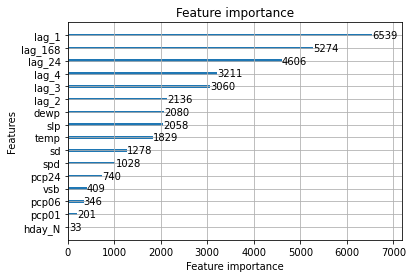

In [39]:
lgb.plot_importance(model)

In [40]:
y_test_df = pd.Series(y_test, index = X_test.index)
y_test_df.index = pd.to_datetime(y_test_df.index)

In [41]:
y_gs = pd.Series(y_gs, index = X_test.index)
y_gs.index = pd.to_datetime(y_gs.index)
y_gs

pickup_dt
2015-06-01 00:00:00    948.799307
2015-06-01 01:00:00    582.630231
2015-06-01 02:00:00    311.616265
2015-06-01 03:00:00    192.627757
2015-06-01 04:00:00    185.717238
                          ...    
2015-06-30 19:00:00    770.137116
2015-06-30 20:00:00    872.433024
2015-06-30 21:00:00    844.050322
2015-06-30 22:00:00    860.403959
2015-06-30 23:00:00    862.027153
Length: 720, dtype: float64

In [42]:
pd.concat([y_test_df,y_pred_df], axis=1).plot()


Figure(id='1227', ...)

In [43]:
y_test_df

pickup_dt
2015-06-01 00:00:00    528
2015-06-01 01:00:00    337
2015-06-01 02:00:00    194
2015-06-01 03:00:00    128
2015-06-01 04:00:00    170
                      ... 
2015-06-30 19:00:00    777
2015-06-30 20:00:00    817
2015-06-30 21:00:00    829
2015-06-30 22:00:00    860
2015-06-30 23:00:00    990
Name: pickups, Length: 720, dtype: int64

In [44]:
y_test_df.to_csv('../y_test_df.csv')

In [45]:
import pickle

pickle.dump(model, open('model_lgbm_brooklyn.pkl','wb'))

In [58]:
#y_test.to_csv('../y_test_lgbm.csv')

In [59]:
#X_test.to_csv('../X_test_lgbm.csv',index=False)

In [60]:
y_test

pickup_dt
2015-06-01 00:00:00    1301
2015-06-01 01:00:00     704
2015-06-01 02:00:00     488
2015-06-01 03:00:00     349
2015-06-01 04:00:00     453
                       ... 
2015-06-30 19:00:00    4585
2015-06-30 20:00:00    4210
2015-06-30 21:00:00    4313
2015-06-30 22:00:00    4452
2015-06-30 23:00:00    3828
Name: pickups, Length: 720, dtype: int64